In [1]:
!pip install torch
!pip install numpy
!pip install scikit-learn
!pip install pandas
!pip install seaborn
!pip install sentencepiece

import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import random
import math
import os
import sys
import string
from random import randint
from collections import defaultdict
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from datetime import datetime
#from google.colab import drive
import re
import sentencepiece as spm
import csv
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from enum import Enum
import logging
import google.generativeai as genai
import xml.etree.ElementTree as ET
from dotenv import load_dotenv
#drive.mount('/content/drive', force_remount=True)

prefix_path = './DMPROJECT/'
USE_BRNN = True #set to true if using BRNN, false for transformer
USE_TRANSFORMER = False
USE_FCN = False
USE_CONV = False
USE_COMPOSITION = False
USE_BICONV = False
#assert sum([USE_BRNN, USE_TRANSFORMER, USE_FCN, USE_CONV]) == 1, "Exactly one model must be selected (set one flag to True)."

EMBEDDINGS_DIM = 256 #Embeddings size for phonetic embeddings, word embeddings and transformer token embeddings

#Default brnn is use EOS true and use SOS false
USE_SOS_IN_X = False if USE_TRANSFORMER else True
USE_EOS_IN_X = False

#Default brnn is use EOS true and use SOS false
USE_SOS_IN_Y = False
USE_EOS_IN_Y = True

USE_ONE_HOT_ENCODING = False #One-Hot instead of tokenization+embedding
EMBED_FOR_GRAPH = False

#Embeddings usage
USE_WORD_EMB = False

#Type
USE_TFIDF = False #use tfidf features
USE_NLLWithKL = False #use NLLLwithKL loss
USE_RANKED_LOSS_CONTRIB = False #use ranking in loss

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
# Set seeds for reproducibility
SEED = 17  # You can change this to any fixed number
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Ensure deterministic behavior for CUDA (if using GPU)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # For multi-GPU setups

# Ensure reproducibility in cuDNN operations
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False  # Disabling this may slow down training but ensures reproducibility
np.random.seed(SEED)                      # NumPy RNG
torch.manual_seed(SEED) 
#PLEASE BE DETERMINISTICK
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.enabled = False


# Set environment variables for deterministic behavior
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
#os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"  # Ensures CUDA operations remain deterministic in newer PyTorch versions

print(f"Random seed set to {SEED} for reproducibility!")

Random seed set to 17 for reproducibility!


In [3]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
print("Current GPU device:", torch.cuda.current_device())
print("GPU name:", torch.cuda.get_device_name(torch.cuda.current_device()))

import psutil

# Total RAM in GB
total_memory = psutil.virtual_memory().total / (1024 ** 3)
print(f"Total CPU RAM: {total_memory:.2f} GB")
if torch.cuda.is_available():
    gpu_index = torch.cuda.current_device()
    gpu_name = torch.cuda.get_device_name(gpu_index)
    total_gpu_memory = torch.cuda.get_device_properties(gpu_index).total_memory / (1024 ** 3)

    print(f"GPU: {gpu_name}")
    print(f"Total GPU RAM: {total_gpu_memory:.2f} GB")
else:
    print("CUDA GPU not available.")


CUDA available: True
Number of GPUs: 1
Current GPU device: 0
GPU name: NVIDIA A100-SXM4-80GB
Total CPU RAM: 2015.66 GB
GPU: NVIDIA A100-SXM4-80GB
Total GPU RAM: 79.15 GB


In [4]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Tue_Oct_29_23:50:19_PDT_2024
Cuda compilation tools, release 12.6, V12.6.85
Build cuda_12.6.r12.6/compiler.35059454_0


In [ ]:
if EMBED_FOR_GRAPH:
    USE_SOS_IN_X = False
    USE_EOS_IN_Y = False

## EDA LB

In [87]:
#LB
df_lb = pd.read_csv('/content/drive/MyDrive/DMPROJECT/signs_LB.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/DMPROJECT/signs_LB.csv'

In [ ]:
signs = df_lb['sign'].unique()
signs = sorted(signs)

In [ ]:
# Count the occurrences of each sign in df_lb
sign_counts_lb = df_lb["sign"].value_counts()
sign_counts_lb = sign_counts_lb.head(70)

# Create a bar plot for the signs in df_lb
plt.figure(figsize=(12, 8))  # Adjust the figure size
sns.barplot(x=sign_counts_lb.index, y=sign_counts_lb.values, palette="viridis")


# Labels and title
plt.xlabel("Sign")
plt.ylabel("Frequency")
plt.title("Frequency of Signs in df_lb")
plt.xticks(rotation=45)

# Show the plot
plt.show()

##EDA LA



In [ ]:
df_la = pd.read_csv('/content/drive/MyDrive/DMPROJECT/signs.csv')
df_la.head()

In [ ]:
signs = df_la['sign'].unique()
signs = sorted(signs)
len(signs)
signs

In [ ]:
df_sites = pd.read_csv('/content/drive/MyDrive/DMPROJECT/sites_data.csv')
df_la_sites = df_sites.merge(df_la, on="document_name")

sites_to_remove = ["Syme", "Pyrgos", "Psykhro", "Papoura", "Mycenae", "Melos", "Kythera", "Kea", "Haghios Stephanos", "Gournia"]
df_la_sites.drop(df_la_sites[df_la_sites["site"].isin(sites_to_remove)].index, inplace=True)
df_la_sites.head()

In [ ]:
#Distribution signs per site
freq_df = df_la_sites.groupby("site")["sign"].value_counts().unstack(fill_value=0)

# Display frequency table
unique_sites = df_la_sites["site"].unique()

for site in unique_sites:
    site_df = df_la_sites[df_la_sites["site"] == site]  # Filter data for the site
    sign_counts = site_df["sign"].value_counts()  # Count occurrences

    # Get top 20 most frequent signs
    top_20_sign_counts = sign_counts.head(50)

    # Create a bar plot
    plt.figure(figsize=(12, 8))  # Adjust the figure size
    sns.barplot(x=top_20_sign_counts.index, y=top_20_sign_counts.values, palette="viridis")

    # Labels and title
    plt.xlabel("Sign")
    plt.ylabel("Frequency")
    plt.title(f"Top 20 Most Frequent Signs for Site {site}")
    plt.xticks(rotation=45)

    # Show the plot
    plt.show()

In [ ]:
site_signs = {site: set(df_la_sites[df_la_sites["site"] == site]["sign"].unique()) for site in unique_sites}

# Find the intersection of signs across all sites
common_signs = set.intersection(*site_signs.values())

# Filter the dataframe to only include rows with common signs
df_common_signs = df_la_sites[df_la_sites["sign"].isin(common_signs)]

# Count the occurrences of these common signs
common_sign_counts = df_common_signs["sign"].value_counts()

# Create a bar plot for the common signs
plt.figure(figsize=(12, 8))  # Adjust the figure size
sns.barplot(x=common_sign_counts.index, y=common_sign_counts.values, palette="viridis")

# Labels and title
plt.xlabel("Sign")
plt.ylabel("Frequency")
plt.title("Common Signs Across All Sites")
plt.xticks(rotation=45)

# Show the plot
plt.show()

#

In [ ]:
# Count the occurrences of each sign in df_lb
sign_counts_la = df_la["sign"].value_counts()
sign_counts_la = sign_counts_la.head(70)

# Create a bar plot for the signs in df_lb
plt.figure(figsize=(16, 8))  # Adjust the figure size
sns.barplot(x=sign_counts_la.index, y=sign_counts_la.values, palette="viridis")


# Labels and title
plt.xlabel("Sign")
plt.ylabel("Frequency")
plt.title("Frequency of Signs in df_lb")
plt.xticks(rotation=45)

# Show the plot
plt.show()

## EDA LB LA


In [ ]:
SEQUENCES_LA = os.path.join(prefix_path, "sequences.csv")
SEQUENCES_LB = os.path.join(prefix_path, "processed_sequences_LB.csv")


# Read the CSV files into DataFrames
df_LA = pd.read_csv(SEQUENCES_LA)
df_LB = pd.read_csv(SEQUENCES_LB)


def compare(sequence_LA, sequence_LB):
    sequence_LA = sequence_LA.split("-")
    sequence_LB = sequence_LB.split("-")
    i, j = 0, 0

    score = 1
    correspondences = 0

    while i < len(sequence_LA) and j < len(sequence_LB):
        if sequence_LA[i] == sequence_LB[j]:
            i += 1
            j += 1
            correspondences += 1
        elif sequence_LA[i][0] == sequence_LB[j][0]:
            i += 1
            j += 1
            score -= 0.1
            #correspondences += 1
        else:
            score -= 0.5
            if len(sequence_LA) < len(sequence_LB):
                i += 1
            else:
                j += 1
    score -= 0.1 * (len(sequence_LA)-i + len(sequence_LB)-j)
    return score, correspondences

dic = defaultdict(lambda: set())

# Iterate over each sequence in LA
for index_LA, row_LA in df_LA.iterrows():
    if row_LA["complete"] and row_LA["sequence"] not in dic:
        for index_LB, row_LB in df_LB.iterrows():
            if abs(row_LA["length"] - row_LB["length"]) <= 2:
                score, correspondences = compare(row_LA['sequence'], row_LB['sequence'])
                if score > 0.5 and correspondences >= 2:
                    dic[row_LA['sequence']].add((row_LB['sequence'], score, row_LB["complete"]))
                    print(row_LA['sequence'], row_LB['sequence'], score, correspondences)

for key, value in dic.items():
    dic[key] = sorted(list(value), key=lambda x: x[1], reverse=True)



In [ ]:
dic

## ALEX

In [ ]:
import pandas as pd
import os

# Define file paths
SEQUENCES_LA = os.path.join(prefix_path, "sequences.csv")

# Read the CSV file into a DataFrame
seq_la = pd.read_csv(SEQUENCES_LA)

# Print total number of sequences
total_sequences = len(seq_la)
print(f"Total sequences: {total_sequences}")

complete_sequences = seq_la['complete'].sum()
print(f"Sequences which are marked as complete: {complete_sequences}")



In [ ]:
seq_la.head()

In [ ]:
import os
import pandas as pd

def reconstruct_LA_documents():
    # Load the signs.csv file
    signs_path = os.path.join(prefix_path, "signs.csv")
    sequences_path = os.path.join(prefix_path, "sequences.csv")
    signs_df = pd.read_csv(signs_path)
    sequences_df = pd.read_csv(sequences_path)

    # Dictionary to hold reconstructed documents
    documents = {}

    # Group by 'document_name' and sort by 'sign_number'
    grouped_signs = signs_df.sort_values(by=['document_name', 'sign_number']).groupby('document_name')
    grouped_sequences = sequences_df.sort_values(by=['document_name', 'sequence_number']).groupby('document_name')

    # Iterate over each group
    for document_name, group in grouped_signs:
        documents[document_name] = []

        # gather all sequences from the appropriate document
        seq = grouped_sequences.get_group(document_name)['sequence'].tolist() if document_name in grouped_sequences.groups else []
        for i in range(len(seq)):
            seq[i] = seq[i].split("-")

        # Initialize variables
        seq_idx = 0
        seq_len = 0
        stack = []
        for sign in group['sign']:
            # if the sequence is actually complete, we can put it in the document collection
            if len(seq) > 0 and sign == seq[seq_idx][seq_len] and seq_len == len(seq[seq_idx])-1:
                seq_len = 0
                stack = []
                documents[document_name].append("-".join(seq[seq_idx]))
                if seq_idx < len(seq)-1:
                    seq_idx += 1
            # we are completing the current sequence
            elif len(seq) > 0 and sign == seq[seq_idx][seq_len]:
                seq_len += 1
                stack.append(sign)
            # the symbol does not correspond to the current sequence, so we push the new symbol (and all those recognized from the end of the previous sequence)
            else:
                stack.append(sign)
                documents[document_name] += stack
                stack = []
                seq_len = 0

        documents[document_name] = " ".join(documents[document_name])
    return documents
reconstruct_LA_documents()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

corpus = reconstruct_LA_documents()

# Initialize TF-IDF Vectorizer with improved settings


def compute_tfidf(documents):
    # Convert the document dictionary into a list of strings (concatenated words per document)
    document_names = list(documents.keys())
    corpus = list(documents.values())

    # Initialize TF-IDF Vectorizer
    vectorizer = TfidfVectorizer(
        token_pattern=r"[a-zA-Z\-\*\d]+",  # Keep special characters including ?
        min_df=1,  # Include all words
        sublinear_tf=True,  # Prevent extreme weighting
        lowercase=False  # Keep original case
    )

    tfidf_matrix = vectorizer.fit_transform(corpus)

    # Get feature names (words)
    feature_names = vectorizer.get_feature_names_out()

    # Convert TF-IDF matrix to a DataFrame
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=document_names, columns=feature_names)

    return tfidf_df

# Example dictionary (your processed documents)
documents = reconstruct_LA_documents()

# Compute TF-IDF
tfidf_result = compute_tfidf(documents)

# Display the results
print(tfidf_result)


## UGARITIC/LB TASK


In [5]:
!pip install colorlog
!pip install ortools
!pip install enlighten
!pip install treelib
!pip install rapidfuzz

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [6]:
import copy
import torch
from functools import wraps
from inspect import signature
from collections import defaultdict, namedtuple
from collections.abc import Callable, Hashable
import logging
import os
import sys
from prettytable import PrettyTable as pt
from functools import reduce
from operator import mul
from pathlib import Path
import pandas as pd
from functools import wraps
from dataclasses import dataclass
from torch.utils.data import DataLoader, Dataset
from colorlog import TTYColoredFormatter
import time
from datetime import timedelta
import math
import torch.nn as nn
from torch.nn.functional import normalize
import torch.sparse
import itertools
from ortools.graph.python import min_cost_flow as mcf
import types
import enlighten
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
from treelib import Tree
import io
import os
import random
from pprint import pformat
from torch.nn.utils.rnn import pack_padded_sequence, PackedSequence

import numpy as np
import torch
from torch.utils.checkpoint import checkpoint

from rapidfuzz.process import cdist
from rapidfuzz.distance import Levenshtein
import ast
from sklearn.model_selection import train_test_split

2025-10-03 03:32:43.451254: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-03 03:32:44.161860: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## To RUN

### ArgLib

In [7]:

def add_properties(*names):
    """Add properties as methods to classes."""

    def decorator(cls):
        for name in names:
            # NOTE The keyword is necessary.
            setattr(cls, name, property(lambda self, name=name: getattr(self, f'_{name}')))
        return cls

    return decorator


def set_properties(*names, **values):
    """Set a private variable and use it as a property for an instance."""

    def decorator(self):
        for name in names:
            setattr(self, f'_{name}', values[name])

        return self

    return decorator

#Decorator wraps old init witht he properties of *name

def has_properties(*names):

    def decorator(cls):
        cls = add_properties(*names)(cls)
        old_init = cls.__init__

        @wraps(old_init)
        def new_init(self, *args, **kwargs):

            func_sig = signature(old_init)
            bound = func_sig.bind(self, *args, **kwargs)
            bound.apply_defaults()
            all_args = bound.arguments
            self = set_properties(*names, **all_args)(self)
            old_init(self, *args, **kwargs)

        cls.__init__ = new_init
        return cls

    return decorator


### DevMisc

In [8]:
class Map(dict):
	"""
	Abandoned the original way of doing it:
		self.__dict__ = self
	This introduces a self-reference and makes gc fail to collect garbage
	in time. As a result, pytorch can't properly empty cache if a tensor is
	stored in it.
	"""

	def __getattr__(self, key):
		try:
			return self[key]
		except KeyError:
			raise AttributeError

	def __setattr__(self, key, value):
		self[key] = value

	def update(self, *args, **kwargs):
		'''
		Return self.
		'''
		super(Map, self).update(*args, **kwargs)
		return self

	def apply(self, func, ignored=set()):
		for key in self:
			if key in ignored:
				continue

			if isinstance(self[key], Map):
				self[key].apply(func, ignored=ignored)
			else:
				self[key] = func(self[key])


In [9]:
_CachedItem = namedtuple('_CachedItem', ['persist', 'value'])
_CACHE = dict()
_USE_CACHE = True

def cache(full=True, persist=False):
    global _USE_CACHE

    def descriptor(func):
        func_sig = signature(func)
        def decorator(self, *args, **kwargs):
            if not _USE_CACHE:
                return func(self, *args, **kwargs)

            bound = func_sig.bind(self, *args, **kwargs)
            bound.apply_defaults()
            items = [(k, v) for k, v in bound.arguments.items() if not isinstance(v, dict)]
            arg_key = frozenset(items)
            if full:
                key = (id(self), func.__name__, arg_key)
            else:
                key = (id(self), func.__name__)
            if key in _CACHE:
                return _CACHE[key].value
            else:
                ret = func(self, *args, **kwargs)
                _CACHE[key] = _CachedItem(persist, ret)
                return ret

        return decorator

    return descriptor

def clear_cache():
	global _CACHE
	# First pass to get keys to be removed.
	to_remove = list()
	for k, item in _CACHE.items():
		if not item.persist:
			to_remove.append(k)
	# Now remove them.
	for k in to_remove:
		del _CACHE[k]

def set_cache(flag):
	global _USE_CACHE
	assert flag in [True, False]
	_USE_CACHE = flag

####################################### structured cache #################################

class _StructuredCache:
	'''
	Assuming that the return is a Map object, this cache will selectively keep some
	attributes while removing the rest.
	You can also dynamically select what to cache, useful when you want to perform analysis.
	'''

	def __init__(self):
		# What should be kept.
		self._to_keep = dict()
		# What should be cached.
		self._to_cache = defaultdict(set)
		# What is cached. Note that each instance method has its own cache, keyed by the object's unique id.
		self.clear_cache()
		# The mapping from the object id to the object.
		self._id2obj = dict()

	def keep(self, name, ret):
		'''Only keep what should be kept.'''
		if self._to_keep[name] is None:
			return ret
		else:
			return Map(**{k: ret[k] for k in self._to_keep[name] if k in ret})

	def __contains__(self, key):
		return key in self._to_keep

	def register_keep(self, name, *to_keep):
		'''Record what to keep for each function.'''
		assert name not in self
		if len(to_keep) == 0:
			self._to_keep[name] = None # NOTE None means keeping everthing.
		else:
			self._to_keep[name] = set(to_keep)

	def register_cache(self, name, *keys):
		'''Register cache for all instances of the same registered function with ``name``.'''
		self._to_cache[name].update(keys)

	def cache(self, name, obj, ret):
		id_ = id(obj)
		if id_ not in self._id2obj:
			self._id2obj[id_] = obj
		else:
			assert self._id2obj[id_] is obj # Make sure it's the same object.
		for k in self._to_cache[name]:
			assert k not in self._cache[name][id_]
			self._cache[name][id_][k] = ret[k]

	def get_cache(self, name, *keys):
		'''Get all caches generated from the same function.'''
		ret = list()
		for id_ in self._cache[name]:
			obj = self._id2obj[id_]
			cache = self._cache[name][id_]
			ret.append((obj, {k: cache[k] for k in keys}))
		return ret

	def clear_cache(self):
		self._cache = defaultdict(lambda: defaultdict(defaultdict))

_SC = _StructuredCache()
def sc(name, *to_keep):
	global _SC

	def descriptor(func):

		@wraps(func)
		def decorator(self, *args, **kwargs):
			ret = func(self, *args, **kwargs)
			assert isinstance(ret, Map)
			_SC.cache(name, self, ret)
			return _SC.keep(name, ret)

		return decorator

	_SC.register_keep(name, *to_keep)
	return descriptor

def sc_clear_cache():
	global _SC
	_SC.clear_cache()

def sc_register_cache(name, *keys):
	global _SC
	_SC.register_cache(name, *keys)

def sc_get_cache(name, *keys):
	global _SC
	return _SC.get_cache(name, *keys)


In [10]:

def get_tensor(data, dtype=None, requires_grad=False, use_cuda=True):
    use_cuda = os.environ.get('CUDA_VISIBLE_DEVICES', False) and use_cuda # NOTE only use cuda when it's not overriden and there is a device available

    # If data is a tensor already, move to gpu if use_cuda
    if isinstance(data, torch.Tensor):
        if use_cuda:
            return data.cuda()
        return data

    if dtype is None: # NOTE infer dtype
        dtype = 'f'
        if isinstance(data, np.ndarray) and issubclass(data.dtype.type, np.integer):
            dtype = 'l'

    # NOTE directly declare data. I believe it's faster on cuda, although I'm not entirely sure
    requires_grad = requires_grad and dtype == 'f'
    assert dtype in ['f', 'l']
    #if use_cuda:
    #    module = getattr(torch, 'cuda')
    #else:
    #    module = torch
    #if dtype == 'f':
    #    cls = getattr(module, 'FloatTensor')
    #    dtype = 'float32'
    #elif dtype == 'l':
    #    cls = getattr(module, 'LongTensor')
    #    dtype = 'int64'
    #ret = cls(np.asarray(data, dtype=dtype))
    # Set PyTorch data type and device
    device = 'cuda' if use_cuda else 'cpu'

    if dtype == 'f':
        torch_dtype = torch.float32
    elif dtype == 'l':
        torch_dtype = torch.int64

    # Create tensor properly
    ret = torch.tensor(np.asarray(data, dtype=dtype), dtype=torch_dtype, device=device)

    ret.requires_grad = requires_grad
    return ret

def get_zeros(*shape, **kwargs):
    if len(shape) == 1 and isinstance(shape[0], torch.Size): # NOTE deal with 1D tensor whose shape cannot be unpacked
        shape = list(shape[0])
    return get_tensor(np.zeros(shape), **kwargs)

def get_eye(n):
    return get_tensor(np.eye(n))

def counter(iterable, *args, max_size=0, interval=1000, **kwargs):
    total = 0
    for i, item in enumerate(iterable, *args, **kwargs):
        yield item
        total += 1
        if total % interval == 0:
            logging.debug(f'{total}')
            sys.stdout.flush()
        if max_size and total == max_size:
            logging.info(f'Reached max size')
            break
    logging.debug(f'Finished enumeration of size {total}')

def freeze(mod):
    for p in mod.parameters():
        p.requires_grad = False
    for m in mod.children():
        freeze(m)

def sort_all(anchor, *others):
    '''
    Sort everything (``anchor`` and ``others``) in this based on the lengths of ``anchor``.
    '''
    # Check everything is an numpy array.
    for a in (anchor, ) + others:
        assert isinstance(a, np.ndarray)
    #  Check everything has the same length in the first dimension.
    l = len(anchor)
    for o in others:
        assert len(o) == l
    # Sort by length.
    lens = np.asarray([len(x) for x in anchor], dtype='int64')
    inds = np.argsort(lens)[::-1]
    # Return everything after sorting.
    return [lens[inds]] + [anchor[inds]] + [o[inds] for o in others]

def pprint_cols(data, num_cols=4):
    t = pt()
    num_rows = len(data) // num_cols + (len(data) % num_cols > 0)
    for col in range(num_cols - 1):
        t.add_column(f'Column:{col+1}', data[col * num_rows: (col + 1) * num_rows])
    t.add_column(f'Column:{num_cols}', data[(num_cols - 1) * num_rows:] + [''] * ((num_rows - len(data) % num_rows) % num_rows))
    t.align = 'l'
    print(t)

def check(t):
    if (torch.isnan(t).any() | torch.isinf(t).any()).item():
        breakpoint()

def canonicalize(shape, dim):
    if dim < 0:
        return len(shape) + dim
    else:
        return dim

def divide(tensor, dim, div_shape):
    prev_shape = tensor.shape
    dim = canonicalize(prev_shape, dim)
    if -1 not in div_shape:
        total = reduce(mul, div_shape, 1)
        assert total == prev_shape[dim]
    new_shape = prev_shape[:dim] + tuple(div_shape) + prev_shape[dim + 1:]
    return tensor.view(*new_shape)

def merge(tensor, dims):
    prev_shape = tensor.shape
    dims = [canonicalize(prev_shape, dim) for dim in dims]
    for a, b in zip(dims[:-1], dims[1:]):
        assert b == a + 1
    total = reduce(mul, [prev_shape[d] for d in dims], 1)
    new_shape = prev_shape[:dims[0]] + (total, ) + prev_shape[dims[-1] + 1:]
    return tensor.view(*new_shape)


In [11]:
'''
Modified from MUSE
'''


# From https://stackoverflow.com/questions/2183233/how-to-add-a-custom-loglevel-to-pythons-logging-facility.
def addLoggingLevel(levelName, levelNum, methodName=None):
    """
    Comprehensively adds a new logging level to the `logging` module and the
    currently configured logging class.

    `levelName` becomes an attribute of the `logging` module with the value
    `levelNum`. `methodName` becomes a convenience method for both `logging`
    itself and the class returned by `logging.getLoggerClass()` (usually just
    `logging.Logger`). If `methodName` is not specified, `levelName.lower()` is
    used.

    To avoid accidental clobberings of existing attributes, this method will
    raise an `AttributeError` if the level name is already an attribute of the
    `logging` module or if the method name is already present

    Example
    -------
    >>> addLoggingLevel('TRACE', logging.DEBUG - 5)
    >>> logging.getLogger(__name__).setLevel("TRACE")
    >>> logging.getLogger(__name__).trace('that worked')
    >>> logging.trace('so did this')
    >>> logging.TRACE
    5

    """
    if not methodName:
        methodName = levelName.lower()

    #if hasattr(logging, levelName):
    #    raise AttributeError('{} already defined in logging module'.format(levelName))
    #if hasattr(logging, methodName):
    #    raise AttributeError('{} already defined in logging module'.format(methodName))
    #if hasattr(logging.getLoggerClass(), methodName):
    #    raise AttributeError('{} already defined in logger class'.format(methodName))

    # This method was inspired by the answers to Stack Overflow post
    # http://stackoverflow.com/q/2183233/2988730, especially
    # http://stackoverflow.com/a/13638084/2988730
    def logForLevel(self, message, *args, **kwargs):
        if self.isEnabledFor(levelNum):
            self._log(levelNum, message, args, **kwargs)

    def logToRoot(message, *args, **kwargs):
        logging.log(levelNum, message, *args, **kwargs)

    logging.addLevelName(levelNum, levelName)
    setattr(logging, levelName, levelNum)
    setattr(logging.getLoggerClass(), methodName, logForLevel)
    setattr(logging, methodName, logToRoot)


addLoggingLevel('IMP', 25)


class LogFormatter(TTYColoredFormatter):

    def __init__(self, *args, **kwargs):  # , color=False):
        fmt = '%(log_color)s%(levelname)s - %(time)s - %(elapsed)s at %(filename)s:%(lineno)d - %(message)s'
        super(LogFormatter, self).__init__(
            fmt,
            log_colors={
                'DEBUG': 'white',
                'INFO': 'green',
                'IMP': 'cyan',
                'WARNING': 'yellow',
                'ERROR': 'red',
                'CRITICAL': 'red,bg_white'},
            *args,
            **kwargs)
        self.start_time = time.time()

    def format(self, record):
        # only need to set timestamps once -- all changes are stored in the record object
        if not hasattr(record, 'elapsed'):
            record.elapsed = timedelta(seconds=round(record.created - self.start_time))
            record.time = time.strftime('%x %X')
            # if self.colored:
            prefix = "%s - %s - %s at %s:%d" % (
                record.levelname,
                record.time,
                record.elapsed,
                record.filename,
                record.lineno
            )
            message = record.getMessage()
            # If a message starts with a line break, we will keep the original line break without autoindentation.
            if not message.startswith('\n'):
                message = message.replace('\n', '\n' + ' ' * (len(prefix) + 3))
            record.msg = message
            record.args = ()  # NOTE avoid evaluating the message again duing getMessage call.
        x = super(LogFormatter, self).format(record)
        return x


def create_logger(filepath=None, log_level='INFO'):
    """
    Create a logger.
    """
    # create console handler and set level to info
    console_handler = logging.StreamHandler()
    # create log formatter
    colorlog_formatter = LogFormatter(stream=console_handler.stream)
    console_handler.setLevel(getattr(logging, log_level))
    console_handler.setFormatter(colorlog_formatter)

    # create logger and set level to debug
    logger = logging.getLogger()
    logger.handlers = []
    logger.setLevel(log_level)
    logger.propagate = False
    logger.addHandler(console_handler)
    if filepath:
        # create file handler and set level to debug
        file_handler = logging.FileHandler(filepath, "a")
        file_handler.setLevel(log_level)
        log_formatter = LogFormatter(stream=file_handler.stream)
        file_handler.setFormatter(log_formatter)
        logger.addHandler(file_handler)

    # reset logger elapsed time
    def reset_time():
        log_formatter.start_time = time.time()
    logger.reset_time = reset_time

    return logger


def log_this(log_level='DEBUG', msg='', arg_list=None):
    """
    A decorator that logs the functionality, the beginning and the end of the function.
    It can optionally print out arg values in arg_list.
    """

    def decorator(func):
        new_msg = msg or func.__name__
        new_arg_list = arg_list or list()
        def log_func(msg): return logging.log(getattr(logging, log_level), msg)

        @wraps(func)
        def wrapper(*args, **kwargs):
            log_func(f'*STARTING* {new_msg}')

            if new_arg_list:

                func_sig = signature(func)
                bound = func_sig.bind(*args, **kwargs)
                bound.apply_defaults()
                all_args = bound.arguments

                arg_msg = {name: all_args[name] for name in new_arg_list}
                log_func(f'*ARG_LIST* {arg_msg}')

            ret = func(*args, **kwargs)
            log_func(f'*FINISHED* {new_msg}')
            return ret

        return wrapper

    return decorator


def log_pp(obj):
    '''
    Log ``obj`` with better indentations.
    '''
    logging.info(('\n' + str(obj)).replace('\n', '\n' + ' ' * 10))


In [12]:

def plain(value):
    '''Convert tensors or numpy arrays to one scalar.'''
    # Get to str, int or float first.
    if isinstance(value, torch.Tensor):
        assert value.numel() == 1
        value = value.item()
    elif isinstance(value, np.ndarray):
        assert value.size == 1
        value = value[0]
    # Format it nicely.
    if isinstance(value, (str, int)):
        value = value
    elif isinstance(value, float):
        value = float(f'{value:.3f}')
    else:
        raise NotImplementedError
    return value


class Metric:

    def __init__(self, name, value, weight, report_mean=True):
        self.name = name
        self._v = value
        self._w = weight
        self._report_mean = report_mean

    def __hash__(self):
        return hash(self.name)

    def __str__(self):
        if self.report_mean:
            return f'{plain(self._v)}/{plain(self._w)}={plain(self.mean)}'
        else:
            return f'{plain(self.total)}'

    def __repr__(self):
        return f'Metric(name={self.name}, report_mean={self.report_mean})'

    def __eq__(self, other):
        return self.name == other.name

    def __add__(self, other):
        if isinstance(other, Metric):
            assert self == other, 'Cannot add two different metrics.'
            assert self.report_mean == other.report_mean
            return Metric(self.name, self._v + other._v, self._w + other._w, report_mean=self.report_mean)
        else:
            # NOTE This is useful for sum() call.
            assert isinstance(other, (int, float)) and other == 0
            return self

    def __radd__(self, other):
        return self.__add__(other)

    def rename(self, name):
        '''This is in-place.'''
        self.name = name
        return self

    @property
    def value(self):
        return self._v

    @property
    def weight(self):
        return self._w if self.report_mean else 'N/A'

    @property
    def report_mean(self):
        return self._report_mean

    @property
    def mean(self):
        if self.report_mean:
            return self._v / self._w
        else:
            return 'N/A'

    @property
    def total(self):
        return self._v

    def clear(self):
        self._v = 0
        self._w = 0


class Metrics:

    def __init__(self, *metrics):
        # Check all of metrics are of the same type. Either all str or all Metric.
        types = set([type(m) for m in metrics])
        assert len(types) <= 1

        if len(types) == 1:
            if types.pop() is str:
                self._metrics = {k: Metric(k, 0, 0) for k in keys}
            else:
                self._metrics = {metric.name: metric for metric in metrics}
        else:
            self._metrics = dict()

    def __str__(self):
        out = '\n'.join([f'{k}: {m}' for k, m in self._metrics.items()])
        return out

    def __repr__(self):
        return f'Metrics({", ".join(self._metrics.keys())})'

    def __add__(self, other):
        if isinstance(other, Metric):
            other = Metrics(other)
        union_keys = set(self._metrics.keys()) | set(other._metrics.keys())
        metrics = list()
        for k in union_keys:
            m1 = self._metrics.get(k, 0)
            m2 = other._metrics.get(k, 0)
            metrics.append(m1 + m2)
        return Metrics(*metrics)

    def __getattr__(self, key):
        try:
            return super().__getattribute__('_metrics')[key]
        except KeyError:
            raise AttributeError(f'Cannot find this attribute {key}')

    def get_table(self, title=''):
        t = pt()
        if title:
            t.title = title
        t.field_names = 'name', 'value', 'weight', 'mean'
        for k in sorted(self._metrics.keys()):
            metric = self._metrics[k]
            t.add_row([k, plain(metric.value), plain(metric.weight), plain(metric.mean)])
        t.align = 'l'
        return t

    def clear(self):
        for m in self._metrics.values():
            m.clear()


In [13]:
_manager = enlighten.get_manager()
_stage_names = set()

def clear_stages():
    global _manager
    global _stage_names
    _manager = enlighten.get_manager()
    _stage_names = set()

def _check_name(name):
    assert name not in _stage_names
    _stage_names.add(name)


def _reset_pbar(pbar):
    pbar.count = 0
    pbar.start = time.time()


@has_properties('name', 'num_steps', 'parent')
class _Stage:

    def __init__(self, name, num_steps=1, parent=None):
        _check_name(name)

        self._pbars = dict()
        self.substages = list()
        if self.num_steps > 1:
            self.add_pbar(name, total=self.num_steps)

    def update_pbars(self):
        for pbar in self._pbars.values():
            if pbar.total == pbar.count:
                _reset_pbar(pbar)
            pbar.update()

    def reset_pbars(self, recursive=False):
        for pbar in self._pbars.values():
            _reset_pbar(pbar)
        if recursive:
            for substage in self.substages:
                substage.reset_pbars(recursive=True)

    def add_pbar(self, name, total=None, unit='samples'):
        if name in self._pbars:
            raise NameError(f'Name {name} already exists.')
        pbar = _manager.counter(
            desc=name,
            total=total,
            unit=unit,
            leave=False)
        pbar.refresh()
        self._pbars[name] = pbar

    def add_stage(self, name, num_steps=1):
        stage = _Stage(name, num_steps=num_steps, parent=self)
        self.substages.append(stage)
        return stage

    # def adjoin_stage(self, stage):
    #     assert isinstance(stage, _Stage)
    #     self.substages.append(stage)
    #     return self

    def __str__(self):
        return f'"{self.name}"'

    def __repr__(self):
        return f'Stage(name={self.name}, num_steps={self.num_steps})'

    def load_state_dict(self, state_dict):
        missing = list()
        for name, pbar_meta in state_dict['_pbars'].items():
            try:
                pbar = self._pbars[name]
            except KeyError:
                missing.append(f'pbar:{name}')
                continue
            pbar.count = pbar_meta['count']
            pbar.refresh()
        for s1, s2 in zip(self.substages, state_dict['_stages']):
            s1.load_state_dict(s2)
        if missing:
            raise RuntimeError(f'Missing {missing}')

    def state_dict(self):
        ret = dict()
        # NOTE pbar itself cannot be serialized for some reason.
        ret['_pbars'] = {name: {'count': pbar.count} for name, pbar in self._pbars.items()}
        stage_ret = list()
        for s in self.substages:
            stage_ret.append(s.state_dict())
        ret['_stages'] = stage_ret
        return ret


@has_properties('step', 'substage_idx')
class _Node:
    """A wrapper of stage that contains step and substage_idx information."""

    def __init__(self, stage, step, substage_idx):
        self.stage = stage

    @property
    def name(self):
        return self.stage.name

    def is_last(self):
        last_step = (self.step == self.stage.num_steps - 1)
        if self.stage.substages:
            last_substage = (self.substage_idx == len(self.stage.substages) - 1)
            last = last_substage and last_step
        else:
            last = last_step
        return last

    def next_node(self):
        """Return whether next node will increment the step."""
        if self.stage.substages:
            new_substage_idx = self.substage_idx + 1
            incremented = False
            if new_substage_idx == len(self.stage.substages):
                new_substage_idx = 0
                incremented = True
            new_step = self.step + incremented
            return _Node(self.stage, new_step, new_substage_idx), incremented
        else:
            return _Node(self.stage, self.step + 1, None), True

    def __str__(self):
        return f'{self.stage}: {self.step}'

    def __repr__(self):
        return f'Node(stage={str(self.stage)}, step={self.step}, substage_idx={self.substage_idx})'


class _Path:

    def __init__(self, schedule):
        self._nodes = list()
        self._nodes_dict = dict()
        self._schedule = schedule
        self._get_first_path(self._schedule)
        self._finished = False

    def _add(self, node):
        # Check that this is a valid extension of the original path.
        if len(self._nodes) == 0:
            safe = True
        else:
            last_node = self._nodes[-1]
            safe = last_node.stage.substages[last_node.substage_idx] is node.stage
        assert safe
        # Add it.
        self._nodes.append(node)
        self._nodes_dict[node.stage.name] = node.step

    def __str__(self):
        ret = ' -> '.join([str(node) for node in self._nodes])
        return ret

    def _get_first_path(self, stage_or_node):

        def helper(stage_or_node):
            if isinstance(stage_or_node, _Stage):
                stage = stage_or_node
                if stage.substages:
                    self._add(_Node(stage, 0, 0))
                    helper(stage.substages[0])
                else:
                    self._add(_Node(stage, 0, None))  # None means there is no substage.
            else:
                assert isinstance(stage_or_node, _Node)
                node = stage_or_node
                if node.stage.substages:
                    new_node = _Node(node.stage, node.step, node.substage_idx)
                    self._add(new_node)
                    child_node = _Node(new_node.stage.substages[new_node.substage_idx], 0, 0)
                    helper(child_node)
                else:
                    self._add(node)

        helper(stage_or_node)

    @property
    def finished(self):
        return self._finished

    def next_path(self):
        """Note that this is in-place. It returns the nodes incremented."""
        # First backtrack to the first ancestor that hasn't been completed yet.
        assert not self._finished
        i = len(self._nodes)
        while i > 0:
            i -= 1
            last_node = self._nodes[i]
            if not last_node.is_last():
                break
        # Now complete it.
        if last_node.is_last():
            self._finished = True
            affected_nodes = self._nodes[1:]
        else:
            affected_nodes = self._nodes[i + 1:]  # NOTE Everything that is last will be incremented.
            self._nodes = self._nodes[:i]
            next_node, incremented = last_node.next_node()
            if incremented:
                affected_nodes.append(next_node)
            self._get_first_path(next_node)
        return affected_nodes

    @property
    def leaf_node(self):
        return self._nodes[-1]

    def get_step(self, key):
        return self._nodes_dict[key]


class _Schedule(_Stage):

    def __init__(self, name):
        super().__init__(name, num_steps=1)
        self._path = None

    def _build_path(self):
        self._path = _Path(self)

    def update(self):
        affected_nodes = self._path.next_path()

        for node in affected_nodes:
            node.stage.update_pbars()

    def as_tree(self):
        tree = Tree()  # NOTE Store the tree structure for treelib.
        tree.create_node(repr(self), id(self))

        def helper(stage):
            for substage in stage.substages:
                tree.create_node(repr(substage), id(substage), parent=id(stage))
                helper(substage)

        helper(self)

        sys.stdout = io.StringIO()
        tree.show()
        output = sys.stdout.getvalue()
        sys.stdout = sys.__stdout__
        return output

    @property
    def current_stage(self):
        return self._path.leaf_node

    @property
    def finished(self):
        return self._path.finished

    def get_step(self, key):
        return self._path.get_step(key)

    def fix_schedule(self):
        self._build_path()

    def reset(self):
        self._build_path()


class Tracker:

    def __init__(self, name):
        self.clear_best()
        self._schedule = _Schedule(name)
        self._metrics = Metrics()

    def schedule_as_tree(self):
        return self._schedule.as_tree()

    @property
    def schedule(self):
        return self._schedule

    @property
    def metrics(self):
        return self._metrics

    def reset(self):
        self._schedule.reset()

    def add_stage(self, name, num_steps=1):
        return self._schedule.add_stage(name, num_steps=num_steps)

    def clear_best(self):
        self.best_score = None
        self.best_stage = None

    def check_metrics(self, epoch):
        log_pp(self._metrics.get_table(title=f'Epoch: {epoch}'))

    def clear_metrics(self):
        self._metrics.clear()

    def update_metrics(self, metrics):
        self._metrics += metrics

    def state_dict(self):
        ret = {'_schedule': self._schedule.state_dict(), 'best_score': self.best_score,
               'best_stage': self.best_stage, '_metrics': self._metrics}
        return ret

    def load_state_dict(self, state_dict):
        #self._schedule.load_state_dict(state_dict['_schedule'])
        self.best_score = state_dict['best_score']
        self.best_stage = state_dict['best_stage']
        self._metrics = state_dict['_metrics']
        round_num, last_step = extract_round_and_last_step(state_dict['_schedule'])
        #logging.critical(state_dict['_schedule'])
        #logging.critical(f"{round_num}, {last_step}")
        #self.skip_to_checkpoint_progress(round_num, last_step)
        while not (self.get('round') == round_num):
            self._schedule.update()
            #logging.critical(f"{self.current_stage.name}, {self.current_stage.step}")
        # Skip to last M-step inside that round if needed
        while not (self.current_stage.name == "M step" and self.current_stage.step == last_step):
            self._schedule.update()
            #logging.critical(f"{self.current_stage.name}, {self.current_stage.step}")
        self._schedule.update()
        #logging.critical(f"{self.current_stage}, {self.get('round') }")


    def update_best(self, score, mode='min', quiet=False):
        """Update the best score and best stage.

        Args:
            score: score for the current stage
            mode (str, optional): take the maximum or the minimum as the best score. Defaults to 'min'.
            quiet (bool, optional): flag to suppress outputting the best score. Defaults to False.

        Returns:
            updated (bool): whether the best score has been updated or not
        """
        score = plain(score)
        updated = False

        def should_update():
            if score is None:
                return False
            if self.best_score is None:
                return True
            if mode == 'max' and self.best_score < score:
                return True
            if mode == 'min' and self.best_score > score:
                return True
            return False

        updated = should_update()
        if updated:
            self.best_score = score
            self.best_stage = str(self.current_stage)
        if self.best_score is not None and not quiet:
            logging.info(f'Best score is {self.best_score:.3f} at stage {self.best_stage}')
        return updated

    def update(self):
        self._schedule.update()

    @property
    def current_stage(self):
        return self._schedule.current_stage

    @property
    def finished(self):
        return self._schedule.finished

    def get(self, key):
        return self._schedule.get_step(key)

    def fix_schedule(self):
        self._schedule.fix_schedule()

    def reset_pbars(self):
        self._schedule.reset_pbars(recursive=True)


def extract_round_and_last_step(schedule_state_dict):
    try:
        outer_stage = schedule_state_dict['_stages'][0]
        round_count = outer_stage['_pbars']['round']['count']

        # Assuming the last executed step is inside substages
        substages = outer_stage['_stages']
        last_step = None
        for sub in substages:
            if 'M step' in sub['_pbars']:
                last_step = sub['_pbars']['M step']['count']
                break

        return round_count, last_step
    except (KeyError, IndexError) as e:
        raise ValueError("Invalid schedule state_dict format") from e


### CognateList

In [14]:


class CognateSet:
    '''
    Similar to the concept of synset in wordnet. Each cognate set contains words that are cognates with each other.
    If A is cognate to B1 and B2, then all of them will be stored here.
    Note that this doesn't gurantee that B1 and B2 are semantically similar. The word "bank" might be cognate to
    two totally different words in another language. In other words, while the cognate relation across languages are
    perserved here, nothing can be definitely said wrt the relation within the same language.
    '''
    IDX = 0

    def __init__(self):
        self._data = defaultdict(set)
        self.idx = CognateSet.IDX
        CognateSet.IDX += 1

    def add(self, lang, *words):
        words = [w for w in words if w != '_']
        if words:
            self._data[lang].update(words)  # '_' is a placeholder.

    def is_in(self, word, lang):
        if lang not in self._data:  # Do this to avoid spurious keys for defaultdict.
            return False
        return word in self._data[lang]

    def __contains__(self, lang):
        return lang in self._data

    def items(self):
        return self._data.items()

    def __getitem__(self, lang):
        if not lang in self:
            raise KeyError
        else:
            return self._data[lang]

    def to_df(self):
        data = list()
        for l, s in self._data.items():
            for w in s:
                data.append((w, l, self.idx))
        return pd.DataFrame(data, columns=['word', 'lang', 'idx'])


class CognateDict:
    '''
    A big dictionary that stores every cognate set. This works by storing many CognateSet's, and each
    word is then mapped to one set.
    '''

    def __init__(self, langs):
        self._cs = dict()
        self._langs = langs
        # For each language, map a word to the CognateSet's it is in.
        self._keys = {l: defaultdict(list) for l in langs}

    @property
    def langs(self):
        return self._langs

    def add(self, *cognate_sets):
        for cognate_set in cognate_sets:
            for lang, words in cognate_set.items():
                for w in words:
                    self._keys[lang][w].append(cognate_set.idx)
            self._cs[cognate_set.idx] = cognate_set

    def find(self, word, lang):
        if word not in self._keys[lang]:
            raise KeyError(f'Word {word} in language {lang} not in the dictionary.')

        ret = defaultdict(set)
        for idx in self._keys[lang][word]:
            cs = self._cs[idx]
            for l, words in cs.items():
                ret[l].update(words)
        return ret

    @cache(persist=True, full=False)
    def to_df(self):
        dfs = [cs.to_df() for cs in self._cs.values()]
        return pd.concat(dfs, ignore_index=True)

    def get_wordlist(self, lang):
        df = self.to_df()
        return sorted(set(df[df['lang'] == lang]['word']))


class CognateList:
    '''
    List of cognates, possibly with noncognates as well. This is the main class used for the stream object.
    '''

#    def __init__(self, cognate_path, lost_lang, known_lang, max_size=0, only_valid=True):
#        self.all_langs = set([lost_lang, known_lang])
#
#        cognates = list()
#        with Path(cognate_path).open(encoding='utf8') as fcog:
#            header = fcog.readline().strip().split("\t")
#            # transliterated_linear_b, greek
#            header_langs = [header[0], header[1]]
#
#            for line in counter(fcog, max_size=max_size):
#                tokens = line.strip().split('\t')
#                is_valid = tokens[3] == '1'
#                tokens = [tokens[0], tokens[2]]
#                if is_valid or not only_valid:
#                    cog = CognateSet()
#                    for l, t in zip(header_langs, tokens):
#                        if l in self.all_langs:
#                            cog.add(l, *t.split('|'))
#                    cognates.append(cog)
#
#
#        self._cognates = cognates
#        self._cognate_dict = CognateDict(self.all_langs)
#        self._cognate_dict.add(*cognates)

    def __init__(self, cognate_path, lost_lang, known_lang, max_size=0):
        self.all_langs = set([lost_lang, known_lang])

        cognates = list()
        with Path(cognate_path).open(encoding='utf8') as fcog:
            header_langs = fcog.readline().strip().split("\t")
            for line in counter(fcog, max_size=max_size):
                tokens = line.strip().split('\t')
                cog = CognateSet()
                for l, t in zip(header_langs, tokens):
                    if l in self.all_langs:
                        cog.add(l, *t.split('|'))
                cognates.append(cog)
        self._cognates = cognates
        self._cognate_dict = CognateDict(self.all_langs)
        self._cognate_dict.add(*cognates)

    def get_wordlist(self, lang):
        return self._cognate_dict.get_wordlist(lang)

    def has_cognate(self, w, lang):
        cs = self._cognate_dict.find(w.form, w.lang)
        return lang in cs

    def is_cognate(self, w1, w2):
        cs = self._cognate_dict.find(w1.form, w1.lang)
        if w2.lang in cs:
            return w2.form in cs[w2.lang]
        else:
            return False


### Vocab

In [15]:


_VOCABS = dict()
_COG_LIST = None


def get_vocab(lang):
    return _VOCABS[lang]


def get_vocab_size(lang):
    return len(get_vocab(lang))


def get_words(lang):
    return get_vocab(lang).words


def get_forms(lang):
    return get_vocab(lang).forms


def is_cognate(w1, w2):
    global _COG_LIST
    return _COG_LIST.is_cognate(w1, w2)


def has_cognate(w, lang):
    global _COG_LIST
    return _COG_LIST.has_cognate(w, lang)


def clear_vocabs():
    global _COG_LIST
    global _VOCABS
    _COG_LIST = None
    _VOCABS = dict()


def build_vocabs(path, lost_lang, known_lang, max_size=0):#, only_valid=True):
    global _COG_LIST

    assert _COG_LIST is None
    cog_list = CognateList(path, lost_lang, known_lang, max_size=max_size)#, only_valid=only_valid)

    for lang in [lost_lang, known_lang]:
        if lang in _VOCABS:
            raise ValueError(f'There already is a vocab for {lang}')
        _VOCABS[lang] = _Vocab(cog_list.get_wordlist(lang), lang)
    _COG_LIST = cog_list


@dataclass(frozen=True, order=True)
class Word:
    lang: str
    form: str
    idx: int

    @property
    @cache(persist=True)
    def char_seq(self):
        chars = self.form.split("-") if self.lang.startswith("transliterated") else list(self.form)
        return np.asarray(chars + [EOW])

    @property
    @cache(persist=True)
    def id_seq(self):
        return get_charset(self.lang).char2id(self.char_seq)

    def __len__(self):
        # length + 1 due to EOW
        return self.form.count("-")+2 if self.lang.startswith("transliterated") else len(self.form) + 1


@has_properties('lang')
class _Vocab:

    def __init__(self, wordlist, lang):
        assert len(wordlist) == len(set(wordlist))  # Make sure they are all unique.
        self._build(wordlist)

    def _build(self, wordlist):
        self._id2word = list()
        self._form2id = dict()
        for w in wordlist:
            w = Word(self.lang, w, len(self._id2word))
            self._id2word.append(w)
            self._form2id[w.form] = len(self._form2id)

    def __len__(self):
        return len(self._id2word)

    @property
    @cache(persist=True)
    def words(self):
        return np.asarray(self._id2word)

    @property
    @cache(persist=True)
    def forms(self):
        return np.asarray([word.form for word in self.words])

    def cognate_to(self, lang):
        global _COG_LIST
        return np.asarray([w for w in self.words if _COG_LIST.has_cognate(w, lang)])

    def get_word_from_form(self, form):
        return self._id2word[self._form2id[form]]


#### Test Vocab

In [16]:
#clear_vocabs()
#USE_RAW = False
#file_name = "cognates.cog" if not USE_RAW else "linear_b-greek.cog"
#lost_lang = "transliterated_linear_b" if not USE_RAW else "linear_b"
#cog_path = os.path.join(prefix_path, file_name)
#known_lang = "greek"
#build_vocabs(cog_path, lost_lang, known_lang)

In [17]:
#get_words('transliterated_linear_b')[1].id_seq, get_words('transliterated_linear_b')[1].char_seq

In [18]:
#lb_words = get_words(lost_lang)
#greek_words = get_words(known_lang)
## 𐀯𐀖𐀳𐀄	σμινθευς
#lin_b_test = "si-mi-te-u" if not USE_RAW else "𐀯𐀖𐀳𐀄"
#for w in lb_words:
#    if w.form == lin_b_test:
#        print(w)
#        print(has_cognate(w, known_lang))
#        break
#for g in greek_words:
#    if g.form == "σμινθευς":
#        print(g)
#        print(has_cognate(g, lost_lang))
#        print(is_cognate(g, w))
#        print(is_cognate(w, g))
#        break
#

In [19]:
#w = Word("transliterated_linear_b", "ko-wo", 0)
#w, w.char_seq, w.id_seq

### Charsets


In [20]:

PAD_ID = 0
SOW_ID = 1
EOW_ID = 2
UNK_ID = 3
EOS_ID = 4

PAD = '<PAD>'
SOW = '<SOW>'
EOW = '<EOW>'
UNK = '<UNK>'
EOS = '<EOS>'

START_CHAR = [PAD, SOW, EOW, UNK, EOS]

_CHARSETS = dict()


def register_charset(lang):
    global _CHARSETS

    def decorated(cls):
        assert lang not in _CHARSETS
        _CHARSETS[lang] = cls
        return cls

    return decorated


def get_charset(lang):
    '''
    Make sure only one charset is ever created.
    '''
    global _CHARSETS
    cls_or_obj = _CHARSETS[lang]
    if isinstance(cls_or_obj, type):
        _CHARSETS[lang] = cls_or_obj()
    return _CHARSETS[lang]


def _recursive_map(func, lst):
    ret = list()
    for item in lst:
        if isinstance(item, (list, np.ndarray)):
            ret.append(_recursive_map(func, item))
        else:
            ret.append(func(item))
    return ret


class BaseCharset(object):

    _CHARS = u''
    _FEATURES = []

    def __init__(self):
        self._id2char = START_CHAR + self.__class__._CHARS
        self._char2id = dict(zip(self._id2char, range(len(self._id2char))))
        self._feat_dict = {}
        for f in self.features:
            self._feat_dict['char'] = None
            self._feat_dict[f] = False

    def __len__(self):
        return len(self._id2char)

    def char2id(self, char):
        def map_func(c): return self._char2id.get(c, UNK_ID)
        if isinstance(char, str):
            return map_func(char)
        elif isinstance(char, (np.ndarray, list)):
            return np.asarray(_recursive_map(map_func, char))
            # return np.asarray([np.asarray(list(map(map_func, ch))) for ch in char])
        else:
            raise NotImplementedError

    def id2char(self, id_):
        #def map_func(i): return self._id2char[i] *** remove next line and restore this
        def map_func(i): return self._id2char[i] if i < len(self._id2char) else "<LOGOGRAM>"
        if isinstance(id_, int):
            return map_func(id_)
        elif isinstance(id_, (np.ndarray, list)):
            return np.asarray(_recursive_map(map_func, id_))
            # id_.tolist()
            # if id_.ndim == 2:
            #     return np.asarray([np.asarray(list(map(map_func, i))) for i in id_])
            # elif id_.ndim == 3:
            #     return np.asarray([self.id2char(i) for i in id_])
        else:
            raise NotImplementedError

    def get_tokens(self, ids):
        if torch.is_tensor(ids):
            ids = ids.cpu().numpy()
        chars = self.id2char(ids)

        def get_2d_tokens(chars):
            tokens = list()
            for char_seq in chars:
                token = ''
                for c in char_seq:
                    if c == EOW:
                        break
                    elif c in START_CHAR:
                        c = '|'
                    token += c
                tokens.append(token)
            return np.asarray(tokens)

        if chars.ndim == 3:
            a, b, _ = chars.shape
            chars = chars.reshape(a * b, -1)
            tokens = get_2d_tokens(chars).reshape(a, b)
        else:
            tokens = get_2d_tokens(chars)
        return tokens

    def process(self, word):
        # How to process chars in word. This function is language-dependent.
        raise NotImplementedError

    @property
    def features(self):
        return self._FEATURES


@register_charset('greek')
class ElCharSet(BaseCharset):

    _CHARS = list('fhyαβγδεζηθικλμνξοπρςστυφχψω')
    _FEATURES = ['']


@register_charset('transliterated_linear_b')
class LinbLatinCharSet(BaseCharset):
    # _CHARS is a list (check .split("-"))
    _CHARS = 'a-e-i-o-u-da-de-di-do-du-dwe-dwo-ja-je-jo-ka-ke-ki-ko-ku-ma-me-mi-mo-mu-na-ne-ni-no-nu-nwa-pa-pe-pi-po-pu-pte-phu-qa-qe-qi-qo-ra-re-ri-ro-ru-rya-rai-ryo-sa-se-si-so-su-ta-te-ti-to-tu-tya-twe-two-wa-we-wi-wo-za-ze-zo-ha-ai-au-*18-*19-*22-*34-*35-*47-*49-*56-*63-*64-*65-*79-*82-*83-*86'.split("-")
    _FEATURES = ['']


@register_charset('linear_b')
class MinoanCharSet(BaseCharset):

    _CHARS = list('𐀀𐀁𐀂𐀃𐀄𐀅𐀆𐀇𐀈𐀉𐀊𐀋𐀍𐀏𐀐𐀑𐀒𐀓𐀔𐀕𐀖𐀗𐀘𐀙𐀚𐀛𐀜𐀝𐀞𐀟𐀠𐀡𐀢𐀣𐀤𐀥𐀦𐀨𐀩𐀪𐀫𐀬𐀭𐀮𐀯𐀰𐀱𐀲𐀳𐀴𐀵𐀶𐀷𐀸𐀹𐀺𐀼𐀽𐀿𐁀𐁁𐁂𐁄𐁅𐁆𐁇𐁈𐁉𐁊𐁋')
    _FEATURES = ['']



In [21]:
len(get_charset('greek')._CHARS)

28

#### Test Charset


In [22]:
#ch = get_charset(known_lang)

In [23]:
#print(ch.id2char([2, 3, 5, 7]))
#print(ch.char2id(['<EOW>', '<UNK>', 'h', 'α']))
#print(len(ch))
#print(ch.get_tokens([i for i in range(len(ch))]))

In [24]:
#ch = get_charset(lost_lang)
#print(ch.id2char([2, 3, 5, 7]))
#print(ch.char2id(['<EOW>', '<UNK>', 'te', 'po']))
#print(len(ch))
#print(ch.get_tokens([i for i in range(len(ch))]))

In [25]:
#ch = get_charset(lost_lang)
#print(ch.id2char([2, 3, 5, 7]))
#print(ch.char2id(['ko', 'wo', '<EOW>']))


### DataLoader

In [26]:
def pad_to_dense(a, dtype='f'):
    '''
    Modified from https://stackoverflow.com/questions/37676539/numpy-padding-matrix-of-different-row-size.
    '''
    assert dtype in ['f', 'l']
    dtype = 'float32' if dtype == 'f' else 'int64'
    maxlen = max(map(len, a))
    ret = np.zeros((len(a), maxlen), dtype=dtype)
    for i, row in enumerate(a):
        row = np.asarray(row, dtype=dtype)  # force dtype conversion
        ret[i, :len(row)] += row

    return ret


@has_properties('lang')
class WordlistDataset(Dataset):
    """This is for one language."""

    def __init__(self, words, lang, indices=None):
        assert isinstance(words[0], Word), "words list must contain instances of class Word"
        if indices is not None:
            palle = []
            indices = set(indices)
            for w in words:
                if w.idx in indices:
                    palle.append(w)
            #logging.critical(f"WORDS: {len(palle)}, {len(words)}")
            self._words = palle
        else:
            self._words = words
    
    def __len__(self):
        return len(self._words)

    @cache(persist=True, full=True)
    @cache(persist=True, full=True)
    def __getitem__(self, idx):
        word = self._words[idx]
        return Map(word=word, form=word.form, lang=self.lang, char_seq=word.char_seq, id_seq=word.id_seq)

    @property
    @cache(persist=True)
    def entire_batch(self):
        return collate_fn([self[i] for i in range(len(self))])


class VocabDataset(WordlistDataset):

    def __init__(self, lang, indices=None):
        super().__init__(get_words(lang), lang, indices=indices)


def _get_item(key, batch):
    # raised an exception as arrays have different lengths
    return np.array([record[key] for record in batch], dtype=object)


def collate_fn(batch):
    words = _get_item('word', batch)
    forms = _get_item('form', batch)
    char_seqs = _get_item('char_seq', batch)
    id_seqs = _get_item('id_seq', batch)
    lengths, words, forms, char_seqs, id_seqs = sort_all(words, forms, char_seqs, id_seqs)
    lengths = get_tensor(lengths, dtype='l')
    # Trim the id_seqs.
    max_len = max(lengths).item()
    id_seqs = pad_to_dense(id_seqs, dtype='l')
    id_seqs = get_tensor(id_seqs[:, :max_len])

    lang = batch[0].lang


    return Map(
        words=words, forms=forms, char_seqs=char_seqs, id_seqs=id_seqs, lengths=lengths, lang=lang)


def _prepare_stats(name, *rows):
    table = pt()
    table.field_names = 'lang', 'size'
    for row in rows:
        table.add_row(row)
    table.align = 'l'
    table.title = name
    return table


@has_properties('lost_lang', 'known_lang', 'cognate_only')
class LostKnownDataLoader(DataLoader):

    def __init__(self, lost_lang, known_lang, batch_size, cognate_only=False):
        self.datasets = dict()
        # this means we retrieve only words of the lost language
        if not cognate_only:
            self.datasets[self.lost_lang] = VocabDataset(lost_lang)
        # otherwise, we retireve word in known language and also corresponding cognates in the lost language
        else:
            lost_words = get_vocab(lost_lang).cognate_to(known_lang)
            self.datasets[self.lost_lang] = WordlistDataset(lost_words, lost_lang)
        self.datasets[self.known_lang] = VocabDataset(known_lang)

        if batch_size:
            shuffle = True
        else:
            batch_size = len(self.datasets[self.known_lang])
            shuffle = False

        super().__init__(self.datasets[self.known_lang], batch_size=batch_size,
                         shuffle=shuffle, collate_fn=collate_fn)


    def __iter__(self):
        for known_batch in super().__iter__():
            lost_batch = self.datasets[self.lost_lang].entire_batch
            num_samples = len(known_batch.words)
            yield Map(lost=lost_batch, known=known_batch, num_samples=num_samples)

    @property
    @cache(persist=True)
    def entire_batch(self):
        """Return the entire dataset as a batch. This shold have a persistent order among the words."""
        return Map(known=self.datasets[self.known_lang].entire_batch, lost=self.datasets[self.lost_lang].entire_batch)

    def size(self, lang):
        return len(self.datasets[lang])

    def stats(self, name):
        row1 = [self.lost_lang, len(self.datasets[self.lost_lang])]
        row2 = [self.known_lang, len(self.datasets[self.known_lang])]
        table = _prepare_stats(name, row1, row2)

        return table



In [27]:
@has_properties('lost_lang', 'known_lang', 'cognate_only')
class LostKnownDataLoader(DataLoader):

    def __init__(self, lost_lang, known_lang, batch_size, cognate_only=False, evaluation_mode=False, indices=None):
        self.datasets = dict()
        #logging.critical(f"WORDS: {len(indices)}")
        # this means we retrieve only words of the lost language
        if not cognate_only:
            self.datasets[self.lost_lang] = VocabDataset(lost_lang, indices=indices)
        # otherwise, we retireve word in known language and also corresponding cognates in the lost language
        else:
            lost_words = get_vocab(lost_lang).cognate_to(known_lang)
            self.datasets[self.lost_lang] = WordlistDataset(lost_words, lost_lang, indices=indices)
        self.datasets[self.known_lang] = VocabDataset(known_lang)
        #logging.critical(f"{self.datasets[self.lost_lang]}, {self.datasets[self.known_lang]}")
        if batch_size:
            shuffle = True
        else:
            batch_size = len(self.datasets[self.known_lang])
            shuffle = False
        #logging.critical(f"{batch_size}, {len(self.datasets[self.lost_lang])}, {len(indices)}")
        super().__init__(self.datasets[self.known_lang], batch_size=batch_size,
                         shuffle=shuffle, collate_fn=collate_fn)


    def __iter__(self):
        for known_batch in super().__iter__():
            lost_batch = self.datasets[self.lost_lang].entire_batch
            num_samples = len(known_batch.words)
            yield Map(lost=lost_batch, known=known_batch, num_samples=num_samples)

    @property
    @cache(persist=True)
    def entire_batch(self):
        """Return the entire dataset as a batch. This shold have a persistent order among the words."""
        return Map(known=self.datasets[self.known_lang].entire_batch, lost=self.datasets[self.lost_lang].entire_batch)

    def size(self, lang):
        return len(self.datasets[lang])

    def stats(self, name):
        row1 = [self.lost_lang, len(self.datasets[self.lost_lang])]
        row2 = [self.known_lang, len(self.datasets[self.known_lang])]
        table = _prepare_stats(name, row1, row2)

        return table



#### Test DataLoader

In [28]:
#train_data_loader = LostKnownDataLoader(lost_lang, known_lang, 2, cognate_only=False)
#eval_data_loader = LostKnownDataLoader(lost_lang, known_lang, 2, cognate_only=True)

In [29]:
#create_logger(filepath='./log', log_level="DEBUG")
#log_pp(train_data_loader.stats('sdrogo'))

### Model Submodules


In [30]:

class LSTMState(object):

    def __init__(self, states):
        self.states = states

    @classmethod
    def from_pytorch(cls, states):
        hs, cs = states
        _, bs, d = hs.shape
        hs = hs.view(-1, 2, bs, d) #changes shape to num_layers/2, 2, bs, d
        cs = cs.view(-1, 2, bs, d)
        nl = hs.shape[0]
        #sums on the direction 2 after unbinding num_layers/2 so final is num_layers/2, bs, d
        states = [(h.sum(dim=0), c.sum(dim=0)) for h, c in zip(hs.unbind(dim=0), cs.unbind(dim=0))]
        return LSTMState(states)

    @classmethod
    def stack(cls, iterator_states, dim):
        nl = len(iterator_states[0])
        hs = [list() for _ in range(nl)]
        cs = [list() for _ in range(nl)]
        for states in iterator_states:
            for i, state in enumerate(states.states):
                h, c = state
                hs[i].append(h)
                cs[i].append(c)
        states = list()
        for i in range(nl):
            h = torch.stack(hs[i], dim)
            c = torch.stack(cs[i], dim)
            states.append((h, c))
        return LSTMState(states)

    @classmethod
    def zero_state(cls, num_layers, shape):
        states = list()
        for _ in range(num_layers):
            h = get_zeros(*shape)
            c = get_zeros(*shape)
            states.append((h, c))
        return LSTMState(states)

    @property
    def shape(self):
        return self.states[0][0].shape

    def clone(self):
        new_states = [(s[0].clone(), s[1].clone()) for s in self.states]
        return LSTMState(new_states)

    def dim(self):
        return self.states[0][0].dim()

    def unsqueeze(self, dim):
        new_states = [(s[0].unsqueeze(dim), s[1].unsqueeze(dim)) for s in self.states]
        return LSTMState(new_states)

    def view(self, *sizes):
        new_states = [(s[0].view(*sizes), s[1].view(*sizes)) for s in self.states]
        return LSTMState(new_states)

    def unbind(self, dim):
        n = self.states[0][0].shape[dim]
        ret = [list() for _ in range(n)]
        for s in self.states:
            h, c = s
            hs = h.unbind(dim)
            cs = c.unbind(dim)
            for i, (h, c) in enumerate(zip(hs, cs)):
                ret[i].append((h, c))
        ret = tuple(LSTMState(s) for s in ret)
        return ret

    def expand(self, *sizes):
        new_states = [(s[0].expand(*sizes), s[1].expand(*sizes)) for s in self.states]
        return LSTMState(new_states)

    def contiguous(self):
        states = list()
        for s in self.states:
            h = s[0].contiguous()
            c = s[1].contiguous()
            states.append((h, c))
        return LSTMState(states)

    def __len__(self):
        return len(self.states)

    def detach_(self):
        for s in self.states:
            s[0].detach_()
            s[1].detach_()

    def size(self):
        return self.states[0][0].size()

    def cat(self, other, dim):
        states = list()
        for s1, s2 in zip(self.states, other.states):
            h = torch.cat([s1[0], s2[0]], dim)
            c = torch.cat([s1[1], s2[1]], dim)
            states.append((h, c))
        return LSTMState(states)

    def __mul__(self, other):
        states = list()
        for s in self.states:
            h = s[0] * other
            c = s[1] * other
            states.append((h, c))
        return LSTMState(states)

    def __add__(self, other):
        states = list()
        for s1, s2 in zip(self.states, other.states):
            h = s1[0] + s2[0]
            c = s1[1] + s2[1]
            states.append((h, c))
        return LSTMState(states)

    def get_output(self):
        return self.states[-1][0]

    def get(self, ind):
        return self.states[ind]

    def __getitem__(self, key):
        states = list()
        for s in self.states:
            h = s[0][key]
            c = s[1][key]
            states.append((h, c))
        return LSTMState(states)

    def __setitem__(self, key, item):
        for s1, s2 in zip(self.states, item.states):
            s1[0][key] = s2[0]
            s1[1][key] = s2[1]


class UniversalCharEmbedding(nn.Module):

    def __init__(self, langs, char_emb_dim, universal_charset_size, mapping_temperature=0.0):
        super(UniversalCharEmbedding, self).__init__()
        self.langs = langs
        self.charsets = {l: get_charset(l) for l in langs}
        self.char_emb_dim = char_emb_dim
        self.universal_charset_size = universal_charset_size
        self.mapping_temperature = mapping_temperature
        # U in the paper
        self.char_emb = nn.Embedding(self.universal_charset_size, self.char_emb_dim)
        # Wx and Wy in the paper
        self.char_weights = nn.ModuleDict({
            l: nn.Embedding(len(self.charsets[l]), self.universal_charset_size)
            for l in self.langs})
        self.device = next(self.parameters()).device

    # takes embeddings of the input char sequence char_seq
    def forward(self, char_seq, lang):
        char_emb = self.get_char_weight(lang)
        char_seq = char_seq.to(self.device)
        return char_emb[char_seq]

    # projects embedded sequence into the space of characters of language lang
    # calculates input_ * U^T * Wy^T for language y
    def project(self, input_, lang):
        char_emb = self.get_char_weight(lang)
        return input_.matmul(char_emb.t())

    # calculates Wx * U
    @cache(full=True)
    def get_char_weight(self, lang):
        mapping = self.mapping(lang)
        char_emb = mapping.matmul(self.char_emb.weight)
        return char_emb

    # calculates Wx for language x
    @cache(full=True)
    def mapping(self, lang):
        weight = self.char_weights[lang].weight
        if self.mapping_temperature > 0.0:
            # NOTE use log_softmax first for more numerical stability
            weight = torch.log_softmax(weight / self.mapping_temperature, dim=-1).exp()
        return weight

    # computes similarity between characters of the two languages
    def char_sim_mat(self, lang1, lang2):
        # Wx
        x = normalize(self.mapping(lang1), dim=-1)
        # Wy
        y = normalize(self.mapping(lang2), dim=-1)
        # mat = Wx * Wy^T
        mat = x.matmul(y.t())
        return mat

    # this function computes similarity scores between the universal embeddings of the characters of the languages
    def char_softmax(self, lang1, lang2):
        # w1 = Wx * U
        w1 = self.get_char_weight(lang1)
        # w2 = Wy * U
        w2 = self.get_char_weight(lang2)
        mat = w1.matmul(w2.t())
        # mat = Wx * U * U^T * Wy^T = w1 * w2^T. Shape: nx, ny
        l1_l2 = mat.log_softmax(dim=-1).exp() # shape becomes: nx, ny (notice softmax on last dim)
        l2_l1 = mat.log_softmax(dim=0).exp().t() # shape becomes nx, ny (notice softmax on first dim and .t())

        return l1_l2, l2_l1

    # this computes a mapping between the chars of the two languages in both directions:
    # for each character of the two words, the top k (k=3) similar characters of the other language
    # are retrieved and put into a dictionary. Also the values of similarity are returned
    def char_mapping(self, l1, l2):
        l1_l2, l2_l1 = self.char_softmax(l1, l2)
        # get topk most similar items
        def get_topk(a2b, a_cs, b_cs):
            # s = values of similarity, idx = indexes of most similar items
            s, idx = a2b[4:].topk(3, dim=-1) # notice: first 4 token (PAD, SOW, EOW, UNK) are excluded
            a = a_cs.id2char(np.arange(4, len(a2b)).reshape(1, -1)).reshape(-1)
            b = b_cs.id2char(idx.cpu().numpy())
            d = {aa: ' '.join(bb) for aa, bb in zip(a, b)}
            return d, s
        l1_l2 = get_topk(l1_l2, self.charsets[l1], self.charsets[l2])
        l2_l1 = get_topk(l2_l1, self.charsets[l2], self.charsets[l1])
        return l1_l2, l2_l1

    # calculates weight * Wy * U for language y
    def soft_emb(self, weight, lang):
        char_emb = self.get_char_weight(lang)
        return weight.matmul(char_emb)

    def get_start_emb(self, lang):
        char_emb = self.get_char_weight(lang)
        return char_emb[SOW_ID]


class MultiLayerLSTMCell(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, dropout=0.0):
        super(MultiLayerLSTMCell, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.drop = nn.Dropout(dropout)

        cells = [nn.LSTMCell(input_size, hidden_size)] + \
                [nn.LSTMCell(hidden_size, hidden_size) for _ in range(self.num_layers - 1)]
        self.cells = nn.ModuleList(cells)

    # initializes all LSTM cells with the mean of the hidden states of the batch and of the cell states of the batch
    # NOTE: unused in the code, as it works by default with a single layer and therefore passes the single state directly
    #       to the forward. I believed it is needed in case we wanna use a multi-layer decoder
    def init_state(self, bs, encoding):
        states = list()
        for _ in range(self.num_layers):
            state = (encoding[0].mean(dim=0), encoding[1].mean(dim=0))
            states.append(state)
        return LSTMState(states)

    def forward(self, input_, states):
        assert len(states) == self.num_layers

        new_states = list()
        # computes new states for the decoder
        # input_ becomes each time the output of the previous layer
        for i in range(self.num_layers):
            new_state = self.cells[i](input_, states.get(i))
            new_states.append(new_state)
            input_ = new_state[0]
            input_ = self.drop(input_)
        return LSTMState(new_states)

    def extra_repr(self):
        return '%d, %d, num_layers=%d' % (self.input_size, self.hidden_size, self.num_layers)


class GlobalAttention(nn.Module):

    def __init__(self, input_src_size, input_tgt_size, dropout=0.0):
        super(GlobalAttention, self).__init__()

        self.input_src_size = input_src_size
        self.input_tgt_size = input_tgt_size
        self.dropout = dropout

        self.Wa = nn.Parameter(torch.Tensor(input_src_size, input_tgt_size))
        #self.Wf = nn.Parameter(torch.Tensor(256, input_tgt_size))  # Project FastText to dt

        self.drop = nn.Dropout(self.dropout)

    @cache(full=False)
    # simply multiplies Wa and h_s
    def _get_Wh_s(self, h_s):
        bs, l, _ = h_s.shape # bs x sl x ds
        # shape of Wa is ds x dt
        # There is some weird bug with dropout layer if dropout rate is zero
        Wh_s = self.drop(h_s).reshape(bs * l, -1).mm(self.Wa).view(bs, l, -1)
        return Wh_s

    def forward(self, ctx_t, h_s, mask_src):#, fasttext_embs):
        bs, sl, ds = h_s.size()
        dt = ctx_t.shape[-1] # bs x dt

        Wh_s = self._get_Wh_s(h_s)  # bs x sl x dt

        # combine decoder out with fasttext embeddings
        scores = Wh_s.matmul(self.drop(ctx_t).unsqueeze(dim=-1)).squeeze(dim=-1)  # bs x sl
        scores = scores * mask_src + (-9999.) * (1.0 - mask_src)
        almt_distr = nn.functional.log_softmax(scores, dim=-1).exp()  # bs x sl

        #fasttext_ctx = fasttext_embs.matmul(self.Wf)  # [bs, dt]

        # Shared Wh_s from earlier (projected h_s): [bs, sl, dt]
        #scores_ft = Wh_s.matmul(fasttext_ctx.unsqueeze(-1)).squeeze(-1)  # [bs, sl]
        #scores_ft = scores_ft * mask_src + (-9999.) * (1.0 - mask_src)
        #ft_contribute = nn.functional.log_softmax(scores_ft, dim=-1).exp()
        return almt_distr#, ft_contribute

    def extra_repr(self):
        return 'src=%d, tgt=%d' % (self.input_src_size, self.input_tgt_size)

# none: only sum
# absolute: give a list of norms, each tensor will be scaled by the corresponding inputed norm
# relative: give a list of fractions and a multiplier, each tensor will be scaled following paper's formula
#           ex. ratios = [1.0, 0.7] and multiplier = 1
class NormControlledResidual(nn.Module):

    def __init__(self, norms_or_ratios=None, multiplier=1.0, control_mode=None):
        super(NormControlledResidual, self).__init__()

        assert control_mode in ['none', 'relative', 'absolute']

        self.control_mode = control_mode
        self.norms_or_ratios = None
        if self.control_mode in ['relative', 'absolute']:
            self.norms_or_ratios = norms_or_ratios
            if self.control_mode == 'relative':
                assert self.norms_or_ratios[0] == 1.0

        self.multiplier = multiplier

    def anneal_ratio(self):
        if self.control_mode == 'relative':
            new_ratios = [self.norms_or_ratios[0]]
            for r in self.norms_or_ratios[1:]:
                r = min(r * self.multiplier, 1.0)
                new_ratios.append(r)
            self.norms_or_ratios = new_ratios
            logging.debug('Ratios are now [%s]' % (', '.join(map(lambda f: '%.2f' % f, self.norms_or_ratios))))

    def forward(self, *inputs):
        if self.control_mode == 'none':
            output = sum(inputs)
        else:
            assert len(inputs) == len(self.norms_or_ratios)
            outs = list()
            if self.control_mode == 'absolute':
                for inp, norm in zip(inputs, self.norms_or_ratios):
                    if norm >= 0.0:  # NOTE a negative value means no control applied
                        outs.append(normalize(inp, dim=-1) * norm)
                    else:
                        outs.append(inp)
            else:
                outs.append(inputs[0])
                norm_base = inputs[0].norm(dim=-1, keepdim=True)
                for inp, ratio in zip(inputs[1:], self.norms_or_ratios[1:]):
                    if ratio >= 0.0:  # NOTE same here
                        norm_actual = inp.norm(dim=-1, keepdim=True)
                        max_norm = norm_base * ratio
                        too_big = norm_actual > max_norm
                        adjusted_norm = torch.where(too_big, max_norm, norm_actual)
                        outs.append(normalize(inp, dim=-1) * adjusted_norm)
                    else:
                        outs.append(inp)
            output = sum(outs)

        return output


In [31]:
@has_properties('lang')
class Trie:
    '''
        A trie that efficiently computes the log probs for every word.
    '''

    def __init__(self, lang):

        words = get_words(lang)
        self._max_length = max(map(len, words))  # NOTE EOW has been taken care of by __len__
        self._prepare_weight()
        self.clear_cache()

    def clear_cache(self):
        self._eff_weight = self._weight
        self._eff_max_length = self._max_length

    def _prepare_weight(self):
        rows = list()
        cols = list()

        words = get_words(self.lang)
        charset = get_charset(self.lang)

        self._word2rows = defaultdict(list)
        # here the char_seq is transformed into a one-hot encoded vector
        for row, word in enumerate(words):
            # OUR MODIFICATION
            # padding the sequence with EOW to preserve original length in the mapping wrt the starting sequence
            char_seq = word.char_seq  # already a NumPy array
            padded_length = self._max_length - len(word)
            if padded_length > 0:
                # NumPy padding using concatenation
                pad = np.full(padded_length, EOW, dtype=char_seq.dtype)
                char_seq = np.concatenate([char_seq, pad])

            for i, c in enumerate(char_seq):
                cid = charset.char2id(c)
                self._word2rows[word].append(len(rows))
                rows.append(row)
                # for each row a sparse vector in defined with a 1 only in the position defined by the cid
                # the vector associated to each row has length len(charset)
                cols.append(len(charset) * i + cid)
        # rows and cols now define the indexes of the sparse tensor with the values one
        data = np.ones(len(rows))
        # NOTE This is ugly, but it avoids this issue in 0.4.1: https://github.com/pytorch/pytorch/issues/8856.
        weight = torch.sparse.FloatTensor(
            get_tensor([rows, cols], dtype='l', use_cuda=False),
            get_tensor(data, dtype='f', use_cuda=False),
            (len(words), self._max_length * len(charset)))
        self._weight = get_tensor(weight)


    def _sample(self, words):
        all_words = get_words(self.lang)
        word_indices = list()
        old_to_new = np.zeros([len(all_words)], dtype='int64')
        self._eff_id2word = list()
        self._eff_word2id = dict()
        self._eff_max_length = max(map(len, words))
        # creates new indices for the sample of words
        # also takes the indexes of the characters corresponding to the sampled words
        # from weight matrix
        for w in words:
            word_indices.extend(self._word2rows[w])
            old_to_new[w.idx] = len(self._eff_id2word)
            self._eff_id2word.append(w)
            self._eff_word2id[w] = len(self._eff_word2id)
        old_to_new = get_tensor(old_to_new)
        #logging.debug(f"Old to new: {old_to_new}, {len(old_to_new)}")
        #logging.debug(f"words: {[w.idx for w in self._eff_word2id.keys()]}")

        indices = get_tensor(word_indices, dtype='l')
        # here the indexes of the sampled words' characters are retrieved
        old_rows, cols = self._weight._indices()[:, word_indices].unbind(dim=0)
        # the new sparse vector will follow the new indexing of the words
        rows = old_to_new[old_rows]
        # sample the data corresponding to the characters of the sampled words
        data = self._weight._values()[word_indices]
        charset = get_charset(self.lang)

        # OUR MODIFICATION
        # Filter out padding beyond eff_max_length
        max_col = self._eff_max_length * len(charset)
        keep = cols < max_col

        cols = cols[keep]
        rows = rows[keep]
        data = data[keep]

        
        weight = torch.sparse.FloatTensor(
            torch.stack([rows, cols], dim=0),
            data,
            (len(words), self._eff_max_length * len(charset)))
        self._eff_weight = get_tensor(weight)


    def analyze(self, log_probs, almt_distr, words, lost_lengths):
        self.clear_cache()
        self._sample(words)

        assert self._eff_max_length == len(log_probs)

        tl, nc, bs = log_probs.shape
        charset = get_charset(self.lang)
        assert nc == len(charset)

        # V x bs, or c_s x c_t -> bs x V
        valid_log_probs = self._eff_weight.matmul(log_probs.view(-1, bs)).t()

        sl = almt_distr.shape[-1]
        pos = get_tensor(torch.arange(sl).float(), requires_grad=False)
        mean_pos = (pos * almt_distr).sum(dim=-1)  # bs x tl
        mean_pos = torch.cat([get_zeros(bs, 2, requires_grad=False).fill_(-1.0), mean_pos],
                             dim=-1)

        reg_weight = lost_lengths.float().view(-1, 1) - 1.0 - mean_pos[:, :-2]
        reg_weight.clamp_(0.0, 1.0)
        # here we should go through alignment between characters at distance 2 instead of 1 for the tgt length
        # assuming that 1 LinB char -> 2 AncGreek chars
        rel_pos = mean_pos[:, 2:] - mean_pos[:, :-2]  # bs x tl
        rel_pos_diff = rel_pos - 1
        margin = rel_pos_diff != 0
        reg_loss = margin.float() * (rel_pos_diff ** 2)  # bs x tl
        reg_loss = (reg_loss * reg_weight).sum()
        #logging.debug(reg_loss)
        out = Map(reg_loss=reg_loss, valid_log_probs=valid_log_probs)


        return out

In [32]:
# ORIGINAL TRIE
@has_properties('lang')
class Trie:
    '''
        A trie that efficiently computes the log probs for every word.
    '''

    def __init__(self, lang):

        words = get_words(lang)
        self._max_length = max(map(len, words))  # NOTE EOW has been taken care of by __len__
        self._prepare_weight()
        self.clear_cache()

    def clear_cache(self):
        self._eff_weight = self._weight
        self._eff_max_length = self._max_length

    def _prepare_weight(self):
        rows = list()
        cols = list()

        words = get_words(self.lang)
        charset = get_charset(self.lang)

        self._word2rows = defaultdict(list)
        # here the char_seq is transformed into a one-hot encoded vector
        for row, word in enumerate(words):
            for i, c in enumerate(word.char_seq):
                cid = charset.char2id(c)
                self._word2rows[word].append(len(rows))
                rows.append(row)
                # for each row a sparse vector in defined with a 1 only in the position defined by the cid
                # the vector associated to each row has length len(charset)
                cols.append(len(charset) * i + cid)
        # rows and cols now define the indexes of the sparse tensor with the values one
        data = np.ones(len(rows))
        # NOTE This is ugly, but it avoids this issue in 0.4.1: https://github.com/pytorch/pytorch/issues/8856.
        weight = torch.sparse.FloatTensor(
            get_tensor([rows, cols], dtype='l', use_cuda=False),
            get_tensor(data, dtype='f', use_cuda=False),
            (len(words), self._max_length * len(charset)))
        self._weight = get_tensor(weight)


    def _sample(self, words):
        #logging.debug(f"LEN WORDS: {len(words)}")
        all_words = get_words(self.lang)
        word_indices = list()
        old_to_new = np.zeros([len(all_words)], dtype='int64')
        self._eff_id2word = list()
        self._eff_word2id = dict()
        self._eff_max_length = max(map(len, words))
        # creates new indices for the sample of words
        # also takes the indexes of the characters corresponding to the sampled words
        # from weight matrix
        for w in words:
            word_indices.extend(self._word2rows[w])
            old_to_new[w.idx] = len(self._eff_id2word)
            self._eff_id2word.append(w)
            self._eff_word2id[w] = len(self._eff_word2id)
        old_to_new = get_tensor(old_to_new)
        indices = get_tensor(word_indices, dtype='l')
        # here the indexes of the sampled words' characters are retrieved
        old_rows, cols = self._weight._indices()[:, word_indices].unbind(dim=0)
        # the new sparse vector will follow the new indexing of the words
        rows = old_to_new[old_rows]
        # sample the data corresponding to the characters of the sampled words
        data = self._weight._values()[word_indices]
        charset = get_charset(self.lang)
        weight = torch.sparse.FloatTensor(
            torch.stack([rows, cols], dim=0),
            data,
            (len(words), self._eff_max_length * len(charset)))
        self._eff_weight = get_tensor(weight)
        #logging.debug(f"WEIGHT shape {weight.shape}")


    def analyze(self, log_probs, almt_distr, words, lost_lengths):
        self.clear_cache()
        self._sample(words)

        assert self._eff_max_length == len(log_probs)

        tl, nc, bs = log_probs.shape
        charset = get_charset(self.lang)
        assert nc == len(charset)

        # V x bs, or c_s x c_t -> bs x V
        valid_log_probs = self._eff_weight.matmul(log_probs.view(-1, bs)).t()

        sl = almt_distr.shape[-1]
        pos = get_tensor(torch.arange(sl).float(), requires_grad=False)

        mean_pos = (pos * almt_distr).sum(dim=-1)  # bs x tl
        mean_pos = torch.cat([get_zeros(bs, 2, requires_grad=False).fill_(-1.0), mean_pos],
                             dim=-1)

        reg_weight = lost_lengths.float().view(-1, 1) - 1.0 - mean_pos[:, :-2]
        reg_weight.clamp_(0.0, 1.0)
        # here we should go through alignment between characters at distance 2 instead of 1 for the tgt length
        # assuming that 1 LinB char -> 2 AncGreek chars
        rel_pos = mean_pos[:, 2:] - mean_pos[:, :-2]  # bs x tl
        rel_pos_diff = rel_pos - 1
        margin = rel_pos_diff != 0
        reg_loss = margin.float() * (rel_pos_diff ** 2)  # bs x tl
        reg_loss = (reg_loss * reg_weight).sum()

        out = Map(reg_loss=reg_loss, valid_log_probs=valid_log_probs)


        return out

#### Test Model Details

In [33]:
import torch

# Simulate the shapes for Wh_s and ctx_t
batch_size = 4  # Example batch size
source_sequence_length = 5  # Source sequence length
target_hidden_size = 6  # Hidden size of the target
target_sequence_length = 3  # Target sequence length

# Random initialization of Wh_s and ctx_t
Wh_s = torch.randn(batch_size, source_sequence_length, target_hidden_size)  # [batch_size, source_sequence_length, target_hidden_size]
print(Wh_s.shape)
ctx_t = torch.randn(batch_size, target_hidden_size)  # [batch_size, target_hidden_size]
print(ctx_t.shape)
# Perform the unsqueeze operation
ctx_t_unsqueezed = ctx_t.unsqueeze(dim=-1)  # [batch_size, target_hidden_size, 1]

# Perform the matrix multiplication
Wh_s_drop = Wh_s  # No dropout for simplicity in this case
scores = Wh_s_drop.matmul(ctx_t_unsqueezed).squeeze(dim=-1)  # [batch_size, source_sequence_length]

# Show the result
scores.shape, scores  # Shape and values of the attention scores




torch.Size([4, 5, 6])
torch.Size([4, 6])


(torch.Size([4, 5]),
 tensor([[ 0.7402,  0.1287, -0.4363,  0.9131,  0.2074],
         [ 1.4584, -2.4849, -4.6585,  1.6417, -6.7441],
         [-1.1625, -0.5616,  0.2273,  0.1895, -0.2578],
         [ 0.8348, -2.7073,  1.1064,  0.7540, -0.8689]]))

In [34]:
rows = rows = [0, 0, 0, 0, 1, 1, 1, 1]
cols = [32*0 + 8, 32*1+13, 32*2+30, 32 * 3 + 8, 32 * 0 + 9, 32* 1 + 10, 32*2 + 15, 32 * 3 + 8]
data = np.ones([len(rows)])
max_len = 4
len_char_set = 32
len_words = 2
weight = torch.sparse.FloatTensor(
            get_tensor([rows, cols], dtype='l', use_cuda=False),
            get_tensor(data, dtype='f', use_cuda=False),
            (len_words, max_len * len_char_set))


/tmp/ipykernel_911723/78306522.py:7: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:618.)
  weight = torch.sparse.FloatTensor(


In [35]:
ors, c = weight._indices()[:, :4]
print(ors, c)

tensor([0, 0, 0, 0]) tensor([  8,  45,  94, 104])


### Flow

In [36]:
def compute_expected_edits(known_charset, log_probs, wordlist, valid_log_probs, num_samples=10, alpha=1e1, edit=False):
    logging.debug('Computing expected edits')
    device = log_probs.device
    log_probs = log_probs.transpose(0, 2).transpose(1, 2)  # size: bs x tl x C
    log_probs = torch.log_softmax(log_probs * alpha, dim=-1) # alpha is just a scaling factor
    probs = log_probs.exp()
    bs, tl, nc = probs.shape
    # get samples
    if num_samples > 0:
        samples = torch.multinomial(probs.cpu().reshape(bs * tl, nc), num_samples, replacement=True).to(device) #Added .cpu() and to() device to avoid cuda determinism error
        samples = samples.view(bs, tl, num_samples)
        # get tokens
        tokens = known_charset.get_tokens(samples.transpose(1, 2))  # size: bs x num_samples
        # get probs
        sample_log_probs = log_probs[torch.arange(bs, device=device).long().view(-1, 1, 1),
                                     torch.arange(tl, device=device).long().view(1, -1, 1), samples]  # bs x tl x ns
        lengths = get_tensor(np.vectorize(len)(tokens) + 1, dtype='f').to(device)  # bs x num_samples
        mask = get_tensor(torch.arange(tl, device=device)).float().view(
            1, -1, 1).expand(bs, tl, num_samples).to(device) < lengths.unsqueeze(dim=1)
        sample_log_probs = (mask.float() * sample_log_probs).sum(dim=1)  # bs x num_samples
    else:  # This means we are taking the argmax according to token-level probs, not character-level probs.
        # Take argmax
        _, idx = valid_log_probs.max(dim=-1)
        tokens = wordlist[idx.cpu().numpy()].reshape(bs, 1)
        num_samples = 1
        sample_log_probs = get_tensor(np.ones([bs, 1])).to(device)
    # use chunks to get all edits
    chunk_size = 1000
    num_chunks = len(wordlist) // chunk_size + (len(wordlist) % chunk_size > 0)
    expected_edits = list()
    for i in range(num_chunks):
        logging.debug('Computing chunk %d/%d' % (i + 1, num_chunks))
        start = i * chunk_size
        end = min(start + chunk_size, len(wordlist))

        valid_log_prob_chunk = valid_log_probs[:, start: end]
        if edit:
            # get dists
            dists = compute_dists(tokens, wordlist[start: end])  # bs x c_s x (1 + ns)
            dists = get_tensor(dists, 'f').to(device)
            # remove accidental hits
            duplicates = compute_duplicates(tokens, wordlist[start: end])  # bs x c_s x (1 + ns)
            duplicates = get_tensor(duplicates, 'f').to(device)
            edit_chunk = dists * duplicates
            # compute expected edits
            ex_sample_log_probs = sample_log_probs.view(
                bs, 1, num_samples).expand(-1, valid_log_prob_chunk.shape[-1], -1)
            all_sample_log_probs = torch.cat([valid_log_prob_chunk.unsqueeze(dim=-1), ex_sample_log_probs], dim=-1)
            # make it less sharp
            all_sample_log_probs = all_sample_log_probs + (1.0 - duplicates) * (-999.)
            logits = all_sample_log_probs  # * alpha
            sm_log_probs = torch.log_softmax(logits, dim=-1)  # NOTE sm stands for softmax
            sm_probs = sm_log_probs.exp()
            expected_edits.append((edit_chunk * sm_probs).sum(dim=-1))
        else:
            expected_edits.append(-valid_log_prob_chunk.tensor.to(device))
    return torch.cat(expected_edits, dim=1)


def compute_dists(sample_forms, wordlist):
    # global _DISTS_CACHE
    bs, ns = sample_forms.shape
    sample_forms = sample_forms.flatten()
    edits = cdist(wordlist, sample_forms, scorer=Levenshtein.distance, workers=-1)
    edits = edits.reshape(len(wordlist), bs, ns)
    dists = np.transpose(edits, [1, 0, 2])
    dists = np.concatenate([np.zeros([bs, len(wordlist), 1], dtype='int64'), dists], axis=-1)
    dists = dists.astype('float32')
    lengths = np.asarray(list(map(len, wordlist)))
    sample_lengths = np.asarray(list(map(len, sample_forms))).reshape(bs, ns)
    min_lengths = np.minimum(lengths.reshape(1, -1, 1), sample_lengths.reshape(bs, 1, ns))
    min_lengths = np.concatenate([np.repeat(lengths.reshape(1, -1), bs, axis=0).reshape(bs, -1, 1),
                                  min_lengths], axis=-1) + 1
    dists = dists / min_lengths
    return dists


def compute_duplicates(sample_forms, wordlist):
    bs, ns = sample_forms.shape
    dups = np.ones([bs, len(wordlist), 1 + ns])
    for i, b_samples in enumerate(sample_forms):
        sampled = {}
        for k, b_sample in enumerate(b_samples, 1):
            if b_sample in sampled:
                dups[i, :, k] = 0.0
                continue
            sampled[b_sample] = k
        for j, orig in enumerate(wordlist):
            if orig in sampled:
                k = sampled[orig]
                dups[i, j, k] = 0.0
    return dups


In [37]:
#This class manages a matrix of similarity scores between words in the lost language and words in the known language. It updates iteratively the scores by calling a model and uses a (static?) momentum
#to slow down the updates as the iterations pile up
@has_properties('lost_lang', 'known_lang', 'num_cognates')
class Flow:

    def __init__(self, lost_lang, known_lang, momentum, num_cognates, evaluation_mode=False, split=None):
        super().__init__()
        lost_words = get_words(lost_lang)
        known_words = get_words(known_lang)

        if evaluation_mode:
            words = []
            train_idxs = set(split['train'])
            for w in lost_words:
                if w.idx in train_idxs:
                    words.append(w)
            lost_words = words
        flow = get_tensor(np.zeros([len(lost_words), len(known_words)]))
        self.flow = MagicTensor(flow, lost_words, known_words)
        self._warmed_up = False
        self.momentum = momentum
        
    def state_dict(self):
        """Use words as the indices."""

        return {'lost_forms': get_forms(self.lost_lang),
                'known_forms': get_forms(self.known_lang),
                'flow': self.flow}

    def load_state_dict(self, state_dict):
        lost_forms = get_forms(self.lost_lang)
        known_forms = get_forms(self.known_lang)
        saved_lost_forms = state_dict['lost_forms']
        saved_known_forms = state_dict['known_forms']
        saved_flow = state_dict['flow']
        assert (lost_forms == saved_lost_forms).all()
        assert (known_forms == saved_known_forms).all()
        self.flow.data.copy_(state_dict['flow'].tensor)
        logging.critical(state_dict['flow'])
    @log_this('IMP')
    def warm_up(self):
        value = self.num_cognates / self.flow.numel()
        self.flow.tensor[:] = value

    @log_this('IMP')
    def update(self, model, data_loader, num_cognates, edit, capacity):
        model.eval()
        entire_batch = data_loader.entire_batch
        
        model_ret = model(entire_batch, mode='flow', capacity=capacity, num_cognates=num_cognates, edit=edit)
        new_flow = model_ret.flow
        logging.critical(f"FLOW TENSOR: {self.flow.tensor.shape}, FLOW MODEL:{new_flow.tensor.shape}")
        logging.critical(f"new_flow: {new_flow}, {new_flow.tensor.sum()}, {data_loader}, {num_cognates}, {edit}, {capacity}")
        self._check_acc(new_flow)
        self.flow = self.momentum * self.flow + (1.0 - self.momentum) * new_flow

    def _check_acc(self, flow):
        preds = flow.get_best(nonzero=True)
        # Checking lost.
        #logging.critical(f"preds: {preds}")
        acc = sum([has_cognate(w, self.known_lang) for w in preds.keys()])
        rate = acc / len(preds)
        logging.imp(f'Accuracy on the lost side {acc} / {len(preds)} = {rate:.3f} ')
        # Checking known.
        acc = sum([has_cognate(w, self.lost_lang) for w in preds.values()])
        rate = acc / len(preds)
        logging.imp(f'Accuracy on the known side {acc} / {len(preds)} = {rate:.3f} ')
        # Checking lost and known.
        acc = sum([is_cognate(w1, w2) for w1, w2 in preds.items()])
        rate = acc / len(preds)
        logging.imp(f'Accuracy for lost-known {acc} / {len(preds)} = {rate:.3f} ')

    def select(self, lost_words, known_words):
        """Take the subtensor, specified by the words."""
        flow = self.flow.select_rows(lost_words).select_cols(known_words)
        flow_k = flow.tensor.sum(dim=0)
        flow_l = flow.tensor.sum(dim=1)

        return {'flow': flow,
                'flow_k': flow_k,
                'flow_l': flow_l,
                'total_flow_k': flow_k.sum(),
                'total_flow_l': flow_l.sum()}



In [38]:

def min_cost_flow(dists, demand, n_similar=None, capacity=1):
    '''
    Modified from https://developers.google.com/optimization/flow/mincostflow.

    ``capacity`` controls how many lost tokens can be mapped to the same known token.
    If it is set to -1, then there is no constraint at all, otherwise use its value.
    '''
    #logging.critical('Solving flow')
    dists = (dists * 100.0).astype('int64')
    max_demand = min(dists.shape[0], dists.shape[1])
    if demand > max_demand:
        logging.warning('demand too big, set to %d instead' % (max_demand))
        demand = max_demand
    # between each pair. For instance, the arc from node 0 to node 1 has a
    # capacity of 15 and a unit cost of 4.
    nt, ns = dists.shape
    start_nodes = list()
    end_nodes = list()
    unit_costs = list()
    capacities = list()
    # source to c_t
    for t in range(nt):
        start_nodes.append(0)
        end_nodes.append(t + 2)  # NOTE 0 is reserved for source, and 1 for sink
        unit_costs.append(0)
        capacities.append(1)
    # c_s to sink
    for s in range(ns):
        start_nodes.append(s + 2 + nt)
        end_nodes.append(1)
        unit_costs.append(0)
        if capacity == -1:
            capacities.append(nt + ns)  # NOTE Ignore capacity constraint.
        else:
            capacities.append(capacity)
    #logging.critical(f"{nt}, {ns}")
    # c_t to c_s
    if n_similar:  # and False:
        idx = dists.argpartition(n_similar - 1, axis=1)[:, :n_similar]
        all_words = set()
        for t in range(nt):
            all_s = idx[t]
            all_words.update(all_s)
        #    for s in all_s:
        #        start_nodes.append(t + 2)
        #        end_nodes.append(s + 2 + nt)
        #        unit_costs.append(dists[t, s])
        if len(all_words) < demand:
            logging.warning('pruned too many words, adding some more')
            # raised an exception, as random.sample needs a collection (e.g. list) as first input param
            # added = random.sample(set(range(ns)) - all_words, demand - len(all_words))
            added = random.sample(list(set(range(ns)) - all_words), demand - len(all_words))
            all_words.update(added)
        #    for s in added:
        #        for t in range(nt):
        #            start_nodes.append(t + 2)
        #            end_nodes.append(s + 2 + nt)
        #            unit_costs.append(dists[t, s])
        for t, s in itertools.product(range(nt), all_words):
            start_nodes.append(t + 2)
            end_nodes.append(s + 2 + nt)
            unit_costs.append(dists[t, s])
            capacities.append(1)
    else:
        for t, s in itertools.product(range(nt), range(ns)):
            start_nodes.append(t + 2)
            end_nodes.append(s + 2 + nt)
            unit_costs.append(dists[t, s])
            capacities.append(1)
    #logging.critical(f"{sys.getsizeof(start_nodes)}, {len(start_nodes)}")
    # Define an array of supplies at each node.
    supplies = [demand, -demand]  # + [0] * (nt + ns)

    # Instantiate a SimpleMinCostFlow solver.
    min_cost_flow = mcf.SimpleMinCostFlow()

    # Add each arc.
    #for i in range(0, len(start_nodes)):
    #    min_cost_flow.AddArcWithCapacityAndUnitCost(
    #        int(start_nodes[i]),
    #        int(end_nodes[i]),
    #        int(capacities[i]),
    #        int(unit_costs[i])
    #    )

    # now library supports list initialization
    min_cost_flow.add_arcs_with_capacity_and_unit_cost(
            start_nodes,
            end_nodes,
            capacities,
            unit_costs
        )

    # Add node supplies.
    #for i in range(0, len(supplies)):
    #    min_cost_flow.SetNodeSupply(i, supplies[i])
    # also here list initialization
    min_cost_flow.set_nodes_supplies(np.arange(0, len(supplies)), supplies)
    #logging.critical("Starting solver")
    # Find the minimum cost flow between node 0 and node 4.
    if min_cost_flow.solve() == min_cost_flow.OPTIMAL:
        cost = min_cost_flow.optimal_cost()
        flow = np.zeros([nt, ns])
        for i in range(min_cost_flow.num_arcs()):
            t = min_cost_flow.tail(i)
            s = min_cost_flow.head(i)
            if t > 1 and s > 1 + nt:
                flow[t - 2, s - 2 - nt] = min_cost_flow.flow(i)
        return flow, cost
    else:
        logging.error('There was an issue with the min cost flow input.')
        raise RuntimeError('Min cost flow solver error')


In [39]:

_SAFE_METHODS = {'numel', '__str__', 'data', 'shape', 'unsqueeze'}
_SAFE_METHODS_WITH_WRAPPER = {'log'}

#Tensor to handle complex operations
@has_properties('tensor', 'row_words', 'col_words')
class MagicTensor:

    def __init__(self, tensor, row_words, col_words):
        assert tensor.ndimension() == 2
        #logging.debug(f"{row_words}\n {isinstance(row_words[0], Word)}\n {type(row_words[0])}")
        assert isinstance(row_words[0], Word)
        assert isinstance(col_words[0], Word)
        assert len(row_words) == tensor.shape[0]
        assert len(col_words) == tensor.shape[1]

        def freeze(words):
            if isinstance(words, tuple):
                return words
            else:
                return tuple(words)

        # NOTE Freeze these to speed up checking procedure.
        self._row_words = freeze(row_words)
        self._col_words = freeze(col_words)
        # Fast indexing.
        self._word2row = {w: i for i, w in enumerate(self._row_words)}
        self._word2col = {w: i for i, w in enumerate(self._col_words)}

    def _check_value(self, other):
        if isinstance(other, MagicTensor):
            try:
                assert self.row_words == other.row_words
                assert self.col_words == other.col_words
                return other.tensor
            except AssertionError:
                self._permute(other)
                return other.tensor
        elif isinstance(other, (float, int)):
            return other
        else:
            raise NotImplementedError(f'Type {type(other)} not supported.')

    @log_this()
    def _permute(self, other):
        # Have to re-index the my own tensor. But make sure that the set of words are identical first.
        assert set(self.row_words) == set(other.row_words)
        assert set(self.col_words) == set(other.col_words)
        my_rows = [self._word2row[w] for w in other.row_words]
        my_cols = [self._word2col[w] for w in other.col_words]
        self._row_words = other.row_words
        self._col_words = other.col_words
        self._word2row = other._word2row
        self._word2col = other._word2col
        self._tensor = self._tensor[my_rows][:, my_cols]

    def __repr__(self):
        return f'MagicTensor({self.tensor!r})'

    def __getattribute__(self, attr):
        try:
            return super().__getattribute__(attr)
        except AttributeError:
            try:
                tensor = super().__getattribute__('_tensor')
            except AttributeError:
                raise

            orig = getattr(tensor, attr)
            if attr in _SAFE_METHODS:
                setattr(self, attr, orig)
            elif attr in _SAFE_METHODS_WITH_WRAPPER:

                @wraps(orig)
                def wrapper(self, *args, **kwargs):
                    ret = orig(*args, **kwargs)
                    return MagicTensor(ret, self.row_words, self.col_words)

                setattr(self, attr, types.MethodType(wrapper, self))
            else:
                raise AttributeError
            return getattr(self, attr)

    def __add__(self, other):
        value = self._check_value(other)
        return MagicTensor(self.tensor + value, self.row_words, self.col_words)

    def __mul__(self, other):
        value = self._check_value(other)
        return MagicTensor(self.tensor * value, self.row_words, self.col_words)

    def __radd__(self, other):
        return self.__add__(other)

    def __rmul__(self, other):
        return self.__mul__(other)

    def __getitem__(self, key):
        new_tensor = self.tensor[key]
        if isinstance(key, tuple):
            assert len(key) == 2
            s0, s1 = key
            return MagicTensor(new_tensor, self.row_words[s0], self.col_words[s1])
        else:
            return MagicTensor(new_tensor, self.row_words[key], self.col_words)

    def select_rows(self, words):
        ids = [self._word2row[w] for w in words]
        return MagicTensor(self.tensor[ids], words, self.col_words)

    def select_cols(self, words):
        ids = [self._word2col[w] for w in words]
        return MagicTensor(self.tensor[:, ids], self.row_words, words)
    '''
    def get_best(self, topk=1, nonzero=False, return_scores=False, exp_probs=True):
        """
        Returns:
          - If return_scores=False:
              dict {lost_word: known_word or [known_word1, ...]}
          - If return_scores=True:
              tuple of two dicts:
                * ret_words:  {lost_word: known_word or [known_word1, ...]}
                * ret_scores: {lost_word: prob or [prob1, ...]} (exp(log_prob) if exp_probs=True)
        
        Args:
          - topk: number of predictions per lost word
          - nonzero: if True, filters out results with score <= 0
          - return_scores: if True, returns a separate dictionary of scores
          - exp_probs: if True, applies exp(log_prob) to return real probabilities
        """
        ret_words = dict()
        ret_scores = dict() if return_scores else None
    
        topk_vals, topk_idxs = self.tensor.topk(topk, dim=-1)
    
        for lost_idx in range(len(self.row_words)):
            lost = self.row_words[lost_idx]
            known_list = []
            score_list = []
    
            for rank in range(topk):
                log_score = topk_vals[lost_idx, rank].item()
                if nonzero and log_score <= 0:
                    continue
                known_idx = topk_idxs[lost_idx, rank].item()
                known = self.col_words[known_idx]
    
                known_list.append(known)
                if return_scores:
                    prob = math.exp(log_score) if exp_probs else log_score
                    score_list.append(prob)
    
            if known_list:
                ret_words[lost] = known_list[0] if topk == 1 else known_list
                if return_scores:
                    ret_scores[lost] = score_list[0] if topk == 1 else score_list
    
        return (ret_words, ret_scores) if return_scores else ret_words
    '''
    #takes best scores for each word of the lost language
    def get_best(self, nonzero=False):
        ret = dict()
        # this is an argmax
        best_idx = self.tensor.max(dim=-1)[1].cpu().numpy()
        for lost_idx, known_idx in enumerate(best_idx):
            if not nonzero or self.tensor[lost_idx, known_idx].item() > 0:
                lost = self.row_words[lost_idx]
                known = self.col_words[known_idx]
                assert lost not in ret
                ret[lost] = known
        return ret


In [40]:
'''
#This class manages a matrix of similarity scores between words in the lost language and words in the known language. It updates iteratively the scores by calling a model and uses a (static?) momentum
#to slow down the updates as the iterations pile up
@has_properties('lost_lang', 'known_lang', 'momentum', 'num_cognates')
class Flow:

    def __init__(self, lost_lang, known_lang, momentum, num_cognates):
        super().__init__()
        lost_words = get_words(lost_lang)
        known_words = get_words(known_lang)
        flow = get_tensor(np.zeros([len(lost_words), len(known_words)]))
        flow = MagicTensor(flow, lost_words, known_words)

        self._warmed_up = False
        self.flow_file = "flow_backup.pt"

        self.store_flow_tensor(flow)

    def store_flow_tensor(self, flow):
        logging.critical(f"Saving Flow: {flow.shape}")
        torch.save(flow.tensor, self.flow_file)

    def load_flow_tensor(self):
        return torch.load(self.flow_file, weights_only=True)

    def get_magic_tensor(self, flow):
        lost_words = get_words(self.lost_lang)
        known_words = get_words(self.known_lang)
        return MagicTensor(flow, lost_words, known_words)

    def state_dict(self):
        """Use words as the indices."""
        flow = self.get_magic_tensor(self.load_flow_tensor())
        return {'lost_forms': get_forms(self.lost_lang),
                'known_forms': get_forms(self.known_lang),
                'flow': flow}

    def load_state_dict(self, state_dict):
        lost_forms = get_forms(self.lost_lang)
        known_forms = get_forms(self.known_lang)
        saved_lost_forms = state_dict['lost_forms']
        saved_known_forms = state_dict['known_forms']
        assert (lost_forms == saved_lost_forms).all()
        assert (known_forms == saved_known_forms).all()
        self.store_flow_tensor(state_dict['flow'].tensor)

    @log_this('IMP')
    def warm_up(self):
        flow = self.get_magic_tensor(self.load_flow_tensor())
        value = self.num_cognates / flow.numel()
        flow.tensor[:] = value
        self.store_flow_tensor(flow)


    @log_this('IMP')
    def update(self, model, data_loader, num_cognates, edit, capacity):
        flow = self.get_magic_tensor(self.load_flow_tensor())
        model.eval()
        entire_batch = data_loader.entire_batch
        model_ret = model(entire_batch, mode='flow', capacity=capacity, num_cognates=num_cognates, edit=edit)
        new_flow = model_ret.flow
        self._check_acc(new_flow)
        flow = self.momentum * flow + (1.0 - self.momentum) * new_flow
        self.store_flow_tensor(flow)

    def _check_acc(self, flow):
        preds = flow.get_best(nonzero=True)
        # Checking lost.
        acc = sum([has_cognate(w, self.known_lang) for w in preds.keys()])
        rate = acc / len(preds)
        logging.imp(f'Accuracy on the lost side {acc} / {len(preds)} = {rate:.3f} ')
        # Checking known.
        acc = sum([has_cognate(w, self.lost_lang) for w in preds.values()])
        rate = acc / len(preds)
        logging.imp(f'Accuracy on the known side {acc} / {len(preds)} = {rate:.3f} ')
        # Checking lost and known.
        acc = sum([is_cognate(w1, w2) for w1, w2 in preds.items()])
        rate = acc / len(preds)
        logging.imp(f'Accuracy for lost-known {acc} / {len(preds)} = {rate:.3f} ')

    def select(self, lost_words, known_words):
        """Take the subtensor, specified by the words."""
        flow = self.get_magic_tensor(self.load_flow_tensor())
        flow = flow.select_rows(lost_words).select_cols(known_words)
        flow_k = flow.tensor.sum(dim=0)
        flow_l = flow.tensor.sum(dim=1)

        return {'flow': flow,
                'flow_k': flow_k,
                'flow_l': flow_l,
                'total_flow_k': flow_k.sum(),
                'total_flow_l': flow_l.sum()}
'''

'\n#This class manages a matrix of similarity scores between words in the lost language and words in the known language. It updates iteratively the scores by calling a model and uses a (static?) momentum\n#to slow down the updates as the iterations pile up\n@has_properties(\'lost_lang\', \'known_lang\', \'momentum\', \'num_cognates\')\nclass Flow:\n\n    def __init__(self, lost_lang, known_lang, momentum, num_cognates):\n        super().__init__()\n        lost_words = get_words(lost_lang)\n        known_words = get_words(known_lang)\n        flow = get_tensor(np.zeros([len(lost_words), len(known_words)]))\n        flow = MagicTensor(flow, lost_words, known_words)\n\n        self._warmed_up = False\n        self.flow_file = "flow_backup.pt"\n\n        self.store_flow_tensor(flow)\n\n    def store_flow_tensor(self, flow):\n        logging.critical(f"Saving Flow: {flow.shape}")\n        torch.save(flow.tensor, self.flow_file)\n\n    def load_flow_tensor(self):\n        return torch.load(

### FastText Word Embeddings

In [41]:
!pip install fasttext
import re
import fasttext
import os

class LinearBWordEmbedding:
    def __init__(self,
                 model_path=os.path.join(os.path.join(prefix_path, "fasttext"), "linearb_fasttext_model.bin"),
                 train_data_path="linearb_train.txt",
                 model='skipgram',
                 dim=400,
                 ws=5,
                 min_count=1,
                 epoch=50,
                 lr=0.1,
                 minn=1,
                 maxn=3,
                 neg=5,
                 loss='softmax',
                 bucket=2000000,
                 thread=4,
                 t=0.0001,
                 word_ngrams=1,
                 verbose=2
                ):
        self.model_path = model_path
        self.train_data_path = train_data_path
        self.model = None

        self.params = {
            'model': model,
            'dim': dim,
            'ws': ws,
            'minCount': min_count,
            'epoch': epoch,
            'lr': lr,
            'minn': minn,
            'maxn': maxn,
            'neg': neg,
            'loss': loss,
            'bucket': bucket,
            'thread': thread,
            't': t,
            'wordNgrams': word_ngrams,
            'verbose': verbose
        }

    def preprocess_text(self, sentences):
        processed = []
        uppercase_pattern = re.compile(r'[A-Z]')
        digits_only_pattern = re.compile(r'^\d+$')

        for sentence in sentences:
            tokens = sentence.split()
            filtered_tokens = []
            for token in tokens:
                token_no_hyphen = token.replace('-', '')
                if uppercase_pattern.search(token_no_hyphen):
                    continue
                if digits_only_pattern.match(token_no_hyphen):
                    continue
                filtered_tokens.append(token_no_hyphen)
            processed.append(filtered_tokens)
        return processed

    def _write_train_data(self, sentences):
        with open(self.train_data_path, 'w', encoding='utf-8') as f:
            for tokens in sentences:
                f.write(' '.join(tokens) + '\n')

    def train(self, sentences):
        tokenized = self.preprocess_text(sentences)
        self._write_train_data(tokenized)
        self.model = fasttext.train_unsupervised(
            input=self.train_data_path,
            model=self.params['model'],
            dim=self.params['dim'],
            ws=self.params['ws'],
            minCount=self.params['minCount'],
            epoch=self.params['epoch'],
            lr=self.params['lr'],
            minn=self.params['minn'],
            maxn=self.params['maxn'],
            neg=self.params['neg'],
            loss=self.params['loss'],
            bucket=self.params['bucket'],
            thread=self.params['thread'],
            t=self.params['t'],
            wordNgrams=self.params['wordNgrams'],
            verbose=self.params['verbose']
        )
        # Optional: remove training data file after training
        os.remove(self.train_data_path)

    def save_model(self, path=None):
        if self.model:
            save_path = path if path else self.model_path
            self.model.save_model(save_path)
        else:
            print("No model trained yet.")

    def load_model(self, path=None):
        load_path = path if path else self.model_path
        self.model = fasttext.load_model(load_path)

    def get_vector(self, word):
        if self.model:
            return self.model.get_word_vector(word)
        return None

    def find_nearest_neighbors(self, word, k=5):
        if self.model:
            return self.model.get_nearest_neighbors(word, k)
        return None


# Example usage:

embedding_model = LinearBWordEmbedding()

# train the model
#embedding_model.train(sequences)
#embedding_model.save_model()  # saves to default path 'linearb_fasttext_model.bin'

embedding_model.load_model()  # loads from default path 'linearb_fasttext_model.bin'


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [42]:
words = ["aminiso", "konoso", "dorikajo", "a-mi-ni-so", "ko-no-so", "do-ri-ka-jo", ]
dic = {word: embedding_model.find_nearest_neighbors(word) for word in words}
logging.critical(dic)

CRITICAL:root:{'aminiso': [(0.8581138849258423, 'aminisode'), (0.8470271825790405, 'miniso'), (0.8402059674263, 'aminisi'), (0.8115618228912354, 'aminisijo'), (0.7711604237556458, 'aminisija')], 'konoso': [(0.8202811479568481, 'kono'), (0.784777820110321, 'konosode'), (0.7607357501983643, 'ekosono'), (0.7548788785934448, 'kumonoso'), (0.6943257451057434, 'koso')], 'dorikajo': [(0.8442605137825012, 'dorikao'), (0.7919374108314514, 'dorikano'), (0.721727192401886, 'doriwo'), (0.6376739144325256, 'dorijo'), (0.6342973709106445, 'dikatajo')], 'a-mi-ni-so': [(0.8006194233894348, 'aminiso'), (0.7711402773857117, 'miniso'), (0.7276173830032349, 'daimiso'), (0.6552466750144958, 'aminisi'), (0.6410072445869446, 'zamiso')], 'ko-no-so': [(0.8620367050170898, 'konoso'), (0.8470064997673035, 'koso'), (0.6635887622833252, 'ekoso'), (0.6566115021705627, 'kono'), (0.6430438756942749, 'kosojo')], 'do-ri-ka-jo': [(0.713040292263031, 'dorikao'), (0.7096354365348816, 'dorijo'), (0.6676896214485168, 'doriw

### DecipherModel

In [43]:
@has_properties('char_emb_dim', 'hidden_size', 'num_layers', 'dropout', 'universal_charset_size', 'lost_lang', 'known_lang', 'norms_or_ratios', 'control_mode', 'residual')
class DecipherModel(nn.Module):

    def __init__(self, trie, char_emb_dim, hidden_size, num_layers, dropout, universal_charset_size, lost_lang, known_lang, norms_or_ratios, control_mode, residual):
        super().__init__()

        self.encoder = nn.LSTM(self.char_emb_dim, self.hidden_size, num_layers=self.num_layers,
                               dropout=dropout, bidirectional=True, batch_first=True) # dropout set to 0 cause this shit manages to not be deterministic even with seeds and all kinds shit
        self.decoder = MultiLayerLSTMCell(2*self.char_emb_dim,
                                          self.hidden_size, self.num_layers, self.dropout)
        self.attention = GlobalAttention(2 * self.hidden_size, self.hidden_size, dropout=self.dropout)
        langs = (self.lost_lang, self.known_lang)
        self.char_emb = UniversalCharEmbedding(langs, self.char_emb_dim, self.universal_charset_size)
        self.hidden = nn.Sequential(
            nn.Linear(self.hidden_size * 3, self.char_emb_dim), # MODIFIED 3 into 5
            nn.LeakyReLU())
        self.drop = nn.Dropout(self.dropout)
        if self.residual:
            self.controlled_residual = NormControlledResidual(
                norms_or_ratios=self.norms_or_ratios, control_mode=self.control_mode)
        self.trie = trie
        #self.otherGPU = torch.device("cuda:1")

        #ft_dim is currently 256
        self.ft_proj = nn.Linear(256, 2 * self.num_layers * self.hidden_size)
        #self.ft_residual = nn.Linear(256, self.hidden_size)
    def encode(self, batch, fasttext_embs=None):
        inp_enc = self.char_emb(batch.lost.id_seqs, self.lost_lang)  # bs x L x d
        # inp_enc = self.drop(inp_enc)
        bs = inp_enc.shape[0]
        inp_packed = nn.utils.rnn.pack_padded_sequence(self.drop(inp_enc), batch.lost.lengths.cpu(), batch_first=True)
        # initial hidden and cell states are zeros
        c = get_zeros(2 * self.num_layers, bs, self.hidden_size)  # NOTE bidirectional, therefore 2
        h = get_zeros(2 * self.num_layers, bs, self.hidden_size)
        
        if fasttext_embs is None:
            forms = batch.lost.forms
            fasttext_embs = [get_tensor(embedding_model.get_vector(form.replace("-", "")), dtype="f") for form in forms]
            #random.shuffle(fasttext_embs)
            fasttext_embs = torch.stack(fasttext_embs)

        #fasttext_embs = fasttext_embs.to(self.otherGPU) if EVAL[0] else fasttext_embs
        #ft_proj = self.ft_proj(fasttext_embs) # [bs, 2 * num_layers * hidden_size]
        #ft_proj = ft_proj.view(2 * self.num_layers, bs, self.hidden_size)
        #c = ft_proj
        
        # encoding is a tuple (h, c)
        #inp_packed = inp_packed.to(self.otherGPU) if EVAL[0] else inp_packed
        #h = h.to(self.otherGPU) if EVAL[0] else h
        h_s_packed, encoding = self.encoder(inp_packed, (h, c))
        #encoding is a tuple of long and short term memory of 2*num_layers, bs, hs
        h_s = nn.utils.rnn.pad_packed_sequence(h_s_packed, batch_first=True)[0]
        #encoding = LSTMState.from_pytorch(encoding)
        encoding = self.decoder.init_state(h_s.shape[0], encoding)
        #h_s: bs, l, 2*hidden_size
        #encoding: bs, hidden_size

        return inp_enc, h_s, encoding#, fasttext_embs

    def forward(self, batch, fasttext_embs=None):
        # Remember to clear cache.
        #logging.critical(f"batch idseq {batch.lost.id_seqs[0]}")
        clear_cache()

        lost = batch.lost.lang
        known = batch.known.lang
        # Encode.
        #emb_s, h_s, encoding, fasttext_embs = self.encode(batch)
        emb_s, h_s, encoding = self.encode(batch, fasttext_embs)

        #logging.critical(f"emb_s: {emb_s}")
        #logging.critical(f"h_s: {h_s}")
        #logging.critical(f"encoding: {encoding}")

        # mask out padding
        mask_lost = (batch.lost.id_seqs != PAD_ID).float() # bs x sl
        # Start decoding.
        bs, sl, _ = h_s.shape
        # recover the embedding of SOW
        input_emb = self.char_emb.get_start_emb(known).expand(bs, -1)  # bs x d
        #logging.critical(f"input_emb: {input_emb}")

        # initialize decoder state using encoder states (combined for bidirectionality)
        state = encoding
        h_tilde = get_zeros(bs, self.char_emb_dim)
        empty_ctx_s = get_zeros(bs, self.hidden_size * 2)
        max_len = max(batch.known.lengths)
        all_log_probs = list()
        all_almt_distrs = list()

            
        for dec_step in range(max_len):
            input_ = torch.cat([h_tilde, input_emb], dim=-1) #input emb is the embedding of start of word
            input_ = self.drop(input_)
            # updates LSTM states
            state = self.decoder(input_, state)
            # get hidden state of last LSTM state
            ctx_t = state.get_output()  # bs x d
            # get ctx_s
            # it combines h_s (encoder's output) with ctx_t (decoder's output) and some learnable params
            # we argue that this is some kind of encoder-decoder attention
            almt_distr = self.attention(ctx_t, h_s, mask_lost) # bs x sl

            #almt_distr, ft_contribute = self.attention(ctx_t, h_s, mask_lost, fasttext_embs) # bs x sl # MODIFIED
            # uses attention on encoder's output and aggregates on sequence length
            ctx_s = (almt_distr.view(bs, sl, 1) * h_s).sum(dim=1)  # bs x 2d
            #ft_s = (ft_contribute.view(bs, sl, 1) * h_s).sum(dim=1) # MODIFIED
            # get h_tilde
            # concatenates attentioned encoder output with decoder output
            cat = torch.cat([ctx_s, ctx_t], dim=-1)

            #cat = torch.cat([ctx_s, ft_s, ctx_t], dim=-1) # MODIFIED
            h_tilde_rnn = self.hidden(self.drop(cat))
            if self.residual:
                # uses attention weights also on encoder input!!!
                ctx_s_emb = (almt_distr.view(bs, sl, 1) * emb_s).sum(dim=1)  # bs x d
                h_tilde = self.controlled_residual(ctx_s_emb, h_tilde_rnn)#, self.ft_residual(fasttext_embs))
            else:
                h_tilde = h_tilde_rnn
            # get probs
            # projection lost->universal->known
            logits = self.char_emb.project(self.drop(h_tilde), known)
            log_probs = torch.log_softmax(logits, dim=-1)  # bs x num_char
            probs = log_probs.exp()

            # back projection known->universal (to continue decoding)
            input_emb = self.char_emb.soft_emb(probs, known)
            # Collect stuff.
            all_log_probs.append(log_probs.t())
            all_almt_distrs.append(almt_distr)

        log_probs = torch.stack(all_log_probs, dim=0)  # tl x nc x bs
        almt_distr = torch.stack(all_almt_distrs, dim=1)  # bs x tl x sl

        ret = self.trie.analyze(log_probs, almt_distr,
                                batch.known.words, batch.lost.lengths)
        ret.log_probs = log_probs
        ret.valid_log_probs = MagicTensor(ret.valid_log_probs, batch.lost.words, batch.known.words)
        ret.update(almt_distr=almt_distr)
        return ret

@has_properties('n_similar')
class DecipherModelWithFlow(DecipherModel):
    def __init__(self, trie, char_emb_dim, hidden_size, num_layers, dropout, universal_charset_size, lost_lang, known_lang, norms_or_ratios, control_mode, residual, n_similar):
        super().__init__(trie, char_emb_dim, hidden_size, num_layers, dropout, universal_charset_size, lost_lang, known_lang, norms_or_ratios, control_mode, residual)

    def forward(
            self,
            batch,
            num_cognates=None,
            mode='mle',
            edit=True,
            capacity=1,
            fasttext_embs=None):
        assert mode in ['mle', 'flow']
        if mode == 'mle':
            ret = super().forward(batch, fasttext_embs)
            #logging.critical(f"forza valid_log_probs {ret.valid_log_probs.tensor[0]}")
            #logging.critical(f"forza log_probs {ret.log_probs[0]}")
            #logging.critical(f"known: {batch.known.words[0]}")
            #logging.critical(f"lost: {batch.lost.words[0]}")

        else:
            assert not self.training
            with torch.no_grad():
                ret = super().forward(batch)
                known = batch.known.lang
                known_forms = batch.known.forms
                known_charset = get_charset(known)
                expected_edits = compute_expected_edits(
                    known_charset, ret.log_probs, known_forms, ret.valid_log_probs, edit=edit)

                flow, cost = min_cost_flow(expected_edits.cpu().numpy(), num_cognates,
                                           capacity=capacity, n_similar=self.n_similar)
                flow = MagicTensor(get_tensor(flow), batch.lost.words, batch.known.words)
                ret.update(flow=flow, cost=cost, expected_edits=expected_edits)

        return ret


### Trainer

In [44]:
#import gc

@has_properties('num_rounds', 'num_epochs_per_M_step', 'saved_path', 'learning_rate', 'log_dir', 'num_cognates', 'inc', 'warm_up_steps', 'capacity', 'save_all', 'eval_interval', 'reg_hyper', 'lost_lang', 'known_lang', 'momentum', 'check_interval')
class Trainer:

    def __init__(self, model, train_data_loader, flow_data_loader, num_rounds, num_epochs_per_M_step, saved_path, learning_rate, log_dir, num_cognates, inc, warm_up_steps, capacity, save_all, eval_interval, reg_hyper, lost_lang, known_lang, momentum, check_interval, finetune=False, eval_mode=False, split=None):

        self.tracker = Tracker('decipher')
        stage = self.tracker.add_stage('round', self.num_rounds)
        stage.add_stage('E step')
        stage.add_stage('M step', self.num_epochs_per_M_step)
        self.tracker.fix_schedule()
        
        self.eval_mode = eval_mode
        self.split = split

        self.model = model
        self.train_data_loader = train_data_loader
        self.flow_data_loader = flow_data_loader
        self._init_optimizer()
        self.flow = Flow(self.lost_lang, self.known_lang, self.momentum, self.num_cognates, self.eval_mode, self.split)
        self.tb_writer = SummaryWriter(self.log_dir)
        self.finetune = finetune


    @log_this('IMP')
    def _init_optimizer(self):
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

    @log_this('IMP')
    def _init_params(self):
        for name, param in self._get_trainable_params(names=True):
            if param.ndimension() == 2:
                nn.init.xavier_uniform_(param)
                logging.debug('initialized %s' % name)
            else:
                if 'bias_ih' in name or 'bias_hh' in name:
                    size = param.size(0)
                    ind = torch.arange(size // 4, size // 2).long()
                    param.data[ind] = 1.0
                    logging.debug(f'Forget gate bias initialized to 1.0 for {name}')

    def _get_trainable_params(self, names=False):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                if names:
                    yield name, param
                else:
                    yield param

    def load(self):
        ckpt = torch.load(self.saved_path, weights_only=False)

        def try_load(name):
            src = ckpt[name]
            if name == "tracker" or name == "flow": logging.critical(src)

            dest = getattr(self, name)
            try:
                dest.load_state_dict(src)
            except RuntimeError as e:
                logging.error(e)

        try_load('model')
        try_load('optimizer')
        try_load('tracker')
        if not self.finetune:
            try_load('flow')
        else:
            self.flow.warm_up()

        logging.imp(f'Loaded saved states from {self.saved_path}')
        #logging.critical(self.round_num)
        #logging.critical(self.model)
        logging.critical(self.flow.flow)
        #stage = self.tracker.add_stage('round', self.num_rounds)
        #stage.add_stage('E step')
        #stage.add_stage('M step', self.num_epochs_per_M_step)
        logging.critical(f"{self.tracker}, {self.tracker.current_stage}, {self.tracker.get('round')}")

    def save(self, suffix='latest'):
        if self.log_dir:
            logging.info(f'Saving to {self.log_dir}')

            ckpt = {
                'model': self.model.state_dict(),
                'optimizer': self.optimizer.state_dict(),
                'tracker': self.tracker.state_dict(),
                'flow': self.flow.state_dict(),
            }

            torch.save(ckpt, os.path.join(self.log_dir, f'saved.{suffix}'))
            logging.info('Finished saving decipher trainer')
            logging.critical(self.round_num)
            logging.critical(self.stage)
            logging.critical(self.flow.flow)
            logging.critical(self.flow.flow.shape)
            logging.critical(self.tracker.schedule.substages)
            logging.critical(f"{self.tracker}, {self.tracker.get('round')}, {self.tracker.current_stage}, {self.tracker.metrics.num_samples}")

    def train(self, evaluator):
        if self.saved_path:
            self.load()
            #return
        else:
            self._init_params()
        while not self.tracker.finished:
            self._train_loop(evaluator)

    @property
    def round_num(self):
        return self.tracker.get('round') + 1

    @property
    def stage(self):
        return self.tracker.current_stage

    def _train_loop(self, evaluator):
        if self.stage.name == 'E step':
            self._do_E_step()
        elif self.stage.name == 'M step':
            self._do_M_step(evaluator)
        else:
            raise RuntimeError(f'Not recognized stage name {self.stage.name}')
        self.tracker.update()

    def _do_E_step(self):
        logging.critical(f"round {self.round_num}")
        num_cognates = min((self.round_num - 1) * self.inc, self.num_cognates)
        logging.critical(f"{self.round_num}, {self.warm_up_steps}, {self.stage.step}")
        edit = self.round_num > self.warm_up_steps
        warm_up = self.stage.step == 0 and self.round_num == 1
        self._E_step_kernel(num_cognates, warm_up, edit)

        #gc.collect()                  # Python garbage collection
        #torch.cuda.empty_cache()      # Releases unused memory held by caching allocator
        #torch.cuda.ipc_collect()      # Reclaims memory from inter-process communication


    @log_this('IMP', arg_list=['num_cognates', 'warm_up', 'edit'])
    def _E_step_kernel(self, num_cognates, warm_up, edit):
        if warm_up:
            logging.debug("WARMUP FLOW")
            self.flow.warm_up()
        else:
            with torch.no_grad():
                self.flow.update(self.model, self.flow_data_loader, num_cognates, edit, self.capacity[0])
                self._init_params()
                self._init_optimizer()

    @property
    def epoch(self):
        return (self.round_num - 1) * self.num_epochs_per_M_step + self.stage.step + 1

    def _prepare_flow(self, batch):
        """Add flow-related info to the batch."""
        flow_info = self.flow.select(batch.lost.words, batch.known.words)
        batch.update(flow_info)

    def _do_M_step(self, evaluator):
        self._M_step_kernel()
        self._do_post_M_step(evaluator)

    def _M_step_kernel(self):
        for batch in self.train_data_loader:
            self._M_step_kernel_loop(batch)

    def _M_step_kernel_loop(self, batch, update=True):
        self._prepare_flow(batch)
        return self._do_M_step_batch(batch, update=update)

    def _do_post_M_step(self, evaluator):
        if self.epoch % self.eval_interval == 0:
            self._do_eval(evaluator)
        if self.epoch % self.check_interval == 0:
            self._do_check()


    def _do_eval(self, evaluator):
        num_cognates = min(self.round_num * self.inc, self.num_cognates)
        eval_scores = evaluator.evaluate(self.epoch, num_cognates)
        # Tensorboard
        for setting, score in eval_scores.items():
            logging.critical(f"{setting}, {score}")
            for split, value in score.items():
                self.tb_writer.add_scalar(setting + '_' + split, value, global_step=self.epoch)
        self.tb_writer.flush()
        # Save
        self.save()
        if self.save_all:
            self.save(suffix=self.epoch)

    def _do_check(self):
        self.tracker.check_metrics(self.epoch)
        self.tb_writer.add_scalar('loss', self.tracker.metrics.loss.mean, global_step=self.epoch)
        self.tracker.clear_metrics()

    def _do_M_step_batch(self, batch, update=True):
        self.model.train()
        self.optimizer.zero_grad()
        # Run it.
        #logging.critical(f"{batch.lost.id_seqs.shape, batch.known.id_seqs.shape}")
        model_ret = self.model(batch)
        #logging.critical(f"{model_ret.log_probs.shape}, {model_ret.valid_log_probs.shape}")
        if update:
            self._do_M_step_batch_update(model_ret, batch)

        return model_ret

    def _do_M_step_batch_update(self, model_ret, batch):
        # Get the metrics.
        num_samples = Metric('num_samples', batch.num_samples, 0, report_mean=False)
        metrics = self._analyze_model_return(model_ret, batch)
        # Compute gradients and backprop.
        metrics.loss.mean.backward()
        grad_norm = nn.utils.clip_grad_norm_(self._get_trainable_params(), 5.0)
        grad_norm = Metric('grad_norm', grad_norm * num_samples.total, num_samples.total)
        self.optimizer.step()
        # Update metrics.
        metrics += Metrics(num_samples, grad_norm)
        self.tracker.update_metrics(metrics)


        # free my ram plz
        #del model_ret
        #del batch

    def _analyze_model_return(self, model_ret, batch):
        reg_loss = Metric('reg_loss', model_ret.reg_loss, batch.total_flow_k)
        nll_losses = torch.logsumexp((model_ret.valid_log_probs + (batch.flow + 1e-8).log()).tensor, dim=0)
        nll_losses = nll_losses * batch.flow_k
        nll_loss = Metric('nll_loss', -nll_losses.sum(), batch.total_flow_k)
        loss = Metric('loss', self.reg_hyper * reg_loss.mean + nll_loss.mean, 1)

        #logging.critical(f"{model_ret.reg_loss.shape}, {model_ret.valid_log_probs.shape}, {batch.flow.shape}, {self.flow.flow.tensor.shape}")        
        return Metrics(loss, nll_loss, reg_loss)



### Evaluator

In [45]:
def move_batch_to_device(obj, device):
    if isinstance(obj, torch.Tensor):
        return obj.to(device)
    elif isinstance(obj, (list, tuple, set)):
        return type(obj)(move_batch_to_device(x, device) for x in obj)
    elif isinstance(obj, dict):
        return {k: move_batch_to_device(v, device) for k, v in obj.items()}
    elif hasattr(obj, '__dict__'):
        for attr, value in obj.__dict__.items():
            moved = move_batch_to_device(value, device)
            setattr(obj, attr, moved)
        return obj
    else:
        return obj



@dataclass(frozen=True)
class EvalSetting:
    lost: str
    known: str
    lost_size: int
    known_size: int
    mode: str
    edit: bool
    capacity: int

    def __str__(self):
        return f'lost_{self.lost}__known_{self.known}__mode_{self.mode}__edit_{self.edit}__capacity_{self.capacity}'


@has_properties('lost_lang', 'known_lang', 'capacity', 'num_cognates')
class Evaluator:
    def __init__(self, model, data_loader, lost_lang, known_lang, capacity, num_cognates, split=None):

        self.model = model
        self.data_loader = data_loader
        self._settings = list()
        self.split = split

    def add_setting(self, mode=None, edit=None):
        assert mode in ['mle', 'flow']
        assert edit in [True, False]

        lost_size = self.data_loader.size(self.lost_lang)
        known_size = self.data_loader.size(self.known_lang)
        if mode == 'mle':
            self._settings.append(
                EvalSetting(self.lost_lang, self.known_lang, lost_size, known_size, mode, None, None))
        else:
            for c in self.capacity:
                self._settings.append(
                    EvalSetting(self.lost_lang, self.known_lang, lost_size, known_size, mode, edit, c))

    def __str__(self):
        table = pt()
        table.field_names = 'lost', 'known', 'lost_size', 'known_size', 'mode', 'edit', 'capacity'
        for s in self._settings:
            table.add_row([getattr(s, field) for field in table.field_names])
        table.align = 'l'
        return str(table)

    #def evaluate(self, epoch, num_cognates):

        #olddevice = torch.device("cuda:0")
        #newdevice = torch.device("cuda:1")
        #self.model.to(newdevice)
                
        #self.model.eval()
        #table = pt()
        #table.field_names = 'lost', 'known', 'mode', 'edit', 'capacity', 'score'
        #EVAL[0] = True

        #eval_scores = dict()
        #for s in self._settings:
          #  batch = self.data_loader.entire_batch
            #move_batch_to_device(batch, newdevice)
            #logging.critical(batch.lost.forms[0])
         #   model_ret = self.model(batch, mode=s.mode, num_cognates=num_cognates, edit=s.edit, capacity=s.capacity)
            # Magic tensor to the rescue!
         #   almt = model_ret.valid_log_probs if s.mode == 'mle' else model_ret.flow
         #   preds = almt.get_best()
         #   acc = self._evaluate_one_setting(preds)
         #   score = acc / len(preds)
         #   fmt_score = f'{acc}/{len(preds)}={score:.3f}'
         #   table.add_row([getattr(s, field) for field in table.field_names[:-1]] + [fmt_score])
         #   eval_scores[str(s)] = score

        #EVAL[0] = False

        #table.align = 'l'
        #table.title = f'Epoch: {epoch}'
        #log_pp(table)
        #self.model.to(olddevice)
        #return eval_scores


    def evaluate(self, epoch, num_cognates):
        self.model.eval()
        table = pt()
        table.field_names = 'lost', 'known', 'mode', 'edit', 'capacity', 'score'
    
        eval_scores = dict()
        
        for s in self._settings:
            total_acc = 0
            total_preds = 0
    
            for batch in self.data_loader:
                # Optionally move batch to appropriate device here
                # move_batch_to_device(batch, device)
    
                model_ret = self.model(batch, mode=s.mode, num_cognates=num_cognates, edit=s.edit, capacity=s.capacity)
                almt = model_ret.valid_log_probs if s.mode == 'mle' else model_ret.flow
                preds = almt.get_best()
    
                acc = self._evaluate_one_setting(preds)
                total_acc += acc
                total_preds += len(preds)
    
            score = total_acc / total_preds
            fmt_score = f'{total_acc}/{total_preds}={score:.3f}'
            table.add_row([getattr(s, field) for field in table.field_names[:-1]] + [fmt_score])
            eval_scores[str(s)] = score
    
        table.align = 'l'
        table.title = f'Epoch: {epoch}'
        log_pp(table)
    
        return eval_scores


    def _evaluate_one_setting(self, preds):
        acc = 0
        for lost, known in preds.items():
            if is_cognate(lost, known):
                acc += 1
        return acc


In [46]:
def move_batch_to_device(obj, device):
    if isinstance(obj, torch.Tensor):
        return obj.to(device)
    elif isinstance(obj, (list, tuple, set)):
        return type(obj)(move_batch_to_device(x, device) for x in obj)
    elif isinstance(obj, dict):
        return {k: move_batch_to_device(v, device) for k, v in obj.items()}
    elif hasattr(obj, '__dict__'):
        for attr, value in obj.__dict__.items():
            moved = move_batch_to_device(value, device)
            setattr(obj, attr, moved)
        return obj
    else:
        return obj


@dataclass(frozen=True)
class EvalSetting:
    lost: str
    known: str
    lost_size: int
    known_size: int
    mode: str
    edit: bool
    capacity: int

    def __str__(self):
        return f'lost_{self.lost}__known_{self.known}__mode_{self.mode}__edit_{self.edit}__capacity_{self.capacity}'


@has_properties('lost_lang', 'known_lang', 'capacity', 'num_cognates')
class Evaluator:
    def __init__(self, model, data_loader, lost_lang, known_lang, capacity, num_cognates, eval_mode=False, split=None):
        self.model = model
        self.data_loader = data_loader
        self._settings = list()
        self.eval_mode = eval_mode
        self.split = {key: set(v) for key, v in split.items()} if eval_mode and split else None

    def add_setting(self, mode=None, edit=None):
        assert mode in ['mle', 'flow']
        assert edit in [True, False]

        lost_size = self.data_loader.size(self.lost_lang)
        known_size = self.data_loader.size(self.known_lang)
        if mode == 'mle':
            self._settings.append(
                EvalSetting(self.lost_lang, self.known_lang, lost_size, known_size, mode, None, None))
        else:
            for c in self.capacity:
                self._settings.append(
                    EvalSetting(self.lost_lang, self.known_lang, lost_size, known_size, mode, edit, c))

    def __str__(self):
        table = pt()
        table.field_names = 'lost', 'known', 'lost_size', 'known_size', 'mode', 'edit', 'capacity'
        for s in self._settings:
            table.add_row([getattr(s, field) for field in table.field_names])
        table.align = 'l'
        return str(table)

    def evaluate(self, epoch, num_cognates):
        self.model.eval()
        table = pt()
        table.field_names = 'lost', 'known', 'mode', 'edit', 'capacity', 'split', 'score'

        eval_scores = dict()
        for s in self._settings:
            batch = self.data_loader.entire_batch
            model_ret = self.model(batch, mode=s.mode, num_cognates=num_cognates, edit=s.edit, capacity=s.capacity)
            almt = model_ret.valid_log_probs if s.mode == 'mle' else model_ret.flow
            preds = almt.get_best()

            if self.eval_mode and self.split:
                split_scores = {}
                for split_name, indices in self.split.items():
                    acc = self._evaluate_one_setting(preds, indices)
                    score = acc / len(indices) if len(indices) > 0 else 0
                    fmt_score = f'{acc}/{len(indices)}={score:.3f}'
                    table.add_row([getattr(s, field) for field in table.field_names[:-2]] + [split_name, fmt_score])
                    split_scores[split_name] = score
                eval_scores[str(s)] = split_scores
            else:
                acc = self._evaluate_one_setting(preds)
                score = acc / len(preds)
                fmt_score = f'{acc}/{len(preds)}={score:.3f}'
                table.add_row([getattr(s, field) for field in table.field_names[:-2]] + ['all', fmt_score])
                eval_scores[str(s)] = {'all': score}

        table.align = 'l'
        table.title = f'Epoch: {epoch}'
        log_pp(table)
        return eval_scores

    def _evaluate_one_setting(self, preds, indices=None):
        acc = 0
        for idx, (lost, known) in enumerate(preds.items()):
            if indices is not None and idx not in indices:
                continue
            if is_cognate(lost, known):
                acc += 1
        return acc


### Manager


In [47]:
_splits_cache = {}

def get_indices(subset, split=(0.6, 0.2, 0.2)):
    if f'splits_{split}' not in _splits_cache:
        assert(len(split)==3 and sum(split)==1.0), f"what the hell is that split? {split}"
        indices = list(range(len(get_vocab('transliterated_linear_b'))))
        random.shuffle(indices)
        
        train_split = int(split[0] * len(indices))
        val_split = int((split[0] + split[1]) * len(indices))

        _splits_cache[f'splits_{split}'] = {
            'train': indices[:train_split],
            'validation': indices[train_split:val_split],
            'test': indices[val_split:]
        }

    if subset not in _splits_cache[f'splits_{split}']:
        raise ValueError(f"Invalid split: {subset}")
    return _splits_cache[f'splits_{split}'][subset]



In [48]:


@has_properties('cog_path', 'lost_lang', 'known_lang', 'batch_size')
class Manager:

    model_cls = DecipherModelWithFlow
    trainer_cls = Trainer
    
    def __init__(self, cog_path, lost_lang, known_lang, batch_size, args):
        self.loader_cls = LostKnownDataLoader
        if args['finetune']: 
            self.loader_cls = BatchedLinearBDataLoader
        self.split = None
        build_vocabs(self.cog_path, self.lost_lang, self.known_lang)
        
        self.eval_mode = args.get('evaluation', False)
        if self.eval_mode:
            split = {
                'train': get_indices('train', args['split']),
                'validation': get_indices('validation', args['split']),
                'test': get_indices('test', args['split'])
            }
            self.split = split
        self._get_data()
        self._get_model(args)
        self._get_trainer_and_evaluator(args)

    def _get_trainer_and_evaluator(self, args):
        self.trainer = type(self).trainer_cls(self.model, self.train_data_loader, self.flow_data_loader, args["num_rounds"], args["num_epochs_per_M_step"], args["saved_path"], args["learning_rate"], args["log_dir"], args["num_cognates"], args["inc"], args["warm_up_steps"], args["capacity"], args["save_all"], args["eval_interval"], args["reg_hyper"], args["lost_lang"], args["known_lang"], args["momentum"], args["check_interval"], args["finetune"], self.eval_mode, self.split)
        self.evaluator = Evaluator(self.model, self.eval_data_loader, args["lost_lang"], args["known_lang"], args["capacity"], args["num_cognates"], self.eval_mode, self.split)

        self.evaluator.add_setting(mode='mle', edit=False)
        self.evaluator.add_setting(mode='flow', edit=False)
        self.evaluator.add_setting(mode='flow', edit=True)
        log_pp(self.trainer.tracker.schedule_as_tree())
        log_pp(self.evaluator)

    def _get_data(self):
        self._get_data_loaders()
        self._show_data()

    def _get_data_loaders(self):
        if self.eval_mode:
            self.train_data_loader = self.loader_cls(self.lost_lang, self.known_lang, self.batch_size, cognate_only=False, indices=self.split['train'])
            logging.critical("TRAIN LOADER DONE")
            self.eval_data_loader = self.loader_cls(self.lost_lang, self.known_lang, self.batch_size, cognate_only=True, indices=sum(self.split.values(), []))
            logging.critical("EVAL LOADER DONE")

        else:
            self.train_data_loader = self.loader_cls(self.lost_lang, self.known_lang, self.batch_size, cognate_only=False)
            self.eval_data_loader = self.loader_cls(self.lost_lang, self.known_lang, self.batch_size, cognate_only=True)

        self.flow_data_loader = self.train_data_loader # NOTE The flow instance shares its entire_batch property with train_data_loader.

    def _show_data(self):
        log_pp(self.train_data_loader.stats('train'))
        log_pp(self.eval_data_loader.stats('eval'))

    def _get_model(self, args):
        trie = Trie(self.known_lang)
        self.model = type(self).model_cls(trie, args["char_emb_dim"], args["hidden_size"], args["num_layers"], args["dropout"], args["universal_charset_size"], args["lost_lang"], args["known_lang"], args["norms_or_ratios"], args["control_mode"], args["residual"], args["n_similar"])
        log_pp(self.model)
        if os.environ.get('CUDA_VISIBLE_DEVICES', False):
            self.model.cuda()

    def train(self):
        self.trainer.train(self.evaluator)

    def _get_trained_model(self, saved_path):

        ckpt = torch.load(saved_path, weights_only=False)

        def try_load(name):
            src = ckpt[name]
            if name == "tracker": logging.critical(src)
            dest = getattr(self, name)
            try:
                dest.load_state_dict(src)
            except RuntimeError as e:
                logging.error(e)

        try_load('model')

        log_pp(self.model)

        if os.environ.get('CUDA_VISIBLE_DEVICES', False):
            self.model.cuda()

        device = next(self.model.parameters()).device
        logging.critical(f"Model is on device: {device}")
        trie_weight_device = self.model.trie._weight.device
        logging.critical(f"model.trie.weight is on device: {trie_weight_device}")

        return self.model


## MAIN

### Main

In [ ]:
EXP_NAME = "final_results_translation_zero_long_term"
LOG_DIR = os.path.join(prefix_path, "repo_cinese")
LOG_DIR = os.path.join(LOG_DIR, EXP_NAME)
SAVED_PATH = os.path.join(LOG_DIR, "saved.latest")

# Create the directory if it does not exist
os.makedirs(LOG_DIR, exist_ok=True)

COG_PATH = os.path.join(prefix_path, "cognates_final_translation.cog") #transliterated_linear_b-greek.cog or linear_b-greek.cog

args = {
    "num_rounds" : 80, # 25
    "num_epochs_per_M_step" : 100, # 100
    "saved_path" : None, #SAVED_PATH,
    "learning_rate" : 5e-3,
    "num_cognates" : 4964,
    "inc" : 100, # changed
    "warm_up_steps" : 5,
    "capacity" : (3, ), #(10, ),
    "save_all" : False,
    "eval_interval" : 10,#10, # 10
    "check_interval" : 10,#0,
    "cog_path" : f"{COG_PATH}",
    "char_emb_dim" : 400,#200, # changed
    "hidden_size" : 200,#200, # changed
    "num_layers" : 16, # changed
    "dropout" : 0.2, # changed
    "universal_charset_size" : 400,#400,
    "lost_lang" : "transliterated_linear_b",#transliterated_linear_b or linear_b as parameters
    "known_lang" : "greek",#greek
    "norms_or_ratios" : (1.0, 0.2),# 0.2),
    "control_mode" : "relative",
    "residual" : True,
    "reg_hyper" : 0.5,
    "batch_size" : 1024, # changed
    "momentum" : 0.9, #0.5,
    "random" : False,
    "seed" : 17,
    "log_level" : "DEBUG",
    "n_similar" : 10, # changed
    "log_dir": LOG_DIR,
    "gpu" : '0',#"0"  # Set the first GPU (Colab typically provides one GPU)
    "finetune": False,
    "evaluation": False, 
    "split": (0.8, 0.1, 0.1) 
}

if args["gpu"] is not None:
    torch.cuda.set_device(int(args["gpu"]))  # HACK
    os.environ['CUDA_VISIBLE_DEVICES'] = args["gpu"]
if not args["random"]:
    random.seed(args["seed"])
    np.random.seed(args["seed"])
    torch.manual_seed(args["seed"])

create_logger(filepath=args["log_dir"] + '/log', log_level=args["log_level"])
log_pp(pformat(args))

def main(args):
    train(args)


def train(args):
    clear_vocabs()
    clear_stages()

    manager = Manager(args["cog_path"], args["lost_lang"], args["known_lang"], args["batch_size"], args)
    manager.train()

    l1_l2, l2_l1 = manager.model.char_emb.char_mapping(args["lost_lang"], args["known_lang"])
    # per la gag
    dic, _ = l1_l2
    for k, v in dic.items():
      logging.info(f"Symbol {k}: {v}")
    #print(l2_l1)


if __name__ == "__main__":
    main(args)
#MAYBE After loading we should nonetheless reinitialize the model (as it was not reinitialized before saving at the last previous step!)

In [ ]:
EXP_NAME = "full_data_evaluation"
LOG_DIR = os.path.join(prefix_path, "repo_cinese")
LOG_DIR = os.path.join(LOG_DIR, EXP_NAME)
SAVED_PATH = os.path.join(LOG_DIR, "saved.latest")

# Create the directory if it does not exist
os.makedirs(LOG_DIR, exist_ok=True)

COG_PATH = os.path.join(prefix_path, "cognates_final.cog") #transliterated_linear_b-greek.cog or linear_b-greek.cog

args = {
    "num_rounds" : 80, # 25
    "num_epochs_per_M_step" : 100, # 100
    "saved_path" : None, #SAVED_PATH,
    "learning_rate" : 5e-3,
    "num_cognates" : 1911,
    "inc" : 75, # changed
    "warm_up_steps" : 5,
    "capacity" : (3, ), #(10, ),
    "save_all" : False,
    "eval_interval" : 10,#10, # 10
    "check_interval" : 10,#0,
    "cog_path" : f"{COG_PATH}",
    "char_emb_dim" : 400,#200, # changed
    "hidden_size" : 200,#200, # changed
    "num_layers" : 16, # changed
    "dropout" : 0.2, # changed
    "universal_charset_size" : 400,#400,
    "lost_lang" : "transliterated_linear_b",#transliterated_linear_b or linear_b as parameters
    "known_lang" : "greek",#greek
    "norms_or_ratios" : (1.0, 0.2),# 0.2),
    "control_mode" : "relative",
    "residual" : True,
    "reg_hyper" : 0.5,
    "batch_size" : 1024, # changed
    "momentum" : 0.9, #0.5,
    "random" : False,
    "seed" : 17,
    "log_level" : "DEBUG",
    "n_similar" : 10, # changed
    "log_dir": LOG_DIR,
    "gpu" : '0',#"0"  # Set the first GPU (Colab typically provides one GPU)
    "finetune":False,
    "evaluation": False, 
    "split": (0.6, 0.2, 0.2) 
}

if args["gpu"] is not None:
    torch.cuda.set_device(int(args["gpu"]))  # HACK
    os.environ['CUDA_VISIBLE_DEVICES'] = args["gpu"]
if not args["random"]:
    random.seed(args["seed"])
    np.random.seed(args["seed"])
    torch.manual_seed(args["seed"])

create_logger(filepath=args["log_dir"] + '/log', log_level=args["log_level"])
log_pp(pformat(args))

def main(args):
    train(args)


def train(args):
    clear_vocabs()
    clear_stages()

    manager = Manager(args["cog_path"], args["lost_lang"], args["known_lang"], args["batch_size"], args)
    manager.train()

    l1_l2, l2_l1 = manager.model.char_emb.char_mapping(args["lost_lang"], args["known_lang"])
    # per la gag
    dic, _ = l1_l2
    for k, v in dic.items():
      logging.info(f"Symbol {k}: {v}")
    #print(l2_l1)


if __name__ == "__main__":
    main(args)
#MAYBE After loading we should nonetheless reinitialize the model (as it was not reinitialized before saving at the last previous step!)

In [ ]:
EXP_NAME = "finetune_40_rounds"
#EVAL = [False]
LOG_DIR = os.path.join(prefix_path, "repo_cinese")
LOG_DIR = os.path.join(LOG_DIR, EXP_NAME)
SAVED_PATH = os.path.join(LOG_DIR, "saved.latest")

# Create the directory if it does not exist
os.makedirs(LOG_DIR, exist_ok=True)

COG_PATH = os.path.join(prefix_path, "cognates_with_invalid.cog") #transliterated_linear_b-greek.cog or linear_b-greek.cog

args = {
    "num_rounds" : 120, # 25
    "num_epochs_per_M_step" : 100, # 100
    "saved_path" : SAVED_PATH, #SAVED_PATH,
    "learning_rate" : 5e-3,
    "num_cognates" : 13308,
    "inc" : 200, # changed
    "warm_up_steps" : 5,
    "capacity" : (3, ), #(10, ),
    "save_all" : False,
    "eval_interval" : 10, # 10
    "check_interval" : 10,
    "cog_path" : f"{COG_PATH}",
    "char_emb_dim" : 400,#200, # changed
    "hidden_size" : 200,#200, # changed
    "num_layers" : 16, # changed
    "dropout" : 0.2, # changed
    "universal_charset_size" : 400,#400,
    "lost_lang" : "transliterated_linear_b",#transliterated_linear_b or linear_b as parameters
    "known_lang" : "greek",#greek
    "norms_or_ratios" : (1.0, 0.2),# 0.2),
    "control_mode" : "relative",
    "residual" : True,
    "reg_hyper" : 0.5,
    "batch_size" : 1911, # changed
    "momentum" : 0.9, #0.5,
    "random" : False,
    "seed" : 17,
    "log_level" : "DEBUG",
    "n_similar" : 10, # changed
    "log_dir": LOG_DIR,
    "gpu" : '0',#"0"  # Set the first GPU (Colab typically provides one GPU)
    "finetune": True
}

@has_properties('lost_lang', 'known_lang')
class BatchedLinearBDataLoader(DataLoader):

    def __init__(self, lost_lang, known_lang, batch_size, cognate_only=False):
        self.datasets = dict()
        # this means we retrieve only words of the lost language
        if not cognate_only:
            self.datasets[self.lost_lang] = VocabDataset(lost_lang)
        # otherwise, we retireve word in known language and also corresponding cognates in the lost language
        else:
            lost_words = get_vocab(lost_lang).cognate_to(known_lang)
            self.datasets[self.lost_lang] = WordlistDataset(lost_words, lost_lang)
        self.datasets[self.known_lang] = VocabDataset(known_lang)

        if batch_size:
            shuffle = True
        else:
            batch_size = len(self.datasets[self.known_lang])
            shuffle = False

        super().__init__(self.datasets[self.lost_lang], batch_size=batch_size,
                         shuffle=shuffle, collate_fn=collate_fn)

    def __iter__(self):
        for lost_batch in super().__iter__():
            known_batch = self.datasets[self.known_lang].entire_batch
            num_samples = len(lost_batch.words)
            yield Map(lost=lost_batch, known=known_batch, num_samples=num_samples)

    @property
    @cache(persist=True)
    def entire_batch(self):
        """Return the entire dataset as a batch. This shold have a persistent order among the words."""
        return Map(known=self.datasets[self.known_lang].entire_batch, lost=self.datasets[self.lost_lang].entire_batch)

    def size(self, lang):
        return len(self.datasets[lang])

    def stats(self, name):
        row1 = [self.lost_lang, len(self.datasets[self.lost_lang])]
        row2 = [self.known_lang, len(self.datasets[self.known_lang])]
        table = _prepare_stats(name, row1, row2)

        return table


if args["gpu"] is not None:
    torch.cuda.set_device(int(args["gpu"]))  # HACK
    os.environ['CUDA_VISIBLE_DEVICES'] = args["gpu"]
if not args["random"]:
    random.seed(args["seed"])
    np.random.seed(args["seed"])
    torch.manual_seed(args["seed"])

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
create_logger(filepath=args["log_dir"] + '/log', log_level=args["log_level"])
log_pp(pformat(args))

def main(args):
    train(args)


def train(args):
    clear_vocabs()
    clear_stages()

    manager = Manager(args["cog_path"], args["lost_lang"], args["known_lang"], args["batch_size"], args)
    manager.train()

    l1_l2, l2_l1 = manager.model.char_emb.char_mapping(args["lost_lang"], args["known_lang"])
    # per la gag
    dic, _ = l1_l2
    for k, v in dic.items():
      logging.info(f"Symbol {k}: {v}")
    #print(l2_l1)


if __name__ == "__main__":
    main(args)
#MAYBE After loading we should nonetheless reinitialize the model (as it was not reinitialized before saving at the last previous step!)

In [ ]:
EXP_NAME = "full_data_80_rounds"
LOG_DIR = os.path.join(prefix_path, "repo_cinese")
LOG_DIR = os.path.join(LOG_DIR, EXP_NAME)
SAVED_PATH = os.path.join(LOG_DIR, "saved.latest")

# Create the directory if it does not exist
os.makedirs(LOG_DIR, exist_ok=True)

COG_PATH = os.path.join(prefix_path, "cognates_final.cog") #transliterated_linear_b-greek.cog or linear_b-greek.cog

args = {
    "num_rounds" : 80, # 25
    "num_epochs_per_M_step" : 100, # 100
    "saved_path" : None, #SAVED_PATH,
    "learning_rate" : 5e-3,
    "num_cognates" : 1911,
    "inc" : 75, # changed
    "warm_up_steps" : 5,
    "capacity" : (3, ), #(10, ),
    "save_all" : False,
    "eval_interval" : 10, # 10
    "check_interval" : 10,
    "cog_path" : f"{COG_PATH}",
    "char_emb_dim" : 400,#200, # changed
    "hidden_size" : 200,#200, # changed
    "num_layers" : 16, # changed
    "dropout" : 0.2, # changed
    "universal_charset_size" : 400,#400,
    "lost_lang" : "transliterated_linear_b",#transliterated_linear_b or linear_b as parameters
    "known_lang" : "greek",#greek
    "norms_or_ratios" : (1.0, 0.2),# 0.2),
    "control_mode" : "relative",
    "residual" : True,
    "reg_hyper" : 0.5,
    "batch_size" : 1024, # changed
    "momentum" : 0.9, #0.5,
    "random" : False,
    "seed" : 17,
    "log_level" : "DEBUG",
    "n_similar" : 10, # changed
    "log_dir": LOG_DIR,
    "gpu" : '0',#"0"  # Set the first GPU (Colab typically provides one GPU)
    "finetune":False
}

if args["gpu"] is not None:
    torch.cuda.set_device(int(args["gpu"]))  # HACK
    os.environ['CUDA_VISIBLE_DEVICES'] = args["gpu"]
if not args["random"]:
    random.seed(args["seed"])
    np.random.seed(args["seed"])
    torch.manual_seed(args["seed"])

create_logger(filepath=args["log_dir"] + '/log', log_level=args["log_level"])
log_pp(pformat(args))

def main(args):
    train(args)


def train(args):
    clear_vocabs()
    clear_stages()

    manager = Manager(args["cog_path"], args["lost_lang"], args["known_lang"], args["batch_size"], args)
    manager.train()

    l1_l2, l2_l1 = manager.model.char_emb.char_mapping(args["lost_lang"], args["known_lang"])
    # per la gag
    dic, _ = l1_l2
    for k, v in dic.items():
      logging.info(f"Symbol {k}: {v}")
    #print(l2_l1)


if __name__ == "__main__":
    main(args)
#MAYBE After loading we should nonetheless reinitialize the model (as it was not reinitialized before saving at the last previous step!)

### RELOAD

In [49]:
EXP_NAME = "finetune"
LOG_DIR = os.path.join(prefix_path, "repo_cinese")
LOG_DIR = os.path.join(LOG_DIR, EXP_NAME)
SAVED_PATH = os.path.join(LOG_DIR, "saved.latest")

# Create the directory if it does not exist
os.makedirs(LOG_DIR, exist_ok=True)

COG_PATH = os.path.join(prefix_path, "cognates_with_invalid.cog") #transliterated_linear_b-greek.cog or linear_b-greek.cog

args = {
    "num_rounds" : 90, # 25
    "num_epochs_per_M_step" : 100, # 100
    "saved_path" : SAVED_PATH, #SAVED_PATH,
    "learning_rate" : 5e-3,
    "num_cognates" : 13308,
    "inc" : 200, # changed
    "warm_up_steps" : 5,
    "capacity" : (3, ), #(10, ),
    "save_all" : False,
    "eval_interval" : 10, # 10
    "check_interval" : 10,
    "cog_path" : f"{COG_PATH}",
    "char_emb_dim" : 400,#200, # changed
    "hidden_size" : 200,#200, # changed
    "num_layers" : 16, # changed
    "dropout" : 0.2, # changed
    "universal_charset_size" : 400,#400,
    "lost_lang" : "transliterated_linear_b",#transliterated_linear_b or linear_b as parameters
    "known_lang" : "greek",#greek
    "norms_or_ratios" : (1.0, 0.2),# 0.2),
    "control_mode" : "relative",
    "residual" : True,
    "reg_hyper" : 0.5,
    "batch_size" : 1911, # changed
    "momentum" : 0.9, #0.5,
    "random" : False,
    "seed" : 17,
    "log_level" : "DEBUG",
    "n_similar" : 10, # changed
    "log_dir": LOG_DIR,
    "gpu" : '0',#"0"  # Set the first GPU (Colab typically provides one GPU)
    "finetune": True
}

if args["gpu"] is not None:
    torch.cuda.set_device(int(args["gpu"]))  # HACK
    os.environ['CUDA_VISIBLE_DEVICES'] = args["gpu"]

@has_properties('lost_lang', 'known_lang')
class BatchedLinearBDataLoader(DataLoader):

    def __init__(self, lost_lang, known_lang, batch_size, cognate_only=False):
        self.datasets = dict()
        # this means we retrieve only words of the lost language
        if not cognate_only:
            self.datasets[self.lost_lang] = VocabDataset(lost_lang)
        # otherwise, we retireve word in known language and also corresponding cognates in the lost language
        else:
            lost_words = get_vocab(lost_lang).cognate_to(known_lang)
            self.datasets[self.lost_lang] = WordlistDataset(lost_words, lost_lang)
        self.datasets[self.known_lang] = VocabDataset(known_lang)

        if batch_size:
            shuffle = True
        else:
            batch_size = len(self.datasets[self.known_lang])
            shuffle = False

        super().__init__(self.datasets[self.lost_lang], batch_size=batch_size,
                         shuffle=shuffle, collate_fn=collate_fn)

    def __iter__(self):
        for lost_batch in super().__iter__():
            known_batch = self.datasets[self.known_lang].entire_batch
            num_samples = len(lost_batch.words)
            yield Map(lost=lost_batch, known=known_batch, num_samples=num_samples)

    @property
    @cache(persist=True)
    def entire_batch(self):
        """Return the entire dataset as a batch. This shold have a persistent order among the words."""
        return Map(known=self.datasets[self.known_lang].entire_batch, lost=self.datasets[self.lost_lang].entire_batch)

    def size(self, lang):
        return len(self.datasets[lang])

    def stats(self, name):
        row1 = [self.lost_lang, len(self.datasets[self.lost_lang])]
        row2 = [self.known_lang, len(self.datasets[self.known_lang])]
        table = _prepare_stats(name, row1, row2)

        return table


create_logger(filepath=args["log_dir"] + '/log', log_level=args["log_level"])
log_pp(pformat(args))


INFO - 09/18/25 00:37:41 - 0:00:00 at 1009358421.py:172 - 
          {'batch_size': 1911,
           'capacity': (3,),
           'char_emb_dim': 400,
           'check_interval': 10,
           'cog_path': './DMPROJECT/cognates_with_invalid.cog',
           'control_mode': 'relative',
           'dropout': 0.2,
           'eval_interval': 10,
           'finetune': True,
           'gpu': '0',
           'hidden_size': 200,
           'inc': 200,
           'known_lang': 'greek',
           'learning_rate': 0.005,
           'log_dir': './DMPROJECT/repo_cinese/finetune',
           'log_level': 'DEBUG',
           'lost_lang': 'transliterated_linear_b',
           'momentum': 0.9,
           'n_similar': 10,
           'norms_or_ratios': (1.0, 0.2),
           'num_cognates': 13308,
           'num_epochs_per_M_step': 100,
           'num_layers': 16,
           'num_rounds': 90,
           'random': False,
           'reg_hyper': 0.5,
           'residual': True,
           'save_all

In [50]:
EXP_NAME = "final_results_zero_long_term"
LOG_DIR = os.path.join(prefix_path, "repo_cinese")
LOG_DIR = os.path.join(LOG_DIR, EXP_NAME)
SAVED_PATH = os.path.join(LOG_DIR, "saved.latest")

# Create the directory if it does not exist
os.makedirs(LOG_DIR, exist_ok=True)

COG_PATH = os.path.join(prefix_path, "cognates_final.cog") #transliterated_linear_b-greek.cog or linear_b-greek.cog

args = {
    "num_rounds" : 80, # 25
    "num_epochs_per_M_step" : 100, # 100
    "saved_path" : SAVED_PATH, #SAVED_PATH,
    "learning_rate" : 5e-3,
    "num_cognates" : 1911,
    "inc" : 75, # changed
    "warm_up_steps" : 5,
    "capacity" : (3, ),
    "save_all" : False,
    "eval_interval" : 10, # 10
    "check_interval" : 10,
    "cog_path" : COG_PATH,
    "char_emb_dim" : 400, # changed
    "hidden_size" : 200, # changed
    "num_layers" : 16, # changed
    "dropout" : 0.2, # changed
    "universal_charset_size" : 400,#200,
    "lost_lang" : "transliterated_linear_b",#transliterated_linear_b or linear_b as parameters
    "known_lang" : "greek",#greek
    "norms_or_ratios" : (1.0, 0.2),#, 0.2),
    "control_mode" : "relative",
    "residual" : True,
    "reg_hyper" : 0.5,
    "batch_size" : 1024, # changed
    "momentum" : 0.9,
    "random" : False,
    "seed" : 17,
    "log_level" : "DEBUG",
    "n_similar" : 10, # changed
    "log_dir": LOG_DIR,
    "gpu" : '0',#"0"  # Set the first GPU (Colab typically provides one GPU)
    "finetune": False
}

if args["gpu"] is not None:
    torch.cuda.set_device(int(args["gpu"]))  # HACK
    os.environ['CUDA_VISIBLE_DEVICES'] = args["gpu"]


create_logger(filepath=args["log_dir"] + '/log', log_level=args["log_level"])
log_pp(pformat(args))


INFO - 09/18/25 00:37:41 - 0:00:00 at 1009358421.py:172 - 
          {'batch_size': 1024,
           'capacity': (3,),
           'char_emb_dim': 400,
           'check_interval': 10,
           'cog_path': './DMPROJECT/cognates_final.cog',
           'control_mode': 'relative',
           'dropout': 0.2,
           'eval_interval': 10,
           'finetune': False,
           'gpu': '0',
           'hidden_size': 200,
           'inc': 75,
           'known_lang': 'greek',
           'learning_rate': 0.005,
           'log_dir': './DMPROJECT/repo_cinese/final_results_zero_long_term',
           'log_level': 'DEBUG',
           'lost_lang': 'transliterated_linear_b',
           'momentum': 0.9,
           'n_similar': 10,
           'norms_or_ratios': (1.0, 0.2),
           'num_cognates': 1911,
           'num_epochs_per_M_step': 100,
           'num_layers': 16,
           'num_rounds': 80,
           'random': False,
           'reg_hyper': 0.5,
           'residual': True,
        

In [52]:
EXP_NAME = "final_results_translation_zero_long_term"
LOG_DIR = os.path.join(prefix_path, "repo_cinese")
LOG_DIR = os.path.join(LOG_DIR, EXP_NAME)
SAVED_PATH = os.path.join(LOG_DIR, "saved.latest")

# Create the directory if it does not exist
os.makedirs(LOG_DIR, exist_ok=True)

COG_PATH = os.path.join(prefix_path, "cognates_final_translation.cog") #transliterated_linear_b-greek.cog or linear_b-greek.cog

args = {
    "num_rounds" : 80, # 25
    "num_epochs_per_M_step" : 100, # 100
    "saved_path" : SAVED_PATH,
    "learning_rate" : 5e-3,
    "num_cognates" : 4964,
    "inc" : 100, # changed
    "warm_up_steps" : 5,
    "capacity" : (3, ), #(10, ),
    "save_all" : False,
    "eval_interval" : 10,#10, # 10
    "check_interval" : 10,#0,
    "cog_path" : f"{COG_PATH}",
    "char_emb_dim" : 400,#200, # changed
    "hidden_size" : 200,#200, # changed
    "num_layers" : 16, # changed
    "dropout" : 0.2, # changed
    "universal_charset_size" : 400,#400,
    "lost_lang" : "transliterated_linear_b",#transliterated_linear_b or linear_b as parameters
    "known_lang" : "greek",#greek
    "norms_or_ratios" : (1.0, 0.2),# 0.2),
    "control_mode" : "relative",
    "residual" : True,
    "reg_hyper" : 0.5,
    "batch_size" : 1024, # changed
    "momentum" : 0.9, #0.5,
    "random" : False,
    "seed" : 17,
    "log_level" : "DEBUG",
    "n_similar" : 10, # changed
    "log_dir": LOG_DIR,
    "gpu" : '0',#"0"  # Set the first GPU (Colab typically provides one GPU)
    "finetune": False,
    "evaluation": False, 
    "split": (0.8, 0.1, 0.1) 
}

if args["gpu"] is not None:
    torch.cuda.set_device(int(args["gpu"]))  # HACK
    os.environ['CUDA_VISIBLE_DEVICES'] = args["gpu"]
if not args["random"]:
    random.seed(args["seed"])
    np.random.seed(args["seed"])
    torch.manual_seed(args["seed"])

create_logger(filepath=args["log_dir"] + '/log', log_level=args["log_level"])
log_pp(pformat(args))



INFO - 09/18/25 00:38:10 - 0:00:00 at 1009358421.py:172 - 
          {'batch_size': 1024,
           'capacity': (3,),
           'char_emb_dim': 400,
           'check_interval': 10,
           'cog_path': './DMPROJECT/cognates_final_translation.cog',
           'control_mode': 'relative',
           'dropout': 0.2,
           'eval_interval': 10,
           'evaluation': False,
           'finetune': False,
           'gpu': '0',
           'hidden_size': 200,
           'inc': 100,
           'known_lang': 'greek',
           'learning_rate': 0.005,
           'log_dir': './DMPROJECT/repo_cinese/final_results_translation_zero_long_term',
           'log_level': 'DEBUG',
           'lost_lang': 'transliterated_linear_b',
           'momentum': 0.9,
           'n_similar': 10,
           'norms_or_ratios': (1.0, 0.2),
           'num_cognates': 4964,
           'num_epochs_per_M_step': 100,
           'num_layers': 16,
           'num_rounds': 80,
           'random': False,
         

In [53]:
# 1. (Re)build the Manager exactly as before.
clear_vocabs()
clear_stages()
man = Manager(
    args["cog_path"],
    args["lost_lang"],
    args["known_lang"],
    args["batch_size"],
    args,
)
# 2. Load *everything* from disk: model + flow + tracker.
man.trainer.load()
#man._get_trained_model(args["saved_path"])
# 3. Rebuild a fresh Evaluator on the *loaded* man.model.

# 4. Finally, evaluate with exactly the same num_cognates the model saw when it was saved.
#    (Optionally, you can recompute it from `man.trainer.tracker.get('round') + 1` and `args["inc"]`.)
man.evaluator.evaluate(-1, args["num_cognates"])


DEBUG - 09/18/25 00:38:17 - 0:00:08 at 3837214380.py:57 - 1000
DEBUG - 09/18/25 00:38:17 - 0:00:08 at 3837214380.py:57 - 2000
DEBUG - 09/18/25 00:38:17 - 0:00:08 at 3837214380.py:57 - 3000
DEBUG - 09/18/25 00:38:17 - 0:00:08 at 3837214380.py:57 - 4000
DEBUG - 09/18/25 00:38:17 - 0:00:08 at 3837214380.py:62 - Finished enumeration of size 4964
INFO - 09/18/25 00:38:19 - 0:00:09 at 1009358421.py:172 - 
          +--------------------------------+
          |             train              |
          +-------------------------+------+
          | lang                    | size |
          +-------------------------+------+
          | transliterated_linear_b | 4964 |
          | greek                   | 7818 |
          +-------------------------+------+
INFO - 09/18/25 00:38:19 - 0:00:09 at 1009358421.py:172 - 
          +--------------------------------+
          |              eval              |
          +-------------------------+------+
          | lang                    | size 

IMP - 09/18/25 00:38:19 - 0:00:09 at 1009358421.py:143 - *STARTING* _init_optimizer
IMP - 09/18/25 00:38:19 - 0:00:09 at 1009358421.py:143 - *FINISHED* _init_optimizer
INFO - 09/18/25 00:38:19 - 0:00:09 at 1009358421.py:172 - 
          Stage(name=decipher, num_steps=1)
          └── Stage(name=round, num_steps=80)
              ├── Stage(name=E step, num_steps=1)
              └── Stage(name=M step, num_steps=100)
          
          
INFO - 09/18/25 00:38:19 - 0:00:09 at 1009358421.py:172 - 
          +-------------------------+-------+-----------+------------+------+-------+----------+
          | lost                    | known | lost_size | known_size | mode | edit  | capacity |
          +-------------------------+-------+-----------+------------+------+-------+----------+
          | transliterated_linear_b | greek | 4964      | 7818       | mle  | None  | None     |
          | transliterated_linear_b | greek | 4964      | 7818       | flow | False | 3        |
          | tra

{'lost_transliterated_linear_b__known_greek__mode_mle__edit_None__capacity_None': {'all': 0.5342465753424658},
 'lost_transliterated_linear_b__known_greek__mode_flow__edit_False__capacity_3': {'all': 0.5449234488315874},
 'lost_transliterated_linear_b__known_greek__mode_flow__edit_True__capacity_3': {'all': 0.5543916196615633}}

### Other experiments

In [ ]:
EXP_NAME = "old_data"
LOG_DIR = os.path.join(prefix_path, "repo_cinese")
LOG_DIR = os.path.join(LOG_DIR, EXP_NAME)
SAVED_PATH = os.path.join(LOG_DIR, "saved.latest")

# Create the directory if it does not exist
os.makedirs(LOG_DIR, exist_ok=True)

COG_PATH = os.path.join(prefix_path, "cognates.cog") #transliterated_linear_b-greek.cog or linear_b-greek.cog

old_args = {
    "num_rounds" : 40, # 25
    "num_epochs_per_M_step" : 100, # 100
    "saved_path" : SAVED_PATH, #SAVED_PATH,
    "learning_rate" : 5e-3,
    "num_cognates" : 919,
    "inc" : 50, # changed
    "warm_up_steps" : 5,
    "capacity" : (3, ),
    "save_all" : False,
    "eval_interval" : 10, # 10
    "check_interval" : 10,
    "cog_path" : f"{COG_PATH}",
    "char_emb_dim" : 200, # changed
    "hidden_size" : 200, # changed
    "num_layers" : 8, # changed
    "dropout" : 0.2, # changed
    "universal_charset_size" : 200,#200,
    "lost_lang" : "transliterated_linear_b",#transliterated_linear_b or linear_b as parameters
    "known_lang" : "greek",#greek
    "norms_or_ratios" : (1.0, 0.2),
    "control_mode" : "relative",
    "residual" : True,
    "reg_hyper" : 0.5,
    "batch_size" : 1024, # changed
    "momentum" : 0.9,
    "gpu" : None,
    "random" : False,
    "seed" : 17,
    "log_level" : "DEBUG",
    "n_similar" : 10, # changed
    "log_dir": LOG_DIR,
    "gpu" : "0"  # Set the first GPU (Colab typically provides one GPU)
}

if old_args["gpu"] is not None:
    torch.cuda.set_device(int(old_args["gpu"]))  # HACK
    os.environ['CUDA_VISIBLE_DEVICES'] = old_args["gpu"]
if not old_args["random"]:
    random.seed(old_args["seed"])
    np.random.seed(old_args["seed"])
    torch.manual_seed(old_args["seed"])



clear_vocabs()
clear_stages()
man = Manager(old_args["cog_path"], old_args["lost_lang"], old_args["known_lang"], old_args["batch_size"], old_args)

model = man._get_trained_model(old_args['saved_path'])
#man.trainer.load()
del man

In [ ]:


EXP_NAME = "for_pipeline_try"
LOG_DIR = os.path.join(prefix_path, "repo_cinese")
LOG_DIR = os.path.join(LOG_DIR, EXP_NAME)
SAVED_PATH = os.path.join(LOG_DIR, "saved.latest")

# Create the directory if it does not exist
os.makedirs(LOG_DIR, exist_ok=True)

COG_PATH = os.path.join(prefix_path, "cognates.cog") #transliterated_linear_b-greek.cog or linear_b-greek.cog

args = {
    "num_rounds" : 5, # 25
    "num_epochs_per_M_step" : 100, # 100
    "saved_path" : None,
    "learning_rate" : 5e-3,
    "num_cognates" : 3882,#919,
    "inc" : 500,#50, # changed
    "warm_up_steps" : 5,
    "capacity" : (3, ),
    "save_all" : False,
    "eval_interval" : 10, # 10
    "check_interval" : 10,
    "cog_path" : f"{COG_PATH}",
    "char_emb_dim" : 200, # changed
    "hidden_size" : 200, # changed
    "num_layers" : 8, # changed
    "dropout" : 0.2, # changed
    "universal_charset_size" : 200,#200,
    "lost_lang" : "transliterated_linear_b",#transliterated_linear_b or linear_b as parameters
    "known_lang" : "greek",#greek
    "norms_or_ratios" : (1.0, 0.2),
    "control_mode" : "relative",
    "residual" : True,
    "reg_hyper" : 0.5,
    "batch_size" : 1024, # changed
    "momentum" : 0.9,
    "gpu" : None,
    "random" : False,
    "seed" : 17,
    "log_level" : "DEBUG",
    "n_similar" : 10, # changed
    "log_dir": LOG_DIR,
    "gpu" : "0"  # Set the first GPU (Colab typically provides one GPU)
}

if args["gpu"] is not None:
    torch.cuda.set_device(int(args["gpu"]))  # HACK
    os.environ['CUDA_VISIBLE_DEVICES'] = args["gpu"]
if not args["random"]:
    random.seed(args["seed"])
    np.random.seed(args["seed"])
    torch.manual_seed(args["seed"])

create_logger(filepath=args["log_dir"] + '/log', log_level=args["log_level"])
log_pp(pformat(args))

def main(args):
    train(args)


def train(args):
    clear_vocabs()
    clear_stages()

    manager = Manager(args["cog_path"], args["lost_lang"], args["known_lang"], args["batch_size"], args, transfer=True, model=model)
    manager.train()

    l1_l2, l2_l1 = manager.model.char_emb.char_mapping(args["lost_lang"], args["known_lang"])
    # per la gag
    dic, _ = l1_l2
    for k, v in dic.items():
      logging.info(f"Symbol {k}: {v}")
    #print(l2_l1)


if __name__ == "__main__":
    main(args)
#MAYBE After loading we should nonetheless reinitialize the model (as it was not reinitialized before saving at the last previous step!)

In [ ]:


EXP_NAME = "for_pipeline_try"
LOG_DIR = os.path.join(prefix_path, "repo_cinese")
LOG_DIR = os.path.join(LOG_DIR, EXP_NAME)
SAVED_PATH = os.path.join(LOG_DIR, "saved.latest")

# Create the directory if it does not exist
os.makedirs(LOG_DIR, exist_ok=True)

COG_PATH = os.path.join(prefix_path, "cognates.cog") #transliterated_linear_b-greek.cog or linear_b-greek.cog

args = {
    "num_rounds" : 15, # 25
    "num_epochs_per_M_step" : 100, # 100
    "saved_path" : SAVED_PATH,
    "learning_rate" : 5e-3,
    "num_cognates" : 3882,#919,
    "inc" : 500,#50, # changed
    "warm_up_steps" : 5,
    "capacity" : (3, ),
    "save_all" : False,
    "eval_interval" : 10, # 10
    "check_interval" : 10,
    "cog_path" : f"{COG_PATH}",
    "char_emb_dim" : 200, # changed
    "hidden_size" : 200, # changed
    "num_layers" : 8, # changed
    "dropout" : 0.2, # changed
    "universal_charset_size" : 200,#200,
    "lost_lang" : "transliterated_linear_b",#transliterated_linear_b or linear_b as parameters
    "known_lang" : "greek",#greek
    "norms_or_ratios" : (1.0, 0.2),
    "control_mode" : "relative",
    "residual" : True,
    "reg_hyper" : 0.5,
    "batch_size" : 1024, # changed
    "momentum" : 0.9,
    "gpu" : None,
    "random" : False,
    "seed" : 17,
    "log_level" : "DEBUG",
    "n_similar" : 10, # changed
    "log_dir": LOG_DIR,
    "gpu" : "0"  # Set the first GPU (Colab typically provides one GPU)
}

if args["gpu"] is not None:
    torch.cuda.set_device(int(args["gpu"]))  # HACK
    os.environ['CUDA_VISIBLE_DEVICES'] = args["gpu"]
if not args["random"]:
    random.seed(args["seed"])
    np.random.seed(args["seed"])
    torch.manual_seed(args["seed"])

create_logger(filepath=args["log_dir"] + '/log', log_level=args["log_level"])
log_pp(pformat(args))

def main(args):
    train(args)


def train(args):
    clear_vocabs()
    clear_stages()

    manager = Manager(args["cog_path"], args["lost_lang"], args["known_lang"], args["batch_size"], args)
    manager.train()

    l1_l2, l2_l1 = manager.model.char_emb.char_mapping(args["lost_lang"], args["known_lang"])
    # per la gag
    dic, _ = l1_l2
    for k, v in dic.items():
      logging.info(f"Symbol {k}: {v}")
    #print(l2_l1)


if __name__ == "__main__":
    main(args)
#MAYBE After loading we should nonetheless reinitialize the model (as it was not reinitialized before saving at the last previous step!)

In [ ]:


EXP_NAME = "old_data_2"
LOG_DIR = os.path.join(prefix_path, "repo_cinese")
LOG_DIR = os.path.join(LOG_DIR, EXP_NAME)
SAVED_PATH = os.path.join(LOG_DIR, "saved.latest")

# Create the directory if it does not exist
os.makedirs(LOG_DIR, exist_ok=True)

COG_PATH = os.path.join(prefix_path, "transliterated_linear_b-greek.cog") #transliterated_linear_b-greek.cog or linear_b-greek.cog

args = {
    "num_rounds" : 225, # 25
    "num_epochs_per_M_step" : 100, # 100
    "saved_path" : SAVED_PATH, #SAVED_PATH,
    "learning_rate" : 5e-3,
    "num_cognates" : 919,
    "inc" : 50, # changed
    "warm_up_steps" : 5,
    "capacity" : (3, ),
    "save_all" : False,
    "eval_interval" : 10, # 10
    "check_interval" : 10,
    "cog_path" : f"{COG_PATH}",
    "char_emb_dim" : 200, # changed
    "hidden_size" : 200, # changed
    "num_layers" : 8, # changed
    "dropout" : 0.2, # changed
    "universal_charset_size" : 200,#200,
    "lost_lang" : "transliterated_linear_b",#transliterated_linear_b or linear_b as parameters
    "known_lang" : "greek",#greek
    "norms_or_ratios" : (1.0, 0.2),
    "control_mode" : "relative",
    "residual" : True,
    "reg_hyper" : 0.5,
    "batch_size" : 1024, # changed
    "momentum" : 0.9,
    "gpu" : None,
    "random" : False,
    "seed" : 17,
    "log_level" : "DEBUG",
    "n_similar" : 10, # changed
    "log_dir": LOG_DIR,
    "gpu" : "0"  # Set the first GPU (Colab typically provides one GPU)
}

if args["gpu"] is not None:
    torch.cuda.set_device(int(args["gpu"]))  # HACK
    os.environ['CUDA_VISIBLE_DEVICES'] = args["gpu"]
if not args["random"]:
    random.seed(args["seed"])
    np.random.seed(args["seed"])
    torch.manual_seed(args["seed"])

create_logger(filepath=args["log_dir"] + '/log', log_level=args["log_level"])
log_pp(pformat(args))

def main(args):
    train(args)


def train(args):
    clear_vocabs()
    clear_stages()

    manager = Manager(args["cog_path"], args["lost_lang"], args["known_lang"], args["batch_size"], args)
    manager.train()

    l1_l2, l2_l1 = manager.model.char_emb.char_mapping(args["lost_lang"], args["known_lang"])
    # per la gag
    dic, _ = l1_l2
    for k, v in dic.items():
      logging.info(f"Symbol {k}: {v}")
    #print(l2_l1)


if __name__ == "__main__":
    main(args)
#MAYBE After loading we should nonetheless reinitialize the model (as it was not reinitialized before saving at the last previous step!)

## Classifiers

### Old Model New Code

#### Import Linear B sequences from documents

In [50]:
def reconstruct_LB_documents(replace_numerals=False):
    # Load the sequences_LB.csv file
    sequences_path = os.path.join(prefix_path, "processed_sequences_LB.csv")
    sequences_df = pd.read_csv(sequences_path)

    documents = {}

    # Sort and group by document_name
    grouped_sequences = sequences_df.sort_values(by=['id', 'sequence_number']).groupby('id')

    # Iterate over each group
    for document_name, group in grouped_sequences:
        sequences = []
        for w in group['sequence']:
            # preserves singular and dual distinctiviness
            if w.isdigit() and w != "1" and w != "2" and replace_numerals:
                sequences.append("NUM")
            else:
                sequences.append(w)
        documents[document_name] = list(zip(sequences, group['complete']))

    return documents

#Creates sequences in order to be then split into datasets
def create_sequence_dataset(documents):
    sequences = []
    curr_seq = []
    for doc in documents.values():
        for seq, complete in doc:
            if complete and seq != "separatum" and seq != "qs":
                curr_seq.append(seq)
            else:
                 if len(curr_seq) > 0:
                     if seq != "separatum" and not "?" in seq and seq != "qs":
                         curr_seq.append(seq)
                     sequences.append(" ".join(curr_seq))
                     curr_seq = []
        if len(curr_seq) > 0:
            sequences.append(" ".join(curr_seq))
            curr_seq = []
    return sequences

def create_missing_dataset(sequences):
    res = []
    indexes = [defaultdict(list) for seq in sequences]
    for j, seq in enumerate(sequences):
        seq = seq.split(" ")

        # Collect indexes of actual words in the sequence
        positions = [i for i, w in enumerate(seq) if "-" in w]

        # Determine how many words to modify
        wrong_seq = min(wrong_per_sequence, len(positions))

        # Choose random positions to modify
        if positions:
            chosen = np.random.choice(positions, wrong_seq, replace=False)
        else:
            chosen = []

        for pos in chosen:
            length = seq[pos].count("-") + 1

            # Determine which dashes to replace with '?'
            to_rem = np.random.choice(range(length), min(wrong_per_word, length), replace=False)

            # Modify the word
            sequence = seq[pos].split("-")
            for pos2 in to_rem:
                sequence[pos2] = "?"
                indexes[j][int(pos)].append(int(pos2))

            seq[pos] = "-".join(sequence)

        res.append(" ".join(seq))

    return res, indexes

# drop all sequences with only logograms and numerals: no sign can be removed from the sequence
def clean_datasets(seq, mis, idxs):
    for j in range(len(mis) - 1, -1, -1):  # Iterate from last to first
        if "?" not in mis[j]:
            seq.pop(j)
            mis.pop(j)
            idxs.pop(j)
    return seq, mis, idxs


def split_dataset(base, *others, train_ratio=0.8):
    """
    Split a base list and any number of other aligned lists into train and test sets.

    Args:
        base (list): The primary list to shuffle and split.
        *others (list): Any number of other lists aligned with the base list.
        train_ratio (float): Proportion of data to use for training (default 0.9).

    Returns:
        A tuple of (train_base, test_base, train_others..., test_others...)
    """
    length = len(base)
    assert all(len(lst) == length for lst in others), "All input lists must have the same length"

    indices = np.random.permutation(length)

    # Shuffle the base and others
    base_shuffled = [base[i] for i in indices]
    others_shuffled = [[lst[i] for i in indices] for lst in others]

    train_size = int(train_ratio * length)

    # Split the base list
    train_base = base_shuffled[:train_size]
    test_base = base_shuffled[train_size:]

    # Split all other lists
    train_others = [lst[:train_size] for lst in others_shuffled]
    test_others = [lst[train_size:] for lst in others_shuffled]

    return (train_base, test_base, *train_others, *test_others)



In [51]:
corpus_LB = reconstruct_LB_documents(replace_numerals=True)
sequences = create_sequence_dataset(corpus_LB)

# choose values for the parameters
wrong_per_sequence = 1
wrong_per_word = 1

#Create synthetic dataset with missing characters (syllables) marked as <?>
missing, idxs = create_missing_dataset(sequences)
sequences, missing, unknown= clean_datasets(sequences, missing, idxs)
idxs = [idx for idx in range(len(sequences))]
logging.info(f"{sequences[1]}, {missing[1]}, {unknown[1]}, {idxs[1]}")

train_seqs, test_seqs, train_missings, train_unknown, train_idxs, test_missings, test_unknown, test_idxs = split_dataset(sequences, missing, unknown, idxs)


#### Phonetic Embeddings

##### Model

In [52]:
class SyllableAutoencoder(nn.Module):
    def __init__(self, vocab_size=None, embedding_dim=None, hidden_dim=None, latent_dim=None, charsIndexes=None, verbose=False):
        super(SyllableAutoencoder, self).__init__()
        if not vocab_size or not embedding_dim or not hidden_dim or not latent_dim:
            if verbose:
                print("Missing parameters for autoencoder")
            return

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.encoder_rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.decoder_rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

        # Map hidden state to latent vector
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_latent = nn.Linear(latent_dim, hidden_dim)
        # Output projection for each time step to vocabulary size (for reconstruction)
        self.output_projection = nn.Linear(hidden_dim, vocab_size)
        self.softmax = nn.Softmax(dim=-1)
        self.charsIndexes = charsIndexes #vocabulary of the SyllableAutoencoder

    def encode(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        packed_out, hidden = self.encoder_rnn(packed)
        if isinstance(hidden, tuple): #we don't need wider context
            hidden = hidden[0]
        last_hidden = hidden[-1]
        latent = self.fc_mu(last_hidden)
        return latent

    def decode(self, latent, target_seq, lengths):
        # Prepare the initial hidden state for decoder from latent vector
        hidden_init = self.fc_latent(latent).unsqueeze(0)  # shape: (1, batch_size, hidden_dim)
        # Embed the target sequence (teacher forcing during training)
        embedded = self.embedding(target_seq)

        # Initialize the cell state as zeros (or you could use hidden_init too)
        cell_init = torch.zeros_like(hidden_init)
        # Combine into a tuple for LSTM sennò non funzia fareshi
        hidden_init = (hidden_init, cell_init)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        packed_out, _ = self.decoder_rnn(packed, hidden_init)
        decoder_out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)
        logits = self.output_projection(decoder_out)
        return logits

    def forward(self, x, lengths):
        latent = self.encode(x, lengths)
        #For training, use the input sequence as target (teacher forcing)
        logits = self.decode(latent, x, lengths)
        return logits, latent

    def get_probabilities(self, logits):
        return self.softmax(logits)

    #Given syllable, returns its tensor one-hot-encoded representation
    def syl2tensor(self, syl):
        return torch.tensor([self.charsIndexes[c] for c in syl], dtype=torch.long).unsqueeze(0), torch.tensor([len(syl)])

    #Given list of syllables, produces dictionary <syllable> : <embedding>
    def get_embeddings(self, syllables, vocab=None): #original vocabulary of transformer

      #Get mapping <syllable> : <one-hot-encoded-syllable> from original vocabulary, positions in the list are the encodings
      if vocab != None:
        mapping = {}
        count = 0
        for tok in vocab:
          mapping[tok] = count
          count += 1

      embeddings_per_syllable = {}
      for syl in syllables:
        syl_, length = self.syl2tensor(syl)
        out = self.encode(syl_, length).squeeze(0).detach().numpy()
        syl = syl.replace("0", "") #remove padding when saving

        #Returns representation <one-hot-encoded-syllable> : <embedding>
        if vocab != None:
          syl = mapping[syl]

        embeddings_per_syllable[syl] = out

      return embeddings_per_syllable

    def save_embeddings(self, filename, syllables, prefix_path=prefix_path, tokenList=None):
      embeddings_path = os.path.join(prefix_path, filename)
      phonetic_embeddings = self.get_embeddings(syllables, tokenList)
      np.save(embeddings_path, phonetic_embeddings)

    def load_embeddings(self, filename, prefix_path=prefix_path):
      embeddings_path = os.path.join(prefix_path, filename)
      return np.load(embeddings_path, allow_pickle=True).item()



##### Dataset

In [53]:

class SyllableDataset(Dataset):
    def __init__(self, syllables, char2idx):
        self.syllables = syllables
        self.char2idx = char2idx

    def __len__(self):
        return len(self.syllables)

    def __getitem__(self, idx):
        syll = self.syllables[idx]
        #Convert each character to its corresponding index
        token_indices = [self.char2idx[c] for c in syll]
        length = len(token_indices)
        return torch.tensor(token_indices, dtype=torch.long), length

def collate_fn_syl(batch):
    sequences, lengths = zip(*batch)
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)
    return sequences_padded, torch.tensor(lengths)

charsIndexes = {'0': 0,'a': 1,'b': 2,'c': 3,'d': 4,'e': 5,'f': 6,'g': 7,'h': 8,'i': 9,'j': 10,'k': 11,'l': 12,'m': 13,'n': 14,'o': 15,'p': 16,'q': 17,'r': 18,'s': 19,'t': 20,'u': 21,'v': 22,'w': 23,'x': 24,'y': 25,'z': 26}
indexesChars = {v: k for k, v in charsIndexes.items()} #reverse mapping



In [54]:
syllables = [] #dataset for unsupervised learning, '0' is padding
charset = get_charset("transliterated_linear_b")._CHARS[:-15]

#Get syllable tokens
for tok in charset:
    syllables.append(tok)

max_len_syl = max(len(syl) for syl in syllables)
#Pad tokens to max length (3)
for i in range(len(syllables)):
  if len(syllables[i]) < max_len_syl:
    syllables[i] += '0'*(max_len_syl-len(syllables[i]))

#get dataset
dataset = SyllableDataset(syllables, charsIndexes)
data_loader_syl = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn_syl)


##### Training

In [56]:
# REMOVE COMMENTS IF YOU NEED TO RETRAIN AND SAVE THE MODEL

##define autoencoder
#vocab_size = len(charsIndexes)
#embedding_dim =  16
#hidden_dim = 32
#latent_dim = EMBEDDINGS_DIM #THIS IS THE SIZE THAT MUST BE EQUAL TO TRANSFORMER VECTOR, Dimension of encoder result
## COME HERE IF YOU NET TO DEBUG DEBUG DEBUG (look prev line !!!!)
#
#syllable_autoencoder = SyllableAutoencoder(vocab_size, embedding_dim, hidden_dim, latent_dim, charsIndexes) ##IMPORTANT, this is the autoencoder model used later to create and save the embeddings
#optimizer = optim.Adam(syllable_autoencoder.parameters(), lr=0.001)
#criterion = nn.CrossEntropyLoss(ignore_index=charsIndexes['0'])
#
##Train autoencoder
#num_epochs = 300
#for epoch in range(num_epochs):
#    total_loss = 0.0
#    for batch, lengths in data_loader_syl:
#        optimizer.zero_grad()
#
#        logits, latent = syllable_autoencoder(batch, lengths)
#        logits_flat = logits.view(-1, vocab_size)  # shape: (batch_size*seq_length, vocab_size)
#        targets_flat = batch.view(-1)              # shape: (batch_size*seq_length,)
#
#        loss = criterion(logits_flat, targets_flat)
#        loss.backward()
#        optimizer.step()
#        total_loss += loss.item()
#
#    avg_loss = total_loss / len(data_loader_syl)
#    if epoch % 50 == 0:
#      print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")
#
#print("Training complete.")


##### Testing

In [57]:
# REMOVE COMMENTS IF YOU NEED TO RETRAIN AND SAVE THE MODEL

#Test just to see if it works as autoencoder, ignores padding, input == output for good autoencoding
#with torch.no_grad():
#  for batch, lengths in data_loader_syl:
#    logits, latent = syllable_autoencoder(batch, lengths)
#    g_truth = list(batch.detach().numpy())
#    for el in range(len(g_truth)):
#      g_truth[el] = [indexesChars[i] for i in g_truth[el]]
#    probs = syllable_autoencoder.get_probabilities(logits) #(batch, syllable, char)
#    predicted_indices = list(torch.argmax(probs, dim=-1).detach().numpy())
#    for el in range(len(predicted_indices)):
#      predicted_indices[el] = [indexesChars[i] for i in predicted_indices[el]]
#    print("GroundTruth & Predicted: ")
#    print(g_truth)
#    print(predicted_indices)
#    print("\n")

In [55]:
# REMOVE COMMENTS IF YOU NEED TO RETRAIN AND SAVE THE MODEL

##Assess quality of embeddings through clustering
#from sklearn.cluster import KMeans
#lengths = [3] #each syllable is always of len 3
#embeddings_per_syllable = syllable_autoencoder.get_embeddings(syllables)
#
#syllable_keys = list(embeddings_per_syllable.keys())
#embedding_list = [embeddings_per_syllable[s] for s in syllable_keys]
#
#
#num_clusters = 14
#kmeans = KMeans(n_clusters=num_clusters, random_state=42)
#clusters = kmeans.fit_predict(embedding_list)
#
#for cluster_id in range(num_clusters): #print clusters
#    cluster_syllables = [syllable_keys[i] for i in range(len(syllable_keys)) if clusters[i] == cluster_id]
#    print(f"Cluster {cluster_id}: {cluster_syllables}")

In [56]:
# REMOVE COMMENTS IF YOU NEED TO RETRAIN AND SAVE THE MODEL

#import matplotlib.pyplot as plt
#from sklearn.manifold import TSNE
#
##PLOT CLUSTERS PRINTED IN PREVIOUS CELL
#embedding_array = np.array(embedding_list)  #shape: (num_samples, embedding_dim)
#
#tsne = TSNE(n_components=2, random_state=42, perplexity=30)
#embedding_2d = tsne.fit_transform(embedding_array)
#
#colors = plt.cm.get_cmap("tab20", num_clusters)
#
#plt.figure(figsize=(10, 8))
#for cluster_id in range(num_clusters):
#    indices = [i for i, c in enumerate(clusters) if c == cluster_id]
#    plt.scatter(embedding_2d[indices, 0], embedding_2d[indices, 1],
#                color=colors(cluster_id), label=f'Cluster {cluster_id}', alpha=0.7)
#
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.title("Clustering of Syllable Embeddings (t-SNE Projection)")
#plt.xlabel("t-SNE Dimension 1")
#plt.ylabel("t-SNE Dimension 2")
#plt.tight_layout()
#plt.show()


##### Save and Reload

In [57]:
# REMOVE COMMENTS IF YOU NEED TO RETRAIN AND SAVE THE MODEL

#embeddings = syllable_autoencoder.get_embeddings(syllables)
#embeddings
##Save embeddings on file with one-hot-encoded mapping
#syllable_autoencoder.save_embeddings("syllable_embeddings_one-hot-encoded.npy", syllables, tokenList=charset)
#syllable_autoencoder.save_embeddings("syllable_embeddings.npy", syllables)


In [58]:
#Load embeddings for further use
#loaded_embeddings = syllable_autoencoder.load_embeddings("syllable_embeddings.npy")
#loaded_embeddings

##### Reimport embeddings for usage in Text Infiller Model

In [55]:
syllable_autoencoder = SyllableAutoencoder()
loaded_embeddings = syllable_autoencoder.load_embeddings("syllable_embeddings.npy")

def recover_phonetic_embeddings(embedding_dict, dataset):
    all_embeddings = []  # To store all sequence embeddings
    embed_size = len(list(embedding_dict.values())[0])  # Assuming all embeddings have the same size

    for seq in dataset:
        seq = seq.split()  # Split the sequence into words
        seq_embeddings = []  # To store embeddings for the current sequence

        for i, word in enumerate(seq):
            for syllable in word.split("-"):
                if syllable in embedding_dict:
                    emb = embedding_dict[syllable] # Get the word embedding
                else:
                    emb = np.zeros(embed_size)
                seq_embeddings.append(emb)  # Add to the sequence's embeddings
            if i != len(seq) - 1: # this adds spaces' embeddings !
                space_embed = np.zeros(embed_size)
                seq_embeddings.append(space_embed)  # Add to the sequence's embeddings

        # adding zeros for SOS at the beginning of the sequence
        sos = np.zeros(embed_size)
        seq_embeddings = [sos] + seq_embeddings

        # Concatenate embeddings along the first axis (to form the final sequence embedding) and add padding
        seq_embedding = np.stack(seq_embeddings)
        all_embeddings.append(seq_embedding)  # Add to the overall embeddings list

    # Convert list of sequences to a tensor
    return all_embeddings  # Stacks along a new dimension (batch dimension)

phonetic_embeddings_train_x = recover_phonetic_embeddings(loaded_embeddings, train_missings)
phonetic_embeddings_test_x = recover_phonetic_embeddings(loaded_embeddings, test_missings)



In [56]:
n = 500
print(train_missings[n])
print(train_seqs[n])
print(phonetic_embeddings_train_x[n].shape)
for i in range(len(phonetic_embeddings_train_x[n])):
  print(phonetic_embeddings_train_x[n][i][:3])

ko-wa NUM ?-wo NUM
ko-wa NUM ko-wo NUM
(10, 512)
[0. 0. 0.]
[-0.96574688 -0.06027425  0.32187825]
[-0.56332594  1.07461643 -0.75313926]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[-0.57493556  1.25258875 -0.68535912]
[0. 0. 0.]
[0. 0. 0.]


#### Sequence Dataset

In [253]:
@dataclass(frozen=True, order=True)
class Word:
    lang: str
    form: str
    idx: int

    @property
    @cache(persist=True)
    def char_seq(self):
        chars = self.form.split("-") if self.lang.startswith("transliterated") else list(self.form)
        return np.asarray(chars + [EOW])

    @property
    @cache(persist=True)
    def id_seq(self):
        return get_charset(self.lang).char2id(self.char_seq)

    def __len__(self):
        # length + 1 due to EOW
        return self.form.count("-")+2 if self.lang.startswith("transliterated") else len(self.form) + 1


In [58]:

class Sequence:
    def __init__(self, form, missing_form, unknown, phonetic_embedding, idx, vocab):
        self.form = form
        self.missing_form = missing_form
        self.word_list = []
        self.unknown = unknown
        self.vocab = vocab
        self.phonetic_embedding = phonetic_embedding
        self.idx = idx
        for form_w in form.split(" "):
            word_idx = vocab.get_form_idx(form_w)
            self.word_list.append(vocab.get_word(word_idx))

    def num_words(self):
        return len(self.word_list)

    def __len__(self):
        return sum([len(s) for s in self.word_list])

    def __repr__(self):
        return f"Sequence idx={self.idx} form='{self.form}' missing_form='{self.missing_form}'"

    @property
    def tokenized_sequence(self):
        seq = []
        missing = []
        base_logo_idx_vocab = self.vocab.log_start
        base_logo_idx_tokens = len(get_charset(self.vocab.lang))

        for i, word in enumerate(self.word_list):
            # tokenize each word and extend the list
            tokenized_word = word.id_seq.copy()

            if tokenized_word[0] == UNK_ID:
                tokenized_word[0] = base_logo_idx_tokens + (word.idx - base_logo_idx_vocab)
            seq.extend(tokenized_word)

            # replace unknown tokens with unknown index in tokenized sequence
            for u in self.unknown[i]:
                tokenized_word[u] = UNK_ID

            missing.extend(tokenized_word)

        #adjustments to tokenized sequence:
        # y always ends with EOS
        seq[-1] = EOS_ID
        # x always starts with SOW
        missing = [SOW_ID] + missing[:-1]

        return missing, seq


class Vocabulary:
    def __init__(self, sequence_list, lang):
        self.word_list = set()
        self.log_start = 0
        logo_list = set()
        self.lang = lang

        for seq in sequence_list:
            for word in seq.split(" "):
                if (word.startswith("*") and not "-" in word) or word[0].isupper() or word == "1" or word == "2":
                    logo_list.add(word)
                else:
                    self.word_list.add(word)

        self.word_list = list(sorted(self.word_list))
        self.log_start = len(self.word_list)
        logo_list = list(sorted(logo_list))
        self.word_list.extend(logo_list)

        self.build_logo_vocab(sequence_list)
        self.build()

    def build(self):
        self.form2idx = {w: i for i, w in enumerate(self.word_list)}
        word_list = [Word(self.lang, w, i) for i, w in enumerate(self.word_list)]
        self.word_list = word_list

    @property
    def get_words(self):
        return self.word_list[:self.log_start]

    @property
    def get_logograms(self):
        return self.word_list[self.log_start:]

    @property
    def get_vocabulary(self):
        return self.word_list

    def get_word(self, idx):
        return self.word_list[idx]

    def get_form_idx(self, form, status=False):
        #status: True means that it is a word, False means it is a Logogram/Numeral
        if status:
            return self.form2idx[form], self.form2idx[form] < self.log_start
        return self.form2idx[form]

    def build_logo_vocab(self, sequences):
        self.logogram_vocab = {}
        mappings = {
            "AES": "χαλκος",
            "AUR": "χρυσος",
            "BOS": "ταυρος",
            "BOSf": "βοις",
            "BOSm": "ταυρος",
            "CAP": "αιξ",
            "CAPf": "αιξ",
            "CAPm": "τραγος",
            "CORN": "κερας",
            "CROC": "κροκος",
            "CYP": "κυπερος",
            "EQU": "ιππος",
            "EQUf": "φορας",
            "EQUm": "ιππος",
            "FAR": "φαρος",
            "GAL": "ορνις",
            "GRA": "σιτος",
            "HAS": "αστα",
            "HORD": "κριθη",
            "LANA": "ερια",
            "LUNA": "σεληνη",
            "OLIV": "ελαια",
            "OVIS": "οις",
            "OVISf": "οις",
            "OVISm": "κριος",
            "SUS": "υς",
            "SUSf": "υς",
            "SUSm": "καπριος",
            "TELA": "υφασμα",
            "VIN": "οινος",
            "JAC": "ιακχον",
            "BIG": "διφρος",
            "AROM": "αρωμα",
            "ARB": "δενδρον",
            "ALV": "κοιλια",
            "ARM": "οπλα",
            "CUR": "μεριμνα",
            "MUL": "γυνη",
            "OLE": "ελαιον",
            "PUG": "πυγμη",
            "ROTA": "τροχος",
            "TUN": "χιτων",
            "VIR": "ανηρ",
            "TELAI": "υφασματα",
            "TELHA": "κεραμιον",
            "CAPS": "καψος",
            "VAS": "σκευος"
        }
        for seq in sequences:
          for word in seq.split(" "):
                if word in mappings: #correctly translate logograms from latin
                    self.logogram_vocab[word] = mappings[word]
                #handle variants
                elif "VAS" in word:
                    self.logogram_vocab[word] = mappings["VAS"]
                elif "AROM+CYP" in word:
                    self.logogram_vocab[word] = mappings["AROM"] + mappings["CYP"]
                elif "BOS" in word:
                    self.logogram_vocab[word] = mappings["BOS"]
                elif "CAP" in word:
                    self.logogram_vocab[word] = mappings["CAP"]
                elif "CYP" in word:
                    self.logogram_vocab[word] = mappings["CYP"]
                elif "EQU" in word:
                    self.logogram_vocab[word] = mappings["EQU"]
                elif  "GRA" in word:
                    self.logogram_vocab[word] = mappings["GRA"]
                elif "OLE" in word:
                    self.logogram_vocab[word] = mappings["OLE"]
                elif "OLIV" in word:
                    self.logogram_vocab[word] = mappings["OLIV"]
                elif "OVIS" in word:
                    self.logogram_vocab[word] = mappings["OVIS"]
                elif "SUS" in word:
                    self.logogram_vocab[word] = mappings["SUS"]
                elif "ROTA" in word:
                    self.logogram_vocab[word] = mappings["ROTA"]
                elif "TUN" in word:
                    self.logogram_vocab[word] = mappings["TUN"]
                elif "VIR" in word:
                    self.logogram_vocab[word] = mappings["VIR"]
                elif "TELAI" in word:
                    self.logogram_vocab[word] = mappings["TELAI"]
                elif "TELHA" in word:
                    self.logogram_vocab[word] = mappings["TELHA"]
                elif "TELA" in word:
                    self.logogram_vocab[word] = mappings["TELA"]
                elif "VIN" in word:
                    self.logogram_vocab[word] = mappings["VIN"]




In [59]:

# initialize Vocabulary with ALL known LinB words
lang = "transliterated_linear_b"
our_vocabulary = Vocabulary(sequences, lang)



In [60]:
len(our_vocabulary.get_vocabulary)

4215

In [61]:
import numpy as np

def pad_to_dense(a, dtype='f'):
    '''
    Pads a list of arrays to create a dense 2D or 3D array, depending on input shape.
    - 2D case: list of 1D arrays → shape (batch_size, max_seq_len)
    - 3D case: list of 2D arrays → shape (batch_size, max_seq_len, feature_dim)

    Args:
        a: list of 1D or 2D numpy arrays
        dtype: 'f' (float32) or 'l' (int64)

    Returns:
        A padded dense numpy array.
    '''
    assert dtype in ['f', 'l']
    dtype = np.float32 if dtype == 'f' else np.int64

    if len(a) == 0:
        raise ValueError("Input list is empty")

    first_elem = a[0]
    if isinstance(first_elem, list):
        first_elem = np.array(first_elem)

    if first_elem.ndim == 1:
        # Case: list of 1D arrays → pad to 2D
        maxlen = max(len(row) for row in a)
        result = np.zeros((len(a), maxlen), dtype=dtype)
        for i, row in enumerate(a):
            row = np.array(row, dtype=dtype)
            result[i, :len(row)] = row
        return result

    elif first_elem.ndim == 2:
        # Case: list of 2D arrays → pad to 3D
        maxlen = max(arr.shape[0] for arr in a)
        feature_dim = first_elem.shape[1]
        result = np.zeros((len(a), maxlen, feature_dim), dtype=dtype)
        for i, arr in enumerate(a):
            arr = np.array(arr, dtype=dtype)
            result[i, :arr.shape[0], :] = arr
        return result

    else:
        raise ValueError("Only lists of 1D or 2D arrays are supported.")


In [62]:
def collate_seq(batch):
    sequences = _get_item('sequence', batch)
    xs = _get_item('x', batch)
    ys = _get_item('y', batch)
    forms = _get_item('form', batch)
    missings = _get_item('missing', batch)
    phonetics = _get_item('phonetic', batch)

    lengths, sequences, xs, ys, forms, missings, phonetics = sort_all(sequences, xs, ys, forms, missings, phonetics)
    lengths = get_tensor(lengths, dtype='l')
    # Trim the id_seqs.
    max_len = max(lengths).item()
    xs = pad_to_dense(xs, dtype='l')
    ys = pad_to_dense(ys, dtype='l')
    phonetics = pad_to_dense(phonetics, dtype='f')

    xs = get_tensor(xs[:, :max_len])
    ys = get_tensor(ys[:, :max_len])
    phonetics = get_tensor(phonetics[:, :max_len, :])

    lang = batch[0].lang
    return Map(sequences=sequences, x=xs, y=ys, forms=forms, missings=missings, phonetic=phonetics, lengths=lengths, lang=lang, num_samples=len(sequences))

class SequenceDataset(Dataset):
    def __init__(self, sequences, missing, unknown, phonetic_embeddings, idxs, vocab):
        self.sequences = [Sequence(s, m, u, phon, idx, vocab) for (s, m, u, phon, idx) in zip(sequences, missing, unknown, phonetic_embeddings, idxs)]

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        x, y = seq.tokenized_sequence
        return Map(sequence=seq, x=x, y=y, lang=self.sequences[idx].word_list[0].lang, form=seq.form, missing=seq.missing_form, phonetic=seq.phonetic_embedding)


    def __len__(self):
        return len(self.sequences)

    @property
    def entire_batch(self):
        return collate_seq([self[i] for i in range(len(self))])

class SequenceDataLoader(DataLoader):
    def __init__(self, dataset, batch_size=None):
        self.dataset = dataset

        if batch_size:
            shuffle = True
        else:
            batch_size = len(self.dataset)
            shuffle = False

        super().__init__(self.dataset, batch_size=batch_size,
                         shuffle=shuffle, collate_fn=collate_seq)

    @property
    def entire_batch(self):
        """Return the entire dataset as a batch. This shold have a persistent order among the words."""
        return self.dataset.entire_batch

    def size(self):
        return len(self.dataset)

    #def stats(self, name):
    #    row1 = [self.lost_lang, len(self.datasets[self.lost_lang])]
    #    row2 = [self.known_lang, len(self.datasets[self.known_lang])]
    #    table = _prepare_stats(name, row1, row2)
    #    return table



In [63]:
#DEBUG

#train_dataset = SequenceDataset(train_seqs, train_missings, train_unknown, phonetic_embeddings_train_x, train_idxs, our_vocabulary)
#train_data_loader = SequenceDataLoader(train_dataset, 8)
#n = 0
#train_data_loader.entire_batch.phonetic[n], train_data_loader.entire_batch.lengths[n]

#### Text Infiller Model

In [64]:
class BRNNTextInfiller(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout):
        super(BRNNTextInfiller, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=PAD_ID)

        self.brnn = nn.RNN(embed_size, hidden_size, num_layers, bidirectional=True, batch_first=True, dropout=dropout)

        self.fc = nn.Linear(hidden_size * 2, vocab_size)  # *2 for bidirectional
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, batch):

        embedded = self.embedding(batch.x)


        # they are sorted
        packed_embedded = pack_padded_sequence(embedded, batch.lengths.cpu(), batch_first=True, enforce_sorted=True)

        out, _ = self.brnn(packed_embedded)
        out, _ = pad_packed_sequence(out, batch_first=True, total_length=batch.x.shape[1])

        out = self.fc(out)
        pred = self.softmax(out)
        return Map(predictions=pred, embeddings=embedded, encoding=out)

In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SqueezeExcitationFusion(nn.Module):
    def __init__(self, d_model, norms_or_ratios, control_mode='relative', reduction_ratio=16):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool1d(1)  # Global avg pooling (batch, d_model, 1)

        # Fully connected layers to model interactions
        self.excitation = nn.Sequential(
            nn.Linear(d_model, d_model // reduction_ratio),  # Reduce dimensionality
            nn.ReLU(),
            nn.Linear(d_model // reduction_ratio, d_model),  # Restore dimensionality
            nn.Sigmoid()  # Normalize importance scores between 0 and 1
        )
        self.fuse_embeddings = NormControlledResidual(norms_or_ratios=norms_or_ratios, control_mode=control_mode)

    def forward(self, token_emb, phon_emb):
        # Concatenate embeddings along the feature dimension
        fusion_emb = self.fuse_embeddings(token_emb, phon_emb) # (batch, seq, d_model)

        # Squeeze: Compute global context (reduce across sequence dimension)
        squeeze_emb = self.squeeze(fusion_emb.permute(0, 2, 1))  # (batch, d_model, 1)
        squeeze_emb = squeeze_emb.view(squeeze_emb.size(0), -1)  # Flatten to (batch, d_model)

        # Excitation: Generate importance weights
        attention_weights = self.excitation(squeeze_emb).unsqueeze(1)  # (batch, 1, d_model)

        # Scale embeddings by learned importance scores
        fused_emb = fusion_emb * attention_weights  # Adaptive weighting

        return fused_emb



In [66]:
class BRNNTextInfiller(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout, norms_or_ratios):
        super(BRNNTextInfiller, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=PAD_ID)

        self.brnn = nn.RNN(embed_size, hidden_size, num_layers, bidirectional=True, batch_first=True, dropout=dropout)

        self.fc = nn.Linear(hidden_size * 2, vocab_size)  # *2 for bidirectional
        self.softmax = nn.LogSoftmax(dim=-1)

        self.se_fusion = SqueezeExcitationFusion(d_model=embed_size, norms_or_ratios=norms_or_ratios)
    def forward(self, batch):

        embedded = self.embedding(batch.x)
        embedded = self.se_fusion(embedded, batch.phonetic)

        # they are sorted
        packed_embedded = pack_padded_sequence(embedded, batch.lengths.cpu(), batch_first=True, enforce_sorted=True)

        out, _ = self.brnn(packed_embedded)
        out, _ = pad_packed_sequence(out, batch_first=True, total_length=batch.x.shape[1])

        out = self.fc(out)
        pred = self.softmax(out)
        return Map(predictions=pred, embeddings=embedded, encoding=out)

#### Trainer

In [52]:
@has_properties('num_epochs', 'saved_path', 'learning_rate', 'log_dir', 'save_all', 'eval_interval', 'check_interval')
class TextInfillerTrainer:
    def __init__(self, model, train_data_loader, test_data_loader, num_epochs, saved_path, learning_rate, log_dir, save_all, eval_interval, check_interval):

        self.tracker = Tracker('text-infilling')
        stage = self.tracker.add_stage('round', self.num_epochs)
        stage.add_stage('train step')
        self.tracker.fix_schedule()
        self.model = model
        self.train_data_loader = train_data_loader
        self.test_data_loader = test_data_loader
        self._init_optimizer()
        self._init_loss()
        self.tb_writer = SummaryWriter(self.log_dir)

    @log_this('IMP')
    def _init_optimizer(self):
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

    @log_this('IMP')
    def _init_loss(self):
        self.nll_loss = nn.NLLLoss(ignore_index=PAD_ID, reduction="none")

    def load(self):
        ckpt = torch.load(self.saved_path, weights_only=False)

        def try_load(name):
            src = ckpt[name]
            dest = getattr(self, name)
            try:
                dest.load_state_dict(src)
            except RuntimeError as e:
                logging.error(e)

        try_load('model')
        try_load('optimizer')
        try_load('tracker')
        logging.imp(f'Loaded saved states from {self.saved_path}')

    def save(self, suffix='latest'):
        if self.log_dir:
            logging.info(f'Saving to {self.log_dir}')

            ckpt = {
                'model': self.model.state_dict(),
                'optimizer': self.optimizer.state_dict(),
                'tracker': self.tracker.state_dict()
            }

            torch.save(ckpt, os.path.join(self.log_dir, f'saved.{suffix}'))
            logging.info('Finished saving decipher trainer')

    def train(self, evaluator):
        if self.saved_path:
            self.load()

        while not self.tracker.finished:
            self._train_loop(evaluator)

    @property
    def round_num(self):
        return self.tracker.get('round') + 1

    @property
    def stage(self):
        return self.tracker.current_stage

    def _train_loop(self, evaluator):
        if self.stage.name == 'train step':
            self._do_train_step(evaluator)
        else:
            raise RuntimeError(f'Not recognized stage name {self.stage.name}')
        self.tracker.update()

    @property
    def epoch(self):
        return self.round_num

    def _do_train_step(self, evaluator):
        self._train_step_kernel()
        self._do_post_train_step(evaluator)

    def _train_step_kernel(self):
        for batch in self.train_data_loader:
            self._do_train_step_batch(batch)

    def _do_post_train_step(self, evaluator):
        if self.epoch % self.eval_interval == 0:
            self._do_eval(evaluator)
        if self.epoch % self.check_interval == 0:
            self._do_check()

    def _do_eval(self, evaluator):
        eval_scores = evaluator.evaluate(self.epoch)
        # Tensorboard
        for setting, score in eval_scores.items():
            logging.critical(f"{setting}, )
            self.tb_writer.add_scalar(setting, score, global_step=self.epoch)
        self.tb_writer.flush()
        # Save
        self.save()
        if self.save_all:
            self.save(suffix=self.epoch)

    def _do_check(self):
        self.tracker.check_metrics(self.epoch)
        self.tb_writer.add_scalar('loss', self.tracker.metrics.loss.mean, global_step=self.epoch)
        self.tracker.clear_metrics()

    def _do_train_step_batch(self, batch, update=True):
        self.model.train()
        self.optimizer.zero_grad()
        # Run it.
        model_ret = self.model(batch)
        if update:
            self._do_train_step_batch_update(model_ret, batch)
        return model_ret

    def _do_train_step_batch_update(self, model_ret, batch):
        # Get the metrics.
        metrics = self._analyze_model_return(model_ret, batch)
        # Compute gradients and backprop.
        metrics.loss.mean.backward()
        self.optimizer.step()
        # Update metrics.
        self.tracker.update_metrics(metrics)

    def _analyze_model_return(self, model_ret, batch):
        # NOTE This means we are conditioning on one specific flow.
        flattened_pred = model_ret.predictions.view(-1, model_ret.predictions.shape[-1])

        flattened_gt = batch.y.view(-1)
        nll_loss = self.nll_loss(flattened_pred, flattened_gt)

        nll_loss = Metric('nll_loss', nll_loss.sum(dim=-1), batch.num_samples)
        loss = Metric('loss', nll_loss.mean, 1)

        return Metrics(loss, nll_loss)


SyntaxError: unterminated string literal (detected at line 97) (3728850356.py, line 97)

#### Evaluator

In [70]:

@dataclass(frozen=True)
class EvalSetting:
    lost: str
    known: str
    lost_size: int
    known_size: int
    mode: str
    edit: bool
    capacity: int

    def __str__(self):
        return f'lost_{self.lost}__known_{self.known}__mode_{self.mode}__edit_{self.edit}__capacity_{self.capacity}'

class TextInfillerEvaluator:
    def __init__(self, model, data_loader):
        self.model = model
        self.data_loader = data_loader

    def __str__(self):
        table = pt()
        table.field_names = 'epoch', 'sequence_accuracy', 'mrr', 'top_1', 'top_5', 'top_10', 'top_15', 'top_20'
        table.align = 'l'
        return str(table)

    def evaluate(self, epoch):
        self.model.eval()
        table = pt()
        table.field_names = 'epoch', 'sequence_accuracy', 'mrr', 'top_1', 'top_5', 'top_10', 'top_15', 'top_20'

        metrics = Metrics()

        for batch in self.data_loader:
            model_ret = self.model(batch)
            # Magic tensor to the rescue!
            gt = batch.y
            preds = model_ret.predictions

            # Mask to ignore PAD_IDs in the ground truth
            self.mask = (gt != PAD_ID)

            seq_acc = self.compute_sequence_accuracy(preds, gt)
            mrr, top_1, top_5, top_10, top_15, top_20 = self.compute_mrr(preds, batch)

            new_metrics = Metrics(seq_acc, mrr, top_1, top_5, top_10, top_15, top_20)
            metrics += new_metrics

        values = [epoch] + [getattr(metrics, field).mean for field in table.field_names[1:]]
        table.add_row(values)

        eval_scores = {fn: val for (fn, val) in zip(table.field_names, values)}

        table.align = 'l'
        table.title = f'Epoch: {epoch}'
        log_pp(table)
        return eval_scores

    def compute_sequence_accuracy(self, preds, gt):
        pred_indices = preds.argmax(dim=-1)

        # Compare with ground truth and check where predictions are correct
        correct = (pred_indices == gt) & self.mask
        # Mean over the batch
        accuracy = correct.sum(dim=-1)
        return Metric('sequence_accuracy', (accuracy.sum(dim=0)).item(), accuracy.shape[0])

    def compute_mrr(self, preds, batch):
        mrrs = []
        top_1 = []
        top_5 = []
        top_10 = []
        top_15 = []
        top_20 = []

        for b in range(batch.x.size(0)):
            unk_positions = (batch.x[b] == UNK_ID).nonzero(as_tuple=True)[0]

            for pos in unk_positions:
                if pos.item() == 0:
                    continue  # skip if index - 1 would be invalid

                gt_token = batch.y[b, pos - 1].item()
                pred_probs = preds[b, pos - 1]

                # Get descending ranks (most likely first)
                sorted_indices = torch.argsort(pred_probs, descending=True)

                # Find the rank (1-based) of the ground truth token
                rank = (sorted_indices == gt_token).nonzero(as_tuple=True)[0].item() + 1

                mrrs.append(1.0 / rank)
                top_1.append(1 if rank <= 1 else 0)
                top_5.append(1 if rank <= 5 else 0)
                top_10.append(1 if rank <= 10 else 0)
                top_15.append(1 if rank <= 15 else 0)
                top_20.append(1 if rank <= 20 else 0)

        return Metric('mrr', sum(mrrs), len(mrrs)), Metric('top_1', sum(top_1), len(top_1)), Metric('top_5', sum(top_5), len(top_5)), Metric('top_10', sum(top_10), len(top_10)), Metric('top_15', sum(top_15), len(top_15)), Metric('top_20', sum(top_20), len(top_20))


    def _evaluate_one_setting(self, preds):
        acc = 0
        for lost, known in preds.items():
            if is_cognate(lost, known):
                acc += 1
        return acc


#### Manager

In [252]:

@has_properties('data', 'lang', 'batch_size', 'vocabulary')
class TextInfillerManager:

    model_cls = BRNNTextInfiller
    trainer_cls = TextInfillerTrainer

    def __init__(self, data, lang, batch_size, args, vocabulary):
        self._get_data()
        self._get_model(args)
        self._get_trainer_and_evaluator(args)

    def _get_trainer_and_evaluator(self, args):
        self.trainer = type(self).trainer_cls(self.model, self.train_data_loader, self.test_data_loader, args["num_epochs"], args["saved_path"], args["learning_rate"], args["log_dir"], args["save_all"], args["eval_interval"], args["check_interval"])
        self.evaluator = TextInfillerEvaluator(self.model, self.test_data_loader)
        log_pp(self.trainer.tracker.schedule_as_tree())
        log_pp(self.evaluator)

    def _get_data(self):
        self._get_data_loaders()


    def _get_data_loaders(self):
        train_seqs, train_missings, train_unknown, train_phon, train_idxs, test_seqs, test_missings, test_unknown, test_phon, test_idxs = self.data
        self.vocab_size = len(self.vocabulary.get_vocabulary) - self.vocabulary.log_start + len(get_charset(self.lang))
        train_dataset = SequenceDataset(train_seqs, train_missings, train_unknown, train_phon, train_idxs, self.vocabulary)
        self.train_data_loader = SequenceDataLoader(train_dataset, self.batch_size)
        test_dataset = SequenceDataset(test_seqs, test_missings, test_unknown, test_phon, test_idxs, self.vocabulary)
        self.test_data_loader = SequenceDataLoader(test_dataset, self.batch_size)


    def _get_model(self, args):
        self.model = type(self).model_cls(self.vocab_size, args["embed_size"], args["hidden_size"], args["num_layers"], args["dropout"], args["norms_or_ratios"])
        log_pp(self.model)
        if os.environ.get('CUDA_VISIBLE_DEVICES', False):
            self.model.cuda()

    def train(self):
        self.trainer.train(self.evaluator)

    def _get_trained_model(self, saved_path):

        ckpt = torch.load(saved_path, weights_only=False)

        def try_load(name):
            src = ckpt[name]
            if name == "tracker": logging.critical(src)
            dest = getattr(self, name)
            try:
                dest.load_state_dict(src)
            except RuntimeError as e:
                logging.error(e)

        try_load('model')

        log_pp(self.model)

        if os.environ.get('CUDA_VISIBLE_DEVICES', False):
            self.model.cuda()

        device = next(self.model.parameters()).device
        logging.critical(f"Model is on device: {device}")

        return self.model


NameError: name 'BRNNTextInfiller' is not defined

#### Main

In [52]:
data = [train_seqs, train_missings, train_unknown, phonetic_embeddings_train_x, train_idxs,
        test_seqs, test_missings, test_unknown, phonetic_embeddings_test_x, test_idxs]
lang = "transliterated_linear_b"
batch_size = 32
log_dir = os.path.join(prefix_path, "BRNN")
os.makedirs(log_dir, exist_ok=True)

brnn_args = {
    "embed_size": EMBEDDINGS_DIM,
    "hidden_size": 2*EMBEDDINGS_DIM,
    "num_layers": 8,
    "dropout": 0.2,
    "num_epochs": 200,
    "saved_path": os.path.join(log_dir, "saved.latest"),#os.path.join(log_dir, "saved.latest"),
    "learning_rate": 1e-4,
    "log_dir": log_dir,
    "save_all": True,
    "eval_interval": 1,
    "check_interval": 1,
    "log_level": "INFO",
    "norms_or_ratios": [1.0, 0.8],
    "gpu": "0"
}
if brnn_args["gpu"] is not None:
    torch.cuda.set_device(int(brnn_args["gpu"]))  # HACK
    os.environ['CUDA_VISIBLE_DEVICES'] = brnn_args["gpu"]

#create_logger(filepath=brnn_args["log_dir"] + '/log', log_level=brnn_args["log_level"])
#log_pp(pformat(brnn_args))

clear_stages()


tim = TextInfillerManager(data, lang, batch_size, brnn_args, our_vocabulary)
#tim.train()

NameError: name 'train_seqs' is not defined

In [242]:
# DEBUG
clear_stages()
tim = TextInfillerManager(data, lang, batch_size, brnn_args, our_vocabulary)
tim._get_trained_model(brnn_args["saved_path"])
tim.evaluator.evaluate(-1)

NameError: name 'TextInfillerManager' is not defined

### Translation Supporting Code

#### Import Linear B documents

In [49]:
#ALEXNEWCODE
def reconstruct_LB_documents(replace_numerals=False):
    # Load the sequences_LB.csv file
    sequences_path = os.path.join(prefix_path, "processed_sequences_LB.csv")
    sequences_df = pd.read_csv(sequences_path)
    reconstruct_nums = defaultdict(list)
    
    documents = {}

    # Sort and group by document_name
    grouped_sequences = sequences_df.sort_values(by=['id', 'sequence_number']).groupby('id')

    # Iterate over each group
    for document_name, group in grouped_sequences:
        sequences = []
        for w in group['sequence']:
            # preserves singular and dual distinctiviness
            if w.isdigit() and w != "1" and w != "2" and replace_numerals:
                sequences.append("NUM")
                reconstruct_nums[document_name].append(w)
            else:
                sequences.append(w)
        documents[document_name] = list(zip(sequences, group['complete']))

    return documents, reconstruct_nums

#Creates sequences in order to be then split into datasets
def create_sequence_dataset(documents):
    sequences = []
    curr_seq = []
    for doc in documents.values():
        for seq, complete in doc:
            if complete and seq != "separatum" and seq != "qs":
                curr_seq.append(seq)
            else:
                 if len(curr_seq) > 0:
                     if seq != "separatum" and not "?" in seq and seq != "qs":
                         curr_seq.append(seq)
                     sequences.append(" ".join(curr_seq))
                     curr_seq = []
        if len(curr_seq) > 0:
            sequences.append(" ".join(curr_seq))
            curr_seq = []
    return sequences

def create_missing_dataset(sequences):
    res = []
    indexes = [defaultdict(list) for seq in sequences]
    for j, seq in enumerate(sequences):
        seq = seq.split(" ")

        # Collect indexes of actual words in the sequence
        positions = [i for i, w in enumerate(seq) if "-" in w]

        # Determine how many words to modify
        wrong_seq = min(wrong_per_sequence, len(positions))

        # Choose random positions to modify
        if positions:
            chosen = np.random.choice(positions, wrong_seq, replace=False)
        else:
            chosen = []

        for pos in chosen:
            length = seq[pos].count("-") + 1

            # Determine which dashes to replace with '?'
            to_rem = np.random.choice(range(length), min(wrong_per_word, length), replace=False)

            # Modify the word
            sequence = seq[pos].split("-")
            for pos2 in to_rem:
                sequence[pos2] = "?"
                indexes[j][int(pos)].append(int(pos2))

            seq[pos] = "-".join(sequence)

        res.append(" ".join(seq))

    return res, indexes

# drop all sequences with only logograms and numerals: no sign can be removed from the sequence
def clean_datasets(seq, mis, idxs):
    for j in range(len(mis) - 1, -1, -1):  # Iterate from last to first
        if "?" not in mis[j]:
            seq.pop(j)
            mis.pop(j)
            idxs.pop(j)
    return seq, mis, idxs


def split_dataset(base, *others, train_ratio=0.8):
    """
    Split a base list and any number of other aligned lists into train and test sets.

    Args:
        base (list): The primary list to shuffle and split.
        *others (list): Any number of other lists aligned with the base list.
        train_ratio (float): Proportion of data to use for training (default 0.9).

    Returns:
        A tuple of (train_base, test_base, train_others..., test_others...)
    """
    length = len(base)
    assert all(len(lst) == length for lst in others), "All input lists must have the same length"

    indices = np.random.permutation(length)

    # Shuffle the base and others
    base_shuffled = [base[i] for i in indices]
    others_shuffled = [[lst[i] for i in indices] for lst in others]

    train_size = int(train_ratio * length)

    # Split the base list
    train_base = base_shuffled[:train_size]
    test_base = base_shuffled[train_size:]

    # Split all other lists
    train_others = [lst[:train_size] for lst in others_shuffled]
    test_others = [lst[train_size:] for lst in others_shuffled]

    return (train_base, test_base, *train_others, *test_others)


'''
def create_documents_dataset(documents):
    processed_docs = defaultdict(list)
    for doc_id, doc in documents.items():
        fully_complete = True
        curr_seq = []
        for seq, complete in doc:
            fully_complete = fully_complete and complete and (not "?" in seq)
            if seq != "separatum" and not "?" in seq and seq != "qs":
                curr_seq.append(seq)
            if (not complete or "?" in seq or seq == "separatum" or seq == "qs") and len(curr_seq) > 0:
                processed_docs[doc_id].append([" ".join(curr_seq), fully_complete])
                curr_seq = []
                fully_complete = True
        if len(curr_seq) > 0:
            processed_docs[doc_id].append([" ".join(curr_seq), fully_complete])
    return processed_docs
'''

def create_documents_dataset(documents):
    processed_docs = defaultdict(list)
    seq_to_doc = defaultdict(list)
    for doc_id, doc in documents.items():
        fully_complete = True
        curr_seq = []
        for seq, complete in doc:
            is_break = (not complete) or ("?" in seq) or (seq in {"separatum", "qs", "mut"})

            # Contribute to the current chunk only if it's a normal token   
            if seq not in {"separatum", "qs", "mut"} and ("?" not in seq):
                curr_seq.append([seq, complete])
                seq_to_doc[seq].append([doc_id, complete])
            
            # Update completeness (note: separatum/qs don't affect completeness)
            if not complete or ("?" in seq):
                fully_complete = False
                
            # Break and flush when needed
            if is_break and len(curr_seq) > 0:
                processed_docs[doc_id].append([curr_seq, fully_complete])
                curr_seq = []
                fully_complete = True
                
        if len(curr_seq) > 0:
            processed_docs[doc_id].append([curr_seq, fully_complete])
    return processed_docs, seq_to_doc

corpus_LB, nums = reconstruct_LB_documents(replace_numerals=True)
docs_data, sequence_data = create_documents_dataset(corpus_LB)
docs_data # Dictionary{doc_id: List[Tuple[List[Tuple[seq, complete]], fully_complete]]}

defaultdict(list,
            {3: [[[['e-ri-sa-ta', True], ['M', True], ['1', True]], True]],
             4: [[[['me-ri', False]], False]],
             5: [[[['da-so', False]], False],
              [[['SA', True], ['M', True], ['1', True]], True]],
             6: [[[['a-na-ka', True], ['M', False]], False]],
             9: [[[['to-so', True],
                ['a-pu-do-so-mo', True],
                ['a-mi-ni-so', True],
                ['M', True],
                ['NUM', True]],
               True]],
             10: [[[['di-mi-zo', False]], False]],
             11: [[[['qa-ra-su-ti-jo', False]], False], [[['M', True]], True]],
             12: [[[['si-da-jo', False]], False],
              [[['M', True], ['1', True]], True]],
             13: [[[['M', True],
                ['RI', True],
                ['NUM', True],
                ['O', True],
                ['M', True],
                ['NUM', True],
                ['2', False]],
               False],
              [[['

In [50]:
new_seq_data = {}
for seq, docs_list in sequence_data.items():
    complete_count = 0
    app_count = 0
    docs_dict = {}
    for seq_info in docs_list:
        complete = seq_info[1]
        docs_dict[seq_info[0]] = complete
        if complete:
            complete_count += 1
        app_count += 1
    new_seq_data[seq] = [docs_dict, complete_count / app_count]
    
sequence_data = new_seq_data
sequence_data # Dictionary{seq: Tuple[Dictionary{doc_id: complete}, complete_count]}


{'e-ri-sa-ta': [{3: True}, 1.0],
 'M': [{3: True,
   5: True,
   6: False,
   9: True,
   11: True,
   12: True,
   13: True,
   15: False,
   17: True,
   18: True,
   20: True,
   21: True,
   22: True,
   23: True,
   24: True,
   25: True,
   27: True,
   28: True,
   31: True,
   32: True,
   35: True,
   44: True,
   45: False,
   46: True,
   47: False,
   53: True,
   56: False,
   57: False,
   93: True,
   119: True,
   129: True,
   135: True,
   136: True,
   143: True,
   148: True,
   160: True,
   167: True,
   170: False,
   172: True,
   179: True,
   183: True,
   190: True,
   191: False,
   195: True,
   210: True,
   211: True,
   212: True,
   214: True,
   217: False,
   218: True,
   219: True,
   220: True,
   222: True,
   223: True,
   225: True,
   227: True,
   230: True,
   232: True,
   233: True,
   1273: False,
   2047: False,
   2330: False,
   2331: True,
   2332: True,
   2333: True,
   2334: True,
   2335: True,
   2431: True,
   2758: True,
   2759

In [51]:
sequence_data['a-de-te'], sequence_data['*18-jo'], sequence_data['*56-po-so'], sequence_data['a-ka-i-jo']

([{4955: False}, 0.5],
 [{3402: False}, 0.0],
 [{4464: True}, 1.0],
 [{820: True, 887: True, 3217: True, 3549: True, 3901: False, 5078: True},
  0.8333333333333334])

#### Abstraction for Documents

##### Word

In [52]:
class Completeness(Enum):
    INCOMPLETE = 0
    MOSTLY_INCOMPLETE = 1
    UNCERTAIN = 2
    MOSTLY_COMPLETE = 3
    COMPLETE = 4

def classify_completeness(p):
    if p <= 0.0: #0.0
        return Completeness.INCOMPLETE
    if p <= 1/3: #0.0 -> 0.33
        return Completeness.MOSTLY_INCOMPLETE
    if p < 2/3: #0.33 -> 0.67
        return Completeness.UNCERTAIN
    if p < 1.0: #0.67 -> 1.0
        return Completeness.MOSTLY_COMPLETE
    return Completeness.COMPLETE #1.0
 
    
@dataclass(frozen=True, order=True)
class WordWithCompleteness:
    lang: str
    form: str
    idx: int
    completeness: Completeness

    @property
    @cache(persist=True)
    def char_seq(self):
        chars = self.form.split("-") if self.lang.startswith("transliterated") else list(self.form)
        return np.asarray(chars + [EOW])

    @property
    @cache(persist=True)
    def id_seq(self):
        return get_charset(self.lang).char2id(self.char_seq)

    def __len__(self):
        # length + 1 due to EOW
        return self.form.count("-")+2 if self.lang.startswith("transliterated") else len(self.form) + 1


##### Vocabulary

In [53]:

class Vocabulary:
    def __init__(self, sequence_data, numerals, lang="transliterated_linear_b"):
        self.word_list = set()
        self.log_start = 0
        logo_list = set()
        self.lang = lang

        for word in sequence_data.keys():
            if (word.startswith("*") and not "-" in word) or word[0].isupper() or word in {"1", "2"}:
                logo_list.add(word)
            else:
                self.word_list.add(word)
        nums = set()
        for num_list in numerals.values():
            for num in num_list:
                nums.add(num)
        nums=sorted(list(nums), key=lambda x:int(x))

        self.word_list = list(sorted(self.word_list))
        self.log_start = len(self.word_list)
        logo_list = list(sorted(logo_list))
        self.word_list.extend(logo_list)
        self.word_list.extend(nums)
        
        self.build_logo_vocab(sequence_data)
        self.build(sequence_data, nums)

    def build(self, sequence_data, numerals):
        self.form2idx = {w: i for i, w in enumerate(self.word_list)}
        word_list = [WordWithCompleteness(self.lang, w, i, classify_completeness(sequence_data[w][1]) if i < len(self.word_list) - len(numerals) else Completeness.COMPLETE) for i, w in enumerate(self.word_list)]
        self.word_list = word_list

    @property
    def get_words(self):
        return self.word_list[:self.log_start]

    @property
    def get_logograms(self):
        return self.word_list[self.log_start:]

    @property
    def get_vocabulary(self):
        return self.word_list

    def get_word(self, idx):
        return self.word_list[idx]

    def get_form_idx(self, form, status=False):
        #status: True means that it is a word, False means it is a Logogram/Numeral
        if status:
            return self.form2idx[form], self.form2idx[form] < self.log_start
        return self.form2idx[form]

    def build_logo_vocab(self, sequence_data):
        self.logogram_vocab = {}
        mappings = {
            "AES": "χαλκος",
            "ARG":"αργυρος",
            "AUR": "χρυσος",
            "BOS": "ταυρος",
            "BOSf": "βοις",
            "BOSm": "ταυρος",
            "CAP": "αιξ",
            "CAPf": "αιξ",
            "CAPm": "τραγος",
            "CERV": "ελαφος",
            "CORN": "κερας",
            "CROC": "κροκος",
            "CYP": "κυπερος",
            "EQU": "ιππος",
            "EQUf": "φορας",
            "EQUm": "ιππος",
            "FAR": "φαρος",
            "GAL": "ορνις",
            "GRA": "σιτος",
            "HAS": "αστα",
            "HORD": "κριθη",
            "LANA": "ερια",
            "LUNA": "σεληνη",
            "OLIV": "ελαια",
            "OVIS": "οις",
            "OVISf": "οις",
            "OVISm": "κριος",
            "SAG": "τοξον",
            "SUS": "υς",
            "SUSf": "υς",
            "SUSm": "καπριος",
            "TELA": "υφασμα",
            "VIN": "οινος",
            "JAC": "ιακχον",
            "BIG": "διφρος",
            "AROM": "αρωμα",
            "ARB": "δενδρον",
            "ALV": "κοιλια",
            "ARM": "οπλα",
            "CUR": "μεριμνα",
            "MUL": "γυνη",
            "OLE": "ελαιον",
            "PUG": "πυγμη",
            "ROTA": "τροχος",
            "TUN": "χιτων",
            "VIR": "ανηρ",
            "TELAI": "υφασματα",
            "TELHA": "κεραμιον",
            "CAPS": "καψος",
            "VAS": "σκευος",
            "A+RE+PA": "αλειφαρ",
            "KA+NA+KO": "κνηκος",
            "KA+PO": "καρπος", 
            "ME+RI": "μελι",
            "TU+RYO": "τυριον",
            "NI": "συκον",
            "MO": "μονος",
            "ZE": "ζευγη",
            "KO": "κοριαννον",
            "SA": "σησαμον",
            "KU": "κυμινον",
            "SE": "σελινον",
            "MA": "μαραθον",
            "GUP": "πυγμη"
        }
        for word in sequence_data.keys():
              if word in mappings: #correctly translate logograms from latin
                  self.logogram_vocab[word] = mappings[word]
              #handle variants
              elif "VAS" in word:
                  self.logogram_vocab[word] = mappings["VAS"]
              elif "AROM+CYP" in word:
                  self.logogram_vocab[word] = mappings["AROM"] + mappings["CYP"]
              elif "AROM+KO" in word:
                  self.logogram_vocab[word] = mappings["AROM"] + mappings["KO"]
              elif "BOS" in word:
                  self.logogram_vocab[word] = mappings["BOS"]
              elif "CAP" in word:
                  self.logogram_vocab[word] = mappings["CAP"]
              elif "CYP" in word:
                  self.logogram_vocab[word] = mappings["CYP"]
              elif "EQU" in word:
                  self.logogram_vocab[word] = mappings["EQU"]
              elif "GRA" in word:
                  self.logogram_vocab[word] = mappings["GRA"]
              elif "OLE" in word:
                  self.logogram_vocab[word] = mappings["OLE"]
              elif "OLIV" in word:
                  self.logogram_vocab[word] = mappings["OLIV"]
              elif "OVIS" in word:
                  self.logogram_vocab[word] = mappings["OVIS"]
              elif "SUS" in word:
                  self.logogram_vocab[word] = mappings["SUS"]
              elif "ROTA" in word:
                  self.logogram_vocab[word] = mappings["ROTA"]
              elif "TUN" in word:
                  self.logogram_vocab[word] = mappings["TUN"]
              elif "VIR" in word:
                  self.logogram_vocab[word] = mappings["VIR"]
              elif "TELAI" in word:
                  self.logogram_vocab[word] = mappings["TELAI"]
              elif "TELHA" in word:
                  self.logogram_vocab[word] = mappings["TELHA"]
              elif "TELA" in word:
                  self.logogram_vocab[word] = mappings["TELA"]
              elif "VIN" in word:
                  self.logogram_vocab[word] = mappings["VIN"]


my_voc = Vocabulary(sequence_data, nums)
my_voc.get_words

[WordWithCompleteness(lang='transliterated_linear_b', form='*18-jo', idx=0, completeness=<Completeness.INCOMPLETE: 0>),
 WordWithCompleteness(lang='transliterated_linear_b', form='*18-to-no', idx=1, completeness=<Completeness.COMPLETE: 4>),
 WordWithCompleteness(lang='transliterated_linear_b', form='*22-ja-ro', idx=2, completeness=<Completeness.COMPLETE: 4>),
 WordWithCompleteness(lang='transliterated_linear_b', form='*22-je-mi', idx=3, completeness=<Completeness.INCOMPLETE: 0>),
 WordWithCompleteness(lang='transliterated_linear_b', form='*22-jo', idx=4, completeness=<Completeness.INCOMPLETE: 0>),
 WordWithCompleteness(lang='transliterated_linear_b', form='*22-ri-ta-ro', idx=5, completeness=<Completeness.COMPLETE: 4>),
 WordWithCompleteness(lang='transliterated_linear_b', form='*34-ka', idx=6, completeness=<Completeness.INCOMPLETE: 0>),
 WordWithCompleteness(lang='transliterated_linear_b', form='*34-ka-te-re', idx=7, completeness=<Completeness.COMPLETE: 4>),
 WordWithCompleteness(lang=

###### Testing

In [54]:
for w in my_voc.get_vocabulary:
    if w.completeness == Completeness.INCOMPLETE:
        print(w, sequence_data[w.form])


WordWithCompleteness(lang='transliterated_linear_b', form='*18-jo', idx=0, completeness=<Completeness.INCOMPLETE: 0>) [{3402: False}, 0.0]
WordWithCompleteness(lang='transliterated_linear_b', form='*22-je-mi', idx=3, completeness=<Completeness.INCOMPLETE: 0>) [{930: False}, 0.0]
WordWithCompleteness(lang='transliterated_linear_b', form='*22-jo', idx=4, completeness=<Completeness.INCOMPLETE: 0>) [{1069: False}, 0.0]
WordWithCompleteness(lang='transliterated_linear_b', form='*34-ka', idx=6, completeness=<Completeness.INCOMPLETE: 0>) [{4454: False}, 0.0]
WordWithCompleteness(lang='transliterated_linear_b', form='*47-da', idx=17, completeness=<Completeness.INCOMPLETE: 0>) [{948: False}, 0.0]
WordWithCompleteness(lang='transliterated_linear_b', form='*47-de', idx=19, completeness=<Completeness.INCOMPLETE: 0>) [{1798: False}, 0.0]
WordWithCompleteness(lang='transliterated_linear_b', form='*47-so', idx=21, completeness=<Completeness.INCOMPLETE: 0>) [{2131: False}, 0.0]
WordWithCompleteness(la

##### Fragment, Document and Corpus

In [55]:
class Fragment:
    def __init__(self, sequence_list, complete, idx, vocab):
        self.word_list = []
        self.complete_list = []
        self.complete = complete
        self.idx = idx
        self.vocab = vocab

        for seq in sequence_list:
            form_w, complete = seq
            word_idx = vocab.get_form_idx(form_w)
            self.word_list.append(vocab.get_word(word_idx))
            self.complete_list.append(complete)

    @property
    def form(self):
        return " ".join([w.form for w in self.word_list])

    def num_words(self):
        return len(self.word_list)

    def __len__(self):
        return sum([len(s) for s in self.word_list])

    def __repr__(self):
        return f"Fragment idx={self.idx} form='{self.form}' complete='{self.complete}'"

    @property
    def tokenized_sequence(self):
        seq = []
        base_logo_idx_vocab = self.vocab.log_start
        base_logo_idx_tokens = len(get_charset(self.vocab.lang))

        for i, word in enumerate(self.word_list):
            # tokenize each word and extend the list
            tokenized_word = word.id_seq.copy()

            if tokenized_word[0] == UNK_ID:
                tokenized_word[0] = base_logo_idx_tokens + (word.idx - base_logo_idx_vocab)
            seq.extend(tokenized_word)


        #adjustments to tokenized sequence:
        # y always ends with EOS
        seq[-1] = EOS_ID
        return seq

    def reconstruct_numerals(self, num_list):
        num_idx = 0
        for i, w in enumerate(self.word_list):
            if w.form == "NUM":
                self.word_list[i] = self.vocab.get_word(self.vocab.get_form_idx(num_list[num_idx]))
                num_idx += 1
        return num_idx
                

In [56]:
class Document:
    def __init__(self, fragments_list, idx):
        self.fragments = fragments_list
        self.idx = idx
        self.idx_to_frag = {frag.idx: list_idx for list_idx, frag in enumerate(fragments_list)}

    @property
    def form(self):
        return " [...] ".join([f.form for f in self.fragments])
        
    def __repr__(self):
        return f"Document idx={self.idx} form='{self.form}'"

    def __len__(self):
        return len(self.fragments)

    def num_words(self):
        return sum(f.num_words() for f in self.fragments)

    @property
    def word_list(self):
        return sum([f.word_list for f in self.fragments], [])

    @property
    def tokenized_sequence(self):
        return sum([f.tokenized_sequence for f in self.fragments], [])

    def get_fragment(self, frag_idx):
        frag_list_idx = self.idx_to_frag[frag_idx]
        return self.fragments[frag_list_idx]

    def reconstruct_numerals(self, numerals):
        for frag in self.fragments:
            next_idx = frag.reconstruct_numerals(numerals)
            numerals = numerals[next_idx:]
        assert len(numerals)==0, "Did not consume all numerals!"

In [57]:
class Corpus:
    def __init__(self, documents_data, vocab):
        self.documents = {}
        self.frag_to_doc = []

        for doc_idx, fragments_list in documents_data.items():
            curr_frag_list = []
            for fragment_info in fragments_list:
                sequence_list, complete = fragment_info
                frag_idx = len(self.frag_to_doc)
                curr_frag = Fragment(sequence_list, complete, frag_idx, vocab)
                curr_frag_list.append(curr_frag)                                
                self.frag_to_doc.append(doc_idx)
            self.documents[doc_idx] = Document(curr_frag_list, doc_idx)
    
    @property
    def num_documents(self):
        return len(self.documents)

    @property
    def num_fragments(self):
        return len(self.frag_to_doc)

    def get_document(self, doc_idx):
        return self.documents[doc_idx]

    def get_document_no(self, list_idx):
        doc_idx = list(self.documents.keys())[list_idx]
        return self.get_document(doc_idx)

    def get_fragment(self, frag_idx):
        doc_idx = self.frag_to_doc[frag_idx]
        return self.documents[doc_idx].get_fragment(frag_idx)

    def restore_numerals(self, numerals):
        for doc_idx, nums in numerals.items():
            self.get_document(doc_idx).reconstruct_numerals(numerals[doc_idx])
        
corpus = Corpus(docs_data, my_voc)

###### Testing

In [58]:
docs_data[13]

[[[['M', True],
   ['RI', True],
   ['NUM', True],
   ['O', True],
   ['M', True],
   ['NUM', True],
   ['2', False]],
  False],
 [[['KE', True], ['M', True], ['NUM', True], ['*146', True], ['NUM', True]],
  True]]

In [59]:
f = Fragment(docs_data[3][0][0], docs_data[3][0][1], 0, my_voc)
f.tokenized_sequence, f.form, EOS_ID, EOW_ID, f.complete_list, f.word_list


([6, 49, 55, 60, 2, 256, 2, 192, 4],
 'e-ri-sa-ta M 1',
 4,
 2,
 [True, True, True],
 [WordWithCompleteness(lang='transliterated_linear_b', form='e-ri-sa-ta', idx=1201, completeness=<Completeness.COMPLETE: 4>),
  WordWithCompleteness(lang='transliterated_linear_b', form='M', idx=4972, completeness=<Completeness.MOSTLY_COMPLETE: 3>),
  WordWithCompleteness(lang='transliterated_linear_b', form='1', idx=4908, completeness=<Completeness.MOSTLY_COMPLETE: 3>)])

In [60]:
l = [f.tokenized_sequence, [1]*3]
l

[[6, 49, 55, 60, 2, 256, 2, 192, 4], [1, 1, 1]]

In [61]:
corpus.get_document(13), corpus.get_document_no(8), corpus.get_fragment(11), corpus.get_fragment(12), corpus.num_documents, corpus.num_fragments

(Document idx=13 form='M RI NUM O M NUM 2 [...] KE M NUM *146 NUM',
 Document idx=13 form='M RI NUM O M NUM 2 [...] KE M NUM *146 NUM',
 Fragment idx=11 form='M RI NUM O M NUM 2' complete='False',
 Fragment idx=12 form='KE M NUM *146 NUM' complete='True',
 5240,
 9894)

In [62]:
f = corpus.get_fragment(11)
f.word_list, f.complete_list, f.tokenized_sequence, corpus.get_fragment(12).tokenized_sequence, corpus.get_document_no(8).tokenized_sequence

([WordWithCompleteness(lang='transliterated_linear_b', form='M', idx=4972, completeness=<Completeness.MOSTLY_COMPLETE: 3>),
  WordWithCompleteness(lang='transliterated_linear_b', form='RI', idx=5012, completeness=<Completeness.MOSTLY_COMPLETE: 3>),
  WordWithCompleteness(lang='transliterated_linear_b', form='NUM', idx=4983, completeness=<Completeness.MOSTLY_COMPLETE: 3>),
  WordWithCompleteness(lang='transliterated_linear_b', form='O', idx=4984, completeness=<Completeness.MOSTLY_COMPLETE: 3>),
  WordWithCompleteness(lang='transliterated_linear_b', form='M', idx=4972, completeness=<Completeness.MOSTLY_COMPLETE: 3>),
  WordWithCompleteness(lang='transliterated_linear_b', form='NUM', idx=4983, completeness=<Completeness.MOSTLY_COMPLETE: 3>),
  WordWithCompleteness(lang='transliterated_linear_b', form='2', idx=4909, completeness=<Completeness.MOSTLY_COMPLETE: 3>)],
 [True, True, True, True, True, True, False],
 [256, 2, 296, 2, 267, 2, 268, 2, 256, 2, 267, 2, 193, 4],
 [249, 2, 256, 2, 267

In [63]:
corpus.get_document_no(0), corpus.get_document_no(0).tokenized_sequence

(Document idx=3 form='e-ri-sa-ta M 1', [6, 49, 55, 60, 2, 256, 2, 192, 4])

In [64]:
my_voc.get_logograms

[WordWithCompleteness(lang='transliterated_linear_b', form='*132', idx=4809, completeness=<Completeness.COMPLETE: 4>),
 WordWithCompleteness(lang='transliterated_linear_b', form='*142', idx=4810, completeness=<Completeness.MOSTLY_COMPLETE: 3>),
 WordWithCompleteness(lang='transliterated_linear_b', form='*146', idx=4811, completeness=<Completeness.MOSTLY_COMPLETE: 3>),
 WordWithCompleteness(lang='transliterated_linear_b', form='*146+PE', idx=4812, completeness=<Completeness.COMPLETE: 4>),
 WordWithCompleteness(lang='transliterated_linear_b', form='*1462', idx=4813, completeness=<Completeness.MOSTLY_COMPLETE: 3>),
 WordWithCompleteness(lang='transliterated_linear_b', form='*150', idx=4814, completeness=<Completeness.MOSTLY_COMPLETE: 3>),
 WordWithCompleteness(lang='transliterated_linear_b', form='*152', idx=4815, completeness=<Completeness.MOSTLY_COMPLETE: 3>),
 WordWithCompleteness(lang='transliterated_linear_b', form='*153', idx=4816, completeness=<Completeness.COMPLETE: 4>),
 WordWith

In [65]:
cset = get_charset("transliterated_linear_b")
len(cset), cset.id2char(92), cset.id2char(4), cset.char2id('ta'), cset.id2char(60)
for doc in corpus.documents.values():
    if len(cset) in doc.tokenized_sequence:
        print(doc, doc.tokenized_sequence, doc.tokenized_sequence.index(len(cset)), doc.word_list)
        break

Document idx=5373 form='pa-ki-ja-si mu-jo-me-no e-pi wa-na-ka-te a-pi-e-ke o-pi-te-ke-e-u HORD NUM T NUM CYP+PA T 1 V NUM o V NUM FAR 1 T 2 OLIV NUM T 2 *132 S 2 ME S 1 NI 1 BOS 1 OVISm NUM OVISf NUM CAPm 2 CAPf 2 SUS+SI 1 SUSf NUM VIN NUM S 1 *146 2' [36, 22, 17, 57, 2, 29, 19, 26, 33, 2, 6, 38, 2, 68, 30, 20, 61, 2, 5, 38, 6, 21, 2, 8, 38, 61, 21, 6, 9, 2, 244, 2, 267, 2, 310, 2, 267, 2, 225, 2, 310, 2, 192, 2, 347, 2, 267, 2, 8, 2, 347, 2, 267, 2, 237, 2, 192, 2, 310, 2, 193, 2, 277, 2, 267, 2, 310, 2, 193, 2, 93, 2, 301, 2, 193, 2, 258, 2, 301, 2, 192, 2, 266, 2, 192, 2, 207, 2, 192, 2, 283, 2, 267, 2, 282, 2, 267, 2, 216, 2, 193, 2, 215, 2, 193, 2, 306, 2, 192, 2, 307, 2, 267, 2, 348, 2, 267, 2, 301, 2, 192, 2, 95, 2, 193, 4] 70 [WordWithCompleteness(lang='transliterated_linear_b', form='pa-ki-ja-si', idx=2855, completeness=<Completeness.COMPLETE: 4>), WordWithCompleteness(lang='transliterated_linear_b', form='mu-jo-me-no', idx=2441, completeness=<Completeness.COMPLETE: 4>), WordW

In [66]:
logos = set([v.form for v in my_voc.get_logograms])
logos -= set(my_voc.logogram_vocab.keys())
logos

{'*132',
 '*142',
 '*146',
 '*146+PE',
 '*1462',
 '*150',
 '*152',
 '*153',
 '*154',
 '*157',
 '*158',
 '*160',
 '*161',
 '*164',
 '*1641',
 '*165',
 '*166',
 '*166+WE',
 '*167',
 '*167+PE',
 '*168',
 '*168+SE',
 '*169',
 '*170',
 '*171',
 '*172',
 '*172+KE',
 '*172+KE+RO2',
 '*174',
 '*177',
 '*178',
 '*179',
 '*180',
 '*181',
 '*182',
 '*183',
 '*184',
 '*185',
 '*189',
 '*190',
 '*22',
 '*220',
 '*232',
 '*234',
 '*245',
 '*246',
 '*248',
 '*249',
 '*251',
 '*253',
 '*255',
 '*256',
 '*257',
 '*258',
 '*259',
 '*260',
 '*34',
 '*47',
 '*56',
 '*64',
 '*65',
 '*82',
 '*83',
 '*86',
 '1',
 '10',
 '100',
 '1000',
 '10000',
 '101',
 '102',
 '103',
 '10300',
 '1031',
 '1034',
 '104',
 '105',
 '106',
 '108',
 '109',
 '11',
 '110',
 '1100',
 '111',
 '113',
 '114',
 '116',
 '117',
 '11900',
 '12',
 '120',
 '1200',
 '121',
 '122',
 '1222',
 '123',
 '1239',
 '125',
 '126',
 '127',
 '128',
 '129',
 '13',
 '130',
 '132',
 '133',
 '134',
 '1350',
 '136',
 '137',
 '1370',
 '14',
 '140',
 '141',
 

##### Export Vocab

In [67]:
dump_file = os.path.join(prefix_path, "linb_words_translation.tsv")
with open(dump_file, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f, delimiter="\t")

    # header
    writer.writerow(["word", "completeness_level", "documents_info"])

    for w in my_voc.get_words:
        tuple_to_save = [
            w.form,
            w.completeness.name,
            [(doc_id, complete) for (doc_id, complete) in sequence_data[w.form][0].items()]
        ]
        writer.writerow(tuple_to_save)


In [68]:
with open(dump_file, "r", encoding="utf-8") as f:
    reader = csv.reader(f, delimiter="\t")
    for i, row in enumerate(reader):
        print(row)
        if i >= 9:  # header + 9 rows = 10 total
            break


['word', 'completeness_level', 'documents_info']
['*18-jo', 'INCOMPLETE', '[(3402, False)]']
['*18-to-no', 'COMPLETE', '[(2654, True)]']
['*22-ja-ro', 'COMPLETE', '[(911, True)]']
['*22-je-mi', 'INCOMPLETE', '[(930, False)]']
['*22-jo', 'INCOMPLETE', '[(1069, False)]']
['*22-ri-ta-ro', 'COMPLETE', '[(3573, True)]']
['*34-ka', 'INCOMPLETE', '[(4454, False)]']
['*34-ka-te-re', 'COMPLETE', '[(5399, True)]']
['*34-ke-ja', 'COMPLETE', '[(4891, True), (4986, True)]']


### AuxiliaryClassifier Class

In [69]:
COG_PATH = os.path.join(prefix_path, "cognates_final.cog")
DATASET_PATH = os.path.join(prefix_path, "classifiers_dataset.csv")
LOST_LANG = "transliterated_linear_b"
KNOWN_LANG = "greek"
TASKS = ["word_type", "part_of_speech", "inflection"]
classes = [4, 4, 3]
CLASSES_PER_TASK = dict(zip(TASKS, classes))
TASK = TASKS[0]

In [70]:
def parse_file_simple(data_path, task):
   with open(data_path, "r", encoding="utf-8") as csvfile:
       reader = csv.reader(csvfile)
       header = next(reader)
       # Ensure the task is one of the fields in position 1, 2, or 3
       valid_fields = header[1:4]  # Fields at index 1, 2, 3
       assert task in valid_fields, f"Task must be one of the fields: {valid_fields}. Got '{task}'."
       task_index = header.index(task)
       dataset = []
       for row in reader:
           if len(row) > task_index and row[task_index] != "-1":
               form = row[0].strip()
               dataset.append((form, int(row[task_index])))
   return dataset


class AuxiliaryClassifier:
    def __init__(self, task):
        self.task = task
        if self.task == "word_type":
            self.labels = ["anthroponym/animal name/theonym", "toponym", "ethnonym", "common"]
        elif self.task == "part_of_speech":
            self.labels = ["noun", "verb", "adjective", "adverb"]
        elif self.task == "inflection":
            self.labels = ["thematic in -o", "thematic in -a", "athematic"]
        self.labels = {k: v for (k, v) in enumerate(self.labels)}
        self.features = None

    def retrieve_data(self, data_path):
        data = parse_file_simple(data_path, self.task)
        return data

    def tokenize_data(self, data):
        assert data is not None and len(data) > 0, "Data is empty."
        if isinstance(data[0], tuple) and len(data[0]) == 2:
            assert self.features is None, "Features already initialized."
            self.features = FeatureUnion([
                ("syllables", CountVectorizer(tokenizer=lambda x: x.split("-"), token_pattern=None)),
                ("char_ngrams", TfidfVectorizer(analyzer='char', ngram_range=(2,4), preprocessor=lambda x: x.replace("-", ""))),
            ])
            X, y = zip(*data)
            X_features = self.features.fit_transform(X)
            return X_features, y
        elif isinstance(data[0], str):
            assert self.features is not None, "Features not initialized, cannot run the model."
            X_features = self.features.transform(data)
            return X_features
        else:
            raise ValueError("Data must be a list of tuples (word, label) or a list of strings.")

    def split_data(self, X, y, test_size=0.2, random_state=SEED):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        return X_train, X_test, y_train, y_test

    def initialize_model(self, model_cls, **kwargs):
        self.model = model_cls(**kwargs)

    def fit(self, X_train, y_train):
        if self.model is None:
            raise ValueError("Model not initialized. Call initialize_model first.")
        self.model.fit(X_train, y_train)

    def predict(self, X):
        if self.model is None:
            raise ValueError("Model not initialized. Call initialize_model first.")
        return self.model.predict(X)

    @property
    def num_classes(self):
        return len(self.labels)

    def __str__(self):
        return f"AuxiliaryClassifier({self.task})"

In [71]:
def train_classifier(task, data_path=DATASET_PATH, model_cls=LinearSVC, seed=SEED, **kwargs):
    aux = AuxiliaryClassifier(task)
    data = aux.retrieve_data(data_path)
    X, y = aux.tokenize_data(data)
    X_train, X_test, y_train, y_test = aux.split_data(X, y)
    aux.initialize_model(model_cls, random_state=seed, **kwargs)
    aux.fit(X_train, y_train)
    y_test_pred = aux.predict(X_test)
    #print(f"Accuracy: {accuracy_score(y_test, y_test_pred)}")
    #print(classification_report(y_test, y_test_pred, target_names=aux.labels.values()))
    #print(confusion_matrix(y_test, y_test_pred))
    return aux

def use_classifier(aux, words):
    assert aux is not None, "Classifier not initialized. Call train_classifier first."
    X = aux.tokenize_data(words)
    y_pred = aux.predict(X)
    labels = {}
    for word, label in zip(words, y_pred):
        labels[word]=aux.labels[label]
    return labels


##### Testing

In [72]:
aux_classifiers = [train_classifier(TASKS[i], max_iter=2000) for i in range(len(TASKS))]
sentence = ["wa-na-ka", "ko-no-so", "a-mi-ni-si-jo"]
class_results = [use_classifier(aux, sentence) for aux in aux_classifiers]
class_results

/mnt/beegfs/home/amaiola/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/mnt/beegfs/home/amaiola/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/mnt/beegfs/home/amaiola/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[{'wa-na-ka': 'common',
  'ko-no-so': 'anthroponym/animal name/theonym',
  'a-mi-ni-si-jo': 'toponym'},
 {'wa-na-ka': 'noun', 'ko-no-so': 'noun', 'a-mi-ni-si-jo': 'noun'},
 {'wa-na-ka': 'thematic in -a',
  'ko-no-so': 'thematic in -o',
  'a-mi-ni-si-jo': 'thematic in -o'}]

### Auxiliary Classifiers

In [73]:
COG_PATH = os.path.join(prefix_path, "cognates_final.cog")
DATASET_PATH = os.path.join(prefix_path, "classifiers_dataset.csv")
LOST_LANG = "transliterated_linear_b"
KNOWN_LANG = "greek"
TASKS = ["word_type", "part_of_speech", "inflection"]
classes = [4, 4, 3]
CLASSES_PER_TASK = dict(zip(TASKS, classes))
TASK = TASKS[2]

#### Data retrieval

In [ ]:
def parse_file(dataset_path, task, vocab, lang=LOST_LANG):
    with open(dataset_path, "r", encoding="utf-8") as csvfile:
        reader = csv.reader(csvfile)
        header = next(reader)

        # Ensure the task is one of the fields in position 1, 2, or 3
        valid_fields = header[1:4]  # Fields at index 1, 2, 3
        assert task in valid_fields, f"Task must be one of the fields: {valid_fields}. Got '{task}'."

        task_index = header.index(task)
        dataset = []
        next_idx = len(get_words(lang))

        for row in reader:
            if len(row) > task_index and row[task_index] != "-1":
                form = row[0].strip()
                try:
                    word = vocab.get_word_from_form(form)
                except Exception as e:
                    logging.warning(f"Word '{form}' not found in vocabulary, creating new Word object.")
                    #logging.error("Exception occurred", exc_info=True)
                    word = Word(lang, form, next_idx)
                    next_idx += 1

                dataset.append((word, int(row[task_index])))

    return dataset

try:
    build_vocabs(COG_PATH, LOST_LANG, KNOWN_LANG)
except Exception as e:
    logging.warning("Vocabulary already initialized")
luo_lb_vocab = get_vocab(LOST_LANG)
data = parse_file(DATASET_PATH, TASK, luo_lb_vocab)

train_data, test_data = train_test_split(data, test_size=0.2, random_state=SEED)
train_data, val_data = train_test_split(train_data, test_size=0.2/0.8, random_state=SEED)

#### Dataset

In [74]:

def collate_aux(batch):
    words = _get_item('word', batch)
    xs = _get_item('x', batch)
    ys = _get_item('y', batch)
    forms = _get_item('form', batch)

    lengths, words, xs, ys, forms = sort_all(words, xs, ys, forms)
    lengths = get_tensor(lengths, dtype='l')
    # Trim the id_seqs.
    max_len = max(lengths).item()
    xs = pad_to_dense(xs, dtype='l')

    xs = get_tensor(xs[:, :max_len])
    ys = get_tensor(ys, dtype='l')

    lang = batch[0].lang
    return Map(words=words, x=xs, y=ys, forms=forms, lengths=lengths, lang=lang, num_samples=len(words))


class AuxiliaryClassifierDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, idx):
        word, y = self.data[idx]
        x = word.id_seq
        return Map(word=word, x=x, y=y, form=word.form, lang=word.lang)

    def __len__(self):
        return len(self.data)

    @property
    def entire_batch(self):
        return collate_aux([self[i] for i in range(len(self))])  # real code!

class AuxiliaryDataLoader(DataLoader):
    def __init__(self, dataset, batch_size=None):
        self.dataset = dataset

        if batch_size:
            shuffle = True
        else:
            batch_size = len(self.dataset)
            shuffle = False

        super().__init__(self.dataset, batch_size=batch_size,
                         shuffle=shuffle, collate_fn=collate_aux)

    @property
    def entire_batch(self):
        """Return the entire dataset as a batch. This shold have a persistent order among the words."""
        return self.dataset.entire_batch

    def size(self):
        return len(self.dataset)

##### Testing

In [75]:
dataset = AuxiliaryClassifierDataset(data)

In [76]:
entire_batch = dataset.entire_batch
xs = entire_batch.x
forms = entire_batch.forms
results = []

for i in range(xs.shape[0]):
    form_parts = forms[i].split('-')
    for j in range(xs.shape[1]):
        if xs[i, j].item() == UNK_ID:
            # Check if j is within the parts range
            char_at_j = form_parts[j] if j < len(form_parts) else None
            if char_at_j == "ge": logging.critical(f"PORCODIO {forms[i]}")
            results.append((i, j, char_at_j))

# Print all occurrences
for i, j, char in results:
    print(f"Row {i}, Index {j}: Token == 3, Corresponding char in form: {char}")


In [77]:
logging.critical(entire_batch)

CRITICAL:root:{'words': array([Word(lang='transliterated_linear_b', form='e-re-wi-jo-po-ti-ni-ja', idx=524),
       Word(lang='transliterated_linear_b', form='de-we-ro-ai-ko-ra-i-ja', idx=322),
       Word(lang='transliterated_linear_b', form='e-u-ru-po-to-re-mo-jo', idx=578),
       ..., Word(lang='transliterated_linear_b', form='o', idx=1062),
       Word(lang='transliterated_linear_b', form='dwo', idx=409),
       Word(lang='transliterated_linear_b', form='pe', idx=1931)],
      dtype=object), 'x': tensor([[ 6, 48, 70,  ..., 32, 17,  2],
        [11, 69, 50,  ...,  7, 17,  2],
        [ 6,  9, 51,  ..., 28, 19,  2],
        ...,
        [ 8,  2,  0,  ...,  0,  0,  0],
        [16,  2,  0,  ...,  0,  0,  0],
        [37,  2,  0,  ...,  0,  0,  0]], device='cuda:0'), 'y': tensor([0, 1, 0,  ..., 3, 3, 0], device='cuda:0'), 'forms': array(['e-re-wi-jo-po-ti-ni-ja', 'de-we-ro-ai-ko-ra-i-ja',
       'e-u-ru-po-to-re-mo-jo', ..., 'o', 'dwo', 'pe'], dtype=object), 'lengths': tensor([9, 9, 9

In [78]:
len(dataset)

3162

In [79]:
dataloader = AuxiliaryDataLoader(dataset, batch_size=10)
for batch in dataloader:
    logging.critical(batch)
    break

CRITICAL:root:{'words': array([Word(lang='transliterated_linear_b', form='ha-ka-ha-ki-ri-jo', idx=3110),
       Word(lang='transliterated_linear_b', form='ne-qa-sa-pi', idx=2701),
       Word(lang='transliterated_linear_b', form='ta-si-ko-no', idx=2986),
       Word(lang='transliterated_linear_b', form='ai-ka-na-jo', idx=3125),
       Word(lang='transliterated_linear_b', form='a-te-mi-to', idx=226),
       Word(lang='transliterated_linear_b', form='pe-ko-to', idx=1226),
       Word(lang='transliterated_linear_b', form='o-ne-u', idx=1090),
       Word(lang='transliterated_linear_b', form='a-ro-zo', idx=2113),
       Word(lang='transliterated_linear_b', form='ke-ra-no', idx=760),
       Word(lang='transliterated_linear_b', form='to-e', idx=1705)],
      dtype=object), 'x': tensor([[75, 20, 75, 22, 49, 19,  2],
        [31, 43, 55, 38,  2,  0,  0],
        [60, 57, 23, 33,  2,  0,  0],
        [76, 20, 30, 19,  2,  0,  0],
        [ 5, 61, 27, 63,  2,  0,  0],
        [37, 23, 63,  2,  0,

#### Model


In [80]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class BRNNTextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout, num_classes, depth=1):
        super(BRNNTextClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=PAD_ID)

        self.brnn = nn.RNN(
            embed_size, hidden_size, num_layers,
            bidirectional=True, batch_first=True, dropout=dropout #perche bidirectional
        )

        input_size = hidden_size * 2  # bidirectional
        #layers = []
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        #for _ in range(depth):
        #    layers.append(nn.Linear(input_size, input_size))
        #    layers.append(nn.ReLU())
        #    layers.append(nn.Dropout(dropout))
        #    layers.append(nn.LayerNorm(input_size))

        #self.hidden_layers = nn.Sequential(*layers)
        self.output_layer = nn.Linear(input_size, num_classes)
        self.log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, batch):
        embedded = self.embedding(batch.x)

        packed_embedded = pack_padded_sequence(
            embedded, batch.lengths.cpu(), batch_first=True, enforce_sorted=True
        )

        out, _ = self.brnn(packed_embedded)
        out, _ = pad_packed_sequence(out, batch_first=True, total_length=batch.x.shape[1])

        # Pooling over the sequence dimension (dim=1)
        out = out.transpose(1, 2)  # shape: (batch_size, hidden_size, seq_len)
        pooled = self.avg_pool(out).squeeze(-1)  # shape: (batch_size, hidden_size*2)

        ## Pass through hidden layers and classification head
        #pooled = self.hidden_layers(pooled)  # (batch_size, hidden_size*2)
        logits = self.output_layer(pooled)   # (batch_size, num_classes)
        logits = torch.nn.functional.layer_norm(logits, logits.size()[1:])

        log_probs = self.log_softmax(logits)

        return log_probs  # shape: (batch_size, num_classes)


In [81]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class BRNNTextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout, num_classes, depth=1):
        super(BRNNTextClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=PAD_ID)

        self.brnn = nn.RNN(
            embed_size, hidden_size, num_layers,
            bidirectional=True, batch_first=True, dropout=dropout
        )

        self.attention = nn.MultiheadAttention(embed_dim=hidden_size * 2, num_heads=16, dropout=dropout, batch_first=True)

        self.output_layer = nn.Linear(hidden_size * 2, num_classes)
        self.log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, batch):
        embedded = self.embedding(batch.x)

        packed_embedded = pack_padded_sequence(
            embedded, batch.lengths.cpu(), batch_first=True, enforce_sorted=True
        )

        rnn_out, _ = self.brnn(packed_embedded)
        rnn_out, _ = pad_packed_sequence(rnn_out, batch_first=True, total_length=batch.x.shape[1])  # [B, L, H*2]

        # --- Attention: Self-attention over RNN outputs ---
        # MultiheadAttention expects input of shape (batch, seq, embed) when batch_first=True
        # Generate attention mask (True = ignore, False = keep)
        max_len = batch.x.size(1)
        attn_mask = torch.arange(max_len, device=batch.lengths.device)[None, :] >= batch.lengths[:, None]  # [B, L]

        # Apply multi-head attention (query=key=value=rnn_out)
        attended_out, _ = self.attention(rnn_out, rnn_out, rnn_out, key_padding_mask=attn_mask)  # [B, L, H*2]

        # Reduce to a single vector (e.g. mean over time, ignoring pads)
        attn_mask_float = (~attn_mask).float().unsqueeze(-1)  # [B, L, 1]
        summed = (attended_out * attn_mask_float).sum(dim=1)  # [B, H*2]
        lengths = batch.lengths.unsqueeze(1).clamp(min=1).to(summed.dtype)
        pooled = summed / lengths  # [B, H*2]

        logits = self.output_layer(pooled)
        logits = torch.nn.functional.layer_norm(logits, logits.size()[1:])
        log_probs = self.log_softmax(logits)

        return log_probs


In [82]:

class Conv1dLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(Conv1dLayer, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.activation = nn.ReLU()

    def forward(self, x):
        return self.activation(self.conv(x))

class FCBlock(nn.Module):
    """A single fully connected block with activation, dropout, and optional normalization."""
    def __init__(self, in_features, out_features, dropout, normalize):
        super(FCBlock, self).__init__()
        self.fc = nn.Linear(in_features, out_features)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.normalize = normalize
        if self.normalize:
            self.layer_norm = nn.LayerNorm(out_features)

    def forward(self, x):
        x = self.fc(x)
        if self.normalize:
            x = self.layer_norm(x)
        x = self.activation(x)
        return self.dropout(x)

class ConvTextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, num_filters, kernel_sizes, num_layers, dropout, normalize, num_classes):
        super(ConvTextClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)

        # Convolutional layers: each kernel size gets its own Conv1D layer
        self.convs = nn.ModuleList([Conv1dLayer(embed_size, num_filters, k) for k in kernel_sizes])

        # Fully connected layers
        #self.fc_layers = [FCBlock(num_filters * len(kernel_sizes), num_filters * len(kernel_sizes), dropout, normalize) for _ in range(num_layers-1)]
        #self.fc_layers.append(FCBlock(num_filters * len(kernel_sizes), num_filters, dropout, normalize))
        #self.fc_layers = nn.ModuleList(self.fc_layers)

        self.avg_pool = nn.AdaptiveAvgPool1d(1)

        # Final output layer
        self.fc_out = nn.Linear(num_filters * len(kernel_sizes), num_classes)

        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, batch):
        # Embedding lookup
        embedded = self.embedding(batch.x)  # (B, L, E)
        embedded = embedded.permute(0, 2, 1)  # (B, E, L) for Conv1D

        # Apply convolutions
        conv_features = [conv(embedded) for conv in self.convs]
        conv_out = torch.cat(conv_features, dim=1)  # (B, C*k, L)

        #conv_out = conv_out.permute(0, 2, 1)  # (B, L, C*k)

        ## Fully connected layers with normalization
        #for fc in self.fc_layers:
        #    conv_out = fc(conv_out)

        #out = conv_out.transpose(1, 2)  # shape: (B, C*k, L)
        pooled = self.avg_pool(conv_out).squeeze(-1)  # shape: (B, C*k)
        # Final output projection
        logits = self.fc_out(pooled) # shape: (B, out_dim)
        logits = torch.nn.functional.layer_norm(logits, logits.size()[1:])

        return self.softmax(logits)


#### Trainer

In [83]:
@has_properties('num_epochs', 'saved_path', 'learning_rate', 'log_dir', 'save_all', 'eval_interval', 'check_interval')
class TextClassifierTrainer:
    def __init__(self, model, train_data_loader, test_data_loader, num_epochs, saved_path, learning_rate, log_dir, save_all, eval_interval, check_interval):
        self.tracker = Tracker('text-classifier')
        stage = self.tracker.add_stage('round', self.num_epochs)
        stage.add_stage('train step')
        self.tracker.fix_schedule()
        self.model = model
        self.train_data_loader = train_data_loader
        self.test_data_loader = test_data_loader
        self._init_optimizer()
        self._init_loss()
        self.tb_writer = SummaryWriter(self.log_dir)

    @log_this('IMP')
    def _init_optimizer(self):
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

    @log_this('IMP')
    def _init_loss(self):
        self.nll_loss = nn.NLLLoss(ignore_index=PAD_ID, reduction="none")
        self.nll_loss2 = nn.NLLLoss(ignore_index=PAD_ID, reduction="mean")

    def load(self):
        ckpt = torch.load(self.saved_path, weights_only=False)

        def try_load(name):
            src = ckpt[name]
            dest = getattr(self, name)
            try:
                dest.load_state_dict(src)
            except RuntimeError as e:
                logging.error(e)

        try_load('model')
        try_load('optimizer')
        try_load('tracker')
        logging.imp(f'Loaded saved states from {self.saved_path}')

    def save(self, suffix='latest'):
        if self.log_dir:
            logging.info(f'Saving to {self.log_dir}')

            ckpt = {
                'model': self.model.state_dict(),
                'optimizer': self.optimizer.state_dict(),
                'tracker': self.tracker.state_dict()
            }

            torch.save(ckpt, os.path.join(self.log_dir, f'saved.{suffix}'))
            logging.info('Finished saving decipher trainer')

    def train(self, evaluator):
        if self.saved_path:
            self.load()

        while not self.tracker.finished:
            self._train_loop(evaluator)

    @property
    def round_num(self):
        return self.tracker.get('round') + 1

    @property
    def stage(self):
        return self.tracker.current_stage

    def _train_loop(self, evaluator):
        if self.stage.name == 'train step':
            self._do_train_step(evaluator)
        else:
            raise RuntimeError(f'Not recognized stage name {self.stage.name}')
        self.tracker.update()

    @property
    def epoch(self):
        return self.round_num

    def _do_train_step(self, evaluator):
        self._train_step_kernel()
        self._do_post_train_step(evaluator)

    def _train_step_kernel(self):
        for batch in self.train_data_loader:
            self._do_train_step_batch(batch)

    def _do_post_train_step(self, evaluator):
        if self.epoch % self.eval_interval == 0:
            self._do_eval(evaluator)
        if self.epoch % self.check_interval == 0:
            self._do_check()

    def _do_eval(self, evaluator):
        eval_scores = evaluator.evaluate(self.epoch)
        # Tensorboard
        for setting, score in eval_scores.items():
            self.tb_writer.add_scalar(setting, score, global_step=self.epoch)
        self.tb_writer.flush()

        #debug
        train_preds = self.model(self.train_data_loader.entire_batch)
        train_acc = evaluator.compute_accuracy(train_preds, self.train_data_loader.entire_batch.y)
        train_loss = self.nll_loss2(train_preds, self.train_data_loader.entire_batch.y)
        logging.critical(f"'train_acc', {train_acc.mean}, loss: {train_loss}, global_step={self.epoch}")

        # Save
        self.save()
        if self.save_all:
            self.save(suffix=self.epoch)

    def _do_check(self):
        self.tracker.check_metrics(self.epoch)
        self.tb_writer.add_scalar('loss', self.tracker.metrics.loss.mean, global_step=self.epoch)
        self.tracker.clear_metrics()

    def _do_train_step_batch(self, batch, update=True):
        self.model.train()
        self.optimizer.zero_grad()
        # Run it.
        model_ret = self.model(batch)
        if update:
            self._do_train_step_batch_update(model_ret, batch)
        return model_ret

    def _do_train_step_batch_update(self, model_ret, batch):
        # Get the metrics.
        metrics = self._analyze_model_return(model_ret, batch)
        # Compute gradients and backprop.
        #metrics.loss.mean.backward()
        lss = self.nll_loss2(model_ret, batch.y)
        #logging.critical(f"Loss Value: {lss}")
        lss.backward()
        self.optimizer.step()
        # Update metrics.
        self.tracker.update_metrics(metrics)

    def _analyze_model_return(self, model_ret, batch):
        # NOTE This means we are conditioning on one specific flow.
        #logging.critical(f"{model_ret.shape}, {batch.y.shape}, {batch.x.shape}")
        nll_loss = self.nll_loss(model_ret, batch.y)

        nll_loss = Metric('nll_loss', nll_loss.sum(dim=-1), batch.num_samples)
        loss = Metric('loss', nll_loss.mean, 1)

        return Metrics(loss, nll_loss)


#### Evaluator

In [84]:

class TextClassifierEvaluator:
    def __init__(self, model, data_loader):
        self.model = model
        self.data_loader = data_loader

    def __str__(self):
        table = pt()
        table.field_names = 'epoch', 'accuracy'
        table.align = 'l'
        return str(table)

    def evaluate(self, epoch):
        self.model.eval()
        table = pt()
        table.field_names = 'epoch', 'accuracy'

        metrics = Metrics()

        for batch in self.data_loader:
            model_ret = self.model(batch)
            # Magic tensor to the rescue!
            gt = batch.y
            preds = model_ret

            seq_acc = self.compute_accuracy(preds, gt)

            new_metrics = Metrics(seq_acc)
            metrics += new_metrics

        values = [epoch] + [getattr(metrics, field).mean for field in table.field_names[1:]]
        table.add_row(values)

        eval_scores = {fn: val for (fn, val) in zip(table.field_names, values)}

        table.align = 'l'
        table.title = f'Epoch: {epoch}'
        log_pp(table)
        return eval_scores

    def compute_accuracy(self, preds, gt):
        logging.critical(preds.shape)
        pred_indices = preds.argmax(dim=-1)
        logging.critical(pred_indices.shape)
        # Compare with ground truth and check where predictions are correct
        correct = (pred_indices == gt)
        # Mean over the batch
        accuracy = correct.sum(dim=-1)
        return Metric('accuracy', accuracy, len(pred_indices))





#### Manager

In [85]:

@has_properties('data', 'lang', 'batch_size')
class TextClassifierManager:

    model_cls = BRNNTextClassifier
    #model_cls = ConvTextClassifier
    trainer_cls = TextClassifierTrainer

    def __init__(self, data, lang, batch_size, args):
        self._get_data()
        self._get_model(args)
        self._get_trainer_and_evaluator(args)

    def _get_trainer_and_evaluator(self, args):
        self.trainer = type(self).trainer_cls(self.model, self.train_data_loader, self.test_data_loader, args["num_epochs"], args["saved_path"], args["learning_rate"], args["log_dir"], args["save_all"], args["eval_interval"], args["check_interval"])
        self.evaluator = TextClassifierEvaluator(self.model, self.test_data_loader)
        log_pp(self.trainer.tracker.schedule_as_tree())
        log_pp(self.evaluator)

    def _get_data(self):
        self._get_data_loaders()


    def _get_data_loaders(self):
        train_data, test_data = self.data
        train_dataset = AuxiliaryClassifierDataset(train_data)
        self.train_data_loader = AuxiliaryDataLoader(train_dataset, self.batch_size)
        test_dataset = AuxiliaryClassifierDataset(test_data)
        self.test_data_loader = AuxiliaryDataLoader(test_dataset, self.batch_size)


    def _get_model(self, args):
        self.model = type(self).model_cls(args["vocab_size"], args["embed_size"], args["hidden_size"], args["num_layers"], args["dropout"], args["num_classes"], args["depth"])
        #self.model = type(self).model_cls(args["vocab_size"], args["embed_size"], args["num_filters"], args["kernel_sizes"], args["num_layers"], args["dropout"], args["normalize"], args["num_classes"])

        log_pp(self.model)
        if os.environ.get('CUDA_VISIBLE_DEVICES', False):
            self.model.cuda()

    def train(self):
        self.trainer.train(self.evaluator)

    def _get_trained_model(self, saved_path):

        ckpt = torch.load(saved_path, weights_only=False)

        def try_load(name):
            src = ckpt[name]
            if name == "tracker": logging.critical(src)
            dest = getattr(self, name)
            try:
                dest.load_state_dict(src)
            except RuntimeError as e:
                logging.error(e)

        try_load('model')

        log_pp(self.model)

        if os.environ.get('CUDA_VISIBLE_DEVICES', False):
            self.model.cuda()

        device = next(self.model.parameters()).device
        logging.critical(f"Model is on device: {device}")

        return self.model


#### Main

In [ ]:
data = [train_data, test_data]
lang = LOST_LANG
batch_size = 32
log_dir = os.path.join(os.path.join(prefix_path, "auxiliary_classifiers"), TASK)
os.makedirs(log_dir, exist_ok=True)

brnn_args = {
    "vocab_size": len(get_charset(lang)),
    "embed_size": 256,
    "hidden_size": 512,
    "num_layers": 16,
    "dropout": 0.2,
    "num_epochs": 200,
    "saved_path": None,#os.path.join(log_dir, "saved.latest"),
    "learning_rate": 1e-4,
    "log_dir": log_dir,
    "save_all": None,
    "eval_interval": 10,
    "check_interval": 10,
    "depth": 0,
    "num_classes": CLASSES_PER_TASK[TASK],
    "task": TASK,
    "log_level": "INFO",
    "gpu": "0"
}
'''
hyperparams = {
    #"model": "ConvTextInfillerRNN",
    "embed_size": 256,
    "num_filters": 256,
    "kernel_sizes": [9, 11, 35, 57, 75],  # Example kernel sizes
    "num_layers": 1,
    "dropout": 0.2,
    "normalize": True
}
'''
#for l,v in hyperparams.items(): brnn_args[l] = v


if brnn_args["gpu"] is not None:
    torch.cuda.set_device(int(brnn_args["gpu"]))  # HACK
    os.environ['CUDA_VISIBLE_DEVICES'] = brnn_args["gpu"]

create_logger(filepath=brnn_args["log_dir"] + '/log', log_level=brnn_args["log_level"])
log_pp(pformat(brnn_args))

clear_stages()


tcm = TextClassifierManager(data, lang, batch_size, brnn_args)
tcm.train()

INFO - 09/13/25 17:40:40 - 0:00:00 at 1009358421.py:172 - 
          {'check_interval': 10,
           'depth': 0,
           'dropout': 0.2,
           'embed_size': 256,
           'eval_interval': 10,
           'gpu': '0',
           'hidden_size': 512,
           'learning_rate': 0.0001,
           'log_dir': './DMPROJECT/auxiliary_classifiers/word_type',
           'log_level': 'INFO',
           'num_classes': 4,
           'num_epochs': 200,
           'num_layers': 16,
           'save_all': None,
           'saved_path': None,
           'task': 'word_type',
           'vocab_size': 93}
INFO - 09/13/25 17:40:40 - 0:00:00 at 1009358421.py:172 - 
          BRNNTextClassifier(
            (embedding): Embedding(93, 256, padding_idx=0)
            (brnn): RNN(256, 512, num_layers=16, batch_first=True, dropout=0.2, bidirectional=True)
            (attention): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=Tru

IMP - 09/13/25 17:40:40 - 0:00:00 at 1009358421.py:143 - *STARTING* _init_optimizer
IMP - 09/13/25 17:40:43 - 0:00:03 at 1009358421.py:143 - *FINISHED* _init_optimizer
IMP - 09/13/25 17:40:43 - 0:00:03 at 1009358421.py:143 - *STARTING* _init_loss
IMP - 09/13/25 17:40:43 - 0:00:03 at 1009358421.py:143 - *FINISHED* _init_loss
INFO - 09/13/25 17:40:43 - 0:00:03 at 1009358421.py:172 - 
          Stage(name=text-classifier, num_steps=1)
          └── Stage(name=round, num_steps=200)
              └── Stage(name=train step, num_steps=1)
          
          
INFO - 09/13/25 17:40:43 - 0:00:03 at 1009358421.py:172 - 
          +-------+----------+
          | epoch | accuracy |
          +-------+----------+
          +-------+----------+
CRITICAL - 09/13/25 17:45:03 - 0:04:23 at 2442567354.py:41 - torch.Size([32, 4])
CRITICAL - 09/13/25 17:45:03 - 0:04:23 at 2442567354.py:43 - torch.Size([32])
CRITICAL - 09/13/25 17:45:03 - 0:04:23 at 2442567354.py:41 - torch.Size([32, 4])
CRITICAL - 09/13/2

#### Prova senza luo

In [86]:
args = {
    "vocab_size": len(get_charset(LOST_LANG)),
    "embed_size": 256,
    "hidden_size": 512,
    "num_layers": 16,
    "dropout": 0.2,
    "num_epochs": 1000,
    "saved_path": None,#os.path.join(log_dir, "saved.latest"),
    "learning_rate": 1e-4,
    "save_all": None,
    "eval_interval": 10,
    "check_interval": 10,
    "depth": 0,
    "num_classes": CLASSES_PER_TASK[TASK],
    "task": TASK,
    "log_level": "INFO",
    "gpu": "0"
}

hyperparams = {
    #"model": "ConvTextInfillerRNN",
    "embed_size": 256,
    "num_filters": 256,
    "kernel_sizes": [1, 3, 7, 9, 11],  # Example kernel sizes
    "num_layers": 8,
    "dropout": 0.2,
    "normalize": True
}
#for l,v in hyperparams.items(): args[l] = v


In [87]:
train_dataset = AuxiliaryClassifierDataset(train_data)
train_data_loader = AuxiliaryDataLoader(train_dataset, 32)
test_dataset = AuxiliaryClassifierDataset(test_data)
test_data_loader = AuxiliaryDataLoader(test_dataset, 32)


In [88]:
model_cls = BRNNTextClassifier#ConvTextClassifier
model_loss = nn.NLLLoss(ignore_index=PAD_ID, reduction="mean")
#model = model_cls(args["vocab_size"], args["embed_size"], args["num_filters"], args["kernel_sizes"], args["num_layers"], args["dropout"], args["normalize"], args["num_classes"])
model =  model_cls(args["vocab_size"], args["embed_size"], args["hidden_size"], args["num_layers"], args["dropout"], args["num_classes"], args["depth"])
optimizer = optim.Adam(model.parameters(), lr=args["learning_rate"])#, weight_decay=1e-3)


In [ ]:
from torch.nn.utils import clip_grad_norm_
import math

def train(model, train_data_loader, test_data_loader, loss_fn, optimizer, num_epochs=50, print_every=10, device="cuda" if torch.cuda.is_available() else "cpu"):
    model = model.to(device)

    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch in train_data_loader:
            inputs = Map(x=batch.x.to(device), lengths=batch.lengths.to(device))
            labels = batch.y.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            if math.isnan(loss.item()):
                print(f"[Epoch {epoch:03d}] ⚠️ NaN detected PORCODIO in loss! Skipping this batch.")
                continue  # Skip this batch to avoid breaking backprop

            loss.backward()
            clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()

            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        acc = 100.0 * correct / total if total > 0 else 0

        if epoch % print_every == 0 or epoch == 1:
            print(f"[Epoch {epoch:03d}] Train Loss: {total_loss:.4f} | Train Accuracy: {acc:.2f}%")
            print(total_loss)
            # --- Evaluation on test data ---
            model.eval()
            test_loss = 0
            test_correct = 0
            test_total = 0

            with torch.no_grad():
                for batch in test_data_loader:
                    inputs = Map(x=batch.x.to(device), lengths=batch.lengths.to(device))
                    labels = batch.y.to(device)

                    outputs = model(inputs)
                    loss = loss_fn(outputs, labels)

                    test_loss += loss.item()
                    preds = outputs.argmax(dim=1)
                    test_correct += (preds == labels).sum().item()
                    test_total += labels.size(0)

            test_acc = 100.0 * test_correct / test_total if test_total > 0 else 0
            print(f"[Epoch {epoch:03d}] Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")
            print(test_loss)

train(model, train_data_loader, test_data_loader, model_loss, optimizer, num_epochs=100, print_every=10, device="cuda" if torch.cuda.is_available() else "cpu")

#### SkLearn classifiers baseline

In [74]:
data[:10]

[(Word(lang='transliterated_linear_b', form='*56-ra-ku-ja', idx=0), 3),
 (Word(lang='transliterated_linear_b', form='a-da-ma-o', idx=1), 0),
 (Word(lang='transliterated_linear_b', form='a-da-me-we', idx=2), 0),
 (Word(lang='transliterated_linear_b', form='a-da-ra-te-ja', idx=3), 0),
 (Word(lang='transliterated_linear_b', form='a-da-ra-ti-jo', idx=4), 0),
 (Word(lang='transliterated_linear_b', form='a-de-rya', idx=5), 0),
 (Word(lang='transliterated_linear_b', form='a-de-te', idx=6), 3),
 (Word(lang='transliterated_linear_b', form='a-de-te-re', idx=7), 3),
 (Word(lang='transliterated_linear_b', form='a-di-nwa-ta', idx=8), 0),
 (Word(lang='transliterated_linear_b', form='a-di-ri-ja-pi', idx=9), 3)]

In [80]:
from collections import namedtuple
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split


# 3. Extract X (Word) and y (label)

X = [word for word, label in data]

y = [label for word, label in data]

# Log what we're feeding in
print("Raw Word objects:", X[:10])
print("Labels:", y[:10])
print("Original:", train_data[:10])

# Optional: show the forms that will actually be used for feature extraction
forms = [word.form for word in X]
print("Forms to be vectorized:", forms[:10])

# Custom transformer to extract simple numeric features per word form
def word_length(forms):
    # returns a numpy array of shape (n_samples, 1) with word lengths (counting syllables)
    return np.array([len(f.split("-")) for f in forms]).reshape(-1, 1)

def vowel_count(forms):
    vowels = set("aeiou")
    counts = []
    for f in forms:
        # count vowels ignoring dashes
        counts.append(sum(ch in vowels for ch in f.replace("-", "")))
    return np.array(counts).reshape(-1, 1)

# 4. Feature extractor with syllables and character n-grams
features = FeatureUnion([
    ("syllables", CountVectorizer(tokenizer=lambda x: x.split("-"), token_pattern=None)),
    ("char_ngrams", TfidfVectorizer(analyzer='char', ngram_range=(2,4), preprocessor=lambda x: x.replace("-", ""))),
    #("word_length", FunctionTransformer(word_length, validate=False)),
    #("vowel_count", FunctionTransformer(vowel_count, validate=False)),
])

# 5. Fit and transform
X_features = features.fit_transform(forms)

# 6. Log output
print("Shape of feature matrix:", X_features.shape)
print("First row (dense):", X_features[0].toarray().max())


Raw Word objects: [Word(lang='transliterated_linear_b', form='*56-ra-ku-ja', idx=0), Word(lang='transliterated_linear_b', form='a-da-ma-o', idx=1), Word(lang='transliterated_linear_b', form='a-da-me-we', idx=2), Word(lang='transliterated_linear_b', form='a-da-ra-te-ja', idx=3), Word(lang='transliterated_linear_b', form='a-da-ra-ti-jo', idx=4), Word(lang='transliterated_linear_b', form='a-de-rya', idx=5), Word(lang='transliterated_linear_b', form='a-de-te', idx=6), Word(lang='transliterated_linear_b', form='a-de-te-re', idx=7), Word(lang='transliterated_linear_b', form='a-di-nwa-ta', idx=8), Word(lang='transliterated_linear_b', form='a-di-ri-ja-pi', idx=9)]
Labels: [1, 0, 2, 1, 0, 1, 2, 2, 1, 2]
Original: [(Word(lang='transliterated_linear_b', form='ma-so-mo', idx=2578), 0), (Word(lang='transliterated_linear_b', form='ko-ru-ta-ta', idx=2509), 1), (Word(lang='transliterated_linear_b', form='se-ri-no-te', idx=1581), 2), (Word(lang='transliterated_linear_b', form='qo-u-ka-ra-o-i', idx=1448

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

SEED = 17

models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, 
                                              random_state=SEED),
    "Random Forest": RandomForestClassifier(n_estimators=200,
                                            max_depth=30,
                                            random_state=SEED),
    "Linear SVM": LinearSVC(max_iter=2000, random_state=SEED),
    "Multinomial Naive Bayes": MultinomialNB(),
    "HistGradientBoosting": HistGradientBoostingClassifier(
        max_iter=100,
        max_depth=10,
        learning_rate=0.1,
        random_state=SEED,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10,
        tol=1e-4
    ),
    "Neural Network (MLP)": MLPClassifier(
        hidden_layer_sizes=(100,),  # default is one hidden layer with 100 neurons
        max_iter=300,
        alpha=1e-4,
        solver='adam',
        random_state=SEED,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10
    )
}

# Split your data
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2/0.8, random_state=SEED)

split_strings = ["Train", "Validation", "Test"]
X_list = [X_train, X_val, X_test]
y_list = [y_train, y_val, y_test]
# Train & Evaluate
for name, model in models.items():
    for split_s, X_vec, y_vec in zip(split_strings, X_list, y_list):

        if name in ["HistGradientBoosting", "Neural Network (MLP)"]:
            # These models expect dense input
            X_vec = X_vec.toarray()
        if split_s.lower() == "train":
            model.fit(X_vec, y_vec)
            print(f"\n🧠 {name}")

        y_pred = model.predict(X_vec)
        print(f"{split_s} Accuracy:", accuracy_score(y_vec, y_pred))
        if split_s.lower() == "test":
            print("Classification Report (Test):")
            print(classification_report(y_vec, y_pred))



🧠 Logistic Regression
Train Accuracy: 0.906547285954113
Validation Accuracy: 0.8187919463087249
Test Accuracy: 0.7835570469798657
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.83      0.90      0.87       318
           1       0.80      0.71      0.75       159
           2       0.61      0.56      0.59       119

    accuracy                           0.78       596
   macro avg       0.75      0.73      0.73       596
weighted avg       0.78      0.78      0.78       596


🧠 Random Forest
Train Accuracy: 0.9155008393956351
Validation Accuracy: 0.7483221476510067
Test Accuracy: 0.7248322147651006
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.72      0.94      0.81       318
           1       0.83      0.48      0.61       159
           2       0.66      0.47      0.55       119

    accuracy                           0.72       596
   macro avg       0.73      0

/mnt/beegfs/home/amaiola/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(



🧠 HistGradientBoosting
Train Accuracy: 0.9188584219362059
Validation Accuracy: 0.802013422818792
Test Accuracy: 0.7432885906040269
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       318
           1       0.77      0.67      0.72       159
           2       0.52      0.47      0.49       119

    accuracy                           0.74       596
   macro avg       0.70      0.67      0.68       596
weighted avg       0.74      0.74      0.74       596


🧠 Neural Network (MLP)
Train Accuracy: 0.8393956351426972
Validation Accuracy: 0.7466442953020134
Test Accuracy: 0.7248322147651006
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.72      0.94      0.82       318
           1       0.76      0.49      0.60       159
           2       0.70      0.46      0.56       119

    accuracy                           0.72       596
   macro avg       0.7

In [82]:
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.base import TransformerMixin, BaseEstimator
import numpy as np


# Densifier for models that don't accept sparse input
class DenseTransformer(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None): 
        return self
    def transform(self, X): 
        return X.toarray()

dense_models = {"HistGradientBoosting", "Neural Network (MLP)"}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
scoring = {"acc": "accuracy", "f1_macro": "f1_macro"}

for name, model in models.items():
    # Wrap with densifier only if needed
    est = make_pipeline(DenseTransformer(), model) if name in dense_models else model

    scores = cross_validate(
        est, X_features, y, cv=cv, scoring=scoring, return_train_score=False, n_jobs=-1
    )

    print(f"\n🧠 {name}")
    print("Fold accuracies:     ", np.round(scores["test_acc"], 4))
    print("Fold macro-F1:       ", np.round(scores["test_f1_macro"], 4))
    print("Mean acc ± std:      {:.4f} ± {:.4f}".format(scores["test_acc"].mean(),
                                                       scores["test_acc"].std()))
    print("Mean f1_macro ± std: {:.4f} ± {:.4f}".format(scores["test_f1_macro"].mean(),
                                                       scores["test_f1_macro"].std()))

    # Out-of-fold predictions for an overall classification report
    y_pred_oof = cross_val_predict(est, X_features, y, cv=cv, n_jobs=-1)
    print("Classification Report (OOF):")
    print(classification_report(y, y_pred_oof))



🧠 Logistic Regression
Fold accuracies:      [0.7936 0.8087 0.8272 0.8003 0.8185]
Fold macro-F1:        [0.7551 0.774  0.7988 0.7676 0.7818]
Mean acc ± std:      0.8097 ± 0.0121
Mean f1_macro ± std: 0.7755 ± 0.0146
Classification Report (OOF):
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1590
           1       0.81      0.77      0.79       735
           2       0.72      0.62      0.66       654

    accuracy                           0.81      2979
   macro avg       0.79      0.77      0.78      2979
weighted avg       0.81      0.81      0.81      2979


🧠 Random Forest
Fold accuracies:      [0.7349 0.7483 0.7483 0.7265 0.7445]
Fold macro-F1:        [0.6808 0.6914 0.6908 0.6664 0.6886]
Mean acc ± std:      0.7405 ± 0.0086
Mean f1_macro ± std: 0.6836 ± 0.0094
Classification Report (OOF):
              precision    recall  f1-score   support

           0       0.72      0.93      0.81      1590
           1       0.81     

/mnt/beegfs/home/amaiola/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/mnt/beegfs/home/amaiola/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/mnt/beegfs/home/amaiola/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/mnt/beegfs/home/amaiola/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  war


🧠 Linear SVM
Fold accuracies:      [0.8372 0.8305 0.8523 0.8255 0.8403]
Fold macro-F1:        [0.8057 0.7948 0.8255 0.7989 0.8109]
Mean acc ± std:      0.8372 ± 0.0092
Mean f1_macro ± std: 0.8072 ± 0.0107


/mnt/beegfs/home/amaiola/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/mnt/beegfs/home/amaiola/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/mnt/beegfs/home/amaiola/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/mnt/beegfs/home/amaiola/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  war

Classification Report (OOF):
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      1590
           1       0.83      0.86      0.84       735
           2       0.73      0.65      0.69       654

    accuracy                           0.84      2979
   macro avg       0.81      0.80      0.81      2979
weighted avg       0.83      0.84      0.83      2979


🧠 Multinomial Naive Bayes
Fold accuracies:      [0.7282 0.7198 0.7332 0.7248 0.7429]
Fold macro-F1:        [0.6678 0.6542 0.676  0.6613 0.6856]
Mean acc ± std:      0.7298 ± 0.0079
Mean f1_macro ± std: 0.6690 ± 0.0110
Classification Report (OOF):
              precision    recall  f1-score   support

           0       0.71      0.94      0.81      1590
           1       0.79      0.53      0.63       735
           2       0.74      0.46      0.57       654

    accuracy                           0.73      2979
   macro avg       0.75      0.64      0.67      2979
weighted avg    

In [83]:
X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# 2. Define the model
class DumbMLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DumbMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.Sigmoid(),
            nn.Linear(64, output_dim),
            nn.LogSoftmax(dim=1)  # final log-probabilities
        )

    def forward(self, x):
        return self.net(x)


n_classes = len(set(y))  # assumes classes are 0, 1, ..., n-1

model = DumbMLP(input_dim=X_train.shape[1], output_dim=n_classes)

# 3. Loss and Optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 4. Training
epochs = 50
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch + 1}/{epochs} - Loss: {loss.item():.4f}")

# 5. Evaluation
model.eval()
split_strings = ["Train", "Validation", "Test"]
in_vecs = [X_train_tensor, X_val_tensor, X_test_tensor]
out_vecs = [y_train_tensor, y_val_tensor, y_test_tensor]
for split_s, x_vec, y_vec in zip(split_strings, in_vecs, out_vecs):
    with torch.no_grad():
        test_output = model(x_vec)
        predicted = torch.argmax(test_output, dim=1)
        acc = accuracy_score(y_vec.numpy(), predicted.numpy())
        print(f"\n🧠 {split_s} Accuracy (PyTorch Dumb MLP + LogSoftmax): {acc:.4f}")


Epoch 5/50 - Loss: 0.9436
Epoch 10/50 - Loss: 0.8314
Epoch 15/50 - Loss: 0.6973
Epoch 20/50 - Loss: 0.5510
Epoch 25/50 - Loss: 0.4169
Epoch 30/50 - Loss: 0.3098
Epoch 35/50 - Loss: 0.2281
Epoch 40/50 - Loss: 0.1676
Epoch 45/50 - Loss: 0.1251
Epoch 50/50 - Loss: 0.0955

🧠 Train Accuracy (PyTorch Dumb MLP + LogSoftmax): 0.9871

🧠 Validation Accuracy (PyTorch Dumb MLP + LogSoftmax): 0.7584

🧠 Test Accuracy (PyTorch Dumb MLP + LogSoftmax): 0.7450


In [84]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=SEED),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=30, random_state=SEED),
    "Linear SVM": LinearSVC(max_iter=2000, random_state=SEED),
    "Multinomial NB": MultinomialNB(),
    "HistGradientBoosting": HistGradientBoostingClassifier(
        max_iter=100,       # fewer boosting rounds for speed
        max_depth=10,       # shallower trees
        learning_rate=0.1,  # standard learning rate
        random_state=SEED,
        early_stopping=True,  # stops training if no improvement
        validation_fraction=0.1,
        n_iter_no_change=10,
        tol=1e-4
    )
}

In [ ]:
import numpy as np
from scipy.special import softmax

# Define weights for models (you decide these)
weights = {
    "Logistic Regression": 5,
    "Linear SVM": 5,
    "Random Forest": 1,
    "Multinomial NB": 1,
    "HistGradientBoosting": 3
}

# Fit all models (same as you have)
for name, model in models.items():
    if name == "HistGradientBoosting":
        model.fit(X_train.toarray(), y_train)
    else:
        model.fit(X_train, y_train)

# Get class labels (assuming all models use the same label order)
classes = models["Logistic Regression"].classes_

# Collect weighted probabilities
weighted_probs = np.zeros((X_test.shape[0], len(classes)))

for name, model in models.items():
    if name == "Linear SVM":
        # Use decision_function + softmax
        decision_scores = model.decision_function(X_test)
        if len(decision_scores.shape) == 1:
            # Binary classification, convert to 2-class probs
            decision_scores = np.vstack([-decision_scores, decision_scores]).T
        probs = softmax(decision_scores, axis=1)
    elif name == "HistGradientBoosting":
        probs = model.predict_proba(X_test.toarray())
    else:
        probs = model.predict_proba(X_test)

    weighted_probs += weights[name] * probs

# Normalize weighted_probs (optional, but sum of weights used)
weighted_probs /= sum(weights.values())

# Final ensemble prediction
y_pred_ensemble = classes[np.argmax(weighted_probs, axis=1)]

# Evaluate ensemble
print("\n🧠 Ensemble weighted voting results:")
print("Accuracy:", accuracy_score(y_test, y_pred_ensemble))

print(classification_report(y_test, y_pred_ensemble))


In [148]:
!pip install fasttext
!pip uninstall -y thinc
!pip uninstall -y spacy
!pip uninstall -y fastai
!pip uninstall -y numpy
!pip install "numpy<2.0"

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Found existing installation: numpy 1.23.5
^C
ERROR: Operation cancelled by user
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
import numpy as np
print(np.__version__)


In [ ]:
import re
import fasttext
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class LinearBWordClassifier:
    def __init__(self,
                 model_path=os.path.join(os.path.join(prefix_path, "fasttext"), "linearb_fasttext_classifier.bin"),
                 train_data_path="linearb_supervised_train.txt",
                 dim=1000,
                 epoch=100,
                 lr=0.1,
                 minn=1,
                 maxn=6,
                 word_ngrams=1,
                 bucket=2000000,
                 loss='softmax',
                 verbose=2
                 ):
        self.model_path = model_path
        self.train_data_path = train_data_path
        self.model = None

        self.params = {
            'dim': dim,
            'epoch': epoch,
            'lr': lr,
            'minn': minn,
            'maxn': maxn,
            'wordNgrams': word_ngrams,
            'bucket': bucket,
            'loss': loss,
            'verbose': verbose
        }
    def preprocess_pairs(self, word_label_pairs):
        # Return new list with hyphens removed from word.form
        return [((word.form.replace("-", "")), label) for word, label in word_label_pairs]

    def _write_supervised_data(self, word_label_pairs):
        with open(self.train_data_path, 'w', encoding='utf-8') as f:
            for word, label in word_label_pairs:
                f.write(f"__label__{label} {word}\n")

    def train(self, word_label_pairs):
        clean_data = self.preprocess_pairs(word_label_pairs)
        self._write_supervised_data(clean_data)
        self.model = fasttext.train_supervised(
            input=self.train_data_path,
            **self.params
        )
        os.remove(self.train_data_path)

    def save_model(self, path=None):
        if self.model:
            save_path = path if path else self.model_path
            self.model.save_model(save_path)
        else:
            print("No model trained yet.")

    def load_model(self, path=None):
        load_path = path if path else self.model_path
        self.model = fasttext.load_model(load_path)

    def predict(self, word, k=1):
        if self.model:
            label, prob = self.model.predict(str(word), k=k)  # ensure string input
            return label[0].replace("__label__", ""), prob[0]
        return None, None


    def evaluate_accuracy(self, word_label_pairs):
        clean_data = self.preprocess_pairs(word_label_pairs)
        y_true = [str(label) for _, label in clean_data]
        y_pred = [self.predict(word)[0] for word, _ in clean_data]
        return accuracy_score(y_true, y_pred)


# Example usage:

# Replace this with your real word-label list
# Split into train and test
train_data, test_data = train_test_split(data, test_size=0.3, random_state=SEED)

# Train
classifier = LinearBWordClassifier()
classifier.train(train_data)
classifier.save_model()

# Evaluate
train_acc = classifier.evaluate_accuracy(train_data)
test_acc = classifier.evaluate_accuracy(test_data)

print(f"Train accuracy: {train_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")


### Text Infilling Pipeline

#### First part

In [80]:

class Pipeline:
    def __init__(self, brnn_model, loaders, brnn_args, vocabulary, topk_values):
        self.brnn_model = brnn_model
        self.loaders = loaders
        self.brnn_args = brnn_args
        self.vocabulary = vocabulary
        self.topks = topk_values

    def create_words_dataset(self):
        for topk in self.topks:
            word_dict, word2seq = self.brute_force_infillings(topk)
            self.write_to_file(word_dict, word2seq, topk)

    def write_to_file(self, word_dict, word2seq, topk):
        file_path = os.path.join(prefix_path, f"linb_words_top_{topk}.tsv")

        with open(file_path, "w", encoding="utf-8") as f:
            for word, valid in sorted(word_dict.items()):
                #logging.critical(f"{word}\t{word2seq[word]}")
                f.write(f"{word}\t{int(valid)}\t{sorted([(seq.idx, val) for (seq, val) in word2seq[word]])}\n")  # Each line: key TAB value


    def brute_force_infillings(self, topk):
        forms = [w.form for w in self.vocabulary.get_words]
        word_dict = {form: True if "*" not in form else False for form in forms}
        word2seq = defaultdict(set)
        for loader in self.loaders:
            for batch in loader:
                for seq in batch.sequences:
                    if seq.idx == 127:
                        logging.critical(f"{seq.form}, {seq.missing_form}")
                    for word in seq.word_list:
                        word2seq[word.form].add((seq, 1))

                word_bf = self.brute_force_infillings_batch(batch, topk)
                for w in word_bf:
                    if w not in word_dict:
                        word_dict[w] = False
                    word2seq[w].update(word_bf[w])

        return word_dict, word2seq

    def brute_force_infillings_batch(self, batch, topk):
        word_bf = defaultdict(set)

        brnn_ret = self.brnn_model(batch)
        # Get indices of UNK tokens
        batch_indices, token_indices = torch.where(batch.x == UNK_ID)

        # Get the predictions just before each missing token
        # Shape: [num_missings, vocab_size]
        predictions_before_missing = brnn_ret.predictions[batch_indices, token_indices - 1]

        # Get top 10 predicted token IDs for each missing position
        # Shape: [num_missings, 10]
        topk_values, topk_indices = torch.topk(predictions_before_missing, k=topk, dim=-1)
        predicted_sequence = torch.argmax(brnn_ret.predictions, dim=-1)
        incomplete = self.extract_incomplete_words(batch.x)

        cset = get_charset(batch.lang)
        for i in range(batch.x.shape[0]):
            word = incomplete[i][0]
            missing_idx = token_indices[i] - incomplete[i][1]
            for j, infilling in enumerate(topk_indices[i]):
                word[missing_idx] = infilling
                word_str = word.cpu().numpy()
                word_str = cset.id2char(word_str)
                word_str = "-".join(word_str)

                if "<" not in word_str:
                    word_bf[word_str].add((batch.sequences[i], topk_values[i][j].item()))
                #DEBUG
                #else:
                #    logging.critical(f"{word_str}, {topk_values[i][j].item()}")
        return word_bf



    def extract_incomplete_words(self, sequence_batch):
        result = []
        for i in range(sequence_batch.shape[0]):
            seq = sequence_batch[i]
            pos = (seq == UNK_ID).nonzero(as_tuple=True)[0][0].item()

            init = (seq[:pos] == EOW_ID).nonzero(as_tuple=True)[0]
            end = (seq[pos + 1:] == EOW_ID).nonzero(as_tuple=True)[0]
            if len(init) > 0:
                init = init[-1].item() + 1
            else:
                init = 1

            if len(end) > 0:
                end = end[0].item() + pos + 1
            else:
                end = (seq[pos + 1:] == PAD_ID).nonzero(as_tuple=True)[0]
                if len(end) > 0:
                    end = end[0].item() + pos + 1
                else:
                    end = seq.shape[0]
            word = seq[init:end]
            result.append((word, init))
        return result




In [81]:
p = Pipeline(tim._get_trained_model(brnn_args["saved_path"]), [tim.train_data_loader, tim.test_data_loader], brnn_args, our_vocabulary, topk_values=[5,10,15,20])
p.create_words_dataset()

NameError: name 'tim' is not defined

#### Various Tests 

In [ ]:
'''
@has_properties('lost_lang', 'known_lang')
class BatchedLinearBDataLoader(DataLoader):

    def __init__(self, lost_lang, known_lang, batch_size):#, cognate_only=False):
        self.datasets = dict()
        # this means we retrieve only words of the lost language
        #if not cognate_only:
        self.datasets[self.lost_lang] = VocabDataset(lost_lang)
        # otherwise, we retireve word in known language and also corresponding cognates in the lost language
        #else:
        #    lost_words = get_vocab(lost_lang).cognate_to(known_lang)
        #    self.datasets[self.lost_lang] = WordlistDataset(lost_words, lost_lang)
        self.datasets[self.known_lang] = VocabDataset(known_lang)

        if batch_size:
            shuffle = True
        else:
            batch_size = len(self.datasets[self.known_lang])
            shuffle = False

        super().__init__(self.datasets[self.lost_lang], batch_size=batch_size,
                         shuffle=shuffle, collate_fn=collate_fn)

    def __iter__(self):
        for lost_batch in super().__iter__():
            known_batch = self.datasets[self.known_lang].entire_batch
            num_samples = len(lost_batch.words)
            yield Map(lost=lost_batch, known=known_batch, num_samples=num_samples)

    @property
    @cache(persist=True)
    def entire_batch(self):
        """Return the entire dataset as a batch. This shold have a persistent order among the words."""
        return Map(known=self.datasets[self.known_lang].entire_batch, lost=self.datasets[self.lost_lang].entire_batch)

    def size(self, lang):
        return len(self.datasets[lang])

    def stats(self, name):
        row1 = [self.lost_lang, len(self.datasets[self.lost_lang])]
        row2 = [self.known_lang, len(self.datasets[self.known_lang])]
        table = _prepare_stats(name, row1, row2)

        return table


class LoadTrainedModel:

    def __init__(self, args):
        build_vocabs(args["cog_path"], args["lost_lang"], args["known_lang"])
        self.dataset = BatchedLinearBDataLoader(args["lost_lang"], args["known_lang"], args["batch_size"])
        trie = Trie(args["known_lang"])
        self.model = DecipherModelWithFlow(trie, args["char_emb_dim"], args["hidden_size"], args["num_layers"], args["dropout"], args["universal_charset_size"], args["lost_lang"], args["known_lang"], args["norms_or_ratios"], args["control_mode"], args["residual"], args["n_similar"])

        self.model = self._get_trained_model(args['saved_path'])

    def _get_trained_model(self, saved_path):

        ckpt = torch.load(saved_path, weights_only=False)

        def try_load(name):
            src = ckpt[name]
            if name == "tracker": logging.critical(src)
            dest = getattr(self, name)
            try:
                dest.load_state_dict(src)
            except RuntimeError as e:
                logging.error(e)

        try_load('model')

        log_pp(self.model)

        if os.environ.get('CUDA_VISIBLE_DEVICES', False):
            self.model.cuda()

        device = next(self.model.parameters()).device
        logging.critical(f"Model is on device: {device}")
        trie_weight_device = self.model.trie._weight.device
        logging.critical(f"model.trie.weight is on device: {trie_weight_device}")

        return self.model

    @property
    def get_model(self):
        return self.model

    @property
    def get_dataset(self):
        return self.dataset

EXP_NAME = "full_data_residual_old"
LOG_DIR = os.path.join(prefix_path, "repo_cinese")
LOG_DIR = os.path.join(LOG_DIR, EXP_NAME)
SAVED_PATH = os.path.join(LOG_DIR, "saved.latest")

COG_PATH = os.path.join(prefix_path, "cognates_final.cog") #transliterated_linear_b-greek.cog or linear_b-greek.cog or cognates_with_invalid.cog

luo_args = {
    "num_rounds" : 40, # 25
    "num_epochs_per_M_step" : 100, # 100
    "saved_path" : SAVED_PATH, #SAVED_PATH,
    "learning_rate" : 5e-3,
    "num_cognates" : 1911,
    "inc" : 75, # changed
    "warm_up_steps" : 5,
    "capacity" : (3, ),
    "save_all" : False,
    "eval_interval" : 10, # 10
    "check_interval" : 10,
    "cog_path" : f"{COG_PATH}",
    "char_emb_dim" : 200, # changed
    "hidden_size" : 200, # changed
    "num_layers" : 16, # changed
    "dropout" : 0.2, # changed
    "universal_charset_size" : 400,#200,
    "lost_lang" : "transliterated_linear_b",#transliterated_linear_b or linear_b as parameters
    "known_lang" : "greek",#greek
    "norms_or_ratios" : (1.0, 0.2, 0.2),
    "control_mode" : "relative",
    "residual" : True,
    "reg_hyper" : 0.5,
    "batch_size" : 128, # changed
    "momentum" : 0.9,
    "random" : False,
    "seed" : 17,
    "log_level" : "DEBUG",
    "n_similar" : 10, # changed
    "log_dir": LOG_DIR,
    "gpu" : "0"  # Set the first GPU (Colab typically provides one GPU)
}

if luo_args["gpu"] is not None:
    torch.cuda.set_device(int(luo_args["gpu"]))  # HACK
    os.environ['CUDA_VISIBLE_DEVICES'] = luo_args["gpu"]

# we already used a seed
#if not args["random"]:
#    random.seed(luo_args["seed"])
#    np.random.seed(luo_args["seed"])
#    torch.manual_seed(luo_args["seed"])

clear_vocabs()
clear_stages()
#CAMBIAMENTI FATTI IN: MAGIC_TENSOR
luo_args["saved_path"] = SAVED_PATH
ltm = LoadTrainedModel(luo_args)
model = ltm.get_model
dataset = ltm.get_dataset

logging.critical(model)

translations = {}
for batch in dataset:
    model_ret = model(batch, mode="mle", num_cognates=13308, edit=False, capacity=None)
    # Magic tensor to the rescue!
    almt = model_ret.valid_log_probs
    preds = almt.get_best()
    #logging.critical(preds)
    for k, v in preds.items():
        translations[k.form] = v.form
        #logging.critical(f"{k.form}\t{v.form}")
'''
;


In [ ]:
#clear_vocabs()
#args["cog_path"] = os.path.join(prefix_path, "cognates_final_old.cog")
#build_vocabs(args["cog_path"], args["lost_lang"], args["known_lang"])
dataset = man.train_data_loader.entire_batch#BatchedLinearBDataLoader(args["lost_lang"], args["known_lang"], args["batch_size"]).entire_batch
translations = {}

model_ret = man.model(dataset, mode="mle", num_cognates=1911, edit=False, capacity=None)
# Magic tensor to the rescue!
almt = model_ret.valid_log_probs
preds = almt.get_best()
#logging.critical(preds)
for k, v in preds.items():
    translations[k.form] = v.form
    #logging.critical(f"{k.form}\t{v.form}")


In [ ]:
dataset = man.train_data_loader.entire_batch
forms = dataset.lost.forms
fasttext_embs = [get_tensor(embedding_model.get_vector(form.replace("-", "")), dtype="f") for form in forms]
fasttext_embs = torch.stack(fasttext_embs)
logging.critical(fasttext_embs.shape)

In [ ]:
args["cog_path"] = os.path.join(prefix_path, "cognates_final.cog")
import gc
import torch

# Save only what you want
model = man.model  # Save model before cleanup

# Step 2: Clear vocabs and rebuild
clear_vocabs()
build_vocabs(args["cog_path"], args["lost_lang"], args["known_lang"])

# Step 3: Force garbage collection and free GPU memory
gc.collect()                      # Collect CPU memory
torch.cuda.empty_cache()         # Release unused GPU memory
torch.cuda.ipc_collect()         # Collect interprocess memory (if needed)

# Step 4: Recreate DataLoader cleanly
data_loader = BatchedLinearBDataLoader(
    args["lost_lang"], args["known_lang"], args["batch_size"]
)
translations = {}

#logging.critical(batch)
model_ret = model(data_loader.entire_batch, mode="mle", num_cognates=13308, edit=False, capacity=None)
# Magic tensor to the rescue!
preds = model_ret.valid_log_probs.get_best()
for k, v in preds.items():
    translations[k.form] = v.form


In [ ]:
check_words = ["a-mi-ni-so", "wa-na-ka", "ko-no-so", "to-so"]
for word in check_words:
    logging.critical(f"{word}\t{translations[word]}")


In [ ]:
EXP_NAME = "full_data_with_fasttext_original"
LOG_DIR = os.path.join(prefix_path, "repo_cinese")
LOG_DIR = os.path.join(LOG_DIR, EXP_NAME)
SAVED_PATH = os.path.join(LOG_DIR, "saved.latest")

COG_PATH = os.path.join(prefix_path, "cognates_with_invalid.cog") #transliterated_linear_b-greek.cog or linear_b-greek.cog or cognates_with_invalid.cog

args = {
    "num_rounds" : 40, # 25
    "num_epochs_per_M_step" : 100, # 100
    "saved_path" : SAVED_PATH, #SAVED_PATH,
    "learning_rate" : 5e-3,
    "num_cognates" : 1911,
    "inc" : 75, # changed
    "warm_up_steps" : 5,
    "capacity" : (3, ),
    "save_all" : False,
    "eval_interval" : 10, # 10
    "check_interval" : 10,
    "cog_path" : f"{COG_PATH}",
    "char_emb_dim" : 200, # changed
    "hidden_size" : 200, # changed
    "num_layers" : 16, # changed
    "dropout" : 0.2, # changed
    "universal_charset_size" : 400,#200,
    "lost_lang" : "transliterated_linear_b",#transliterated_linear_b or linear_b as parameters
    "known_lang" : "greek",#greek
    "norms_or_ratios" : (1.0, 0.2, 0.2),
    "control_mode" : "relative",
    "residual" : True,
    "reg_hyper" : 0.5,
    "batch_size" : 1911, # changed
    "momentum" : 0.9,
    "random" : False,
    "seed" : 17,
    "log_level" : "DEBUG",
    "n_similar" : 10, # changed
    "log_dir": LOG_DIR,
    "gpu" : '0'#"0"  # Set the first GPU (Colab typically provides one GPU)
}

if args["gpu"] is not None:
    torch.cuda.set_device(int(args["gpu"]))  # HACK
    os.environ['CUDA_VISIBLE_DEVICES'] = args["gpu"]


In [ ]:
@has_properties('lost_lang', 'known_lang')
class BatchedLinearBDataLoader(DataLoader):

    def __init__(self, lost_lang, known_lang, batch_size, cognate_only=False):
        self.datasets = dict()
        # this means we retrieve only words of the lost language
        if not cognate_only:
            self.datasets[self.lost_lang] = VocabDataset(lost_lang)
        # otherwise, we retireve word in known language and also corresponding cognates in the lost language
        else:
            lost_words = get_vocab(lost_lang).cognate_to(known_lang)
            self.datasets[self.lost_lang] = WordlistDataset(lost_words, lost_lang)
        self.datasets[self.known_lang] = VocabDataset(known_lang)

        if batch_size:
            shuffle = True
        else:
            batch_size = len(self.datasets[self.known_lang])
            shuffle = False

        super().__init__(self.datasets[self.lost_lang], batch_size=batch_size,
                         shuffle=shuffle, collate_fn=collate_fn)

    def __iter__(self):
        for lost_batch in super().__iter__():
            known_batch = self.datasets[self.known_lang].entire_batch
            num_samples = len(lost_batch.words)
            yield Map(lost=lost_batch, known=known_batch, num_samples=num_samples)

    @property
    @cache(persist=True)
    def entire_batch(self):
        """Return the entire dataset as a batch. This shold have a persistent order among the words."""
        return Map(known=self.datasets[self.known_lang].entire_batch, lost=self.datasets[self.lost_lang].entire_batch)

    def size(self, lang):
        return len(self.datasets[lang])

    def stats(self, name):
        row1 = [self.lost_lang, len(self.datasets[self.lost_lang])]
        row2 = [self.known_lang, len(self.datasets[self.known_lang])]
        table = _prepare_stats(name, row1, row2)

        return table


In [ ]:
import gc
import torch

# Save only what you want
model = man.model  # Save model before cleanup

# Step 2: Clear vocabs and rebuild
clear_vocabs()
build_vocabs(args["cog_path"], args["lost_lang"], args["known_lang"])
trie = Trie(args["known_lang"])

model.trie = trie
# Step 4: Recreate DataLoader cleanly
data_loader = BatchedLinearBDataLoader(
    args["lost_lang"], args["known_lang"], args["batch_size"]
)


In [ ]:
translations = {}

for batch in data_loader:
    if len(batch.lost.forms) != args["batch_size"]:
        break
    model_ret = model(batch, mode="mle", num_cognates=13308, edit=False, capacity=None, fasttext_embs=fasttext_embs)
    # Magic tensor to the rescue!
    preds = model_ret.valid_log_probs.get_best()
    for k, v in preds.items():
        translations[k.form] = v.form


In [ ]:
check_words = ["a-mi-ni-so", "wa-na-ka", "ko-no-so", "to-so"]
for word in check_words:
    logging.critical(f"{word}\t{translations[word]}")


In [ ]:
charset = [PAD, SOW, EOW, UNK, EOS] + get_charset("greek")._CHARS  # Greek character list (length = 1911)

for batch in data_loader:
    logging.critical(len(batch.lost.forms))
    model_ret = model(batch, mode="mle", num_cognates=13308, edit=False, capacity=None)
    
    log_probs = model_ret.log_probs  # shape: (batch_size, seq_len, vocab_size)
    log_probs = log_probs.permute(2, 0, 1)  # From (19, 33, 1911) to (1911, 19, 33)
    logging.critical(log_probs.shape)
    predicted_ids = log_probs.argmax(dim=-1)  # shape: (batch_size, seq_len)
    logging.critical(predicted_ids.max())
    # Build dictionary mapping from original form to predicted sequence
    reconstructed_dict = {}
    for i, seq in enumerate(predicted_ids):
        decoded = "".join([charset[idx] for idx in seq])
        key = batch.lost.forms[i]
        reconstructed_dict[key] = decoded



In [ ]:
for i, (k, v) in enumerate(reconstructed_dict.items()):
    logging.critical(f"{k}, {v}")
    if i > 50:
        break


#### Second Part

##### Dataset translations

In [128]:
#translations directly from the dataset
import csv
import os

def extract_dict_from_tsv(tsv_path):
    result = {}
    with open(tsv_path, newline='', encoding='utf-8') as tsvfile:
        reader = csv.DictReader(tsvfile, delimiter='\t')
        reader.fieldnames = [field.strip() for field in reader.fieldnames]  # Clean headers
        for row in reader:
            key = row.get("transliterated_linear_b")
            value = row.get("greek")
            if key and value:
                result[key.strip()] = value.strip()
    return result


# Example usage
tsv_file_path = os.path.join(prefix_path, "cognates_final.cog")
translations = extract_dict_from_tsv(tsv_file_path)

# Optional: print a preview
for k, v in list(translations.items())[:5]:
    logging.debug(f"{k} -> {v}")

check_words = ["a-mi-ni-so", "wa-na-ka", "ko-no-so", "to-so"]
for key in check_words:
    logging.debug(f"{key} -> {translations[key]}")

##### Model translations

In [129]:
EXP_NAME = "full_data_80_rounds"
LOG_DIR = os.path.join(prefix_path, "repo_cinese")
LOG_DIR = os.path.join(LOG_DIR, EXP_NAME)
SAVED_PATH = os.path.join(LOG_DIR, "saved.latest")

COG_PATH = os.path.join(prefix_path, "cognates_with_invalid.cog") #transliterated_linear_b-greek.cog or linear_b-greek.cog or cognates_with_invalid.cog

args = {
    "num_rounds" : 80, # 25
    "num_epochs_per_M_step" : 100, # 100
    "saved_path" : SAVED_PATH, #SAVED_PATH,
    "learning_rate" : 5e-3,
    "num_cognates" : 1911,
    "inc" : 75, # changed
    "warm_up_steps" : 5,
    "capacity" : (3, ),
    "save_all" : False,
    "eval_interval" : 10, # 10
    "check_interval" : 10,
    "cog_path" : COG_PATH,
    "char_emb_dim" : 400, # changed
    "hidden_size" : 200, # changed
    "num_layers" : 16, # changed
    "dropout" : 0.2, # changed
    "universal_charset_size" : 400,#200,
    "lost_lang" : "transliterated_linear_b",#transliterated_linear_b or linear_b as parameters
    "known_lang" : "greek",#greek
    "norms_or_ratios" : (1.0, 0.2),#, 0.2),
    "control_mode" : "relative",
    "residual" : True,
    "reg_hyper" : 0.5,
    "batch_size" : 1911, # changed
    "momentum" : 0.9,
    "random" : False,
    "seed" : 17,
    "log_level" : "DEBUG",
    "n_similar" : 10, # changed
    "log_dir": LOG_DIR,
    "gpu" : '0'#"0"  # Set the first GPU (Colab typically provides one GPU)
}

@has_properties('lost_lang', 'known_lang')
class BatchedLinearBDataLoader(DataLoader):

    def __init__(self, lost_lang, known_lang, batch_size, cognate_only=False):
        self.datasets = dict()
        # this means we retrieve only words of the lost language
        if not cognate_only:
            self.datasets[self.lost_lang] = VocabDataset(lost_lang)
        # otherwise, we retireve word in known language and also corresponding cognates in the lost language
        else:
            lost_words = get_vocab(lost_lang).cognate_to(known_lang)
            self.datasets[self.lost_lang] = WordlistDataset(lost_words, lost_lang)
        self.datasets[self.known_lang] = VocabDataset(known_lang)

        if batch_size:
            shuffle = True
        else:
            batch_size = len(self.datasets[self.known_lang])
            shuffle = False

        super().__init__(self.datasets[self.lost_lang], batch_size=batch_size,
                         shuffle=shuffle, collate_fn=collate_fn)

    def __iter__(self):
        for lost_batch in super().__iter__():
            known_batch = self.datasets[self.known_lang].entire_batch
            num_samples = len(lost_batch.words)
            yield Map(lost=lost_batch, known=known_batch, num_samples=num_samples)

    @property
    @cache(persist=True)
    def entire_batch(self):
        """Return the entire dataset as a batch. This shold have a persistent order among the words."""
        return Map(known=self.datasets[self.known_lang].entire_batch, lost=self.datasets[self.lost_lang].entire_batch)

    def size(self, lang):
        return len(self.datasets[lang])

    def stats(self, name):
        row1 = [self.lost_lang, len(self.datasets[self.lost_lang])]
        row2 = [self.known_lang, len(self.datasets[self.known_lang])]
        table = _prepare_stats(name, row1, row2)

        return table


In [130]:
EXP_NAME = "finetune"
LOG_DIR = os.path.join(prefix_path, "repo_cinese")
LOG_DIR = os.path.join(LOG_DIR, EXP_NAME)
SAVED_PATH = os.path.join(LOG_DIR, "saved.latest")

# Create the directory if it does not exist
os.makedirs(LOG_DIR, exist_ok=True)

COG_PATH = os.path.join(prefix_path, "cognates_with_invalid.cog") #transliterated_linear_b-greek.cog or linear_b-greek.cog

args = {
    "num_rounds" : 90, # 25
    "num_epochs_per_M_step" : 100, # 100
    "saved_path" : SAVED_PATH, #SAVED_PATH,
    "learning_rate" : 5e-3,
    "num_cognates" : 13308,
    "inc" : 200, # changed
    "warm_up_steps" : 5,
    "capacity" : (3, ), #(10, ),
    "save_all" : False,
    "eval_interval" : 10, # 10
    "check_interval" : 10,
    "cog_path" : f"{COG_PATH}",
    "char_emb_dim" : 400,#200, # changed
    "hidden_size" : 200,#200, # changed
    "num_layers" : 16, # changed
    "dropout" : 0.2, # changed
    "universal_charset_size" : 400,#400,
    "lost_lang" : "transliterated_linear_b",#transliterated_linear_b or linear_b as parameters
    "known_lang" : "greek",#greek
    "norms_or_ratios" : (1.0, 0.2),# 0.2),
    "control_mode" : "relative",
    "residual" : True,
    "reg_hyper" : 0.5,
    "batch_size" : 1911, # changed
    "momentum" : 0.9, #0.5,
    "random" : False,
    "seed" : 17,
    "log_level" : "DEBUG",
    "n_similar" : 10, # changed
    "log_dir": LOG_DIR,
    "gpu" : '0',#"0"  # Set the first GPU (Colab typically provides one GPU)
    "finetune": True
}


@has_properties('lost_lang', 'known_lang')
class BatchedLinearBDataLoader(DataLoader):

    def __init__(self, lost_lang, known_lang, batch_size, cognate_only=False):
        self.datasets = dict()
        # this means we retrieve only words of the lost language
        if not cognate_only:
            self.datasets[self.lost_lang] = VocabDataset(lost_lang)
        # otherwise, we retireve word in known language and also corresponding cognates in the lost language
        else:
            lost_words = get_vocab(lost_lang).cognate_to(known_lang)
            self.datasets[self.lost_lang] = WordlistDataset(lost_words, lost_lang)
        self.datasets[self.known_lang] = VocabDataset(known_lang)

        if batch_size:
            shuffle = True
        else:
            batch_size = len(self.datasets[self.known_lang])
            shuffle = False

        super().__init__(self.datasets[self.lost_lang], batch_size=batch_size,
                         shuffle=shuffle, collate_fn=collate_fn)

    def __iter__(self):
        for lost_batch in super().__iter__():
            known_batch = self.datasets[self.known_lang].entire_batch
            num_samples = len(lost_batch.words)
            yield Map(lost=lost_batch, known=known_batch, num_samples=num_samples)

    @property
    @cache(persist=True)
    def entire_batch(self):
        """Return the entire dataset as a batch. This shold have a persistent order among the words."""
        return Map(known=self.datasets[self.known_lang].entire_batch, lost=self.datasets[self.lost_lang].entire_batch)

    def size(self, lang):
        return len(self.datasets[lang])

    def stats(self, name):
        row1 = [self.lost_lang, len(self.datasets[self.lost_lang])]
        row2 = [self.known_lang, len(self.datasets[self.known_lang])]
        table = _prepare_stats(name, row1, row2)

        return table




In [131]:
#clear_vocabs()
#args["cog_path"] = os.path.join(prefix_path, "cognates_final_old.cog")
#build_vocabs(args["cog_path"], args["lost_lang"], args["known_lang"])
dataset = man.train_data_loader.entire_batch#BatchedLinearBDataLoader(args["lost_lang"], args["known_lang"], args["batch_size"]).entire_batch
translations = {}
reconstructed_dict = {}
model_ret = man.model(dataset, mode="mle", num_cognates=1911, edit=False, capacity=None)
# Magic tensor to the rescue!
almt = model_ret.valid_log_probs
preds = almt.get_best()
#logging.critical(preds)
for k, v in preds.items():
    if k.form not in translations:
        if type(v) == list:
            translations[k.form] = "|".join([word.form for word in v])
        else:
            translations[k.form] = v.form    #logging.critical(f"{k.form}\t{v.form}")

log_probs = model_ret.log_probs
log_probs = log_probs.permute(2, 0, 1)  # From (19, 33, 1911) to (1911, 19, 33)
predicted_ids = log_probs.argmax(dim=-1)  # shape: (batch_size, seq_len)
charset = [PAD, SOW, EOW, UNK, EOS] + get_charset("greek")._CHARS  # Greek character list (length = 1911)

# Build dictionary mapping from original form to predicted sequence
for i, seq in enumerate(predicted_ids):
    decoded = "".join([charset[idx] for idx in seq])
    key = dataset.lost.forms[i]
    reconstructed_dict[key] = decoded

logging.debug(f"Having {len(translations)} translations")

NameError: name 'man' is not defined

In [ ]:
import torch
import logging
import math

reconstructed_dict = {}
reconstruction_confidences = {}

log_probs = model_ret.log_probs
log_probs = log_probs.permute(2, 0, 1)  # shape: (batch_size, seq_len, vocab_size)

predicted_ids = log_probs.argmax(dim=-1)  # shape: (batch_size, seq_len)

# Compute exp(max log_prob) per character in the prediction
max_log_probs = log_probs.gather(-1, predicted_ids.unsqueeze(-1)).squeeze(-1)  # shape: (batch_size, seq_len)
exp_max_log_probs = max_log_probs.exp()  # shape: (batch_size, seq_len)

for i, (seq, prob_seq) in enumerate(zip(predicted_ids, exp_max_log_probs)):
    decoded = "".join([charset[idx] for idx in seq])
    key = dataset.lost.forms[i]

    reconstructed_dict[key] = decoded
    reconstruction_confidences[key] = prob_seq.tolist()  # list of float probabilities for each char
    reconstruction_confidences[key] = [str(i)[:5] for i in reconstruction_confidences[key]]
logging.debug(f"Having {len(reconstructed_dict)} reconstructions with confidences")


In [ ]:
for k in list(translations.keys())[:100]:
    logging.debug(f"{k}, {translations[k]}, {reconstructed_dict[k]}, {reconstruction_confidences[k]}")

In [69]:
model_ret.almt_distr[0]

NameError: name 'model_ret' is not defined

In [70]:
import torch
charset = [PAD, SOW, EOW, UNK, EOS] + get_charset("greek")._CHARS  # Greek character list (length = 1911)
reconstructed_dict = {}

def analyze_topk(log_probs: torch.Tensor, top_k: int = 2):
    """
    Given a tensor of shape (L, C, B), reshape to (B, L, C), then:
    - compute top-k values for each (B, L) along C
    - print the average score for the last k classes across B and L
    """
    # Step 1: Reshape (L, C, B) -> (B, L, C)
    log_probs = log_probs.permute(2, 0, 1)  # new shape: (B, L, C)

    # Step 2: Get top-k values and indices along C
    topk_vals, topk_idxs = torch.topk(log_probs, top_k, dim=2)

    # Step 3: Get average values for each of the top-k ranks
    for i in range(top_k):
        avg_val = math.exp(topk_vals[:, :, i].mean().item())
        logging.error(f"Average value of top-{i+1} prediction across B and L: {avg_val:.4f}")

    return topk_vals, topk_idxs  # Optional: return for further use

logging.debug(analyze_topk(model_ret.log_probs, 5))

NameError: name 'model_ret' is not defined

In [77]:
charset = [PAD, SOW, EOW, UNK, EOS] + get_charset("greek")._CHARS  # Greek character list (length = 1911)
reconstructed_dict = {}
translations = {}
# Save only what you want
model = man.model  # Save model before cleanup
# Step 2: Clear vocabs and rebuild
clear_vocabs()
build_vocabs(args["cog_path"], args["lost_lang"], args["known_lang"])
trie = Trie(args["known_lang"])

#model.trie = trie
# Step 4: Recreate DataLoader cleanly
data_loader = BatchedLinearBDataLoader(
    args["lost_lang"], args["known_lang"], args["batch_size"]
)
'''
                known = batch.known.lang
                known_forms = batch.known.forms
                known_charset = get_charset(known)
                expected_edits = compute_expected_edits(
                    known_charset, ret.log_probs, known_forms, ret.valid_log_probs, edit=edit)

                flow, cost = min_cost_flow(expected_edits.cpu().numpy(), num_cognates,
                                           capacity=capacity, n_similar=self.n_similar)
                flow = MagicTensor(get_tensor(flow), batch.lost.words, batch.known.words)

'''


for batch in data_loader:
    model_ret = model(batch, mode="mle", num_cognates=13308, edit=False, capacity=None)
    
    log_probs = model_ret.log_probs  # shape: (batch_size, seq_len, vocab_size)
    #analyze_topk(log_probs, 5)
    # PyTorch style
    ret = trie.analyze(log_probs, model_ret.almt_distr, batch.known.words, batch.lost.lengths)
    ret.log_probs = log_probs
    ret.valid_log_probs = MagicTensor(ret.valid_log_probs, batch.lost.words, batch.known.words)

    log_probs = log_probs.permute(2, 0, 1)  # From (19, 33, 1911) to (1911, 19, 33)
    predicted_ids = log_probs.argmax(dim=-1)  # shape: (batch_size, seq_len)
    # Build dictionary mapping from original form to predicted sequence
    preds = ret.valid_log_probs.get_best()
    for i, seq in enumerate(predicted_ids):
        decoded = "".join([charset[idx] for idx in seq])
        key = batch.lost.forms[i]
        reconstructed_dict[key] = decoded
        translations[key] = preds[batch.lost.words[i]].form

NameError: name 'man' is not defined

In [78]:
reconstructed_dict["a-mi-ni-so"]

KeyError: 'a-mi-ni-so'

In [79]:
charset = [PAD, SOW, EOW, UNK, EOS] + get_charset("greek")._CHARS  # Greek character list (length = 1911)
reconstructed_dict = {}
translations = {}

# Save only what you want
model = man.model  # Save model before cleanup
# Step 2: Clear vocabs and rebuild
clear_vocabs()
build_vocabs(args["cog_path"], args["lost_lang"], args["known_lang"])
trie = Trie(args["known_lang"])

model.trie = trie
# Step 4: Recreate DataLoader cleanly
data_loader = BatchedLinearBDataLoader(
    args["lost_lang"], args["known_lang"], args["batch_size"]
)
'''
                known = batch.known.lang
                known_forms = batch.known.forms
                known_charset = get_charset(known)
                expected_edits = compute_expected_edits(
                    known_charset, ret.log_probs, known_forms, ret.valid_log_probs, edit=edit)

                flow, cost = min_cost_flow(expected_edits.cpu().numpy(), num_cognates,
                                           capacity=capacity, n_similar=self.n_similar)
                flow = MagicTensor(get_tensor(flow), batch.lost.words, batch.known.words)

'''


all_log_probs = []
all_valid_log_probs = []
for batch in data_loader:
    model_ret = model(batch, mode="mle", num_cognates=13308, edit=False, capacity=None)
    
    log_probs = model_ret.log_probs  # shape: (batch_size, seq_len, vocab_size)
    all_log_probs.append(log_probs.cpu())
    all_valid_log_probs.append(model_ret.valid_log_probs.tensor.cpu())
    # PyTorch style
    log_probs = log_probs.permute(2, 0, 1)  # From (19, 33, 1911) to (1911, 19, 33)
    predicted_ids = log_probs.argmax(dim=-1)  # shape: (batch_size, seq_len)
    # Build dictionary mapping from original form to predicted sequence
    for i, seq in enumerate(predicted_ids):
        decoded = "".join([charset[idx] for idx in seq])
        key = batch.lost.forms[i]
        reconstructed_dict[key] = decoded

known = batch.known.lang
known_forms = batch.known.forms
known_charset = get_charset(known)
log_probs = torch.cat(all_log_probs, dim=2).cpu()  # now [tl × nc × sum(bs_i)]
valid_log_probs = torch.cat(all_valid_log_probs, dim=0).cpu()

expected_edits = compute_expected_edits(known_charset, log_probs, known_forms, valid_log_probs, edit=True) # also edit=False should be ok
flow, cost = min_cost_flow(expected_edits.detach().cpu().numpy(), 13308, capacity=3, n_similar=10)
flow = MagicTensor(get_tensor(flow), data_loader.entire_batch.lost.words, data_loader.entire_batch.known.words)
preds = flow.get_best()
for k, v in preds.items():
    if k.form not in translations:
        if type(v) == list:
            translations[k.form] = "|".join([word.form for word in v])
        else:
            translations[k.form] = v.form
        translations[k.form] += f"|{reconstructed_dict[k.form].replace('<EOW>', '')}"

NameError: name 'man' is not defined

In [53]:
model = man.model
trie = Trie(args["known_lang"])
model.trie = trie

for batch in data_loader:
    model_ret = model(batch, mode="mle", num_cognates=13308, edit=False, capacity=None)

    almt = model_ret.valid_log_probs
    preds = almt.get_best()
    #logging.critical(preds)
    for k, v in preds.items():
        if k.form not in translations:
            if type(v) == list:
                translations[k.form] = "|".join([word.form for word in v])
            else:
                translations[k.form] = v.form
            translations[k.form] += f"|{reconstructed_dict[k.form].replace('<EOW>', '')}"
    
logging.debug(f"Having {len(translations)} translations")

/tmp/ipykernel_3805948/783888086.py:9: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  logging.warn(f"[Trie] Initialized with lang={lang}, total words={len(words)}")
WARNING - 06/29/25 19:27:36 - 0:06:56 at 783888086.py:9 - [Trie] Initialized with lang=greek, total words=12070
/tmp/ipykernel_3805948/783888086.py:40: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  logging.warn(f"[Trie] Weight built: shape={self._weight.shape}, nnz={self._weight._nnz()}")
WARNING - 06/29/25 19:27:37 - 0:06:57 at 783888086.py:40 - [Trie] Weight built: shape=torch.Size([12070, 627]), nnz=97507
/tmp/ipykernel_3805948/783888086.py:74: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  logging.warn(f"[Trie] Sampled submatrix shape={weight.shape}, nnz={weight._nnz()}, max_len={self._eff_max_length}")
WARNING - 06/29/25 19:27:38 - 0:06:58 at 783888086.py:74 - [Trie] Sampled submatrix shape=torch.Size([12070, 627]), nnz=975

In [111]:
translations["ke-se-da-o-ne"]

'χε'

In [63]:
'''
translations = {}
scores = {}
for batch in data_loader:
    model_ret = man.model(batch, mode="mle", num_cognates=13308, edit=False, capacity=None)

    almt = model_ret.valid_log_probs
    preds,score = almt.get_best(topk=100, return_scores=True)
    #logging.critical(preds)
    for k, v in preds.items():
        if k.form not in translations:
                translations[k.form] = "|".join([word.form for word in v])
                scores[k.form] = score[k]
'''

'\ntranslations = {}\nscores = {}\nfor batch in data_loader:\n    model_ret = man.model(batch, mode="mle", num_cognates=13308, edit=False, capacity=None)\n\n    almt = model_ret.valid_log_probs\n    preds,score = almt.get_best(topk=100, return_scores=True)\n    #logging.critical(preds)\n    for k, v in preds.items():\n        if k.form not in translations:\n                translations[k.form] = "|".join([word.form for word in v])\n                scores[k.form] = score[k]\n'

In [100]:
w = "ke-se-da-o-ne"
reconstructed_dict[w], translations[w]

('κερειδονν<EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW>', 'χε')

In [ ]:
len(trie._word2rows)

In [101]:
check_words = ["a-mi-ni-so", "wa-na-ka", "ko-no-so", "to-so", "ke-se-da-o-ne", "ka-ra-ja", "di-pi-zo", "o-wi-to-wo", "pa-ka-ma"] # last is invalid
for word in check_words:
    logging.debug(f"{word}\t{translations[word]}\t{reconstructed_dict[word]}")


DEBUG - 07/09/25 17:57:48 - 0:12:09 at 3490677880.py:3 - a-mi-ni-so	αμινιος	αμινιος<EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW>
DEBUG - 07/09/25 17:57:48 - 0:12:09 at 3490677880.py:3 - wa-na-ka	fαναντα	fανανκα<EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW>
DEBUG - 07/09/25 17:57:48 - 0:12:09 at 3490677880.py:3 - ko-no-so	κρονιος	κρονιος<EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW>
DEBUG - 07/09/25 17:57:48 - 0:12:09 at 3490677880.py:3 - to-so	τοσος	τοσος<EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW>
DEBUG - 07/09/25 17:57:48 - 0:12:09 at 3490677880.py:3 - ke-se-da-o-ne	χε	κερειδονν<EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW>
DEBUG - 07/09/25 17:57:48 - 0:12:09 at 3490677880.py:3 - ka-ra-ja	καρδια	καραια<EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW>
DEBUG - 07/09/25 17:57:48 - 0:12:09 at 3490677880.py:3 - di-pi-zo	δαιζω	διεζω<EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW>


In [95]:
reconstructed_dict["ka-ma-to"], translations["ka-ma-to"]

('καασως<EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW><EOW>',
 'κρατος')

##### Auxiliary classifiers

In [133]:
classifications =  defaultdict(list)
for task in TASKS:
  classifier = train_classifier(task, max_iter=2000)
  words = list(translations.keys())
  labels = use_classifier(classifier, words)
  for word in labels.keys():
    classifications[word].append(labels[word])

logging.debug(classifications["wa-na-ka-te"])

/mnt/beegfs/home/amaiola/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


NameError: name 'translations' is not defined

##### Sequence Transliterator

In [133]:
@has_properties('dataset', 'translations', 'vocabulary')
class SequenceTransliterator:
    def __init__(self, dataset, translations, vocabulary, classifications):
        self.linb_versions = defaultdict(dict)

        for s in dataset:
            seq = s.missing.split(" ")
            unk = s.sequence.unknown

            for word_idx in unk:
                if len(unk[word_idx]) > 0:
                    seq[word_idx] = "BRUTE_ME"
            #logging.critical(f"{s}, {s.sequence.idx}")
            self.linb_versions[s.sequence.idx]["word_list"] = seq
            self.linb_versions[s.sequence.idx]["classifications"] = []
            self.linb_versions[s.sequence.idx]["brute_classifications"] = []
            for word in self.linb_versions[s.sequence.idx]["word_list"]:
                if word == "BRUTE_ME":
                    self.linb_versions[s.sequence.idx]["classifications"].append([])
                else:
                    self.linb_versions[s.sequence.idx]["classifications"].append(classifications[word])


        input_file = os.path.join(prefix_path, "linb_words.tsv")
        inverted = {}
        with open(input_file, encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) < 3:
                    logging.debug(f"Error with word: {parts[0]}")
                    continue
                word = parts[0]
                id_list = ast.literal_eval(parts[2])  # Convert string "[1633]" to list
                id_list = list(set([int(seq_id) for (seq_id, prob) in id_list if prob != 1]))
                #logging.critical(id_list)
                for id_num in id_list:
                    if word not in set(self.linb_versions[id_num]["word_list"]):
                        if "brute" in self.linb_versions[id_num]:
                            self.linb_versions[id_num]["brute"].append(word)
                        else:
                            self.linb_versions[id_num]["brute"] = [word]
                        self.linb_versions[id_num]["brute_classifications"].append(classifications[word])
                    #else:
                    #    print(word, "PORCODIO" ,dataset[id_num].sequence.missing_form) VERIFY THIS
        self.produce_greek_versions()

    def produce_greek_versions(self):
        self.greek_versions = defaultdict(dict)
        for seq_id, dic in self.linb_versions.items():
            self.greek_versions[seq_id]["word_list"] = []
            self.greek_versions[seq_id]["full_word_list"] = []
            self.greek_versions[seq_id]["brute"] = []
            self.greek_versions[seq_id]["solutions"] = []
            sequence = self.dataset[seq_id].sequence
            unknown = sequence.unknown
            for word_idx in unknown:
                if len(unknown[word_idx]) > 0:
                    unknown_word = sequence.form.split(" ")[word_idx]
                    self.greek_versions[seq_id]["solutions"].append(self.lb2greek(unknown_word))
            count = 0
            for word in dic["word_list"]:
                if word == "BRUTE_ME":
                    self.greek_versions[seq_id]["word_list"].append(word)
                    self.greek_versions[seq_id]["full_word_list"].append(self.greek_versions[seq_id]["solutions"][count])
                    count += 1
                else:
                    self.greek_versions[seq_id]["word_list"].append(self.lb2greek(word))
                    self.greek_versions[seq_id]["full_word_list"].append(self.lb2greek(word))
            if "brute" in dic:
                for word in dic["brute"]:
                        self.greek_versions[seq_id]["brute"].append(self.lb2greek(word))
            #logging.critical(f"{dic}, {self.greek_versions[seq_id]}" )

    def lb2greek(self, word):
        if word in self.translations:
            return self.translations[word]
        else:
            return self.vocabulary.logogram_vocab.get(word, word)
            #return self.vocabulary.logogram_vocab[word]

#HAve to import Cognate matching imports and phonetic embeddings
phonetic_embeddings = recover_phonetic_embeddings(loaded_embeddings, missing)
seq_dataset = SequenceDataset(sequences, missing, unknown, phonetic_embeddings, idxs, our_vocabulary)
st = SequenceTransliterator(seq_dataset, translations, our_vocabulary, classifications)


In [134]:
n = 13
for missing_word_idx in seq_dataset[n].sequence.unknown:
    if len(seq_dataset[n].sequence.unknown[missing_word_idx]) > 0:
        break
st.linb_versions[n], st.greek_versions[n], seq_dataset[n], seq_dataset[n].sequence.form.split(" ")[missing_word_idx]


({'word_list': ['BRUTE_ME', 'CROC', 'N', '1'],
  'classifications': [[], [], [], []],
  'brute_classifications': [[], [], [], [], []],
  'brute': ['e-a-na-wo',
   'e-ko-na-wo',
   'e-po-na-wo',
   'e-re-na-wo',
   'e-ri-na-wo']},
 {'word_list': ['BRUTE_ME', 'κροκος', 'N', '1'],
  'full_word_list': ['ευναfος', 'κροκος', 'N', '1'],
  'brute': ['e-a-na-wo',
   'e-ko-na-wo',
   'e-po-na-wo',
   'e-re-na-wo',
   'e-ri-na-wo'],
  'solutions': ['ευναfος']},
 {'sequence': Sequence idx=13 form='e-u-na-wo CROC N 1' missing_form='e-?-na-wo CROC N 1',
  'x': [1, 6, 3, 30, 71, 2, 194, 2, 233, 2, 167],
  'y': [6, 9, 30, 71, 2, 194, 2, 233, 2, 167, 4],
  'lang': 'transliterated_linear_b',
  'form': 'e-u-na-wo CROC N 1',
  'missing': 'e-?-na-wo CROC N 1',
  'phonetic': array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [-0.52298063,  0.56957954, -0.63964498, ...,  0.41888806,
          -0.5710628 , -0.21507236],
         [ 0.        ,  0.    

In [135]:
" ".join(st.greek_versions[n]["word_list"])


'BRUTE_ME κροκος N 1'

#### Gemini initialization

In [82]:
!pip install dotenv
!pip install google.generativeai

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [83]:
import xml.etree.ElementTree as ET
import google.generativeai as genai
from dotenv import load_dotenv

In [84]:
# Load environment variables from .env file
load_dotenv(os.path.join(prefix_path,".env"))
n_keys = 13
# Retrieve the API key
api_keys = []
for i in range(1, n_keys+1):
    api_keys.append(os.getenv(f"GOOGLE_API_KEY_{i}"))


In [85]:
import google.generativeai as genai
# Corrected import for GenerationConfig
from google.generativeai.types import GenerationConfig
import os

# --- Configuration ---
# IMPORTANT: Replace 'YOUR_API_KEY' with your actual Gemini API key.
# For security, consider loading this from an environment variable.
# Example: api_key = os.getenv("GEMINI_API_KEY")
api_key = os.getenv("GOOGLE_API_KEY_10") # Placeholder: Please replace with your actual API key

# Configure the genai library with your API key
try:
    genai.configure(api_key=api_key)
    # The 'client' object is no longer directly used for chat creation in this way.
    # We will directly initialize the model.
except Exception as e:
    print(f"Error configuring Generative AI: {e}")
    print("Please ensure your API key is correct and you have network access.")
    exit()

# --- Chat Initialization ---
try:
    # Initialize the GenerativeModel directly
    model = genai.GenerativeModel(
        model_name="gemini-2.0-flash", # Specify the model to use
        generation_config=GenerationConfig(temperature=0.6) # Configure generation parameters
    )

    # Start a chat session with initial history
    # The history format is a list of dictionaries with 'role' and 'parts'
    chat = model.start_chat(
        history=[{'role': 'user', 'parts': [{'text': 'Learn these Linear B to ancient greek correspondances from my json object: '}]},
                 {'role': 'model', 'parts': [{'text': 'Okay, I got it.'}]} # Add a model response to establish the system instruction
                ]
    )
    print("Chat session started. Type 'exit' or 'quit' to end the conversation.")
    print("-------------------------------------------------------------------")
except Exception as e:
    print(f"Error creating chat session: {e}")
    print("Please check your model name and configuration.")
    exit()

# --- Interactive Loop ---
while True:
    try:
        user_input = input("You: ") # Prompt the user for input

        # Check for exit commands
        if user_input.lower().strip() in {"exit", "quit"}:
            print("-------------------------------------------------------------------")
            print("Exiting chat session. Goodbye!")
            break

        # Send the user's message to the Gemini model
        # The SDK automatically appends this message to the chat history
        # and sends the full history with each subsequent call to maintain state.
        response = chat.send_message(user_input)
        #logging.critical(chat.history)
        # Print the model's response
        if response.text:
            print("Gemini:", response.text)
        else:
            print("Gemini: (No response text received)")

    except Exception as e:
        print(f"An error occurred during the chat: {e}")
        print("Please try again or type 'exit' to quit.")



Chat session started. Type 'exit' or 'quit' to end the conversation.
-------------------------------------------------------------------


You:  exit


-------------------------------------------------------------------
Exiting chat session. Goodbye!


In [86]:
import json # Make sure json is imported if it's not already

linear_b_correspondances = translations.copy()
linear_b_correspondances.update(our_vocabulary.logogram_vocab)
# Fix: Use ensure_ascii=False to prevent Unicode escaping
str_linear_b_correspondances = json.dumps(linear_b_correspondances, ensure_ascii=False)

str_linear_b_correspondances

NameError: name 'translations' is not defined

In [ ]:

syllabograms_matching = {
  "a": ["α"],
  "e": ["ε", "η"],
  "i": ["ι"],
  "o": ["ο", "ω"],
  "u": ["υ"],
  "da": ["α", "δ"],
  "de": ["δ", "ε", "η"],
  "di": ["ι", "δ"],
  "do": ["δ", "ο", "ω"],
  "du": ["υ", "δ"],
  "dwe": ["δ", "f", "ε"],
  "dwo": ["ο", "f", "δ"],
  "ja": ["α", "ι"],
  "je": ["ε", "ι", "η"],
  "jo": ["ο", "ι", "ω"],
  "ka": ["α", "κ", "χ", "γ", "η"],
  "ke": ["ε", "γ", "κ", "χ", "η"],
  "ki": ["ι", "κ", "γ", "χ"],
  "ko": ["ο", "κ", "χ", "γ", "ω"],
  "ku": ["υ", "κ", "χ", "γ"],
  "ma": ["α", "μ", "η"],
  "me": ["μ", "ε", "η"],
  "mi": ["μ", "ι"],
  "mo": ["ο", "μ"],
  "mu": ["υ", "μ"],
  "na": ["α", "ν"],
  "ne": ["ν", "ε", "η"],
  "ni": ["ν", "ι"],
  "no": ["ν", "ο", "ω"],
  "nu": ["υ", "ν"],
  "nwa": ["f", "ν", "α"],
  "pa": ["α", "π", "φ"],
  "pe": ["ε", "π", "φ"],
  "pi": ["ι", "φ", "π"],
  "po": ["ο", "π", "φ"],
  "pu": ["υ", "π", "φ"],
  "pte": ["τ", "π", "η", "ε"],
  "phu": ["υ", "φ"],
  "qa": ["α", "β", "π", "κ", "γ", "χ", "η"],
  "qe": ["ε", "β", "π", "κ", "γ", "χ", "η"],
  "qi": ["ι", "β", "π", "κ", "γ", "χ"],
  "qo": ["ο", "β", "π", "κ", "γ", "χ"],
  "ra": ["α", "λ", "ρ", "η"],
  "re": ["ε", "λ", "ρ", "η"],
  "ri": ["ι", "λ", "ρ"],
  "ro": ["ο", "λ", "ρ", "ω"],
  "ru": ["υ", "ρ", "λ"],
  "rya": ["α", "λ", "ρ", "ι"],
  "rai": ["ρ", "α", "ι"],
  "ryo": ["ο", "λ", "ρ", "ι"],
  "sa": ["σ", "α"],
  "se": ["ε", "σ", "η"],
  "si": ["σ", "ι"],
  "so": ["σ", "ο", "ω"],
  "su": ["υ", "σ"],
  "ta": ["α", "τ", "θ", "η"],
  "te": ["τ", "ε", "η", "θ"],
  "ti": ["τ", "ι", "θ"],
  "to": ["ο", "τ", "θ", "ω"],
  "tu": ["υ", "θ", "τ"],
  "tya": ["τ", "ι", "α"],
  "twe": ["τ", "f", "ε", "η"],
  "two": ["τ", "f", "ο", "ω"],
  "wa": ["α", "f", "η"],
  "we": ["ε", "f", "η"],
  "wi": ["ι", "f"],
  "wo": ["ο", "f", "ω"],
  "za": ["ζ", "α", "κ", "σ"],
  "ze": ["ε", "ζ", "η"],
  "zo": ["ζ", "ο", "ω"],
  "ha": ["α", "h"],
  "ai": ["ι", "α"],
  "au": ["υ", "α"],
  "*56": ["α", "π", "φ", "ι"],
  "*64": ["σ", "ι", "f"],
  "*65": ["υ", "ι"],
  "*79": ["ζ", "υ"],
  "*82": ["σ", "α", "f"]
}
str_syllabogram_matching = json.dumps(syllabograms_matching, ensure_ascii=False)
len(str_syllabogram_matching), str_syllabogram_matching

In [ ]:
suffixes = 'The following suffixes offer context when analyzing Linear B words. When you encounter these suffixes, pay attention:\n\
CRITICAL: These suffixes are key morphological markers that preserve grammatical relationships in Linear B.\n\
Recognizing them enables accurate word segmentation and semantic reconstruction:\n\
1. -qe: conjunction suffix meaning "and" (equivalent to Latin -que)\n\
2. -te: ablative suffix meaning "away from a place" (equivalent to Greek -θεν) -> AMBIGUOUS\n\
3. -de: can be either:\n\
   - Negative prefix meaning "not, on the other side"\n\
   - Allative/demonstrative suffix (equivalent to Greek -δε) -> AMBIGUOUS\n\
4. -pi: instrumental/locative suffix'
#Prefixes
prefixes='CRITICAL: These prefixes establish semantic domains and derivational patterns crucial for Linear B interpretation.\n\
They provide contextual anchors for translation and predictive frameworks for text reconstruction:\n\
1. po-ro- : προ- prefix meaning "before, forward, in front of"\n\
2. qe-to-ro- : τετρα- numerical prefix meaning "four"\n\
3. we- : fεξ- numerical prefix meaning "six" -> AMBIGUOUS\n\
4. e-ne-wo- : εννεα- numerical prefix meaning "nine"\n\
5. a-pu- : απο- separative prefix meaning "from, away from, off"\n\
6. jo- :  ως- relative/comparative prefix meaning "as, like, how"  -> AMBIGUOUS\n'
prefixes_and_suffixes = prefixes + suffixes
print(prefixes_and_suffixes)

#### Prompt for infilling

In [87]:
import unicodedata

# Your problematic JSON string
json_string = '''{
    "chosen_sequence": "Option 4",
    "reasoning": "The Linear B sequence describes various items, including a 'rose-colored table' (`wo-de-wi-jo to-pe-za`) and several instances of `o-u-ki-te-mi` and `o-u-te-mi` (likely proper nouns or specific items). The final part of the sequence is `BRUTE_ME i-ku-wo-i-pi`. The word `i-ku-wo-i-pi` (Ancient Greek: ικυffιιι) is classified as a common noun, thematic in -o, and notably ends with the instrumental/locative suffix `-pi`, indicating 'by means of horses' or 'among horses'.

Let's evaluate the options:
*   **Option 1 (`e-ki`):** Classified as an anthroponym/animal name/theonym noun. While grammatically possible as another item in a list, its Ancient Greek translation `εεχι` (echi) doesn't form a clear semantic connection with 'horses' in an inventory context.
*   **Option 2 (`e-pa`):** Classified as a common noun, thematic in -a. Its Ancient Greek translation `εεφας` (ephas, 'speech' or 'daybreak') does not semantically fit with 'horses' in a practical inventory.
*   **Option 3 (`e-pe`):** Classified as a common noun, thematic in -o. However, its Ancient Greek translation `εεπω` (epo) is a verb ('to say', 'to follow'), which directly contradicts its classification as a noun. This makes it grammatically inconsistent with the provided information.
*   **Option 4 (`e-pi`):** Classified as a common adverb. Its Ancient Greek translation `επι` (epi) is a highly common preposition/adverb meaning 'on', 'at', 'upon', 'for', or 'in addition to'. This word perfectly complements the instrumental/locative `i-ku-wo-i-pi`. The phrase `επι ικυffιιι` (epi ikkuwoihi) translates to 'on/for horses' or 'with horses', which makes excellent semantic and grammatical sense in an administrative or inventory context, describing items associated with horses.
*   **Option 5 (`e-ra`):** Classified as an anthroponym/animal name/theonym noun, thematic in -a. Its Ancient Greek translation `ερα` (era, 'earth' or 'Hera') does not form a coherent semantic unit with 'horses' in this context.

Therefore, `e-pi` (επι) is the most semantically coherent and grammatically consistent choice. It functions as an adverb/preposition that logically connects the preceding items or the general context to the 'horses', which is highly plausible for Linear B administrative texts."
}'''

# Solution 1: Clean the JSON by escaping backticks
def clean_json_backticks(json_str):
    """Escape backticks in JSON string values"""
    # This is a simple approach - replace backticks with escaped backticks
    return json_str.replace('`', '\\`')

# Solution 2: Aggressive JSON cleaning
def clean_json_thoroughly(json_str):
    """Thoroughly clean JSON string for parsing"""
    # Remove or replace control characters
    cleaned = ''.join(char for char in json_str if unicodedata.category(char) != 'Cc' or char in '\n\r\t')
    
    # Remove backticks (code formatting)
    cleaned = re.sub(r'`([^`]*)`', r'\1', cleaned)
    
    # Remove bold formatting
    cleaned = re.sub(r'\*\*([^*]*)\*\*', r'\1', cleaned)
    
    # Remove bullet points
    cleaned = re.sub(r'^\s*\*\s+', '', cleaned, flags=re.MULTILINE)
    
    # Fix common escape sequence issues
    cleaned = cleaned.replace('\\', '\\\\')  # Escape backslashes
    cleaned = cleaned.replace('\\"', '"')    # Fix escaped quotes
    cleaned = cleaned.replace('\\\\"', '\\"') # Fix double-escaped quotes
    
    return cleaned

# Solution 3: Extract JSON from markdown-wrapped content
def extract_json_from_markdown(text):
    """Extract JSON from markdown code blocks"""
    # Look for JSON in markdown code blocks
    json_pattern = r'```json\s*(.*?)\s*```'
    match = re.search(json_pattern, text, re.DOTALL)
    if match:
        return match.group(1)
    return text

# Solution 4: Ultra-robust JSON parsing
def parse_gemini_json_robust(json_str):
    """Parse JSON with extensive preprocessing for Gemini responses"""
    
    # Strategy 1: Try direct parsing first
    try:
        return json.loads(json_str)
    except json.JSONDecodeError:
        pass
    
    # Strategy 2: Extract from markdown if present
    if '```json' in json_str:
        json_str = extract_json_from_markdown(json_str)
    
    # Strategy 3: Clean thoroughly
    try:
        cleaned = clean_json_thoroughly(json_str)
        return json.loads(cleaned)
    except json.JSONDecodeError:
        pass
    
    # Strategy 4: Character-by-character reconstruction
    try:
        # Find JSON boundaries
        start = json_str.find('{')
        end = json_str.rfind('}') + 1
        if start >= 0 and end > start:
            json_portion = json_str[start:end]
            cleaned = clean_json_thoroughly(json_portion)
            return json.loads(cleaned)
    except json.JSONDecodeError:
        pass
    
    # Strategy 5: Manual field extraction as fallback
    try:
        return extract_fields_manually(json_str)
    except Exception as e:
        logging.debug(f"All parsing strategies failed: {e}")
        return None

def extract_fields_manually(text):
    """Extract fields manually when JSON parsing fails"""
    result = {}
    
    # Extract chosen_sequence
    match = re.search(r'"chosen_sequence":\s*"([^"]*)"', text)
    if match:
        result['chosen_sequence'] = match.group(1)
    
    # Extract reasoning (more complex due to multiline)
    match = re.search(r'"reasoning":\s*"(.*?)"(?=\s*})', text, re.DOTALL)
    if match:
        reasoning = match.group(1)
        # Clean up the reasoning text
        reasoning = reasoning.replace('\\"', '"')
        reasoning = re.sub(r'`([^`]*)`', r'\1', reasoning)  # Remove backticks
        reasoning = re.sub(r'\*\*([^*]*)\*\*', r'\1', reasoning)  # Remove bold
        reasoning = re.sub(r'^\s*\*\s+', '', reasoning, flags=re.MULTILINE)  # Remove bullets
        result['reasoning'] = reasoning.strip()
    
    return result if result else None

# Test the solutions
logging.debug("=== Testing Robust Solutions ===")


# Test robust parsing
try:
    parsed = parse_gemini_json_robust(json_string)
    if parsed:
        logging.debug("✅ Robust parsing worked!")
        logging.debug(f"Chosen sequence: {parsed['chosen_sequence']}")
        logging.debug(f"Reasoning preview: {parsed['reasoning']}")
    else:
        logging.debug("❌ Robust parsing failed")
except Exception as e:
    logging.debug(f"❌ Exception in robust parsing: {e}")

# Simple utility function for your use case
def quick_parse_gemini_response(response_text):
    """Quick parsing function for Gemini JSON responses"""
    
    # Handle markdown-wrapped JSON
    if '```json' in response_text:
        response_text = extract_json_from_markdown(response_text)
    
    # Try robust parsing
    result = parse_gemini_json_robust(response_text)
    
    if result:
        return result
    else:
        logging.debug("Failed to parse JSON response")
        return None



In [88]:
from pprint import pprint

def make_infill_selection_prompt(linear_b_data, greek_data, api_key):
    """
    This is a prompt for selecting the most semantically coherent Greek translation
    of a Linear B sequence with an unknown syllable to infill.

    Args:
        linear_b_sequence: str - Linear B sequence with unknown syllable marked
        greek_translations: list - 5 possible Greek translations
        word_classifiers: list - Logic role classifiers for each word in Linear B script
        api_key: str - API key for Gemini

    Returns:
        dict - JSON with chosen sequence, reasoning and index of sequence within the list of translations
    """

    # Historical and linguistic context
    historical_context = "## HISTORICAL CONTEXT \n Linear B is a syllabic script that was used to write Mycenaean Greek, the earliest attested form of Greek, dating from approximately 1450-1200 BCE.\n\
    This script predates the Greek alphabet by several centuries and represents a crucial link in understanding the evolution of the Greek language from its Mycenaean origins to Classical Ancient Greek."

    syll_matching_context = '## LINEAR B SYLLABOGRAMS TO GREEK CHARACTERS MAPPING \n Consider this mapping between Linear B syllabograms and Ancient Greek\'s characters.' + str_syllabogram_matching + "\n"
    syll_matching_context += 'Be careful with the following aspect: Ancient Greek double consonants like ξ and ψ may derive from two consecutive syllabograms, where the second one begins with "s"! E.g. a-ko-so-ne -> αξονες'

    suffixes = '## SUFFIXES AND PREFIXES INFORMATION \n The following suffixes offer context when analyzing Linear B words. When you encounter these suffixes, pay attention:\n\
    CRITICAL: These suffixes are key morphological markers that preserve grammatical relationships in Linear B.\n\
    Recognizing them enables accurate word segmentation and semantic reconstruction:\n\
    1. -qe: conjunction suffix meaning "and" (equivalent to Latin -que)\n\
    2. -te: ablative suffix meaning "away from a place" (equivalent to Greek -θεν); **AMBIGUOUS** \n\
    3. -de: can be either:\n\
       - Negative prefix meaning "not, on the other side"\n\
       - Allative/demonstrative suffix (equivalent to Greek -δε); **AMBIGUOUS** \n\
    4. -pi: instrumental/locative suffix'

    #Prefixes
    prefixes='CRITICAL: These prefixes establish semantic domains and derivational patterns crucial for Linear B interpretation.\n\
    They provide contextual anchors for translation and predictive frameworks for text reconstruction:\n\
    1. po-ro- : προ- prefix meaning "before, forward, in front of"\n\
    2. qe-to-ro- : τετρα- numerical prefix meaning "four"\n\
    3. we- : fεξ- numerical prefix meaning "six"; **AMBIGUOUS** \n\
    4. e-ne-wo- : εννεα- numerical prefix meaning "nine"\n\
    5. a-pu- : απο- separative prefix meaning "from, away from, off"\n\
    6. jo- :  ως- relative/comparative prefix meaning "as, like, how"; **AMBIGUOUS** \n'
    prefixes_and_suffixes = prefixes + suffixes

    prompt = ""
    # Task overview
    task_overview = "## TASK OVERVIEW \n You are presented with a Linear B sequence containing an unknown word that needs to be infilled.\n\
    We have generated 5 possible infillings, with corresponding Ancient Greek translations of this sequence, where only the word with the unknown syllable varies between translations.\n\
    For logograms, rely on their ancient greek translations.\n\
    BRUTE_ME is the placeholder for the word that you need to fill in.\n\
    Your task is to select the single translation that makes the most semantic and contextual sense, considering the grammatical roles and meaning coherence of the entire sequence.\n\
    The input is encoded using markdown.\n\n"
    #CRITICAL CONSIDERATION: Linear B is a very old form of greek, with little defined grammar and very ancient words. Consider these aspects in your predictions, and rely on the oldest ancient greek texts to guide your selection.
    #CONSIDER THAT SOME PARTS OF THE INPUT MAY BE WRONG. TRY TO RECONSTRUCT THE GENERAL MEANING OF THE SEQUENCE AND CHOOSE WHAT FITS MOST ACCORDING TO ANCIENT GREEK'S CULTURE AND NEEDS.
    prompt += task_overview
    
    # Input description
    input_desc = "## INPUT DESCRIPTION \n"

    input_1 = "### INPUT SEQUENCE \n Linear B sequence with unknown syllable: A sequence of Linear B syllabograms where one syllable is unknown and marked for infilling. Also a tentative Ancient greek correspondance is provided.\n"

    input_2 = "### INPUT BRUTEFORCED PREDICTION \n Five Greek translations: 5 possible infillings of the complete sequence, differing only in the word that corresponds to the unknown syllable. Also tentative Ancient greek correspondances are provided.     CRITICAL: TAKE INTO ACCOUNT THAT ANCIENT GREEK CORRESPONDANCES DERIVE FROM AN AUTOREGRESSIVE MODEL, WHICH TENDS TO REPEAT THE SAME CHARACTER MULTIPLE TIMES. WHEN THIS HAPPENS, TAKE ALSO INTO ACCOUNT THE ORIGINAL LINEAR B SEQUENCE UNDERSTAND THE RIGHT WORD!\n"

    input_3 = "### INPUT CLASSIFICATION \n Word classifiers: Word Type: 1. anthroponym/animalname/theonym, 2. toponym, 3. ethnonym, 4. common; \n\
    Part of speech: 1. noun, 2. verb, 3. adjective, 4. adverb; \n\
    Inflection: 1. thematic in -o, 2. thematic in -a, 3. athematic\n\n"

    input_desc += (input_1 + input_2 + input_3)
    prompt += input_desc 
    
    # Selection criteria
    criteria = "## SELECTION CRITERIA \n Base your selection on the following linguistic and semantic factors:\n"

    criterion_1 = "### SEMANTIC COHERENCE \n The chosen translation should form a meaningful,\
    logically coherent statement. Consider whether the proposed word fits naturally within\
    the semantic field of the entire sequence.\n"

    criterion_2 = "### GRAMMATICAL CONSINSTENCY \n Verify that the proposed word aligns with\
    the grammatical role specified by its classifier. Check for proper case agreement,\
    gender agreement, and syntactic compatibility with surrounding words.\n"

    criterion_3 = "### CONTEXTUAL PLAUSIBILITY \n Consider the historical and cultural context\
    of Mycenaean Greek. The chosen word should be appropriate for the time period and\
    cultural setting represented by Linear B texts.\n"

    criterion_4 = "### LINGUISTIC AUTHENTICITY: Prefer words that are consistent with\
    known Mycenaean Greek vocabulary and morphological patterns. Consider whether the\
    proposed word represents plausible Mycenaean forms.\n"

    criterion_5 = "### OVERALL MEANING: Evaluate which translation produces the most\
    meaningful and interpretable complete sentence or phrase, considering the practical\
    and administrative nature of most Linear B texts.\n\n"
    
    criteria += (criterion_1 + criterion_2 + criterion_3 + criterion_4 + criterion_5)
    prompt += criteria

    # Output format specification
    output_format = """## OUTPUT FORMAT \n CRITICAL: Your response must be ONLY a valid JSON object with exactly these two fields:
    {
        "chosen_sequence": "Option NUMBER (the number corresponds to the selected infilling option)",
        "reasoning": "detailed_explanation_of_why_this_translation_was_chosen"
    }
    The option should be formatted like this: "Option 2", for example.
    Do not include any other text, commentary, or formatting outside of this JSON structure.\n\n"""

    prompt += output_format
    
    # Quality control
    quality_control = """## QUALITY CONTROL \n Before finalizing your selection:
    1. Verify that the chosen sequence forms a grammatically correct Ancient Greek phrase/sentence
    2. Ensure the semantic coherence of the complete sequence
    3. Double-check that your reasoning addresses the key selection criteria
    4. Validate that your output is properly formatted JSON.
    5. Check that the output is not empty: ALWAYS PROVIDE A RESPONSE."""

    prompt += quality_control

    # Example prompt in markdown format
    example_prompt = """# INPUT DATA

## INPUT SEQUENCE
**Linear B:** a-ro-mo-te-me-na BRUTE_ME a-ni-ja po-si e-e-si

## INPUT BRUTEFORCED PREDICTION
### Option 1
**Linear B:** a-u-qe

### Option 2  
**Linear B:** ma-u-qe

### Option 3
**Linear B:** o-u-qe

### Option 4
**Linear B:** te-u-qe

### Option 5
**Linear B:** to-u-qe

## INPUT CLASSIFICATIONS

### Classifications for a-ro-mo-te-me-na
- **Word:** a-ro-mo-te-me-na
- **Word Type:** common
- **Part of Speech:** adjective
- **Inflection:** thematic in -a

### Classifications for a-ni-ja
- **Word:** a-ni-ja
- **Word Type:** common
- **Part of Speech:** noun
- **Inflection:** thematic in -a

### Classifications for po-si
- **Word:** po-si
- **Word Type:** common
- **Part of Speech:** adverb

### Classifications for e-e-si
- **Word:** e-e-si
- **Word Type:** common
- **Part of Speech:** verb

### Classifications for a-u-qe
- **Word:** a-u-qe
- **Word Type:** anthroponym/animal name/theonym
- **Part of Speech:** noun
- **Inflection:** athematic

### Classifications for ma-u-qe
- **Word:** ma-u-qe
- **Word Type:** anthroponym/animal name/theonym
- **Part of Speech:** noun
- **Inflection:** athematic

### Classifications for o-u-qe
- **Word:** o-u-qe
- **Word Type:** common
- **Part of Speech:** adverb

### Classifications for te-u-qe
- **Word:** te-u-qe
- **Word Type:** anthroponym/animal name/theonym
- **Part of Speech:** noun
- **Inflection:** athematic

### Classifications for to-u-qe
- **Word:** to-u-qe
- **Word Type:** common
- **Part of Speech:** noun
- **Inflection:** thematic in -o"""

    example_response = """{
    "chosen_sequence": "Option 3",
    "reasoning": "o-u-qe (in Ancient Greek: ουκε) (not/neither) is the only option that functions grammatically as an adverb in this context. The sequence appears to be a negative statement about perfumed/anointed items (αροματεμενα) with reins/harnesses (ανια). The conjunction -qe suffix in o-u-qe reinforces the coordinating function. Options 1, 2, 4, and 5 introduce anthroponyms or verbs that disrupt the syntactic flow, while ουκε provides the necessary negation that makes semantic sense with the participle αροματεμενα and the administrative/inventory context typical of Linear B texts. Furthermore, the syllabogram to character mapping is completely respected."
}"""

    # Grammatical information in markdown
    gramm = """# GRAMMATICAL INFORMATION

## DECLENSION TABLE
This is an exhaustive table with Mycenaean Linear B declension suffixes attested in the documents. This is useful context to provide you on the declensions.

| Number | Case | Thematic -o (M/F) | Thematic -o (N) | Thematic -a (M) | Thematic -a (F) | Athematic (M/F) | Athematic (N) |
|--------|------|-------------------|-----------------|-----------------|-----------------|-----------------|---------------|
| Singular | Nominative | -o | -o | -a | -a | variable | variable |
| Singular | Genitive | -ojo | -ojo | -ao | -a | -o | -o |
| Singular | Dative | -o | -o | -a | -a | -e/-i | -e/-i |
| Singular | Accusative | -o | -o | -a | -a | -a | variable (identical to nominative) |
| Plural | Nominative | -o/-oi | -a | -a | -a | -e | -a |
| Plural | Genitive | -o | -o | -ao | -ao | -o | -o |
| Plural | Dative | -oi | -oi | -ai | -ai | -si/-ti | -si/-ti |
| Plural | Accusative | -o | -a | -a | -a | -a/-e | -a |

## VERBS
- **3rd singular:** last syllabogram ending with vowel -e
- **3rd plural:** last syllabogram is -si
- **Infinite:** last syllabogram ending with vowel e (optionally another syllabogram -e appears at the end)
- **Participle active:** terminates with -o (singular -ων ancient greek suffix, other suffixes follow athematic nouns, e.g. -o-te like i-jo-te -> ιοντες, from ειμι)
- **Participle medium/passive:** terminates with -me-no/-me-na suffixes (ancient greek -μενος/-μενη/-μενον suffixes)

## ADJECTIVES
- **Thematic adjectives:** thematic adjectives have same behavior as thematic nouns
- **Athematic adjectives:** athematic adjectives have same behavior as athematic nouns (variable nominative and same declensions)"""

    history = [
        {'role': 'user', 'parts': [{'text': historical_context}]},
        {'role': 'model', 'parts': [{'text': 'Okay, please, explain me what task you need.'}]}, # Add a model response to establish the system instruction
        {'role': 'user', 'parts': [{'text': syll_matching_context}]},
        {'role': 'model', 'parts': [{'text': 'Okay, I will learn the mapping and pay attention to double consonants!'}]},
        {'role': 'user', 'parts': [{'text': 'Extract grammatical information from the following markdown-encoded object!\n' + gramm}]},
        {'role': 'model', 'parts': [{'text': 'Okay, I will use this informations to validate inflection prediction and to better understand linear b sequences.'}]},
        {'role': 'user', 'parts': [{'text': prefixes_and_suffixes}]},
        {'role': 'model', 'parts': [{'text': 'Okay, I will consider prefixes and suffixes carefully.'}]},
        {'role': 'user', 'parts': [{'text': prompt}]},
        {'role': 'model', 'parts': [{'text': 'Perfect. I fully understood the task and will follow your instructions.'}]},
        {'role': 'user', 'parts': [{'text': example_prompt}]},
        {'role': 'model', 'parts': [{'text': example_response}]}
    ]

    # Create input data in markdown format
    input_data = f"""# INPUT DATA

## INPUT SEQUENCE
**Linear B:** {" ".join(linear_b_data["word_list"])}
**Ancient Greek:** {" ".join(greek_data["word_list"])}

## INPUT BRUTEFORCED PREDICTION
"""

    # Add bruteforced options
    for i, translation in enumerate(linear_b_data["brute"]):
        input_data += f"""### Option {i+1}
**Linear B:** {linear_b_data["brute"][i]}
**Ancient Greek:** {greek_data["brute"][i]}

"""

    input_data += "## INPUT CLASSIFICATIONS\n\n"

    # Add classifications for original words
    for i, word in enumerate(linear_b_data["word_list"]):
        if len(linear_b_data["classifications"][i]) > 0:
            input_data += f"""### Classifications for {word}
- **Word:** {word}
- **Word Type:** {linear_b_data["classifications"][i][0]}
- **Part of Speech:** {linear_b_data["classifications"][i][1]}
"""
            if not (linear_b_data["classifications"][i][1] == "adverb" or linear_b_data["classifications"][i][1] == "verb"):
                input_data += f"- **Inflection:** {linear_b_data['classifications'][i][2]}\n"
            input_data += "\n"

    # Add classifications for brute force options
    for i, word in enumerate(linear_b_data["brute"]):
        input_data += f"""### Classifications for {word}
- **Word:** {word}
- **Word Type:** {linear_b_data["brute_classifications"][i][0]}
- **Part of Speech:** {linear_b_data["brute_classifications"][i][1]}
"""
        if not (linear_b_data["brute_classifications"][i][1] == "adverb" or linear_b_data["brute_classifications"][i][1] == "verb"):
            input_data += f"- **Inflection:** {linear_b_data['brute_classifications'][i][2]}\n"
        input_data += "\n"

    # Using Gemini model to generate response
    genai.configure(api_key=api_key)
    gemini_model = genai.GenerativeModel(
        model_name='models/gemini-2.5-flash',
        generation_config=genai.types.GenerationConfig(
            temperature=0.0,     # Minimal creativity
            top_p=1,             # Consider all probabilities (no cutting)
            top_k=1,             # Choose the most probable word
        )
    )
    #logging.debug(prompt)
    #logging.debug("#"*50)
    #logging.debug(gramm)
    #logging.debug("#"*50)
    #logging.debug(input_data)
    #return
    
    chat = gemini_model.start_chat(history=history)
    response = chat.send_message(input_data)
    #Extract and parse the JSON array
    pred = response.text.strip()

    json_start = pred.find('{')
    json_end = pred.rfind('}') + 1

    if json_start >= 0 and json_end > json_start:
        json_str = pred[json_start:json_end]
        try:
            return json.loads(json_str)  # Returns a single dictionary
        except json.JSONDecodeError:
            print("Error parsing JSON response")
            return {}
    else:
        print("No valid JSON object found in response")
        return {}

In [89]:
from pprint import pprint

def make_infill_selection_prompt(linear_b_data, greek_data, api_key):
    """
    This is a prompt for selecting the most semantically coherent Greek translation
    of a Linear B sequence with an unknown syllable to infill.

    Args:
        linear_b_sequence: str - Linear B sequence with unknown syllable marked
        greek_translations: list - 5 possible Greek translations
        word_classifiers: list - Logic role classifiers for each word in Linear B script
        api_key: str - API key for Gemini

    Returns:
        dict - JSON with chosen sequence, reasoning and index of sequence within the list of translations
    """

    # Historical and linguistic context
    historical_context = "Linear B is a syllabic script that was used to write Mycenaean Greek, the earliest attested form of Greek, dating from approximately 1450-1200 BCE.\n\
    This script predates the Greek alphabet by several centuries and represents a crucial link in understanding the evolution of the Greek language from its Mycenaean origins to Classical Ancient Greek."

    syll_matching_context = 'Consider this mapping between Linear B syllabograms and Ancient Greek\'s characters.' + str_syllabogram_matching + "\n"
    syll_matching_context += 'Be careful with the following aspect: Ancient Greek double consonants like ξ and ψ may derive from two consecutive syllabograms, where the second one begins with "s"! E.g. a-ko-so-ne -> αξονες'

    suffixes = 'The following suffixes offer context when analyzing Linear B words. When you encounter these suffixes, pay attention:\n\
    CRITICAL: These suffixes are key morphological markers that preserve grammatical relationships in Linear B.\n\
    Recognizing them enables accurate word segmentation and semantic reconstruction:\n\
    1. -qe: conjunction suffix meaning "and" (equivalent to Latin -que)\n\
    2. -te: ablative suffix meaning "away from a place" (equivalent to Greek -θεν); AMBIGUOUS\n\
    3. -de: can be either:\n\
       - Negative prefix meaning "not, on the other side"\n\
       - Allative/demonstrative suffix (equivalent to Greek -δε); AMBIGUOUS\n\
    4. -pi: instrumental/locative suffix'

    #Prefixes
    prefixes='CRITICAL: These prefixes establish semantic domains and derivational patterns crucial for Linear B interpretation.\n\
    They provide contextual anchors for translation and predictive frameworks for text reconstruction:\n\
    1. po-ro- : προ- prefix meaning "before, forward, in front of"\n\
    2. qe-to-ro- : τετρα- numerical prefix meaning "four"\n\
    3. we- : fεξ- numerical prefix meaning "six"; AMBIGUOUS\n\
    4. e-ne-wo- : εννεα- numerical prefix meaning "nine"\n\
    5. a-pu- : απο- separative prefix meaning "from, away from, off"\n\
    6. jo- :  ως- relative/comparative prefix meaning "as, like, how"; AMBIGUOUS\n'
    prefixes_and_suffixes = prefixes + suffixes


    # Create the root XML element
    prompt = ET.Element("root")

    # Task overview
    task_overview = ET.SubElement(prompt, "task_overview")
    task_overview.text = "You are presented with a Linear B sequence containing an unknown word that needs to be infilled.\n\
    We have generated 5 possible infillings, with corresponding Ancient Greek translations of this sequence, where only the word with the unknown syllable varies between translations.\n\
    For logograms, rely on their ancient greek translations.\n\
    BRUTE_ME is the placeholder for the word that you need to fill in.\n\
    Your task is to select the single translation that makes the most semantic and contextual sense, considering the grammatical roles and meaning coherence of the entire sequence.\n\
    The input is encoded using XML."
    #CRITICAL CONSIDERATION: Linear B is a very old form of greek, with little defined grammar and very ancient words. Consider these aspects in your predictions, and rely on the oldest ancient greek texts to guide your selection.
    #CONSIDER THAT SOME PARTS OF THE INPUT MAY BE WRONG. TRY TO RECONSTRUCT THE GENERAL MEANING OF THE SEQUENCE AND CHOOSE WHAT FITS MOST ACCORDING TO ANCIENT GREEK'S CULTURE AND NEEDS.

    # Input description
    input_desc = ET.SubElement(prompt, "input_description")

    input_1 = ET.SubElement(input_desc, "input_sequence")
    input_1.text = "Linear B sequence with unknown syllable: A sequence of Linear B syllabograms where one syllable is unknown and marked for infilling. Also a tentative Ancient greek correspondance is provided."

    input_2 = ET.SubElement(input_desc, "input_bruteforced_prediction")
    input_2.text = "Five Greek translations: 5 possible infillings of the complete sequence, differing only in the word that corresponds to the unknown syllable. Also tentative Ancient greek correspondances are provided.\
    CRITICAL: TAKE INTO ACCOUNT THAT ANCIENT GREEK CORRESPONDANCES DERIVE FROM AN AUTOREGRESSIVE MODEL, WHICH TENDS TO REPEAT THE SAME CHARACTER MULTIPLE TIMES. WHEN THIS HAPPENS, TAKE ALSO INTO ACCOUNT THE ORIGINAL LINEAR B SEQUENCE UNDERSTAND THE RIGHT WORD!"

    input_3 = ET.SubElement(input_desc, "input_classifications")
    input_3.text = "Word classifiers: Word Type: 1. anthroponym/animalname/theonym, 2. toponym, 3. ethnonym, 4. common; \n\
    Part of speech: 1. noun, 2. verb, 3. adjective, 4. adverb; \n\
    Inflection: 1. thematic in -o, 2. thematic in -a, 3. athematic"

    # Selection criteria
    criteria = ET.SubElement(prompt, "selection_criteria")
    criteria.text = "Base your selection on the following linguistic and semantic factors:\n"

    criterion_1 = ET.SubElement(criteria, "semantic_coherence")
    criterion_1.text = "Semantic Coherence: The chosen translation should form a meaningful,\
    logically coherent statement. Consider whether the proposed word fits naturally within\
    the semantic field of the entire sequence.".replace(" "*4, " ")

    criterion_2 = ET.SubElement(criteria, "grammatical_consistency")
    criterion_2.text = "Grammatical Consistency: Verify that the proposed word aligns with\
    the grammatical role specified by its classifier. Check for proper case agreement,\
    gender agreement, and syntactic compatibility with surrounding words.".replace(" "*4, " ")

    criterion_3 = ET.SubElement(criteria, "contextual_plausibility")
    criterion_3.text = "Contextual Plausibility: Consider the historical and cultural context\
    of Mycenaean Greek. The chosen word should be appropriate for the time period and\
    cultural setting represented by Linear B texts.".replace(" "*4, " ")

    criterion_4 = ET.SubElement(criteria, "linguistic_authenticity")
    criterion_4.text = "Linguistic Authenticity: Prefer words that are consistent with\
    known Mycenaean Greek vocabulary and morphological patterns. Consider whether the\
    proposed word represents plausible Mycenaean forms.".replace(" "*4, " ")

    criterion_5 = ET.SubElement(criteria, "overall_meaning")
    criterion_5.text = "Overall Meaning: Evaluate which translation produces the most\
    meaningful and interpretable complete sentence or phrase, considering the practical\
    and administrative nature of most Linear B texts.".replace(" "*4, " ")

    # Decletion table
    #nouns_section = ET.SubElement(prompt, "nouns")
    #It is based on ancient greek decletions: the first two coluns correspond to Ancient greek's second decletion, the second two columns correspond to the first decletions, while the last two correspond to the third decletion in ancient greek.
    #The same suffixes are also used for the adjectives of the first class (the first four columns), and for those of the second class (the last two columns).
    #| Number | Case       | Fless. Tem. (M.) | Fless. Tem. (N.) | Fless. in -a (M.) | Fless. in -a (F.) | Fless. atem. (M./F.)  | Fless. atem. (N.) (?)              |
    #| ------ | ---------- | -----------      | -----------      | ----------------- | ----------------- | --------------        | --------------                     |
    #| Sing.  | Nominative | -o               | -o               | -a                | -a                | variable              | variable                           |
    #|        | Genitive   | -ojo             | -ojo             | -ao               | -a                | -o                    | -o                                 |
    #|        | Dative     | -o               | -o               | -a                | -a                | -e/-i                 | -e/-i                              |
    #|        | Accusative | -o               | -o               | -a                | -a                | -a                    | variable (identical to nominative) |
    #| Plural | Nominative | -o/-oi           | -a               | -a                | -a                | -e                    | -a                                 |
    #|        | Genitive   | -o               | -o               | -ao               | -ao               | -o                    | -o                                 |
    #|        | Dative     | -oi              | -oi              | -ai               | -ai               | -si/-ti               | -si/-ti                            |
    #|        | Accusative | -o               | -a               | -a                | -a                | -a/-e                 | -a                                 |
    #'''


    # Output format specification
    output_format = ET.SubElement(prompt, "output_format")
    output_format.text = """CRITICAL: Your response must be ONLY a valid JSON object with exactly these two fields:
    {
        "chosen_sequence": "Option NUMBER (the number corresponds to the selected infilling option)",
        "reasoning": "detailed_explanation_of_why_this_translation_was_chosen"
    }
    The option should be formatted like this: "Option 2", for example.
    Do not include any other text, commentary, or formatting outside of this JSON structure."""
    
    # Quality control
    quality_control = ET.SubElement(prompt, "quality_control")
    quality_control.text = """Before finalizing your selection:
    1. Verify that the chosen sequence forms a grammatically correct Ancient Greek phrase/sentence
    2. Ensure the semantic coherence of the complete sequence
    3. Double-check that your reasoning addresses the key selection criteria
    4. Validate that your output is properly formatted JSON.
    5. Check that the output is not empty: ALWAYS PROVIDE A RESPONSE."""

    prompt = ET.tostring(prompt, "utf-8").decode()

    # 2. Confirm that all word classifiers align with their corresponding words (NOT always precise)

    # Examples section
    #input_data = ET.Element("input_data")
    #input_sequence = ET.SubElement(input_data, "input_sequence")
    #linb = ET.SubElement(input_sequence, "linear_b").text = " ".join(linear_b_data["word_list"])

    #example_1 = ET.SubElement(examples, "example")
    #ET.SubElement(example_1, "linear_b_input").text = "a-ro-mo-te-me-na BRUTE_ME a-ni-ja po-si e-e-si"
    #ET.SubElement(example_1, "greek_options").text = """
    #Option 1: αροματεμενα αυγη ανια ποσι εενσι
    #Option 2: αροματεμενα μαυγη ανια ποσι εενσι
    #Option 3: αροματεμενα ουκε ανια ποσι εενσι
    #Option 4: αροματεμενα τευχω ανια ποσι εενσι
    #Option 5: αροματεμενα τρυχω ανια ποσι εενσι"""
    #ET.SubElement(example_1, "classifiers").text = """
    #a-ro-mo-te-me-na = common/adjective/thematic in -a
    #a-ni-ja = common/noun/thematic in -a
    #po-si = common/adverb
    #e-e-si = common/verb
    #[VARYING OPTIONS]: a-u-qe=anthroponym/noun/athematic, ma-u-qe=anthroponym/noun/athematic, o-u-qe=common/adverb, te-u-qe=anthroponym/noun/athematic, to-u-qe=common/noun/thematic in -o"""
    #ET.SubElement(example_1, "best_choice").text = "Option 3"
    #ET.SubElement(example_1, "reasoning").text = """ουκε (not/neither) is the only option that functions grammatically as an adverb in this context. The sequence appears to be a negative statement about perfumed/anointed items (αροματεμενα) with reins/harnesses (ανια). The conjunction -qe suffix in o-u-qe reinforces the coordinating function. Options 1, 2, 4, and 5 introduce anthroponyms or verbs that disrupt the syntactic flow, while ουκε provides the necessary negation that makes semantic sense with the participle αροματεμενα and the administrative/inventory context typical of Linear B texts."""
    example_prompt = "<input_data><input_sequence><linear_b>a-ro-mo-te-me-na BRUTE_ME a-ni-ja po-si e-e-si</linear_b></input_sequence><input_bruteforced_prediction><option_1><linear_b>a-u-qe</linear_b></option_1><option_2><linear_b>ma-u-qe</linear_b></option_2><option_3><linear_b>o-u-qe</linear_b></option_3><option_4><linear_b>te-u-qe</linear_b></option_4><option_5><linear_b>to-u-qe</linear_b></option_5></input_bruteforced_prediction><input_classifications><classifications_for_a-ro-mo-te-me-na><word>a-ro-mo-te-me-na</word><word_type>common</word_type><part_of_speech>adjective</part_of_speech><inflection>thematic in -a</inflection></classifications_for_a-ro-mo-te-me-na><classifications_for_a-ni-ja><word>a-ni-ja</word><word_type>common</word_type><part_of_speech>noun</part_of_speech><inflection>thematic in -a</inflection></classifications_for_a-ni-ja><classifications_for_po-si><word>po-si</word><word_type>common</word_type><part_of_speech>adverb</part_of_speech></classifications_for_po-si><classifications_for_e-e-si><word>e-e-si</word><word_type>common</word_type><part_of_speech>verb</part_of_speech></classifications_for_e-e-si><classifications_for_a-u-qe><word>a-u-qe</word><word_type>anthroponym/animal name/theonym</word_type><part_of_speech>noun</part_of_speech><inflection>athematic</inflection></classifications_for_a-u-qe><classifications_for_ma-u-qe><word>ma-u-qe</word><word_type>anthroponym/animal name/theonym</word_type><part_of_speech>noun</part_of_speech><inflection>athematic</inflection></classifications_for_ma-u-qe><classifications_for_o-u-qe><word>o-u-qe</word><word_type>common</word_type><part_of_speech>adverb</part_of_speech></classifications_for_o-u-qe><classifications_for_te-u-qe><word>te-u-qe</word><word_type>anthroponym/animal name/theonym</word_type><part_of_speech>noun</part_of_speech><inflection>athematic</inflection></classifications_for_te-u-qe><classifications_for_to-u-qe><word>to-u-qe</word><word_type>common</word_type><part_of_speech>noun</part_of_speech><inflection>thematic in -o</inflection></classifications_for_to-u-qe></input_classifications></input_data>"
    example_response = """{
    "chosen_sequence": "Option 3",
    "reasoning": "o-u-qe (in Ancient Greek: ουκε) (not/neither) is the only option that functions grammatically as an adverb in this context. The sequence appears to be a negative statement about perfumed/anointed items (αροματεμενα) with reins/harnesses (ανια). The conjunction -qe suffix in o-u-qe reinforces the coordinating function. Options 1, 2, 4, and 5 introduce anthroponyms or verbs that disrupt the syntactic flow, while ουκε provides the necessary negation that makes semantic sense with the participle αροματεμενα and the administrative/inventory context typical of Linear B texts. Furthermore, the syllabogram to character mapping is completely respected."
}"""

    gramm = ET.Element("grammatical_information")
    decl_table = ET.SubElement(gramm, "declension_table")
    decl_table.text = 'This is the an exaustive table with Mycenean linear b declensions suffixes attested in the documents. This is useful context to provide you on the decletions.'
    rows = [
        ("Singular", "Nominative", "-o", "-o", "-a", "-a", "variable", "variable"),
        ("Singular", "Genitive", "-ojo", "-ojo", "-ao", "-a", "-o", "-o"),
        ("Singular", "Dative", "-o", "-o", "-a", "-a", "-e/-i", "-e/-i"),
        ("Singular", "Accusative", "-o", "-o", "-a", "-a", "-a", "variable (identical to nominative)"),
        ("Plural", "Nominative", "-o/-oi", "-a", "-a", "-a", "-e", "-a"),
        ("Plural", "Genitive", "-o", "-o", "-ao", "-ao", "-o", "-o"),
        ("Plural", "Dative", "-oi", "-oi", "-ai", "-ai", "-si/-ti", "-si/-ti"),
        ("Plural", "Accusative", "-o", "-a", "-a", "-a", "-a/-e", "-a"),
        ]
    # Add each row to the XML
    for number, case, tem_m, tem_n, a_m, a_f, athem, athem_n in rows:
        row = ET.SubElement(decl_table, "row")
        ET.SubElement(row, "number").text = number
        ET.SubElement(row, "case").text = case
        ET.SubElement(row, "thematic_o_masculine_feminine").text = tem_m
        ET.SubElement(row, "thematic_o_neuter").text = tem_n
        ET.SubElement(row, "thematic_a_masculine").text = a_m
        ET.SubElement(row, "thematic_a_feminine").text = a_f
        ET.SubElement(row, "athematic_masculine_feminine").text = athem
        ET.SubElement(row, "athematic_neuter").text = athem

    verbs_section = ET.SubElement(gramm, "verbs")
    rules = {
        "3rd singular": "last syllabogram ending with vowel -e",
        "3rd plural": "last syllabogram is -si",
        "infinite": "last syllabogram ending with vowel e (optionally another syllabogram -e appears at the end)",
        "participle": "active -> terminates with -o (singular -ων ancient greek suffix, other suffixes follow athematic nouns, e.g. -o-te like i-jo-te -> ιοντες, from ειμι)",
        "participle": "medium/passive -> terminates with -me-no/-me-na suffixes (ancient greek -μενος/-μενη/-μενον suffixes)"
    }
    for rule_key, rule_text in rules.items():
        ET.SubElement(verbs_section, rule_key).text = rule_text

    adjectives_section = ET.SubElement(gramm, "adjectives")
    rules = {
        "thematic adjectives": "thematic adjectives have same behavior as thematic nouns",
        "athematic adjectives": "athematic adjectives have same behavior as athematic nouns (variable nominative and same decletions)"
    }
    for rule_key, rule_text in rules.items():
        ET.SubElement(adjectives_section, rule_key).text = rule_text
    gramm = ET.tostring(gramm, "utf-8").decode()


    history = [
        {'role': 'user', 'parts': [{'text': historical_context}]},
        {'role': 'model', 'parts': [{'text': 'Okay, please, explain me what task you need.'}]}, # Add a model response to establish the system instruction
        {'role': 'user', 'parts': [{'text': syll_matching_context}]},
        {'role': 'model', 'parts': [{'text': 'Okay, I will learn the mapping and pay attention to double consonants!'}]},
        {'role': 'user', 'parts': [{'text': 'Extract grammatical information from the following XML-encoded object!\n' + gramm}]},
        {'role': 'model', 'parts': [{'text': 'Okay, I will use this informations to validate inflection prediction and to better understand linear b sequences.'}]},
        {'role': 'user', 'parts': [{'text': prefixes_and_suffixes}]},
        {'role': 'model', 'parts': [{'text': 'Okay, I will consider prefixes and suffixes carefully.'}]},
        #{'role': 'user', 'parts': [{'text': translations_context}]},
        #{'role': 'model', 'parts': [{'text': 'Okay, I got it.'}]},
        {'role': 'user', 'parts': [{'text': prompt}]},
        {'role': 'model', 'parts': [{'text': 'Perfect. I fully understood the task and will follow your instructions.'}]},
        {'role': 'user', 'parts': [{'text': example_prompt}]},
        {'role': 'model', 'parts': [{'text': example_response}]}
    ]
    # Input data section
    input_data = ET.Element("input_data")
    input_sequence = ET.SubElement(input_data, "input_sequence")
    linb = ET.SubElement(input_sequence, "linear_b").text = " ".join(linear_b_data["word_list"])
    greek = ET.SubElement(input_sequence, "ancient_greek").text = " ".join(greek_data["word_list"])

    # Greek translation options
    input_brute = ET.SubElement(input_data, "input_bruteforced_prediction")
    for i, translation in enumerate(linear_b_data["brute"]):
        option = ET.SubElement(input_brute, f"option_{i+1}")
        linb = ET.SubElement(option, "linear_b").text = linear_b_data["brute"][i]
        greek = ET.SubElement(option, "ancient_greek").text = greek_data["brute"][i]


    # Word classifiers
    classifiers = ET.SubElement(input_data, "input_classifications")
    classifiers_types = ["word_type", "part_of_speech", "inflection"]
    for i, word in enumerate(linear_b_data["word_list"]):
        if len(linear_b_data["classifications"][i]) > 0:
            word_values = ET.SubElement(classifiers, f"classifications_for_{word}")
            word_str = ET.SubElement(word_values, "word").text = word
            for j in range(len(classifiers_types)):
                if not (j == 2 and (linear_b_data["classifications"][i][1] == "adverb" or linear_b_data["classifications"][i][1] == "verb")):
                    classifier = ET.SubElement(word_values, classifiers_types[j])
                    classifier.text = linear_b_data["classifications"][i][j]

    for i, word in enumerate(linear_b_data["brute"]):
        if len(linear_b_data["brute_classifications"][i]) > 0:
            word_values = ET.SubElement(classifiers, f"classifications_for_{word}")
            word_str = ET.SubElement(word_values, "word").text = word
            for j in range(len(classifiers_types)):
                if not (j == 2 and (linear_b_data["brute_classifications"][i][1] == "adverb" or linear_b_data["brute_classifications"][i][1] == "verb")):
                    classifier = ET.SubElement(word_values, classifiers_types[j])
                    classifier.text = linear_b_data["brute_classifications"][i][j]
    input_str = ET.tostring(input_data, "utf-8").decode()
    # Additional instructions
    #final_instructions = ET.SubElement(prompt, "final_instructions")
    #final_instructions.text = """Remember: You must ALWAYS choose EXACTLY ONE of the infillings.
    #Do not modify, combine, or create new infillings. Your selection should be based purely on
    #which of the given options makes the most sense semantically, grammatically, and contextually
    #for a Mycenaean Greek text written in Linear B script. ALWAYS PROVIDE A RESPONSE AMONG THE GIVEN OPTIONS!"""

    # Using Gemini model to generate response
    genai.configure(api_key=api_key)
    gemini_model = genai.GenerativeModel(
        model_name='models/gemini-2.5-flash',
        generation_config=genai.types.GenerationConfig(
            temperature=0.0,     # Minimal creativity
            top_p=1,             # Consider all probabilities (no cutting)
            top_k=1             # Choose the most probable word
            #max_output_tokens=512  # (Increase if you need longer output)
        )
    )
    chat = gemini_model.start_chat(history=history)
    response = chat.send_message(input_str)
    logging.debug(response.text)
    #Extract and parse the JSON array
    pred = response.text.strip()

    return quick_parse_gemini_response(pred)


In [90]:
print(st.linb_versions[2340])
print(st.greek_versions[2340])

NameError: name 'st' is not defined

In [158]:
make_infill_selection_prompt(st.linb_versions[n], st.greek_versions[n], os.getenv("GOOGLE_API_KEY_10"))

{'chosen_sequence': 'Option 5',
 'reasoning': "The sequence describes a quantity of saffron (CROC N 1). The unknown word 'BRUTE_ME' is expected to be an adjective or descriptor for the saffron. Among the given options, 'e-ri-na-wo' (Option 5) transliterates to Mycenaean Greek 'ἐριναϝος' (erīnawos), which is a known adjective meaning 'woolly' or 'made of wool'. Saffron was a valuable commodity in Mycenaean times, frequently used as a dye for textiles, especially wool. Therefore, 'woolly saffron' or 'saffron for wool' (ἐριναϝος κροκος) makes excellent semantic and contextual sense in an administrative or inventory record, which is typical for Linear B texts. The other options do not correspond to known Mycenaean words that would plausibly describe saffron in this context, making 'e-ri-na-wo' the most linguistically authentic and contextually plausible choice."}

In [161]:
import csv
import os
import time

output_file_path = os.path.join(prefix_path, "infilling_answers.csv")
correct = 0
total = 0
prec_idx = -1
fail_count = 0
switch_key_interval = 10
TEST_ONLY = True

already_done = set()
file_exists = os.path.isfile(output_file_path)

# Read existing rows to populate already_done
if file_exists:
    with open(output_file_path, mode='r', encoding='utf-8', newline='') as f:
        reader = csv.DictReader(f)
        for row in reader:
            already_done.add(int(row["idx"]))

# Prepare test index filtering
if TEST_ONLY:
    sorted_test_idxs = sorted(test_idxs)
    test_idx_set = set(sorted_test_idxs)

with open(output_file_path, mode='a', newline='', encoding='utf-8') as output_file:
    fieldnames = ["idx", "original_form", "correct_word", "predicted_word", "reasoning"]
    writer = csv.DictWriter(output_file, fieldnames=fieldnames)

    # Write header only if file is new
    if not file_exists or os.stat(output_file_path).st_size == 0:
        writer.writeheader()

    for i, seq in enumerate(seq_dataset):
        idx = seq.sequence.idx

        # Skip if already processed
        if idx in already_done:
            continue

        # Skip if TEST_ONLY and not in test set
        if TEST_ONLY and idx not in test_idx_set:
            continue

        lin_b = st.linb_versions[i]
        greek = st.greek_versions[i]

        # Determine which API key to use
        if i % 300 == 0 and i != 0:
            time.sleep(60)
        key_idx = (i % (switch_key_interval * len(api_keys))) // switch_key_interval
        api_key = api_keys[key_idx]

        # Delay if the API key changes
        if key_idx != prec_idx:
            time.sleep(5)
        prec_idx = key_idx

        while True:
            try:
                gemini_answer = make_infill_selection_prompt(lin_b, greek, api_key)
                logging.debug(f"SEQ_IDX: {seq.sequence.idx}")
                logging.debug(f"INPUT: {lin_b}")
                logging.debug(f"FORM: {seq.sequence.form}")
                logging.debug(f"ANSWER: {gemini_answer}")
                print(f"SEQ_IDX: {seq.sequence.idx}")
                print(f"INPUT: {lin_b}")
                print(f"FORM: {seq.sequence.form}")
                print(f"ANSWER: {gemini_answer}")

                if not gemini_answer or "chosen_sequence" not in gemini_answer or not gemini_answer["chosen_sequence"].startswith("Option"):
                    continue

                chosen_option = int(gemini_answer["chosen_sequence"].split()[1]) - 1
                if chosen_option < 0 or chosen_option >= len(lin_b["brute"]):
                    continue

                for missing_word_idx in seq.sequence.unknown:
                    if len(seq.sequence.unknown[missing_word_idx]) > 0:
                        break

                correct_form = seq.sequence.form.split(" ")[missing_word_idx]
                predicted_form = lin_b["brute"][chosen_option]

                if correct_form == predicted_form:
                    correct += 1
                total += 1

                logging.debug(f"Correct: {correct}/{total}\n")
                print(f"Correct: {correct}/{total}\n")

                writer.writerow({
                    "idx": idx,
                    "original_form": seq.sequence.form,
                    "correct_word": correct_form,
                    "predicted_word": predicted_form,
                    "reasoning": gemini_answer.get("reasoning", "")
                })

                if i % 20 == 0:
                    output_file.flush()
                fail_count = 0
                break

            except Exception as e:
                if fail_count >= switch_key_interval:
                    break
                fail_count += 1
                logging.debug("DEBUG:", seq.form)
                logging.debug(f"Error occurred: {e}. Retrying in 65 seconds...")
                print("DEBUG: ", seq.form)
                print(f"Error occurred: {e}. Retrying in 65 seconds...")
                time.sleep(65)

logging.debug(f"Correct: {correct}/{total}")
print(f"Correct: {correct}/{total}")
if total > 0:
    logging.debug(f"Accuracy: {correct / total:.2%}")
    with open(os.path.join(prefix_path, "final_accuracy_textInfillingPipeline.txt"), 'a') as f:
        f.write(f"Correct: {correct}/{total}")
        f.write(f"Accuracy: {correct / total:.2%}")
else:
    logging.debug("No sequences processed.")


SEQ_IDX: 3403
INPUT: {'word_list': ['o-de-ka-sa-to', 'BRUTE_ME', 'si-ma-ko', '*169', 'NUM', 'o', 'NUM'], 'classifications': [[], [], ['anthroponym/animal name/theonym', 'noun', 'thematic in -o'], [], [], ['common', 'noun', 'thematic in -o'], []], 'brute_classifications': [[], [], ['anthroponym/animal name/theonym', 'noun', 'thematic in -a'], [], []], 'brute': ['a-ko-so-mo', 'a-ko-so-ryo', 'a-ko-so-ta', 'a-ko-so-u', 'a-ko-so-we']}
FORM: o-de-ka-sa-to a-ko-so-ta si-ma-ko *169 NUM o NUM
ANSWER: {'chosen_sequence': 'Option 3', 'reasoning': "Option 3, 'a-ko-so-ta' (Ancient Greek: αξοτας), is the only candidate that provides both an Ancient Greek translation and a classification. The classification identifies it as an 'anthroponym/animal name/theonym' and a 'noun, thematic in -a'. This makes it highly plausible as a proper name or a title (like 'charioteer' or 'driver', derived from ἄξων 'axle').\n\n1.  **Semantic Coherence:** Linear B texts are primarily administrative records. A sequence i

In [104]:
print(len(test_idxs))

[13,
 20,
 22,
 30,
 32,
 43,
 50,
 60,
 61,
 63,
 72,
 74,
 80,
 84,
 107,
 113,
 115,
 124,
 125,
 127,
 132,
 134,
 135,
 149,
 150,
 154,
 160,
 164,
 169,
 176,
 180,
 202,
 211,
 212,
 217,
 223,
 227,
 229,
 238,
 240,
 247,
 253,
 255,
 257,
 265,
 269,
 275,
 290,
 292,
 296,
 313,
 316,
 318,
 319,
 322,
 323,
 324,
 326,
 333,
 336,
 338,
 342,
 350,
 352,
 355,
 356,
 359,
 368,
 375,
 379,
 382,
 385,
 405,
 439,
 445,
 453,
 455,
 459,
 463,
 467,
 468,
 475,
 485,
 500,
 509,
 510,
 516,
 518,
 519,
 526,
 533,
 534,
 535,
 538,
 539,
 551,
 552,
 556,
 563,
 565,
 568,
 575,
 576,
 580,
 584,
 585,
 588,
 599,
 600,
 609,
 610,
 612,
 617,
 622,
 623,
 628,
 633,
 635,
 645,
 649,
 657,
 658,
 662,
 675,
 676,
 680,
 683,
 684,
 688,
 692,
 696,
 705,
 724,
 725,
 739,
 744,
 746,
 748,
 751,
 753,
 759,
 760,
 761,
 762,
 766,
 771,
 773,
 774,
 782,
 788,
 790,
 793,
 808,
 810,
 811,
 817,
 834,
 836,
 838,
 840,
 846,
 861,
 870,
 874,
 878,
 879,
 881,
 885,
 892,


### Translation Pipeline

#### Auxiliary Classifiers

In [73]:
def get_words_classifications(vocab, tasks, model_cls=LinearSVC, max_iter=2000):
    classifications =  defaultdict(list)
    for task in tasks:
        classifier = train_classifier(task, model_cls=model_cls, max_iter=max_iter)
        words = [w.form for w in vocab.get_words]
        labels = use_classifier(classifier, words)
        for word in labels.keys():
            classifications[word].append(labels[word])
    return classifications
    
classifications = get_words_classifications(my_voc, TASKS)
classifications["wa-na-ka-te"], classifications["a-mi-ni-so"], len(classifications)

/mnt/beegfs/home/amaiola/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/mnt/beegfs/home/amaiola/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/mnt/beegfs/home/amaiola/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


(['common', 'noun', 'athematic'], ['toponym', 'noun', 'thematic in -o'], 4809)

#### Translations

In [74]:
class TranslationsGatherer:
    def __init__(self, data_path=os.path.join(prefix_path, "cognates_final_translation.cog")):
        self.translations = defaultdict(dict)
        self.extract_dict_from_tsv(data_path)
        
        transfer_exp_name = "final_results_zero_long_term"
        transfer_args = self.luo_model_args(transfer_exp_name, data_path)
        loader = self.luo_model_initialize_data(transfer_args)
        self.luo_model_run(transfer_args, loader, transfer=True, test=False)

        newdata_exp_name = "final_results_translation_zero_long_term"
        newdata_args = self.luo_model_args(newdata_exp_name, data_path)
        self.luo_model_run(transfer_args, loader, transfer=False, test=False)
        
    def extract_dict_from_tsv(self, tsv_path):
        assert os.path.exists(tsv_path), "The file does not exist"
        with open(tsv_path, newline='', encoding='utf-8') as tsvfile:
            reader = csv.DictReader(tsvfile, delimiter='\t')
            reader.fieldnames = [field.strip() for field in reader.fieldnames]  # Clean headers
            assert "transliterated_linear_b" in reader.fieldnames, "The file does not contain the Linear B field"
            assert "greek" in reader.fieldnames, "The file does not contain the Ancient Greek field"
            for row in reader:
                key = row["transliterated_linear_b"]
                value = row["greek"]
                if key and value:
                    self.translations[key.strip()]["dataset"] = value.strip()

    def luo_model_args(self, exp_name, data_path):
        log_dir = os.path.join(prefix_path, "repo_cinese")
        log_dir = os.path.join(log_dir, exp_name)
        saved_path = os.path.join(log_dir, "saved.latest")
        num_lost_words = len(self.translations)
        num_known_words = len(set(sum([self.translations[w]['dataset'].split("|") for w in self.translations], [])))
        
        args = {
            "num_rounds" : 80, # 25
            "num_epochs_per_M_step" : 100, # 100
            "saved_path" : saved_path, #SAVED_PATH,
            "learning_rate" : 5e-3,
            "num_cognates" : num_lost_words,
            "inc" : 75, # changed
            "warm_up_steps" : 5,
            "capacity" : (3, ),
            "save_all" : False,
            "eval_interval" : 10, # 10
            "check_interval" : 10,
            "cog_path" : data_path,
            "char_emb_dim" : 400, # changed
            "hidden_size" : 200, # changed
            "num_layers" : 16, # changed
            "dropout" : 0.2, # changed
            "universal_charset_size" : 400,#200,
            "lost_lang" : "transliterated_linear_b",#transliterated_linear_b or linear_b as parameters
            "known_lang" : "greek",#greek
            "norms_or_ratios" : (1.0, 0.2),#, 0.2),
            "control_mode" : "relative",
            "residual" : True,
            "reg_hyper" : 0.5,
            "batch_size" : num_known_words, # changed
            "momentum" : 0.9,
            "random" : False,
            "seed" : 17,
            "log_level" : "DEBUG",
            "n_similar" : 10, # changed
            "log_dir": log_dir,
            "gpu" : '0',#"0"  # Set the first GPU (Colab typically provides one GPU)
            "evaluation": False
        }

        if args["gpu"] is not None:
            torch.cuda.set_device(int(args["gpu"]))  # HACK
            os.environ['CUDA_VISIBLE_DEVICES'] = args["gpu"]
        
        if not args["random"]:
            random.seed(args["seed"])
            np.random.seed(args["seed"])
            torch.manual_seed(args["seed"])
        
        return args

    def luo_model_initialize_data(self, args):
        clear_stages()
        clear_vocabs()
    
        build_vocabs(args["cog_path"], args["lost_lang"], args["known_lang"])    
        loader = LostKnownDataLoader(args["lost_lang"], args["known_lang"], args["batch_size"])
        return loader        
    
    def luo_model_run(self, args, loader, transfer, test=False):
        trie = Trie(args["known_lang"])
        model = DecipherModelWithFlow(trie, args["char_emb_dim"], args["hidden_size"], args["num_layers"], args["dropout"], args["universal_charset_size"], args["lost_lang"], args["known_lang"], args["norms_or_ratios"], args["control_mode"], args["residual"], args["n_similar"])
        if os.environ.get('CUDA_VISIBLE_DEVICES', False):
            model.cuda()
        model.eval()
        
        ckpt = torch.load(args["saved_path"], weights_only=False)
        try:
            model.load_state_dict(ckpt['model'])
            logging.info("Loaded model's checkpoint")
        except RuntimeError as e:
            logging.error(e)
        
        modes = [["mle", None], ["flow", False], ["flow", True]]
        charset = [PAD, SOW, EOW, UNK, EOS] + get_charset("greek")._CHARS 
        data = loader.entire_batch
        dict_key = "luo_model"
        if transfer:
            dict_key += "_transfer"
            
        for i, (mode, edit) in enumerate(modes):
            capacity = args["capacity"][0] if mode != "mle" else None
            model_ret = model(data, mode=mode, num_cognates=args["num_cognates"], edit=edit, capacity=capacity)
            
            if i == 0:
                log_probs = model_ret.log_probs
                log_probs = log_probs.permute(2, 0, 1)  # From (19, 33, 1911) to (1911, 19, 33)
                predicted_ids = log_probs.argmax(dim=-1)  # shape: (batch_size, seq_len)
                reconstructed_dict = {}
                for i, seq in enumerate(predicted_ids):
                    decoded = "".join([charset[idx] for idx in seq if idx != EOW_ID])
                    key = data.lost.forms[i]
                    self.translations[key][f"{dict_key}_raw"] = decoded

                    
                
            output = model_ret.valid_log_probs if mode == 'mle' else model_ret.flow
            preds = output.get_best()
            for lb_word, gr_word in preds.items():
                self.translations[lb_word.form][f"{dict_key}_{mode}_{edit}"] = gr_word.form

            if test:
                test_words = ["wa-na-ka", "wa-na-ka-te", "a-mi-ni-so", "ko-no-so"]
                for test in test_words:
                    print(self.translations[test])


In [75]:
tg = TranslationsGatherer()
translations = tg.translations

In [76]:
res = {}
for k, v in translations.items():
    words = set()
    for src, out in v.items():
        out = out.split("|")
        for w in out:
            words.add(w)
    res[k] = sorted(list(words))
translations = res


In [77]:
for log in my_voc.get_logograms:
    log = log.form
    translations[log] = [my_voc.logogram_vocab.get(log, log)]

In [78]:
corpus.restore_numerals(nums)


In [79]:
translated = [250, 5057, 5072, 568, 454, 4901, 5350, 4726, 5344, 4959, 4088, 4611, 4684, 5385]

#### Translation Prompt

In [80]:
# Load environment variables from .env file
load_dotenv(os.path.join(prefix_path,".env"))
n_keys = 13
# Retrieve the API key
api_keys = []
for i in range(1, n_keys+1):
    api_keys.append(os.getenv(f"GOOGLE_API_KEY_{i}"))



In [81]:
doc_idx = 250
doc = corpus.get_document(doc_idx)

def document_input(document, translations=translations, classifications=classifications):
    seq = document.word_list
    trans_doc = " ".join(["|".join(translations[s.form]) for s in seq])
    class_doc = []
    for w in seq:
        word_obj = {"word": w.form, "completeness level": w.completeness.name}
        if w.form in classifications:
            classes = classifications[w.form]
            pos = classes[1]
            word_obj["part of speech"] = pos
            if pos in {"noun", "adjective"}:
                word_obj["noun type"] = classes[0]
                word_obj["inflection"] = classes[2]
        class_doc.append(word_obj)
    return document.form, trans_doc, class_doc

def sequence_input(sequence, translations=translations, classifications=classifications, vocab=my_voc):
    seq = sequence.split(" ")
    trans_seq = " ".join(["|".join(translations[s]) for s in seq])
    class_seq = []
    for w in seq:
        w = vocab.get_word(vocab.get_form_idx(w))
        word_obj = {"word": w.form, "completeness level": w.completeness.name}
        if w.form in classifications:
            classes = classifications[w.form]
            pos = classes[1]
            word_obj["part of speech"] = pos
            if pos in {"noun", "adjective"}:
                word_obj["noun type"] = classes[0]
                word_obj["inflection"] = classes[2]
        class_seq.append(word_obj)
    return trans_seq, class_seq



In [82]:
def make_translation_prompt(linear_b_document, translations, out_classifiers, api_key):
    """
    Prompt for translating complete Linear B documents into Ancient Greek and English.

    Args:
        linear_b_document: str - Complete Linear B document text
        translations: str - Pipe-separated translation options for each word
        out_classifiers: list - List of dicts with word classifications and completeness
        api_key: str - API key for Gemini

    Returns:
        dict - JSON with Ancient Greek translation, English translation, and reasoning
    """

    # You'll need to define this mapping between Linear B syllabograms and Greek characters
    syllabograms_matching = {
      "a": ["α"],
      "e": ["ε", "η"],
      "i": ["ι"],
      "o": ["ο", "ω"],
      "u": ["υ"],
      "da": ["α", "δ"],
      "de": ["δ", "ε", "η"],
      "di": ["ι", "δ"],
      "do": ["δ", "ο", "ω"],
      "du": ["υ", "δ"],
      "dwe": ["δ", "f", "ε"],
      "dwo": ["ο", "f", "δ"],
      "ja": ["α", "ι"],
      "je": ["ε", "ι", "η"],
      "jo": ["ο", "ι", "ω"],
      "ka": ["α", "κ", "χ", "γ", "η"],
      "ke": ["ε", "γ", "κ", "χ", "η"],
      "ki": ["ι", "κ", "γ", "χ"],
      "ko": ["ο", "κ", "χ", "γ", "ω"],
      "ku": ["υ", "κ", "χ", "γ"],
      "ma": ["α", "μ", "η"],
      "me": ["μ", "ε", "η"],
      "mi": ["μ", "ι"],
      "mo": ["ο", "μ"],
      "mu": ["υ", "μ"],
      "na": ["α", "ν"],
      "ne": ["ν", "ε", "η"],
      "ni": ["ν", "ι"],
      "no": ["ν", "ο", "ω"],
      "nu": ["υ", "ν"],
      "nwa": ["f", "ν", "α"],
      "pa": ["α", "π", "φ"],
      "pe": ["ε", "π", "φ"],
      "pi": ["ι", "φ", "π"],
      "po": ["ο", "π", "φ"],
      "pu": ["υ", "π", "φ"],
      "pte": ["τ", "π", "η", "ε"],
      "phu": ["υ", "φ"],
      "qa": ["α", "β", "π", "κ", "γ", "χ", "η"],
      "qe": ["ε", "β", "π", "κ", "γ", "χ", "η"],
      "qi": ["ι", "β", "π", "κ", "γ", "χ"],
      "qo": ["ο", "β", "π", "κ", "γ", "χ"],
      "ra": ["α", "λ", "ρ", "η"],
      "re": ["ε", "λ", "ρ", "η"],
      "ri": ["ι", "λ", "ρ"],
      "ro": ["ο", "λ", "ρ", "ω"],
      "ru": ["υ", "ρ", "λ"],
      "rya": ["α", "λ", "ρ", "ι"],
      "rai": ["ρ", "α", "ι"],
      "ryo": ["ο", "λ", "ρ", "ι"],
      "sa": ["σ", "α"],
      "se": ["ε", "σ", "η"],
      "si": ["σ", "ι"],
      "so": ["σ", "ο", "ω"],
      "su": ["υ", "σ"],
      "ta": ["α", "τ", "θ", "η"],
      "te": ["τ", "ε", "η", "θ"],
      "ti": ["τ", "ι", "θ"],
      "to": ["ο", "τ", "θ", "ω"],
      "tu": ["υ", "θ", "τ"],
      "tya": ["τ", "ι", "α"],
      "twe": ["τ", "f", "ε", "η"],
      "two": ["τ", "f", "ο", "ω"],
      "wa": ["α", "f", "η"],
      "we": ["ε", "f", "η"],
      "wi": ["ι", "f"],
      "wo": ["ο", "f", "ω"],
      "za": ["ζ", "α", "κ", "σ"],
      "ze": ["ε", "ζ", "η"],
      "zo": ["ζ", "ο", "ω"],
      "ha": ["α", "h"],
      "ai": ["ι", "α"],
      "au": ["υ", "α"],
      "*56": ["α", "π", "φ", "ι"],
      "*64": ["σ", "ι", "f"],
      "*65": ["υ", "ι"],
      "*79": ["ζ", "υ"],
      "*82": ["σ", "α", "f"]
    }
    str_syllabogram_matching = json.dumps(syllabograms_matching, ensure_ascii=False)

    # Historical and linguistic context
    historical_context = """Linear B is a syllabic script that was used to write Mycenaean Greek, the earliest attested form of Greek, dating from approximately 1450-1200 BCE.
    This script predates the Greek alphabet by several centuries and represents a crucial link in understanding the evolution of the Greek language from its Mycenaean origins to Classical Ancient Greek.
    Linear B texts are primarily administrative records found at palatial sites like Knossos, Pylos, and Thebes."""

    # Syllabogram matching context
    syll_matching_context = f"""Consider this mapping between Linear B syllabograms and Ancient Greek characters: {str_syllabogram_matching}

    CRITICAL: Ancient Greek double consonants like ξ and ψ may derive from two consecutive syllabograms, where the second one begins with "s"! 
    Example: a-ko-so-ne → ἄξονες (axes)"""

    # Morphological markers
    morphological_markers = """CRITICAL MORPHOLOGICAL MARKERS:
    
    SUFFIXES - Key grammatical markers that preserve relationships:
    • -qe: conjunction suffix meaning "and" (equivalent to Latin -que)
    • -te: ablative suffix meaning "away from a place" (equivalent to Greek -θεν); AMBIGUOUS
    • -de: can be either:
       - Negative prefix meaning "not, on the other side"
       - Allative/demonstrative suffix (equivalent to Greek -δε); AMBIGUOUS
    • -pi: instrumental/locative suffix

    PREFIXES - Establish semantic domains and derivational patterns:
    • po-ro-: προ- prefix meaning "before, forward, in front of"
    • qe-to-ro-: τετρα- numerical prefix meaning "four"
    • we-: ἑξ- numerical prefix meaning "six"; AMBIGUOUS
    • e-ne-wo-: ἐννεα- numerical prefix meaning "nine"
    • a-pu-: ἀπο- separative prefix meaning "from, away from, off"
    • jo-: ὡς- relative/comparative prefix meaning "as, like, how"; AMBIGUOUS"""

    # Create comprehensive grammatical information
    def create_grammatical_info():
        gramm = ET.Element("grammatical_information")
        
        # Enhanced declension table
        decl_section = ET.SubElement(gramm, "declension_system")
        decl_intro = ET.SubElement(decl_section, "introduction")
        decl_intro.text = """Mycenaean Linear B declension system based on Ancient Greek patterns. 
        Columns 1-2: Ancient Greek second declension (thematic -o stems)
        Columns 3-4: Ancient Greek first declension (thematic -a stems) 
        Columns 5-6: Ancient Greek third declension (athematic stems)
        Same patterns apply to adjectives: first four columns for first-class adjectives, last two for second-class."""
        
        decl_table = ET.SubElement(decl_section, "declension_table")
        decl_table.text = '''It is based on ancient greek decletions: the first two coluns correspond to Ancient greek's second decletion, the second two columns correspond to the first decletions, while the last two correspond to the third decletion in ancient greek.
The same suffixes are also used for the adjectives of the first class (the first four columns), and for those of the second class (the last two columns).
| Number | Case       | Fless. Tem. (M.) | Fless. Tem. (N.) | Fless. in -a (M.) | Fless. in -a (F.) | Fless. atem. (M./F.)  | Fless. atem. (N.) (?)              |
| ------ | ---------- | -----------      | -----------      | ----------------- | ----------------- | --------------        | --------------                     |
| Sing.  | Nominative | -o               | -o               | -a                | -a                | variable              | variable                           |
|        | Genitive   | -ojo             | -ojo             | -ao               | -a                | -o                    | -o                                 |
|        | Dative     | -o               | -o               | -a                | -a                | -e/-i                 | -e/-i                              |
|        | Accusative | -o               | -o               | -a                | -a                | -a                    | variable (identical to nominative) |
| Plural | Nominative | -o/-oi           | -a               | -a                | -a                | -e                    | -a                                 |
|        | Genitive   | -o               | -o               | -ao               | -ao               | -o                    | -o                                 |
|        | Dative     | -oi              | -oi              | -ai               | -ai               | -si/-ti               | -si/-ti                            |
|        | Accusative | -o               | -a               | -a                | -a                | -a/-e                 | -a                                 |
'''
        # Verb system
        verbs_section = ET.SubElement(gramm, "verb_system")
        verb_rules = {
            "third_person_singular": "Final syllabogram ending with vowel -e",
            "third_person_plural": "Final syllabogram is -si",
            "infinitive": "Final syllabogram ending with vowel -e (optionally additional -e)",
            "active_participle": "Terminates with -o (singular -ων suffix in Greek, plural follows athematic pattern, e.g., -o-te → ἰόντες from εἰμί)",
            "middle_passive_participle": "Terminates with -me-no/-me-na suffixes (Greek -μενος/-μένη/-μένον)"
        }
        
        for rule_key, rule_text in verb_rules.items():
            ET.SubElement(verbs_section, rule_key).text = rule_text

        # Adjective system
        adj_section = ET.SubElement(gramm, "adjective_system")
        ET.SubElement(adj_section, "thematic_adjectives").text = "Follow same declension patterns as thematic nouns"
        ET.SubElement(adj_section, "athematic_adjectives").text = "Follow athematic noun patterns with variable nominative forms"
        
        return ET.tostring(gramm, encoding="unicode")

    # Create the main prompt structure
    def create_main_prompt():
        prompt = ET.Element("translation_task")

        # Task description
        task_desc = ET.SubElement(prompt, "task_description")
        task_desc.text = """You are translating complete Linear B documents composed of words and logographic signs.
Each Linear B word has possible Ancient Greek translation options (separated by |) and grammatical classifications:
• part_of_speech: grammatical function in {noun, adjective, verb, adverb} (participles labeled as adjectives)
• noun_type: logical function in {proper, toponym, ethnonym, common}
• inflection: morphological pattern in {thematic in -o, thematic in -a, athematic}
• completeness_level: preservation state in {COMPLETE, MOSTLY_COMPLETE, UNCERTAIN, MOSTLY_INCOMPLETE, INCOMPLETE}
Your task is to produce complete translations into both Ancient Greek and modern English with detailed linguistic analysis.
Please note that the Linear B document can be fragmentary. Fragments will be indicated by a '[...]' separator. Nearby words can be incomplete."""

        # Selection methodology
        methodology = ET.SubElement(prompt, "selection_methodology")
        
        ET.SubElement(methodology, "grammatical_analysis").text = """Analyze each word's grammatical function as nouns, adjectives, verbs, adverbs, prepositions, etc. Consider morphological patterns and declensional endings."""
        
        ET.SubElement(methodology, "syntactic_analysis").text = """Identify sentence structure: subject, predicate, complements. Perform logical analysis of each word's role in the sentence."""
        
        ET.SubElement(methodology, "discourse_analysis").text = """Analyze document structure, distinguish different sentences, examine subordinate clauses, and establish logical connections for accurate translation."""
        
        ET.SubElement(methodology, "linguistic_authenticity").text = """Prioritize words consistent with attested Mycenaean Greek vocabulary and morphological patterns. Verify plausibility of proposed Mycenaean forms."""
        
        ET.SubElement(methodology, "semantic_coherence").text = """Evaluate which translation produces the most meaningful complete sentence, considering the administrative and practical nature of most Linear B texts."""

        # Output requirements
        output_req = ET.SubElement(prompt, "output_requirements")
        output_req.text = """MANDATORY: Respond ONLY with valid JSON containing exactly these fields:
        {
            "Ancient Greek translation": "complete document translated into Ancient Greek with proper diacritics and error recovery",
            "English translation": "complete document translated into modern English",
            "reasoning": "detailed explanation covering grammatical analysis, logical/syntactic analysis, and subordinate clause analysis that justifies the translation decisions"
        }
        No additional text, commentary, or formatting permitted."""

        # Quality assurance
        qa_section = ET.SubElement(prompt, "quality_assurance")
        qa_section.text = """Before finalizing translation:
        1. Verify grammatical correctness of Ancient Greek translation with proper case agreements
        2. Ensure semantic coherence and contextual appropriateness
        3. Confirm reasoning addresses grammatical, logical, and syntactic criteria
        4. Validate proper JSON formatting with all required fields
        5. Check that both translations capture the administrative/documentary nature of Linear B texts
        6. ALWAYS provide complete translations - never leave empty or partial responses"""

        return ET.tostring(prompt, encoding="unicode")

    # Training examples section with complete translations
    def create_examples_section():
        examples = ET.Element("examples_section")
        
        # Example 1: PY Eb 895+906
        example_1 = ET.SubElement(examples, "example_1")
        sequence = "a-i-qe-u e-ke-qe ke-ke-me-na ko-to-na ko-to-no-o-ko to-so-de pe-mo GRA T 6"
        transl, classif = sequence_input(sequence)
        ET.SubElement(example_1, "linear b").text = sequence
        ET.SubElement(example_1, "ancient greek translations").text = transl
        ET.SubElement(example_1, "classifiers info").text = json.dumps(classif, ensure_ascii=False)
        ET.SubElement(example_1, "expected_response").text = """{
    "Ancient Greek translation": "Αἰγεὺς κτοινόοχος ἔχει τε κεκειμένα κτοίνα τοσόνδε σπέρμον ΣΙΤΟΣ Τ 6",
    "English translation": "Aigeus, the plot owner, who owns a communal plot; so much grain: 6 'T' units of wheat.",
    "reasoning": "Grammatical analysis: a-i-qe-u (Αἰγεύς) is a proper noun in nominative case, anthroponym with thematic inflection. e-ke-qe (ἔχει τε) contains the verb 'to have' in 3rd person singular plus conjunction 'and'. ke-ke-me-na (κεκειμένα) is a perfect passive participle agreeing with ko-to-na (κτοίνα) in accusative plural. ko-to-no-o-ko (κτοινόοχος) is a compound noun meaning 'plot-holder'. Logical analysis: Subject = Aigeus, Verb = has, Objects = plots (communal) and grain. Syntactic structure follows standard administrative record format typical of Linear B land tenure documents."
}"""

        # Example 2: PY Ta 711
        example_2 = ET.SubElement(examples, "example_2")
        sequence = "o-wi-de phu-ke-qi-ri o-te wa-na-ka te-ke au-ke-wa da-mo-ko-ro"
        transl, classif = sequence_input(sequence)
        ET.SubElement(example_2, "linear b").text = sequence
        ET.SubElement(example_2, "ancient greek translations").text = transl
        ET.SubElement(example_2, "classifiers info").text = json.dumps(classif, ensure_ascii=False)
        ET.SubElement(example_2, "expected_response").text = """{
    "Ancient Greek translation": "ὀ-εἶδε Φυγεκλής ὅτε ἄναξ θῆκε Αὐγέαν δάμοκλον",
    "English translation": "Phygekles witnessed when the king appointed Augeus as damoklos.",
    "reasoning": "Grammatical analysis: o-wi-de (ὀ-εἶδε) is 3rd person singular aorist of οἶδα meaning 'witnessed/saw'. phu-ke-qi-ri (Φυγεκλής) is anthroponym in nominative. o-te (ὅτε) is temporal conjunction 'when'. wa-na-ka (ἄναξ) is title 'king' in nominative. te-ke (θῆκε) is 3rd person singular aorist of τίθημι 'placed/appointed'. au-ke-wa (Αὐγέαν) is anthroponym in accusative. da-mo-ko-ro (δάμοκλον) is title/office in accusative. Logical analysis: Main clause has Phygekles as subject witnessing; subordinate temporal clause shows king appointing Augeus to office. Subordinate analysis reveals administrative appointment record with witness attestation."
}"""

        # Example 3: PY An 657
        example_3 = ET.SubElement(examples, "example_3")
        sequence = "me-ta-qe pe-i e-qe-ta ke-ki-jo"
        transl, classif = sequence_input(sequence)
        ET.SubElement(example_3, "linear b").text = sequence
        ET.SubElement(example_3, "ancient greek translations").text = transl
        ET.SubElement(example_3, "classifiers info").text = json.dumps(classif, ensure_ascii=False)
        ET.SubElement(example_3, "expected_response").text = """{
    "Ancient Greek translation": "μετά τε σφεῖς ἐπέτας Κέρκιος",
    "English translation": "And with them Kerkios, the epetas (follower/companion).",
    "reasoning": "Grammatical analysis: me-ta-qe (μετά τε) contains preposition 'with' plus conjunction 'and'. pe-i (σφεῖς) is 3rd person plural pronoun in dative 'them'. e-qe-ta (ἐπέτας) is military/administrative title in accusative, derived from ἕπομαι 'to follow'. ke-ki-jo (Κέρκιος) is anthroponym in nominative. Logical analysis: Prepositional phrase with pronoun reference, followed by personal name and title in apposition. Syntactic structure indicates military or administrative personnel listing, common in Linear B records. The conjunction -qe links this entry to previous entries in the document series."
}"""
        
        return ET.tostring(examples, encoding="unicode")

    examples_xml = create_examples_section()

    # Build conversation history with comprehensive examples
    history = [
        {'role': 'user', 'parts': [{'text': historical_context}]},
        {'role': 'model', 'parts': [{'text': 'I understand the historical context of Linear B and Mycenaean Greek.'}]},
        {'role': 'user', 'parts': [{'text': syll_matching_context}]},
        {'role': 'model', 'parts': [{'text': 'I will apply the syllabogram-to-character mapping carefully, especially for double consonants.'}]},
        {'role': 'user', 'parts': [{'text': f'Extract grammatical information from this XML:\n{create_grammatical_info()}'}]},
        {'role': 'model', 'parts': [{'text': 'I will use this declension and grammatical information to validate predictions and analyze Linear B sequences.'}]},
        {'role': 'user', 'parts': [{'text': morphological_markers}]},
        {'role': 'model', 'parts': [{'text': 'I will carefully consider these prefixes and suffixes as morphological markers.'}]},
        {'role': 'user', 'parts': [{'text': create_main_prompt()}]},
        {'role': 'model', 'parts': [{'text': 'I understand the translation task methodology and output requirements.'}]},
        {'role': 'user', 'parts': [{'text': f'Study these translation examples:\n{examples_xml}'}]},
        {'role': 'model', 'parts': [{'text': 'I have studied the examples and understand the expected format for Ancient Greek translation, English translation, and detailed reasoning that includes grammatical, logical, and syntactic analysis. I will do the same on your input.'}]}
    ]

    # Generate input data XML for your actual data structure
    def create_input_data():
        input_data = ET.Element("input_data")
        
        # Document text
        document = ET.SubElement(input_data, "document")
        ET.SubElement(document, "linear b").text = linear_b_document
        ET.SubElement(document, "ancient greek translations").text = translations
        ET.SubElement(document, "classifiers info").text = json.dumps(out_classifiers, ensure_ascii=False)
        
        return ET.tostring(input_data, encoding="unicode")

    # Configure and use Gemini
    genai.configure(api_key=api_key)
    gemini_model = genai.GenerativeModel(
        model_name='models/gemini-2.5-flash',
        generation_config=genai.types.GenerationConfig(
            temperature=0.1,     # Slightly increased for better reasoning
            top_p=0.95,          # Slightly more focused
            top_k=40,             # Allow more vocabulary options
            response_mime_type="application/json"  # <- enforce JSON
        )
    )

    chat = gemini_model.start_chat(history=history)
    response = chat.send_message(create_input_data())
    logging.debug(f"Gemini response: {response.text}")
    
    return quick_parse_gemini_response(response.text.strip())

def quick_parse_gemini_response(response_text):
    """Helper function to parse Gemini JSON response"""
    # Clean up the response if needed
    if response_text.startswith('```json'):
        response_text = response_text[7:-3]
    elif response_text.startswith('```'):
        response_text = response_text[3:-3]
        
    return json.loads(response_text)

# Call the function:
# s, t, c = document_input(corpus.get_document_no(0))
# make_translation_prompt(s, t, c, api_keys[0])


In [83]:
def make_translation_prompt(linear_b_document, translations, out_classifiers, api_key):
    """
    Prompt for translating complete Linear B documents into Ancient Greek and English.

    Args:
        linear_b_document: str - Complete Linear B document text
        translations: str - Pipe-separated translation options for each word
        out_classifiers: list - List of dicts with word classifications and completeness
        api_key: str - API key for Gemini

    Returns:
        dict - JSON with Ancient Greek translation, English translation, and reasoning
    """

    # You'll need to define this mapping between Linear B syllabograms and Greek characters
    syllabograms_matching = {
      "a": ["α"],
      "e": ["ε", "η"],
      "i": ["ι"],
      "o": ["ο", "ω"],
      "u": ["υ"],
      "da": ["α", "δ"],
      "de": ["δ", "ε", "η"],
      "di": ["ι", "δ"],
      "do": ["δ", "ο", "ω"],
      "du": ["υ", "δ"],
      "dwe": ["δ", "f", "ε"],
      "dwo": ["ο", "f", "δ"],
      "ja": ["α", "ι"],
      "je": ["ε", "ι", "η"],
      "jo": ["ο", "ι", "ω"],
      "ka": ["α", "κ", "χ", "γ", "η"],
      "ke": ["ε", "γ", "κ", "χ", "η"],
      "ki": ["ι", "κ", "γ", "χ"],
      "ko": ["ο", "κ", "χ", "γ", "ω"],
      "ku": ["υ", "κ", "χ", "γ"],
      "ma": ["α", "μ", "η"],
      "me": ["μ", "ε", "η"],
      "mi": ["μ", "ι"],
      "mo": ["ο", "μ"],
      "mu": ["υ", "μ"],
      "na": ["α", "ν"],
      "ne": ["ν", "ε", "η"],
      "ni": ["ν", "ι"],
      "no": ["ν", "ο", "ω"],
      "nu": ["υ", "ν"],
      "nwa": ["f", "ν", "α"],
      "pa": ["α", "π", "φ"],
      "pe": ["ε", "π", "φ"],
      "pi": ["ι", "φ", "π"],
      "po": ["ο", "π", "φ"],
      "pu": ["υ", "π", "φ"],
      "pte": ["τ", "π", "η", "ε"],
      "phu": ["υ", "φ"],
      "qa": ["α", "β", "π", "κ", "γ", "χ", "η"],
      "qe": ["ε", "β", "π", "κ", "γ", "χ", "η"],
      "qi": ["ι", "β", "π", "κ", "γ", "χ"],
      "qo": ["ο", "β", "π", "κ", "γ", "χ"],
      "ra": ["α", "λ", "ρ", "η"],
      "re": ["ε", "λ", "ρ", "η"],
      "ri": ["ι", "λ", "ρ"],
      "ro": ["ο", "λ", "ρ", "ω"],
      "ru": ["υ", "ρ", "λ"],
      "rya": ["α", "λ", "ρ", "ι"],
      "rai": ["ρ", "α", "ι"],
      "ryo": ["ο", "λ", "ρ", "ι"],
      "sa": ["σ", "α"],
      "se": ["ε", "σ", "η"],
      "si": ["σ", "ι"],
      "so": ["σ", "ο", "ω"],
      "su": ["υ", "σ"],
      "ta": ["α", "τ", "θ", "η"],
      "te": ["τ", "ε", "η", "θ"],
      "ti": ["τ", "ι", "θ"],
      "to": ["ο", "τ", "θ", "ω"],
      "tu": ["υ", "θ", "τ"],
      "tya": ["τ", "ι", "α"],
      "twe": ["τ", "f", "ε", "η"],
      "two": ["τ", "f", "ο", "ω"],
      "wa": ["α", "f", "η"],
      "we": ["ε", "f", "η"],
      "wi": ["ι", "f"],
      "wo": ["ο", "f", "ω"],
      "za": ["ζ", "α", "κ", "σ"],
      "ze": ["ε", "ζ", "η"],
      "zo": ["ζ", "ο", "ω"],
      "ha": ["α", "h"],
      "ai": ["ι", "α"],
      "au": ["υ", "α"],
      "*56": ["α", "π", "φ", "ι"],
      "*64": ["σ", "ι", "f"],
      "*65": ["υ", "ι"],
      "*79": ["ζ", "υ"],
      "*82": ["σ", "α", "f"]
    }
    str_syllabogram_matching = json.dumps(syllabograms_matching, ensure_ascii=False)

    # Historical and linguistic context
    historical_context = """Linear B is a syllabic script that was used to write Mycenaean Greek, the earliest attested form of Greek, dating from approximately 1450-1200 BCE.
    This script predates the Greek alphabet by several centuries and represents a crucial link in understanding the evolution of the Greek language from its Mycenaean origins to Classical Ancient Greek.
    Linear B texts are primarily administrative records found at palatial sites like Knossos, Pylos, and Thebes."""

    # Syllabogram matching context
    syll_matching_context = f"""Consider this mapping between Linear B syllabograms and Ancient Greek characters: {str_syllabogram_matching}

    CRITICAL: Ancient Greek double consonants like ξ and ψ may derive from two consecutive syllabograms, where the second one begins with "s"! 
    Example: a-ko-so-ne → ἄξονες (axes)"""

    # Morphological markers
    morphological_markers = """CRITICAL MORPHOLOGICAL MARKERS:
    
    SUFFIXES - Key grammatical markers that preserve relationships:
    • -qe: conjunction suffix meaning "and" (equivalent to Latin -que)
    • -te: ablative suffix meaning "away from a place" (equivalent to Greek -θεν); AMBIGUOUS
    • -de: can be either:
       - Negative prefix meaning "not, on the other side"
       - Allative/demonstrative suffix (equivalent to Greek -δε); AMBIGUOUS
    • -pi: instrumental/locative suffix

    PREFIXES - Establish semantic domains and derivational patterns:
    • po-ro-: προ- prefix meaning "before, forward, in front of"
    • qe-to-ro-: τετρα- numerical prefix meaning "four"
    • we-: ἑξ- numerical prefix meaning "six"; AMBIGUOUS
    • e-ne-wo-: ἐννεα- numerical prefix meaning "nine"
    • a-pu-: ἀπο- separative prefix meaning "from, away from, off"
    • jo-: ὡς- relative/comparative prefix meaning "as, like, how"; AMBIGUOUS"""

    # Create comprehensive grammatical information
    def create_grammatical_info():
        gramm = ET.Element("grammatical_information")
        
        # Enhanced declension table
        decl_section = ET.SubElement(gramm, "declension_system")
        decl_intro = ET.SubElement(decl_section, "introduction")
        decl_intro.text = """Mycenaean Linear B declension system based on Ancient Greek patterns. 
        Columns 1-2: Ancient Greek second declension (thematic -o stems)
        Columns 3-4: Ancient Greek first declension (thematic -a stems) 
        Columns 5-6: Ancient Greek third declension (athematic stems)
        Same patterns apply to adjectives: first four columns for first-class adjectives, last two for second-class."""
        
        decl_table = ET.SubElement(decl_section, "declension_table")
        decl_table.text = '''It is based on ancient greek decletions: the first two coluns correspond to Ancient greek's second decletion, the second two columns correspond to the first decletions, while the last two correspond to the third decletion in ancient greek.
The same suffixes are also used for the adjectives of the first class (the first four columns), and for those of the second class (the last two columns).
| Number | Case       | Fless. Tem. (M.) | Fless. Tem. (N.) | Fless. in -a (M.) | Fless. in -a (F.) | Fless. atem. (M./F.)  | Fless. atem. (N.) (?)              |
| ------ | ---------- | -----------      | -----------      | ----------------- | ----------------- | --------------        | --------------                     |
| Sing.  | Nominative | -o               | -o               | -a                | -a                | variable              | variable                           |
|        | Genitive   | -ojo             | -ojo             | -ao               | -a                | -o                    | -o                                 |
|        | Dative     | -o               | -o               | -a                | -a                | -e/-i                 | -e/-i                              |
|        | Accusative | -o               | -o               | -a                | -a                | -a                    | variable (identical to nominative) |
| Plural | Nominative | -o/-oi           | -a               | -a                | -a                | -e                    | -a                                 |
|        | Genitive   | -o               | -o               | -ao               | -ao               | -o                    | -o                                 |
|        | Dative     | -oi              | -oi              | -ai               | -ai               | -si/-ti               | -si/-ti                            |
|        | Accusative | -o               | -a               | -a                | -a                | -a/-e                 | -a                                 |
'''
        # Verb system
        verbs_section = ET.SubElement(gramm, "verb_system")
        verb_rules = {
            "third_person_singular": "Final syllabogram ending with vowel -e",
            "third_person_plural": "Final syllabogram is -si",
            "infinitive": "Final syllabogram ending with vowel -e (optionally additional -e)",
            "active_participle": "Terminates with -o (singular -ων suffix in Greek, plural follows athematic pattern, e.g., -o-te → ἰόντες from εἰμί)",
            "middle_passive_participle": "Terminates with -me-no/-me-na suffixes (Greek -μενος/-μένη/-μένον)"
        }
        
        for rule_key, rule_text in verb_rules.items():
            ET.SubElement(verbs_section, rule_key).text = rule_text

        # Adjective system
        adj_section = ET.SubElement(gramm, "adjective_system")
        ET.SubElement(adj_section, "thematic_adjectives").text = "Follow same declension patterns as thematic nouns"
        ET.SubElement(adj_section, "athematic_adjectives").text = "Follow athematic noun patterns with variable nominative forms"
        
        return ET.tostring(gramm, encoding="unicode")

    # Create the main prompt structure
    def create_main_prompt():
        prompt = ET.Element("translation_task")

        # Task description
        task_desc = ET.SubElement(prompt, "task_description")
        task_desc.text = """You are translating complete Linear B documents composed of words and logographic signs.
Each Linear B word has possible Ancient Greek translation options (separated by |) and grammatical classifications:
• part_of_speech: grammatical function in {noun, adjective, verb, adverb} (participles labeled as adjectives)
• noun_type: logical function in {proper, toponym, ethnonym, common}
• inflection: morphological pattern in {thematic in -o, thematic in -a, athematic}
• completeness_level: preservation state in {COMPLETE, MOSTLY_COMPLETE, UNCERTAIN, MOSTLY_INCOMPLETE, INCOMPLETE}
Your task is to produce complete translations into both Ancient Greek and modern English with detailed linguistic analysis.
Please note that the Linear B document can be fragmentary. Fragments are divided by a '[...]' separator. Nearby words can be incomplete.
Notice that within each document, similar patterns occur. If you are sure about how a sentence is built, you can try to extend its structure to nearby sentences."""

        # Selection methodology
        methodology = ET.SubElement(prompt, "selection_methodology")
        
        ET.SubElement(methodology, "grammatical_analysis").text = """Analyze each word's grammatical function as nouns, adjectives, verbs, adverbs, prepositions, etc. Consider morphological patterns and declensional endings."""
        
        ET.SubElement(methodology, "syntactic_analysis").text = """Identify sentence structure: subject, predicate, complements. Perform logical analysis of each word's role in the sentence."""
        
        ET.SubElement(methodology, "discourse_analysis").text = """Analyze document structure, distinguish different sentences, examine subordinate clauses, and establish logical connections for accurate translation."""
        
        ET.SubElement(methodology, "linguistic_authenticity").text = """Prioritize words consistent with attested Mycenaean Greek vocabulary and morphological patterns. Verify plausibility of proposed Mycenaean forms."""
        
        ET.SubElement(methodology, "semantic_coherence").text = """Evaluate which translation produces the most meaningful complete sentence, considering the administrative and practical nature of most Linear B texts."""

        # Output requirements
        output_req = ET.SubElement(prompt, "output_requirements")
        output_req.text = """MANDATORY: Respond ONLY with valid JSON containing exactly these fields:
        {
            "Ancient Greek translation": "complete document translated into Ancient Greek with proper diacritics and error recovery",
            "English translation": "complete document translated into modern English",
            "reasoning": "detailed explanation covering grammatical analysis, logical/syntactic analysis, and subordinate clause analysis that justifies the translation decisions"
        }
        No additional text, commentary, or formatting permitted."""

        # Quality assurance
        qa_section = ET.SubElement(prompt, "quality_assurance")
        qa_section.text = """Before finalizing translation:
1. Verify grammatical correctness of Ancient Greek translation with proper case agreements
2. Ensure semantic coherence and contextual appropriateness
3. Confirm reasoning addresses grammatical, logical, and syntactic criteria
4. Validate proper JSON formatting with all required fields
5. Check that both translations capture the administrative/documentary nature of Linear B texts
6. Use the Chain Of Thoughts to capture all logical patterns inside the document. Reiterate translations grammatical, logical, syntactical, and translation steps until a clear and correct result is obtained. Do not try to translate units of measures, indicated by isolated uppercase letters.
7. ALWAYS provide complete translations - never leave empty or partial responses"""

        return ET.tostring(prompt, encoding="unicode")

    # Training examples section with complete translations
    def create_examples_section():
        examples = ET.Element("examples_section")
        
        # Example 1: PY Eb 895+906
        example_1 = ET.SubElement(examples, "example_1")
        sequence = "a-i-qe-u e-ke-qe ke-ke-me-na ko-to-na ko-to-no-o-ko to-so-de pe-mo GRA T 6"
        transl, classif = sequence_input(sequence)
        ET.SubElement(example_1, "linear b").text = sequence
        ET.SubElement(example_1, "ancient greek translations").text = transl
        ET.SubElement(example_1, "classifiers info").text = json.dumps(classif, ensure_ascii=False)
        ET.SubElement(example_1, "expected_response").text = """{
    "Ancient Greek translation": "Αἰγεὺς κτοινόοχος ἔχει τε κεκειμένα κτοίνα τοσόνδε σπέρμον ΣΙΤΟΣ Τ 6",
    "English translation": "Aigeus, the plot owner, who owns a communal plot; so much grain: 6 'T' units of wheat.",
    "reasoning": "Grammatical analysis: a-i-qe-u (Αἰγεύς) is a proper noun in nominative case, anthroponym with thematic inflection. e-ke-qe (ἔχει τε) contains the verb 'to have' in 3rd person singular plus conjunction 'and'. ke-ke-me-na (κεκειμένα) is a perfect passive participle agreeing with ko-to-na (κτοίνα) in accusative plural. ko-to-no-o-ko (κτοινόοχος) is a compound noun meaning 'plot-holder'. Logical analysis: Subject = Aigeus, Verb = has, Objects = plots (communal) and grain. Syntactic structure follows standard administrative record format typical of Linear B land tenure documents."
}"""

        # Example 2: PY Ta 711
        example_2 = ET.SubElement(examples, "example_2")
        sequence = "o-wi-de phu-ke-qi-ri o-te wa-na-ka te-ke au-ke-wa da-mo-ko-ro"
        transl, classif = sequence_input(sequence)
        ET.SubElement(example_2, "linear b").text = sequence
        ET.SubElement(example_2, "ancient greek translations").text = transl
        ET.SubElement(example_2, "classifiers info").text = json.dumps(classif, ensure_ascii=False)
        ET.SubElement(example_2, "expected_response").text = """{
    "Ancient Greek translation": "ὀ-εἶδε Φυγεκλής ὅτε ἄναξ θῆκε Αὐγέαν δάμοκλον",
    "English translation": "Phygekles witnessed when the king appointed Augeus as damoklos.",
    "reasoning": "Grammatical analysis: o-wi-de (ὀ-εἶδε) is 3rd person singular aorist of οἶδα meaning 'witnessed/saw'. phu-ke-qi-ri (Φυγεκλής) is anthroponym in nominative. o-te (ὅτε) is temporal conjunction 'when'. wa-na-ka (ἄναξ) is title 'king' in nominative. te-ke (θῆκε) is 3rd person singular aorist of τίθημι 'placed/appointed'. au-ke-wa (Αὐγέαν) is anthroponym in accusative. da-mo-ko-ro (δάμοκλον) is title/office in accusative. Logical analysis: Main clause has Phygekles as subject witnessing; subordinate temporal clause shows king appointing Augeus to office. Subordinate analysis reveals administrative appointment record with witness attestation."
}"""

        # Example 3: PY Ae 303
        example_3 = ET.SubElement(examples, "example_3")
        sequence = "i-je-ro-jo pu-ro i-je-re-ja do-e-ra e-ne-ka ku-ru-so-jo MUL 14"
        transl, classif = sequence_input(sequence)
        ET.SubElement(example_3, "linear b").text = sequence
        ET.SubElement(example_3, "ancient greek translations").text = transl
        ET.SubElement(example_3, "classifiers info").text = json.dumps(classif, ensure_ascii=False)
        ET.SubElement(example_3, "expected_response").text = """{
    "Ancient Greek translation": "Πύλος: ιερείας δούλαι ένεκα χρυσοίο ιεροίο ΓΥΝΗ 14",
    "English translation": "Pylos: slaves of the priestess for the sake of sacred gold: 14 women.",
    "reasoning": "Grammatical analysis: pu-ro is a topical header (Pylos). do-e-ra = δούλαι (fem. pl.) 'female slaves'; i-je-re-ja (ιερεία) provides genitival possession ('of the priestess'). e-ne-ka (ἕνεκα) governs the genitive ku-ru-so-jo (χρυσοίο 'of gold'), with i-je-ro-jo (ιεροίο 'sacred') as attributive genitive → 'for the sake of sacred gold'. MUL 14 is the logogram and tally for women (14). Logical/Syntactic analysis: nominal, paratactic inventory entry with structure [Topic] : [Possessed group] [Purpose PP] [Logographic count]; no finite verb required. Subordinate clause analysis: none present. Notes: respects administrative roster style, uses -jo genitives and ἕνεκα+GEN, treats logogram as a counted NP head."
}"""
        
        return ET.tostring(examples, encoding="unicode")

    examples_xml = create_examples_section()

    # Build conversation history with comprehensive examples
    history = [
        {'role': 'user', 'parts': [{'text': historical_context}]},
        {'role': 'model', 'parts': [{'text': 'I understand the historical context of Linear B and Mycenaean Greek.'}]},
        {'role': 'user', 'parts': [{'text': syll_matching_context}]},
        {'role': 'model', 'parts': [{'text': 'I will apply the syllabogram-to-character mapping carefully, especially for double consonants.'}]},
        {'role': 'user', 'parts': [{'text': f'Extract grammatical information from this XML:\n{create_grammatical_info()}'}]},
        {'role': 'model', 'parts': [{'text': 'I will use this declension and grammatical information to validate predictions and analyze Linear B sequences.'}]},
        {'role': 'user', 'parts': [{'text': morphological_markers}]},
        {'role': 'model', 'parts': [{'text': 'I will carefully consider these prefixes and suffixes as morphological markers.'}]},
        {'role': 'user', 'parts': [{'text': create_main_prompt()}]},
        {'role': 'model', 'parts': [{'text': 'I understand the translation task methodology and output requirements.'}]},
        {'role': 'user', 'parts': [{'text': f'Study these translation examples:\n{examples_xml}'}]},
        {'role': 'model', 'parts': [{'text': 'I have studied the examples and understand the expected format for Ancient Greek translation, English translation, and detailed reasoning that includes grammatical, logical, and syntactic analysis. I will do the same on your input.'}]}
    ]

    # Generate input data XML for your actual data structure
    def create_input_data():
        input_data = ET.Element("input_data")
        
        # Document text
        document = ET.SubElement(input_data, "document")
        ET.SubElement(document, "linear b").text = linear_b_document
        ET.SubElement(document, "ancient greek translations").text = translations
        ET.SubElement(document, "classifiers info").text = json.dumps(out_classifiers, ensure_ascii=False)
        
        return ET.tostring(input_data, encoding="unicode")

    # Configure and use Gemini
    genai.configure(api_key=api_key)
    gemini_model = genai.GenerativeModel(
        model_name='models/gemini-2.5-flash',
        generation_config=genai.types.GenerationConfig(
            temperature=0.1,     # Slightly increased for better reasoning
            top_p=0.95,          # Slightly more focused
            top_k=40,             # Allow more vocabulary options
            response_mime_type="application/json"  # <- enforce JSON
        )
    )

    chat = gemini_model.start_chat(history=history)
    response = chat.send_message(create_input_data())
    logging.debug(f"Gemini response: {response.text}")
    
    return quick_parse_gemini_response(response.text.strip())

def quick_parse_gemini_response(response_text):
    """Helper function to parse Gemini JSON response"""
    # Clean up the response if needed
    if response_text.startswith('```json'):
        response_text = response_text[7:-3]
    elif response_text.startswith('```'):
        response_text = response_text[3:-3]
        
    return json.loads(response_text)

# Call the function:
# s, t, c = document_input(corpus.get_document_no(0))
# make_translation_prompt(s, t, c, api_keys[0])


#### Run

In [ ]:
output_file_path = os.path.join(prefix_path, "translation_answers.csv")
TEST_ONLY = False

already_done = set()
file_exists = os.path.isfile(output_file_path)
random.shuffle(api_keys)

# Read existing rows to populate already_done
if file_exists:
    with open(output_file_path, mode='r', encoding='utf-8', newline='') as f:
        reader = csv.DictReader(f)
        for row in reader:
            already_done.add(int(row["idx"]))

# Prepare test index filtering
if TEST_ONLY:
    todo = set(translated)    

switch_key_interval = 10
prec_idx = 0
fail_count = 0
with open(output_file_path, mode='a', newline='', encoding='utf-8') as output_file:
    fieldnames = ["idx", "original_document", "greek_translation", "english_translation", "reasoning"]
    writer = csv.DictWriter(output_file, fieldnames=fieldnames)

    # Write header only if file is new
    if not file_exists or os.stat(output_file_path).st_size == 0:
        writer.writeheader()

    for i in range(corpus.num_documents):
        doc = corpus.get_document_no(i)
        idx = doc.idx
        # Skip if already processed or TEST_ONLY and the index is not for testing
        if idx in already_done or TEST_ONLY and idx not in todo:
            continue
        print(f"Current Document: {idx}")

        seq, trans, clas = document_input(doc)

        # Determine which API key to use
        if i % 300 == 0 and i != 0:
            time.sleep(60)
        key_idx = (i % (switch_key_interval * len(api_keys))) // switch_key_interval
        api_key = api_keys[key_idx]

        # Delay if the API key changes
        if key_idx != prec_idx:
            time.sleep(5)
        prec_idx = key_idx

        while True:
            try:
                gemini_answer = make_translation_prompt(seq, trans, clas, api_key)
                print(f"document: {seq}")
                print(f"answer: {gemini_answer}")

                writer.writerow({
                    "idx": idx,
                    "original_document": seq,
                    "greek_translation": gemini_answer["Ancient Greek translation"],
                    "english_translation": gemini_answer["English translation"],
                    "reasoning": gemini_answer["reasoning"]
                })

                if i % 20 == 0:
                    output_file.flush()
                fail_count = 0
                break

            except Exception as e:
                if fail_count >= len(api_keys) * switch_key_interval:
                    break
                elif fail_count >= switch_key_interval:
                    api_key = api_keys[(key_idx + 1) % len(api_keys)]
                    prec_idx = key_idx
                    key_idx = (key_idx + 1) % len(api_keys)
                
                fail_count += 1
                print("DEBUG:", seq)
                print(f"Error occurred: {e}. Retrying in 65 seconds...")
                time.sleep(5)



Current Document: 4774
DEBUG: ma-ro-pi qe-re-wa-o pa-ra-jo OVISm 136 ma-ro-pi to-ro-wi-ko pa-ra-jo OVISm 133 [...] ma-ro-pi ke-ro-wo-jo OVISm 85 ma-ro-pi ra-pa-sa-ko-jo OVISm 69 ma-ro-pi pu-wi-no a-pi-me-de-o a-ko-ra OVISm 190 ma-ro-pi i-wa-so we-da-ne-wo a-ko-ra OVISm 70 ma-ro-pi ti-re-wo pa-ra-jo OVISm 70 ma-ro-pi o-ka-ri-jo pa-ra-jo OVISm 95 ma-ro-pi e-ti-ra-wo pa-ra-jo OVISm 70 ma-ro-pi a-ta-ma-ne-u pa-ra-jo OVISm 60 ma-ro-pi qi-ri-ta-ko a-ke-o-jo a-ko-ra OVISm 90 [...] ma-ro-pi a-ri-wo a-ke-o-jo a-ko-ra 14 [...] ma-ro-pi ro-ko-jo we-da-ne-wo a-ko-ra 80 [...] ma-ro-pi o-pe-re-ta we-da-ne-wo OVISf 86 ma-ro-pi po-ro-qa-ta-jo we-da-ne-wo OVISf 63 ma-ro-pi to-ru-ko-ro we-da-ne-wo OVISf 88 ma-ro-pi [...] ma-ma-ro we-da-ne-wo OVISm 90 ma-ro-pi ma-du-ro we-da-ne-wo OVISm 100 ma-ro-pi se-no we-da-ne-wo OVISf 40 ma-ro-pi ta-ta-ke-u we-da-ne-wo [...] OVISf 30
Error occurred: block_reason: PROHIBITED_CONTENT
. Retrying in 65 seconds...
DEBUG: ma-ro-pi qe-re-wa-o pa-ra-jo OVISm 136 ma-ro-pi to

#### Metrics

In [142]:
!pip install sacrebleu
!pip install nltk
!pip install rouge_score
!pip install jiwer

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [349]:

from __future__ import annotations
from typing import List, Sequence, Dict, Optional, Tuple
import unicodedata
import nltk  # noqa: F401
import nltk.corpus  # noqa: F401
import nltk.stem  # noqa: F401

# --- Libraries ---
import sacrebleu
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from jiwer import wer as jiwer_wer

# ------------- Normalization helpers (useful for Ancient Greek) -------------
class WhitespaceTokenizer:
    def tokenize(self, text: str):
        return text.split()

def normalize_text(
    s: str,
    form: str = "NFC",           # NFC/NFD/NFKC/NFKD
    lowercase: bool = False,
    strip_diacritics: bool = False,
    remove_punct: bool = True,
    collapse_spaces: bool = True,
) -> str:
    """
    Normalize Unicode so both hyp and refs use the same canonical form.
    For Ancient Greek, you may want NFC and (optionally) strip_diacritics=False to keep tonos/breathings.
    Set strip_diacritics=True if you prefer accent-insensitive matching.
    """
    s = unicodedata.normalize(form, s)
    if lowercase:
        s = s.lower()
    if strip_diacritics:
        s = "".join(ch for ch in unicodedata.normalize("NFD", s) if not unicodedata.combining(ch))
        s = unicodedata.normalize("NFC", s)
    if remove_punct:
        s = "".join(ch for ch in s if not unicodedata.category(ch).startswith("P"))
        # This removes: period . comma , Greek question mark ; ano teleia · quotes, apostrophes, etc.
    if collapse_spaces:
        s = re.sub(r"\s+", " ", s).strip()
    return s

def normalize_corpus(
    texts: Sequence[str],
    form: str = "NFC",
    lowercase: bool = False,
    strip_diacritics: bool = False,
    remove_punct: bool = True,
    collapse_spaces: bool = True,
) -> List[str]:
    return [normalize_text(t, form=form, lowercase=lowercase, strip_diacritics=strip_diacritics, remove_punct=remove_punct, collapse_spaces=collapse_spaces) for t in texts]

# ------------------------- Metric wrappers (corpus) --------------------------

def compute_bleu(
    hypotheses: Sequence[str],
    references: Sequence[str],
    smooth_method: str = "exp",    # "exp" (default in sacrebleu) is robust
    tokenize: str = "13a",         # sacrebleu default tokenizer (language-agnostic)
) -> float:
    """
    Pass hypotheses and references as a single list of strings (single-ref).
    """
    hyps = list(hypotheses)
    if len(hyps) == 0:
        return 0.0

    refs_by_set = [list(references)]  # type: ignore[list-item]
    
    bleu = sacrebleu.corpus_bleu(hyps, refs_by_set, smooth_method=smooth_method, tokenize=tokenize)
    return float(bleu.score) / 100.0  # return 0..1

def compute_chrf(
    hypotheses: Sequence[str],
    references: Sequence[str],
    char_order: int = 6,
    word_order: int = 0,     # set 0 to get chrF (not chrF++)
    beta: float = 2.0,       # chrF2 (recall-weighted)
) -> float:
    chrf = sacrebleu.corpus_chrf(hypotheses, [references], char_order=char_order, word_order=word_order, beta=beta)
    return float(chrf.score) / 100.0

def compute_ter(
    hypotheses: Sequence[str],
    references: Sequence[str],
    case_sensitive: bool = False,
) -> float:
    # sacrebleu returns a percentage; lower is better
    ter = sacrebleu.corpus_ter(hypotheses, [references], case_sensitive=case_sensitive)
    return float(ter.score) / 100.0

def compute_rouge(
    hypotheses: Sequence[str],
    references: Sequence[str],
    use_stemmer: bool = False      # stemming is English-centric; for Ancient Greek, keep False
) -> Dict[str, float]:
    """
    Returns micro-averaged ROUGE-1/2/L Precision/Recall/F1 over the dataset.
    """
    if not use_stemmer:
        scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=use_stemmer, tokenizer=WhitespaceTokenizer())
    else:
        scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=use_stemmer)
        
    sums = {"rouge1_p": 0.0, "rouge1_r": 0.0, "rouge1_f": 0.0,
            "rouge2_p": 0.0, "rouge2_r": 0.0, "rouge2_f": 0.0,
            "rougeL_p": 0.0, "rougeL_r": 0.0, "rougeL_f": 0.0}
    n = 0
    for hyp, ref in zip(hypotheses, references):
        scores = scorer.score(ref, hyp)  # (target, prediction)
        sums["rouge1_p"] += scores["rouge1"].precision
        sums["rouge1_r"] += scores["rouge1"].recall
        sums["rouge1_f"] += scores["rouge1"].fmeasure
        sums["rouge2_p"] += scores["rouge2"].precision
        sums["rouge2_r"] += scores["rouge2"].recall
        sums["rouge2_f"] += scores["rouge2"].fmeasure
        sums["rougeL_p"] += scores["rougeL"].precision
        sums["rougeL_r"] += scores["rougeL"].recall
        sums["rougeL_f"] += scores["rougeL"].fmeasure
        n += 1
    if n == 0:
        return {k: 0.0 for k in sums}
    return {k: v / n for k, v in sums.items()}

def compute_meteor(
    hypotheses: Sequence[str],
    references: Sequence[str]
) -> float:
    """
    Corpus METEOR (average of sentence scores), single reference per example.
    For Ancient Greek, keep use_wordnet_english_synonyms=False (exact matches).
    """
    if not hypotheses:
        return 0.0
    if len(hypotheses) != len(references):
        raise ValueError("hypotheses and references must have the same length")

    # Optional: enable English WordNet (NOT recommended for Ancient Greek)
    try:
        nltk.data.find('corpora/wordnet')
    except LookupError:
        nltk.download('wordnet')
        nltk.download('omw-1.4')

    scores: List[float] = []
    for hyp, ref in zip(hypotheses, references):
        hyp_tokens = hyp.split()
        ref_tokens = ref.split()
        # meteor_score expects: (list_of_reference_token_lists, hypothesis_token_list)
        s = meteor_score([ref_tokens], hyp_tokens)
        scores.append(float(s))

    return sum(scores) / len(scores)

def compute_wer(
    hypotheses: Sequence[str],
    references: Sequence[str],
) -> float:
    """
    Word Error Rate using jiwer. Returns a ratio in [0, 1+] (lower is better).
    """
    return float(jiwer_wer(references, hypotheses))

# ------------------------------- Convenience -------------------------------

def evaluate_all(
    hypotheses: Sequence[str],
    references: Sequence[str],
    normalize: bool = True,
    unicode_form: str = "NFC",
    lowercase: bool = False,
    strip_diacritics: bool = True,
    remove_punct: bool = True,
    collapse_spaces: bool = True,
    rouge_stemmer: bool = False,
) -> Dict[str, float]:
    """
    Runs all metrics and returns a flat dict. If you pass multi-refs, BLEU & METEOR will use them;
    ROUGE/TER/chrF/WER use the first reference per example.
    """
    hyps = list(hypotheses)
    refs = list(references)
    if normalize:
        hyps = normalize_corpus(hyps, unicode_form, lowercase, strip_diacritics, remove_punct=remove_punct, collapse_spaces=collapse_spaces)
        refs = normalize_corpus(refs, unicode_form, lowercase, strip_diacritics, remove_punct=remove_punct, collapse_spaces=collapse_spaces)

    out: Dict[str, float] = {}
    out["BLEU"] = compute_bleu(hyps, refs)
    out["METEOR"] = compute_meteor(hyps, refs)
    rouge = compute_rouge(hyps, refs, use_stemmer=rouge_stemmer)
    out["ROUGE1_P"] = rouge["rouge1_p"]; out["ROUGE1_R"] = rouge["rouge1_r"]; out["ROUGE1_F1"] = rouge["rouge1_f"]
    out["ROUGE2_P"] = rouge["rouge2_p"]; out["ROUGE2_R"] = rouge["rouge2_r"]; out["ROUGE2_F1"] = rouge["rouge2_f"]
    out["ROUGEL_P"] = rouge["rougeL_p"]; out["ROUGEL_R"] = rouge["rougeL_r"]; out["ROUGEL_F1"] = rouge["rougeL_f"]
    case_sensitive = not lowercase
    out["TER"] = compute_ter(hyps, refs, case_sensitive=case_sensitive)
    out["WER"] = compute_wer(hyps, refs)
    out["CHRF"] = compute_chrf(hyps, refs)

    per_doc: Dict[str, List[float]] = defaultdict(list)
    for i in range(len(hyps)):
        hyp, ref = [hyps[i]], [refs[i]]
        per_doc["BLEU"].append(compute_bleu(hyp, ref))
        per_doc["METEOR"].append(compute_meteor(hyp, ref))
        rouge = compute_rouge(hyp, ref, use_stemmer=rouge_stemmer)
        per_doc["ROUGE1_P"].append(rouge["rouge1_p"]); per_doc["ROUGE1_R"].append(rouge["rouge1_r"]); per_doc["ROUGE1_F1"].append(rouge["rouge1_f"])
        per_doc["ROUGE2_P"].append(rouge["rouge2_p"]); per_doc["ROUGE2_R"].append(rouge["rouge2_r"]); per_doc["ROUGE2_F1"].append(rouge["rouge2_f"])
        per_doc["ROUGEL_P"].append(rouge["rougeL_p"]); per_doc["ROUGEL_R"].append(rouge["rougeL_r"]); per_doc["ROUGEL_F1"].append(rouge["rougeL_f"])
        case_sensitive = not lowercase
        per_doc["TER"].append(compute_ter(hyp, ref, case_sensitive=case_sensitive))
        per_doc["WER"].append(compute_wer(hyp, ref))
        per_doc["CHRF"].append(compute_chrf(hyp, ref))
    return out, per_doc


##### Test

In [376]:
hyps = [
        "Ὁ ἀνήρ ἐστιν ἐν τῇ οἰκίᾳ",             # Ancient Greek example (with diacritics)
        "ο ανθρωπος ειναι στο σπιτι"             # Modern Greek (no diacritics, just for demo)
    ]
refs = [
        "ὁ ἀνήρ ἐστιν εν τῇ οἰκίᾳ",
        "ο ανθρωπος ἐστιν εν τῇ οἰκίᾳ"
    ]

evaluate_all(hyps, refs, lowercase=True, strip_diacritics=True, collapse_spaces=False)

[nltk_data] Downloading package wordnet to
[nltk_data]     /mnt/beegfs/home/amaiola/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /mnt/beegfs/home/amaiola/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /mnt/beegfs/home/amaiola/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /mnt/beegfs/home/amaiola/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /mnt/beegfs/home/amaiola/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /mnt/beegfs/home/amaiola/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


({'BLEU': 0.5830401928168866,
  'METEOR': 0.6577408976773383,
  'ROUGE1_P': 0.7,
  'ROUGE1_R': 0.6666666666666666,
  'ROUGE1_F1': 0.6818181818181818,
  'ROUGE2_P': 0.625,
  'ROUGE2_R': 0.6,
  'ROUGE2_F1': 0.6111111111111112,
  'ROUGEL_P': 0.7,
  'ROUGEL_R': 0.6666666666666666,
  'ROUGEL_F1': 0.6818181818181818,
  'TER': 0.33333333333333326,
  'WER': 0.3333333333333333,
  'CHRF': 0.6975806861817233},
 defaultdict(list,
             {'BLEU': [1.0000000000000004, 0.17491650626361255],
              'METEOR': [0.9976851851851852, 0.3177966101694915],
              'ROUGE1_P': [1.0, 0.4],
              'ROUGE1_R': [1.0, 0.3333333333333333],
              'ROUGE1_F1': [1.0, 0.3636363636363636],
              'ROUGE2_P': [1.0, 0.25],
              'ROUGE2_R': [1.0, 0.2],
              'ROUGE2_F1': [1.0, 0.22222222222222224],
              'ROUGEL_P': [1.0, 0.4],
              'ROUGEL_R': [1.0, 0.3333333333333333],
              'ROUGEL_F1': [1.0, 0.3636363636363636],
              'TER': [0.0

In [351]:
compute_ter(hyps, refs, True)

0.18181818181818182

##### Sequences from thesis

In [370]:
# 12 documents in order:
# 1) PY Ta 711
# 2) KN Ra 1540
# 3) PY Jn 310
# 4) PY Jn 829
# 5) KN So 4439
# 6) KN Sd 4404
# 7) PY An 657
# 8) PY TA 641
# 9) PY Er 312
#10) KN Fp 1+31
#11) PY Ab 573
#12) PY Un 718

greek_hyp = [
    # 1
    "ὀ-εἶδε Φυγεκλής ὅτε ἄναξ θῆκε Αὐγέαν δάμοκλον. κερανα ϝανασεϝια βουκαρα κοχλιρεια ΣΚΕΥΟΣ 1. κερανα αρμοθηϝια κορωνοϝέσσα. κερανα ϝανασεϝια γυναια βουκαρα 1. τροπιδϝέσσα ΣΚΕΥΟΣ 1.",
    # 2
    "τόσα φάσγανα ΦΑΣΓΑΝΑ 50.",
    # 3
    "Ἀγρεϝα [...] χαλκεϝες ταλανσία ἔχοντες: Τιθαιος ΧΑΛΚΟΣ M 1 N 2, Κεταϝος ΧΑΛΚΟΣ M 1 N 2, Αἰσώνιος ΧΑΛΚΟΣ M 1 N 2, Ταμιεύς ΧΑΛΚΟΣ M 1 N 2, Εὐρυϝότας ΧΑΛΚΟΣ M 1 N 2, Εὔδονος ΧΑΛΚΟΣ M 1 N 2, Πλουτεύς ΧΑΛΚΟΣ M 1 N 2, Ϝιδυϝακος ΧΑΛΚΟΣ M 1 N 2. Τόσοςδε ἀταλανσίοι χαλκεϝες [...]: Παμφίσιος 1, Κηϝετος 1, [...] 1, [...] 1, Πέταλος 1. Τόσοςδε δοῦλοι: Κηϝετοιο 1, Ἰϝακαο 1, Παμφισίοιο 1, Πλουτέϝος 1. Ἀ [...] Ποτνιάϝειοι χαλκεϝες ταλανσία ἔχοντες: Ἱμαδιος [...] ΧΑΛΚΟΣ M 3, Τυχενεύς ΧΑΛΚΟΣ M 3, ΧΑΛΚΟΣ M 3, Ἰϝακα ΧΑΛΚΟΣ M 3. Ἀταλανσίοι: Φυσίαρχος 1.",
    # 4
    "Ὡς δώσουσι κορητῆρες δῠμᾶτές τε προκορητῆρές τε κλαϝιφόροί τε ὀπίσυκοί τε ὀπικαπεῆϝές τε χαλκόν ναϝίον, παλταίοις τε ἔχεσσι τε αἰχμάς. Πίσαϝι: κορητήρ ΧΑΛΚΟΣ M 2, προκορητήρ ΧΑΛΚΟΣ N 3. Μετάπα: κορητήρ ΧΑΛΚΟΣ M 2, προκορητήρ ΧΑΛΚΟΣ N 3.",
    # 5
    "ἁρμότα ἑλίκαι τερμιδϝέντα: τροχοί ζεύγη 3, μόνος τροχός 1.",
    # 6
    "[...], ἱππο-ε-κες τε ϝίρινιοι ὀπωπω κεραίαφι ὀπίαιφι ΔΙΦΡΟΣ. [...] ἱππία Κυδωνία μιλτόϝεσσα ἀραρμοτhεμένη φοινικία ΔΙΦΡΟΣ 1.",
    # 7
    "Οὖροι Ὀπίχαρα, ἐπίκουροι. Μαλέϝος ὀρχά Ὀϝιτνῶι. Ἀπερίταϝος, Ὀρέλτας, Ἐτέϝας, Κόκκιος, Συϝεροϝιος, Ὀϝιτίνιος. Ὀρχᾶραι: ἄνδρες 50. Νεδαϝάταο ὀρχά. Ἐχεμήδης, Ἀμφιγέτας, Μαλθεύς, Τάνικος. Ἁρυϝότει Κεκκίδες Κυπαρίσσιοι: ἄνδρες 20. Αἰθαλεῦσι Κυπαρίσσιοι Κεκκίδες: ἄνδρες 10. μετά τε σφεῖ ἑπέτας Κέρκιος, Ἀελιπότας, Ἔλαφος. Λιμένει Ὀρχάρα Ὀϝιτνῶι: ἄνδρες 30. Κεκκίδες τε Ἀφυγάνες: ἄνδρες 20. μετά τε σφεῖ Αἰκότας ἑπέτας.",
    # 8
    "Σκελέα *201VAS [...] Τρίποδες Αἰγεύς Κρήσιος ἔργε *201VAS 2. Τρίπους ἐν ποδεί ὄϝοϝεις *201VAS 1. Τρίπους Κρήσιος ἔργε ἀπὸ κεκαυμένος. Πίθοι *203VAS 3. Δέπας μεῖζον τετρόϝes *202VAS 1. Δέπαε μείζοε τριόϝεε *202VAS 2. Δέπας μεῖον τετρόϝes *202VAS 1. Δέπας μεῖον τριόϝes *202VAS 1. Δέπας μεῖον ἄνοϝον *202VAS 1.",
    # 9
    "ϝανακτέρον τέμενος: τοσοῖο σπέρματος ΓΡΑ 30. λαϝαγεσίοιο τέμενος: ΓΡΑ 10. τελεσταῶν τόσον σπέρμα: ΓΡΑ 30. τοσόνδε τελεσταί: ΑΝΗΡ 3. ϝοργιονείοιο ἔρημον: τοσοῖο σπέρματος ΓΡΑ 6.",
    #10
    "Δευκίοιο μηνός: Δικταίῳ Διϝεῖ ΕΛΑΙΟΝ S 1. Δαδαλείονδε ΕΛΑΙΟΝ S 2. Πάνδει ΕΛΑΙΟΝ S 1. πασιθεοῖς ΕΛΑΙΟΝ 1. Θηρασίᾳ ΕΛΑΙΟΝ S 1 [...] Ἀμνισός: πασιθεοῖς S 1 [...] Ἐρινύι ΕΛΑΙΟΝ V 3. Οὐδαδε ΕΛΑΙΟΝ V 1. ἀνέμοιο ἱερείᾳ V 4. τόσον ΕΛΑΙΟΝ 3 S 2 V 2.",
    #11
    "Πύλος: ΣΙΤΟΣ 5 T 1 DA TA. Μιλατίαι ΓΥΝΗ 16, κόρϝαι 3, κόρϝοι 7. ΣΥΚΟΝ 5 1.",
    #12
    "Σραπέδας: δόσμος Ποσειδῶνι. δόσμος οϝιδετται. Τόσος Ἐχελαϝῶν δώσει: ΣΙΤΟΣ 4, ΟΙΝΟΣ 3, ΤΑΥΡΟΣ 1, τυρίον ΤΥΡΙΟΝ 10, κοῦρος *153 1, μέλι V 3. Οδαhα δᾶμος: ΣΙΤΟΣ 2, ΟΙΝΟΣ 2, ΚΡΙΟΣ 2, ΤΥΡΙΟΝ 5. Ἀλεῖρος: ἀλειφάρ V 2, *153 1. Τοσόνδε λαϝαγέτας δώσει: ΚΡΙΟΣ 2, ἄλευρον ΦΑΡ T 6, ΟΙΝΟΣ S 2. Οδαhα ϝρογιονείον κᾶμα: ΣΙΤΟΣ [...] T 6, ΟΙΝΟΣ S 1, ΤΥΡΙΟΝ 5, μέλι [...] 1 [...] V 1."
]

greek_ref = [
    # 1
    "οἶδε Φυγεκλής ὅτε ἄναξ θῆκε Αὐγέαν δάμοκλον. κέρνα ἀναξία βουκάρα κοχλιοειδή ΣΚΕΥΟΣ 1. κέρνα αρμοθήϝια κορωνοϝέσσα. κέρνα ἀναξία γυναίκα βουκάρα 1. τροπιδϝέσσα ΣΚΕΥΟΣ 1.",
    # 2 (no change given)
    "τόσα φάσγανα ΦΑΣΓΑΝΑ 50.",
    # 3
    "Ἀγρεϝα [...] χαλκεῖς ταλανσία ἔχοντες: Τιθαιος ΧΑΛΚΟΣ M 1 N 2, Κεταϝος ΧΑΛΚΟΣ M 1 N 2, Αἰσώνιος ΧΑΛΚΟΣ M 1 N 2, Ταμιεύς ΧΑΛΚΟΣ M 1 N 2, Εὐρυϝότας ΧΑΛΚΟΣ M 1 N 2, Εὔδονος ΧΑΛΚΟΣ M 1 N 2, Πλουτεύς ΧΑΛΚΟΣ M 1 N 2, Ϝιδυϝακος ΧΑΛΚΟΣ M 1 N 2. Τοσοίδε ἀταλανσίοι χαλκεῖς [...]: Παμφίσιος 1, Κηϝετος 1, [...] 1, [...] 1, Πέταλος 1. Τοσοίδε δοῦλοι: Κηϝετοιο 1, Ἰϝακου 1, Παμφισίοιο 1, Πλουτέϝος 1. Ἀ [...] ποτνιάδειον χαλκεῖς ταλανσία ἔχοντες: Ἱμαδιος [...] ΧΑΛΚΟΣ M 3, Τυχενεύς ΧΑΛΚΟΣ M 3, ΧΑΛΚΟΣ M 3, Ἰϝακας ΧΑΛΚΟΣ M 3. Ἀταλανσίοι: Φυσίαρχος 1.",
    # 4
    "Ὡς δώσουσι κορητῆρες δῠμᾶτές τε προκορητῆρές τε κλαϝιφόροί τε ἐπισυκοί τε ἐπισκαπηϝές τε χαλκόν ναϝίον, παλτοῖς τε ἔγχεσι τε αἰχμάς. Πίσϝα: κορητήρ ΧΑΛΚΟΣ M 2, προκορητήρ ΧΑΛΚΟΣ N 3. Μετάπα: κορητήρ ΧΑΛΚΟΣ M 2, προκορητήρ ΧΑΛΚΟΣ N 3.",
    # 5
    "ἅρματα ἑλικά τερμιοέντα: τροχοί ζεύγη 3, μόνος τροχός 1.",
    # 6
    "[...], ἱππω τε ϝρινιοι ὀπωπω κεραίαφι ὀπίαιφι ΔΙΦΡΟΣ. [...] ἱππία Κυδωνία μιλτόϝεσσα ἀραρμοτhεμένη φοινικία ΔΙΦΡΟΣ 1.",
    # 7
    "Οὖροι ἐφαλός, ἐπίκουροι. Μαλέϝος ἀρχή Ὀϝιτνῷ. Ἀπερίταϝος, Ὀρέλτας, Ἐτέϝας, Κόλκιος, Συϝεροϝιος. Ὀϝιτίνιοι Οἰχαλεαι: ἄνδρες 50. Νεδαϝάταο ἀρχή. Ἐχεμήδης, Ἀμφιγέτας, Μαλθεύς, Τάνικος. Ἁρυϝόθεν Κελχίδες Κυπαρίσιοι: ἄνδρες 20. Αἰθαλεῦσι Κελχίδες Κυπαρίσιοι: ἄνδρες 10. μετά τε σφεῖς ἑπέτας Κέρκιος. Ἀελιπότας, ἐλάφων λιμένι Οἰχαλᾳ Ὀϝιτνῷ: ἄνδρες 30. Κελχίδες τε Ἀφυγάνες: ἄνδρες 20. μετά τε σφεῖς Αἰκότας ἑπέτας.",
    # 8
    "Τρίποδες Αἰγεύς Κρήσιου ἔργου *201VAS 2. Τρίπους ἐνί ποδεί ὠτόϝεις *201VAS 1. Τρίπους Κρήσιου ἔργου κεκαυμένος ἀπὸ σκελέα *201VAS. Πίθοι *203VAS 3. Δέπας μεῖζον τετραώτον *202VAS 1. Δέπα μείζονε τριώτω *202VAS 2. Δέπας μεῖον τετραώτον *202VAS 1. Δέπας μεῖον τριώτον *202VAS 1. Δέπας μεῖον ἀνώτον *202VAS 1.",
    # 9
    "ϝανακτέρον τέμενος: τοσοῖο σπέρματος ΣΙΤΟΣ 30. λαϝαγεσίοιο τέμενος: ΣΙΤΟΣ 10. τελεσταῶν τόσον σπέρμα: ΣΙΤΟΣ 30. τοσόνδε τελεσταί: ΑΝΗΡ 3. ϝοργιώνειοιον ἔρημον: τοσοῖο σπέρματος ΣΙΤΟΣ 6.",
    #10
    "Δευκίοιο μηνός: Δικταίῳ Διϝεῖ ΕΛΑΙΟΝ S 1. Δαδαλείονδε ΕΛΑΙΟΝ S 2. Πάνδει ΕΛΑΙΟΝ S 1. πάσι θεοῖς ΕΛΑΙΟΝ 1. Θηρασίᾳ ΕΛΑΙΟΝ S 1 [...] Ἀμνισός: πάσι θεοῖς [...] Ἐρινύι ΕΛΑΙΟΝ V 3. *47-δαδε ΕΛΑΙΟΝ V 1. ἀνέμων ἱερείᾳ V 4. τόσον ΕΛΑΙΟΝ 3 S 2 V 2.",
    #11
    "Πύλος: ΣΙΤΟΣ 5 T 1 DA TA. Μιλήσιαι ΓΥΝΗ 16, κόρϝαι 3, κόρϝοι 7. ΣΥΚΟΝ 5 1.",
    #12
    "Δόσμος Σραπέδᾳ Ποσειδῶνι. Δόσμος οϝιδέταις. Τόσος Ἐχελαϝῶν δώσει: ΣΙΤΟΣ 4, ΟΙΝΟΣ 3, ΤΑΥΡΟΣ 1, τυρίον ΤΥΡΙΟΝ 10, κοῦρος *153 1, μέλι V 3. Οδαhα δᾶμος: ΣΙΤΟΣ 2, ΟΙΝΟΣ 2, ΚΡΙΟΣ 2, ΤΥΡΙΟΝ 5. Ἀλεῖρος: ἀλειφάρ V 2, *153 1. Τοσόνδε λαϝαγέτας δώσει: ΚΡΙΟΣ 2, ἄλευρον ΑΛΕΥΡΟΝ T 6, ΟΙΝΟΣ S 2. Οδαhα ϝοργιονείον κτῆμα: ΣΙΤΟΣ [...] T 6, ΟΙΝΟΣ S 1, ΤΥΡΙΟΝ 5, μέλι [...] 1 [...] V 1."
]

english_hyp = [
    # 1
    "Phygekles witnessed when the king appointed Augeus as damoklos. A royal, ox-head-shaped, spiral-decorated krater (vessel): 1. A krater with fittings, with a handle. A royal, female, ox-head-shaped krater: 1. A spiral-designed vessel: 1.",
    # 2
    "So many swords: 50 SWORDS.",
    # 3
    "Agrewa: [...] bronze-smiths having allotment: Tithaios: BRONZE M 1 N 2, Ketawo: BRONZE M 1 N 2, Aisonios: BRONZE M 1 N 2, Tamieus: BRONZE M 1 N 2, Eurywotas: BRONZE M 1 N 2, Eudonos: BRONZE M 1 N 2, Plouteus: BRONZE M 1 N 2, Widuwako: BRONZE M 1 N 2. Total bronze-smiths without allotment [...]: Pamphisios 1, Kewetos 1, [...] 1, [...] 1, Petalos 1. Total slaves: Of Kewetos 1, Of Iwaka 1, Of Pamphisios 1, Of Plouteus 1. A [...] Potnia-related bronze-smiths having allotment: Himadios [...] BRONZE M 3, Tucheneus: BRONZE M 3, BRONZE M 3, Iwaka: BRONZE M 3. Without allotment: Physiarchos 1.",
    # 4
    "Thus will give the mayors and magistrates and deputy mayors and key-bearers and overseers of figs and overseers of digging, temple bronze, and spearheads for the javelin-men and for the spears. Pisa: mayor, bronze M 2, deputy mayor, bronze N 3. Metapa: mayor, bronze M 2, deputy mayor, bronze N 3.",
    # 5
    "Chariot fittings, willow (wood), rimmed: 3 pairs of wheels, 1 single wheel.",
    # 6
    "[...], and horse-equipped (parts), leathern eye-guards, with horn-like parts, with reins, a chariot. [...] A Cydonian, red-painted, fitted, red-dyed chariot: 1 chariot.",
    # 7
    "Guards at Opihara, auxiliaries. Maleus' company at Owitnos. Aperitawos, Orelas, Etewas, Kokkios, Suwerowios, Owitinios. Orcharai: 50 men. Nedawatas' company. Echemedes, Amphigetas, Maltheus, Tanikos. At Harywos, Kekkides Kyparissioi: 20 men. At Aithaleus, Kyparissioi Kekkides: 10 men. And with them, the follower Kerkios, Aelipotas, Elaphos. At Limen, Orchara at Owitnos: 30 men. And Kekkides Aphuganes: 20 men. And with them, Aikotas, the follower.",
    # 8
    "Tripod with legs [...] Two tripods, Aigeus, Cretan-made. One tripod, with one foot, one-handled. One tripod, Cretan-made, burnt off. Three jars. One larger, four-handled cup. Two larger, three-handled cups. One smaller, four-handled cup. One smaller, three-handled cup. One smaller, handleless cup.",
    # 9
    "Royal temenos: of so much grain, GRA 30. Temenos of the lawagetas: GRA 10. Of the telestai, so much grain: GRA 30. And so many telestai: 3 men. Fallow land of Worgion: of so much grain, GRA 6.",
    #10
    "In the month of Deukios: To Dictaean Zeus: 1 S unit of oil. To the Daedaleion: 2 S units of oil. To Pandes: 1 S unit of oil. To all gods: 1 unit of oil. To Therasia: 1 S unit of oil. [...] Amnisos: To all gods: 1 S unit (of oil). [...] To Erinys: 3 V units of oil. To Oudade: 1 V unit of oil. To the priestess of the wind: 4 V units (of oil). Total oil: 3 units, 2 S units, 2 V units.",
    #11
    "Pylos: Grain 5 T 1. DA TA. Milatian women: 16 women, 3 girls, 7 boys. Figs: 5 1.",
    #12
    "Sarapeda: Offering to Poseidon. Offering to the overseers. Echelawa will give this much: Grain 4, Wine 3, Bull 1, Cheese 10, Boy *153 1, Honey V 3. Also, the community: Grain 2, Wine 2, Ram 2, Cheese 5. Aleiros: Ointment V 2, *153 1. This much the Lawagetas will give: Ram 2, Flour T 6, Wine S 2. Also, Wrogioneios' plot: Grain [...] T 6, Wine S 1, Cheese 5, Honey [...] 1 [...] V 1."
]

english_ref = [
    # 1 (no change)
    "Phygekles witnessed when the king appointed Augeus as damoklos. A royal, ox-head-shaped, spiral-decorated krater (vessel): 1. A krater with fittings, with a handle. A royal, female, ox-head-shaped krater: 1. A spiral-designed vessel: 1.",
    # 2 (no change)
    "So many swords: 50 SWORDS.",
    # 3 (your improved)
    "Agrewa: [...] bronze-smiths having allotment: Tithaios: BRONZE M 1 N 2, Ketawo: BRONZE M 1 N 2, Aisonios: BRONZE M 1 N 2, Tamieus: BRONZE M 1 N 2, Eurywotas: BRONZE M 1 N 2, Eudonos: BRONZE M 1 N 2, Plouteus: BRONZE M 1 N 2, Widuwako: BRONZE M 1 N 2. Total bronze-smiths without allotment [...]: Pamphisios 1, Kewetos 1, [...] 1, [...] 1, Petalos 1. Total slaves: Of Kewetos 1, Of Iwakas 1, Of Pamphisios 1, Of Plouteus 1. A [...] At the place of Potnia: bronze-smiths having allotment: Himadios [...] BRONZE M 3, Tucheneus: BRONZE M 3, BRONZE M 3, Iwakas: BRONZE M 3. Without allotment: Physiarchos 1.",
    # 4 (your improved)
    "Thus will give the mayors and magistrates and deputy mayors and key-bearers and overseers of figs and overseers of digging, bronze for the temple, and spearheads for the javelin-men and for the spears. Piswa: mayor, bronze M 2, deputy mayor, bronze N 3. Metapa: mayor, bronze M 2, deputy mayor, bronze N 3.",
    # 5 (no explicit corrected English given; left as-is)
    "Chariot fittings, willow (wood), rimmed: 3 pairs of wheels, 1 single wheel.",
    # 6 (your improved with marked adjustments; kept your wording)
    "[...], (equipped with) two horses, with leathern eye-guards, with horn-like parts, with reins, a chariot. [...] A Cydonian, purple red-painted, assembled, chariot: 1 chariot.",
    # 7 (your improved)
    "Guards at the coast, auxiliaries. Maleus' company at Owitnos: Aperitawos, Orelas, Etewas, Kolchios, Suwerowios. (People) from Owitnos and Oichala: 50 men. Nedawatas' company. Echemedes, Amphigetas, Maltheus, Tanikos. At Harywos, (people) from Kelchis and Kyparisos: 20 men. At Aithaleus, (people) from Kelchis and Kyparisos: 10 men. And with them, the attendant Kerkios. Aelipotas, at the deers' port in Oichala at Owitnos: 30 men. (People) from Kelchis and Aphy: 20 men. And with them, Aikotas, the attendant.",
    # 8 (your refined)
    "Two tripods, Aigeus, Cretan-made. One tripod, with one foot, one-handled. One tripod, Cretan-made, burnt off at the legs. Three jars. One larger, four-handled cup. Two larger, three-handled cups. One smaller, four-handled cup. One smaller, three-handled cup. One smaller, handleless cup.",
    # 9 (your refined)
    "Royal land holding: of so much grain, 30 units of grain. Land holding of the lawagetas: 10 units of grain. Of the telestai, so much grain: 30 units of grain. And so many telestai: 3 men. Remote land of the Worgiones: of so much grain, 6 units of grain.",
    #10 (your improved)
    "In the month of Deukios: To Dictaean Zeus: 1 S unit of oil. To the city of Daidalos: 2 S units of oil. To Pandes: 1 S unit of oil. To all gods: 1 unit of oil. To Therasia: 1 S unit of oil. [...] Amnisos: To all gods: 1 S unit (of oil). [...] To Erinys: 3 V units of oil. To ?-dade: 1 V unit of oil. To the priestess of the winds: 4 V units (of oil). Total oil: 3 units, 2 S units, 2 V units.",
    #11 (your refined)
    "Pylos: Grain 5 T 1. DA TA. Miletian women: 16 women, 3 girls, 7 boys. Figs: 5 1.",
    #12 (your refined)
    "Offering to Srapedas Poseidon. Offering to the overseers. Echelawon will give this much: Grain 4, Wine 3, Bull 1, Cheese 10, Boy *153 1, Honey V 3. Also, the community: Grain 2, Wine 2, Ram 2, Cheese 5. Aleiros: Ointment V 2, *153 1. This much the Lawagetas will give: Ram 2, Flour T 6, Wine S 2. Also, the plot of the Worgiones: Grain [...] T 6, Wine S 1, Cheese 5, Honey [...] 1 [...] V 1."
]
#thx gpt

##### Results

In [374]:
greek = [greek_hyp, greek_ref, "Greek"]
english = [english_hyp, english_ref, "English"]
avg = []
per_doc = []
for hyp, ref, lang in [greek, english]:
    
    strip_diacritics = lang == "Greek"
    use_stemmer = lang == "English"
    res = evaluate_all(hyp, ref, strip_diacritics=strip_diacritics, rouge_stemmer=use_stemmer, lowercase=False)
    avg.append(res[0])
    per_doc.append(res[1])


[nltk_data] Downloading package wordnet to
[nltk_data]     /mnt/beegfs/home/amaiola/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /mnt/beegfs/home/amaiola/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /mnt/beegfs/home/amaiola/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /mnt/beegfs/home/amaiola/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /mnt/beegfs/home/amaiola/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /mnt/beegfs/home/amaiola/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /mnt/beegfs/home/amaiola/nltk_data...
[nl

In [375]:
docs = [
    "PY Ta 711",
    "KN Ra 1540",
    "PY Jn 310",
    "PY Jn 829",
    "KN So 4439",
    "KN Sd 4404",
    "PY An 657",
    "PY TA 641",
    "PY Er 312",
    "KN Fp 1+31",
    "PY Ab 573",
    "PY Un 718"
]
for dic, lang in zip(avg, ["Greek", "English"]):
    print(f"{lang} results:")
    print(dic)

for dic, lang in zip(per_doc, ["Greek", "English"]):
    print(f"{lang} results:")
    for i, doc in enumerate(docs):
        for k, v in dic.items():
            print(f"Document {doc} Metric {k}: {v[i]}")

Greek results:
{'BLEU': 0.6407504239116995, 'METEOR': 0.8128516452296308, 'ROUGE1_P': 0.818415294542122, 'ROUGE1_R': 0.818415294542122, 'ROUGE1_F1': 0.818415294542122, 'ROUGE2_P': 0.6982833846392199, 'ROUGE2_R': 0.6982833846392199, 'ROUGE2_F1': 0.6982833846392199, 'ROUGEL_P': 0.8148691952513419, 'ROUGEL_R': 0.8148691952513419, 'ROUGEL_F1': 0.8148691952513419, 'TER': 0.1872146118721461, 'WER': 0.18949771689497716, 'CHRF': 0.8359568366679149}
English results:
{'BLEU': 0.7683766015991749, 'METEOR': 0.8800937915912642, 'ROUGE1_P': 0.9267140674761718, 'ROUGE1_R': 0.8828394601699325, 'ROUGE1_F1': 0.9029709408028528, 'ROUGE2_P': 0.8559298861587509, 'ROUGE2_R': 0.8205666631123022, 'ROUGE2_F1': 0.8368747774950847, 'ROUGEL_P': 0.9229967472147339, 'ROUGEL_R': 0.8791837997925741, 'ROUGEL_F1': 0.8992850433669553, 'TER': 0.15771230502599654, 'WER': 0.1611785095320624, 'CHRF': 0.8478466538103436}
Greek results:
Document PY Ta 711 Metric BLEU: 0.3942302221292177
Document PY Ta 711 Metric METEOR: 0.656

#### BOH Esperimenti credo

In [ ]:
translations["e-ke-si-qe"]

In [ ]:
brnn_args = args
brnn_args["saved_path"] = os.path.join(brnn_args["log_dir"], "saved.latest")
clear_stages()
tim = TextInfillerManager(data, lang, batch_size, brnn_args)

brnn_args["saved_path"]

In [ ]:
EXP_NAME = "testing_hypers1"
LOG_DIR = os.path.join(prefix_path, "repo_cinese")
LOG_DIR = os.path.join(LOG_DIR, EXP_NAME)
SAVED_PATH = os.path.join(LOG_DIR, "saved.latest")

# Create the directory if it does not exist
os.makedirs(LOG_DIR, exist_ok=True)

COG_PATH = os.path.join(prefix_path, "transliterated_linear_b-greek.cog") #transliterated_linear_b-greek.cog or linear_b-greek.cog

args = {
    "num_rounds" : 25, # 25
    "num_epochs_per_M_step" : 100, # 100
    "saved_path" : None,
    "learning_rate" : 5e-3,
    "num_cognates" : 919,
    "inc" : 50, # changed
    "warm_up_steps" : 5,
    "capacity" : (3, ),
    "save_all" : False,
    "eval_interval" : 10, # 10
    "check_interval" : 10,
    "cog_path" : f"{COG_PATH}",
    "char_emb_dim" : 256, # changed
    "hidden_size" : 256, # changed
    "num_layers" : 8, # changed
    "dropout" : 0.2, # changed
    "universal_charset_size" : 200,
    "lost_lang" : "transliterated_linear_b",#transliterated_linear_b or linear_b as parameters
    "known_lang" : "greek",#greek
    "norms_or_ratios" : (1.0, 0.7), # PORCODIO HAI CAMBIATO QUI OCHO
    "control_mode" : "relative",
    "residual" : True,
    "reg_hyper" : 0.5,
    "batch_size" : 256, # changed
    "momentum" : 0.9,
    "gpu" : None,
    "random" : False,
    "seed" : 17,
    "log_level" : "DEBUG",
    "n_similar" : 10, # changed
    "log_dir": LOG_DIR,
    "gpu" : "0"  # Set the first GPU (Colab typically provides one GPU)
}

if args["gpu"] is not None:
    torch.cuda.set_device(int(args["gpu"]))  # HACK
    os.environ['CUDA_VISIBLE_DEVICES'] = args["gpu"]
if not args["random"]:
    random.seed(args["seed"])
    np.random.seed(args["seed"])
    torch.manual_seed(args["seed"])

clear_vocabs()
clear_stages()
#CAMBIAMENTI FATTI IN: MAGIC_TENSOR
args["saved_path"] = SAVED_PATH
manager = Manager(args["cog_path"], args["lost_lang"], args["known_lang"], args["batch_size"], args)
model = manager.get_trained_model()



In [ ]:
#additional_words = set([word.form for word in v.get_words])
words = v.get_words
clear_vocabs()
clear_stages()
cog_path = "/content/drive/MyDrive/DMPROJECT/transliterated_linear_b-greek.cog"
lost_lang = "transliterated_linear_b"
known_lang = "greek"
build_vocabs(cog_path, lost_lang, known_lang)#, additional_words=additional_words)
data_loader = LostKnownDataLoader(lost_lang, known_lang, batch_size, cognate_only=False)

dataset = data_loader.entire_batch
model.eval()
model_ret = model(dataset, mode="flow", num_cognates=args["num_cognates"], edit=False, capacity=args["capacity"])
# Magic tensor to the rescue!
almt = model_ret.valid_log_probs
preds = almt.get_best()

In [ ]:
greek_sequences = model_ret.log_probs
greek_sequences = greek_sequences.permute(2, 0, 1)
greek_sequences = torch.argmax(greek_sequences, dim=-1).cpu().numpy()
greek_sequences = get_charset("greek").id2char(greek_sequences)
almt = model_ret.valid_log_probs
preds = almt.get_best()
preds_flow = model_ret.flow.get_best()
idx = 9
greek_sequences[idx], model_ret.valid_log_probs.row_words[idx], preds[model_ret.valid_log_probs.row_words[idx]],preds_flow[model_ret.valid_log_probs.row_words[idx]]

In [ ]:
boh = [word.form for word in get_words(lost_lang)]
for w in additional_words:
  if w not in boh:
      print(w, "wrong")

## GAB

### Get corpuses and dataset

In [ ]:
def reconstruct_LB_documents(replace_numerals=False):
    # Load the sequences_LB.csv file
    sequences_path = os.path.join(prefix_path, "processed_sequences_LB.csv")
    sequences_df = pd.read_csv(sequences_path)
    documents = {}
    # Sort and group by document_name
    grouped_sequences = sequences_df.sort_values(by=['id', 'sequence_number']).groupby('id')

    # Iterate over each group
    for document_name, group in grouped_sequences:
        sequences = []
        for w in group['sequence']:
            # preserves singular and dual distinctiviness
            if w.isdigit() and w != "1" and w != "2" and replace_numerals:
                sequences.append("NUM")
            else:
                sequences.append(w)
        documents[document_name] = list(zip(sequences, group['complete']))

    return documents

#Creates sequences in order to be then split into datasets
def create_sequence_dataset(documents):
    sequences = []
    curr_seq = []
    for doc in documents.values():
        for seq, complete in doc:
            if complete and seq != "separatum":
                curr_seq.append(seq)
            else:
                 if len(curr_seq) > 0:
                     if seq != "separatum" and not "?" in seq:
                         curr_seq.append(seq)
                     sequences.append(" ".join(curr_seq))
                     curr_seq = []
        if len(curr_seq) > 0:
            sequences.append(" ".join(curr_seq))
            curr_seq = []
    return sequences

def create_missing_dataset(sequences):
    res = []
    for seq in sequences:
        seq = seq.split(" ")

        # Collect indexes of actual words in the sequence
        positions = [i for i, w in enumerate(seq) if "-" in w]

        # Determine how many words to modify
        wrong_seq = min(wrong_per_sequence, len(positions))

        # Choose random positions to modify
        if positions:
            chosen = np.random.choice(positions, wrong_seq, replace=False)
        else:
            chosen = []

        for pos in chosen:
            length = seq[pos].count("-") + 1

            # Determine which dashes to replace with '?'
            to_rem = np.random.choice(range(length), min(wrong_per_word, length), replace=False)

            # Modify the word
            sequence = seq[pos].split("-")
            for pos2 in to_rem:
                sequence[pos2] = "?"
            seq[pos] = "-".join(sequence)

        res.append(" ".join(seq))

    return res

# drop all sequences with only logograms and numerals: no sign can be removed from the sequence
def clean_datasets(seq, mis):
    for j in range(len(mis) - 1, -1, -1):  # Iterate from last to first
        if "?" not in mis[j]:
            seq.pop(j)
            mis.pop(j)
    return seq, mis

import numpy as np

def split_dataset(missing, sequences):
    assert len(missing) == len(sequences), "Both lists must have the same length"

    # Create a shuffled index array
    indices = np.random.permutation(len(missing))

    # Apply the shuffled indices to both lists
    missing_shuffled = [missing[i] for i in indices]
    sequences_shuffled = [sequences[i] for i in indices]

    # Determine split sizes
    train_size = int(0.9 * len(missing))  # 90% for training and LOOCV
    test_size = len(missing) - train_size  # 10% for testing

    # Split the datasets
    train_x, test_x = missing_shuffled[:train_size], missing_shuffled[train_size:]
    train_y, test_y = sequences_shuffled[:train_size], sequences_shuffled[train_size:]

    return train_x, test_x, train_y, test_y

def pad_sequences(sequences, padding_value=0):
    tensor_sequences = [torch.tensor(seq, dtype=torch.long) for seq in sequences]
    padded_sequences = pad_sequence(tensor_sequences, batch_first=True, padding_value=padding_value)
    return padded_sequences

def pad_sequences_to_length(sequences, target_length=None, padding_value=0):
    """
    Pads a batch of sequences to the max sequence length or a specified target length.

    Args:
        sequences (list of lists): List of tokenized sequences (each sequence is a list of integers).
        target_length (int, optional): If specified, all sequences will be padded to this length.
        padding_value (int, optional): Value used for padding (default is 0).

    Returns:
        torch.Tensor: Padded tensor of shape (batch_size, max_length)
    """
    tensor_sequences = [torch.tensor(seq, dtype=torch.long) for seq in sequences]
    # Determine max length: either given target_length or max sequence length in batch
    max_length = target_length if target_length is not None else max(len(seq) for seq in tensor_sequences)
    # Pad sequences using pad_sequence, ensuring all sequences are target_length long
    padded_sequences = pad_sequence(tensor_sequences, batch_first=True, padding_value=padding_value)
    # If target_length is specified and some sequences are shorter, add extra padding manually
    if target_length is not None and padded_sequences.shape[1] < target_length:
        padding_needed = target_length - padded_sequences.shape[1]
        padded_sequences = torch.nn.functional.pad(padded_sequences, (0, padding_needed), value=padding_value)

    return padded_sequences




In [ ]:
def reconstruct_LB_signs(replace_numerals=False):
    # Load the sequences_LB.csv file
    sequences_path = os.path.join(prefix_path, "processed_signs_LB.csv")
    sequences_df = pd.read_csv(sequences_path)

    documents = {}

    # Sort and group by document_name
    grouped_sequences = sequences_df.sort_values(by=['id', 'sign_number']).groupby('id')
    # Iterate over each group
    for document_name, group in grouped_sequences:
        signs = []
        for w in group['sign']:
            # preserves singular and dual distinctiviness
            if w.isdigit() and w != "1" and w != "2" and replace_numerals:
                signs.append("NUM")
            elif "?" not in w:
                signs.append(w)
        documents[document_name] = signs

    return documents

def create_documents_dict():
    filename = os.path.join(prefix_path, "LIBER_documents.csv")
    documents_dict = {}
    with open(filename, mode='r', newline='', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        for row in reader:
            document_id = int(row['id'])
            documents_dict[document_id] = {key: value for key, value in row.items() if key != 'id'}
    return documents_dict

docs_info = create_documents_dict()


In [ ]:
def preprocess_doc_info(doc_info):
    doc_processed_info = {}
    find_places = {}
    counter = 0
    chrono_dict = {
        '': 0,
        "LM III B": 1250,
        "LM II-III A": 1400,
        "LH III C": 1125,
        "LH III A2": 1340,
        "LH III B2-C": 1200,
        "LH III B2": 1225,
        "LH III A2-B": 1300,
        "LH III B1": 1275,
        "LH III B":  1250,
        "LM III B1": 1275,
        "LH III A": 1350,
        "LM III A2": 1340,
        'LH III A2-B1': 1320,
        'LH III A2-C': 1213,
        'LM III C': 1125,
        'LM III B2-C1': 1210,
        'LM III B2': 1225,
        'LH III B-C': 1175
    }

    # gpt reconstructed place coorinates
    places_coordinates = {
        # Widely attested sites with confirmed data:
        'KN': {
            'name': 'Knossos (Crete)',
            'coordinates': (35.2989, 25.1597)  # cite:WikipediaKnossos2025
        },
        'MY': {
            'name': 'Mycenae (Argolid)',
            'coordinates': (37.7300, 22.7500)  # cite:WikipediaMycenae2025
        },
        'TI': {
            'name': 'Tiryns (Argolid)',
            'coordinates': (37.5710, 22.7460)  # cite:WikipediaTiryns2025
        },
        'PY': {
            'name': 'Pylos (Peloponnese)',
            'coordinates': (36.8819, 21.6794)  # cite:WikipediaPylos2025
        },
        'TH': {
            'name': 'Thebes (Boeotia)',
            'coordinates': (38.3250, 23.3180)  # cite:WikipediaThebesBoeotia2025
        },
        'MAM': {
            'name': 'Malia (Crete)',
            'coordinates': (35.7514, 25.9329)  # cite:WikipediaMalia2025
        },
        'EL': {
            'name': 'Eleusis',
            'coordinates': (38.0425, 23.5367)  # cite:WikipediaEleusis2025
        },
        'OR': {
            'name': 'Orchomenos (Boeotia)',
            'coordinates': (38.3170, 22.7670)  # cite:WikipediaOrchomenos2025
        },
        'IK': {
            'name': 'Ikaria',
            'coordinates': (37.7500, 26.3000)  # cite:WikipediaIkaria2025
        },
        'VOL': {
            'name': 'Volos',
            'coordinates': (39.3667, 22.9500)  # cite:WikipediaVolos2025
        },
        'MA': {
            'name': 'Marathon',
            'coordinates': (38.1170, 23.9670)  # cite:WikipediaMarathon2025
        },
        'KH': {
            'name': 'Khania (Chania, Crete)',
            'coordinates': (35.5110, 24.0150)  # cite:WikipediaChania2025
        },
        'KR': {
            'name': 'Kritsa (Crete)',
            'coordinates': (35.2167, 25.1833)  # cite:WikipediaKritsa2025
        },

        # Tentative identifications (scholarly debate remains):
        'MI': {
            'name': 'Midea? (Argolid)',
            'coordinates': (37.7220, 22.7660)  # Approximate; identification not definitively confirmed
        },
        'GLA': {
            'name': 'Gla? (Boeotia)',
            'coordinates': (38.3100, 22.6600)  # Approximate; based on limited archaeological surveys
        },
        'DI': {
            'name': 'Dilos? (tentative)',
            'coordinates': (38.0000, 23.5000)  # Coordinates provided as a rough estimate
        },
        'MED': {
            'name': 'Medeon? (tentative)',
            'coordinates': (38.0500, 23.6000)  # Tentative identification; data from limited sources
        },
        'ARM': {
            'name': 'Armi? (tentative)',
            'coordinates': (38.1000, 21.7000)  # Tentative; identification remains debated
        },
        'PR': {
            'name': 'Prinias? (Crete)',
            'coordinates': (35.2500, 24.0000)  # Approximation based on archaeological records
        },
        'SI': {
            'name': 'Sicyon',
            'coordinates': (38.0000, 22.9500)  # Approximate; consistent with regional data
        }
    }
    id_count = 0
    for doc_id, doc_data in doc_info.items():
        find_place = doc_data["document_name"].split()[0]
        #associate an integer to any (new) find place
        if find_place not in find_places:
            find_places[find_place] = counter
            counter += 1
        # Regex to match initial digits
        result = re.match(r'^\d+', doc_data["scribe"])
        if result:
            scribe = int(result.group())
        else:
            scribe = 0
        doc_processed_info[doc_id] = {
            "id": id_count,
            "site": find_places[find_place],
            "scribe": scribe,
            "time": chrono_dict[doc_data["chronology"]],
            "coordinates": places_coordinates[find_place]["coordinates"],
            "words": int(doc_data["words"])
        }
        id_count += 1

    return doc_processed_info

def invert_mapping(signs_by_doc):
    signs = defaultdict(lambda: set())
    for doc_id, signs_list in signs_by_doc.items():
        for pos, s in signs_list:
            signs[s].add((pos, doc_id))
    res = {}
    for s in signs:
        res[s] = sorted(list(signs[s]))
    return res

docs_info_preprocessed = preprocess_doc_info(docs_info)



In [ ]:
#Get all sequences of linear B from the corpus
corpus_LB = reconstruct_LB_documents(replace_numerals=True)
sequences = create_sequence_dataset(corpus_LB)

# choose values for the parameters
wrong_per_sequence = 1
wrong_per_word = 1

#Create synthetic dataset with missing characters (syllables) marked as <?>
missing = create_missing_dataset(sequences)
sequences, missing = clean_datasets(sequences, missing)

train_x, test_x, train_y, test_y = split_dataset(missing, sequences)

#Get input and output tokens to use for the encoding: input has all signs + <SOS> and <PAD>, output has <EOS> and <PAD>, all numbers different from 1 and 2 become  <NUM> for simplicity reasons.Space < > also needs to be encoded
signs_path = os.path.join(prefix_path, "processed_signs_LB.csv")
df_lb = pd.read_csv(signs_path)
signs = df_lb['sign'].unique()

tokens = set()
for s in signs:
    if not s.isdigit() or s == "1" or s == "2":
        if not "?" in s and not "separatum" in s:
            tokens.add(s)
    else:
        tokens.add("NUM")

tokens = list(tokens)

input_tokens = [" "] + tokens
output_tokens = [" "] + tokens
input_tokens.sort()
output_tokens.sort()
# last one is the unknown symbol
input_tokens = ["PAD", "SOS", "EOS"] + input_tokens
output_tokens = ["PAD", "SOS", "EOS"] + output_tokens

input_tokens.extend(["SYL", "LOG", "NUMERAL","?"])

def label_dictionary(tokens):
    mapping = {}
    for i, t in enumerate(tokens):
        mapping[t] = i
    return mapping

#Get mapping of every symbol to its encoding
input_mapping = label_dictionary(input_tokens)
output_mapping = label_dictionary(output_tokens)


In [10]:
#Get dictionary of anthroponyms and toponyms
LB_names = { "anthroponyms" : [], "toponyms" : []}


In [11]:
for i in range(len(sequences)):
    if len(sequences[i]) > 500:
        print(sequences[i])
        break

wa-pa-ro-jo o-ka ne-wo-ki-to di-wi-je-u e-ri-ko-wo ha-di-je-u a-ki-wo-ni-jo wa-ka-ti-ja-ta ke-ki-de sa-pi-da me-ta-qe pe-i e-qe-ta pe-re-qo-ni-jo a-re-i-jo ne-wo-ki-to wo-wi-ja ko-ro-ku-ra-i-jo VIR NUM me-ta-qe pe-i e-qe-ta di-wi-je-u du-wo-jo-jo o-ka a-ke-re-wa ha-ku-ni-jo pe-ri-me-de phu-ti-ja a-phu-ka-ne ke-ki-de po-ra-i VIR NUM me-ta-qe pe-i e-qe-ta di-ko-na-ro a-da-ra-ti-jo u-wa-si ke-ki-de ne-wo VIR NUM me-ta-qe pe-i pe-re-u-ro-ni-jo e-qe-ta a-ke-re-wa ko-ro-ku-ra-i-jo VIR NUM me-ta-qe pe-i e-qe-ta ka-e-sa-me-no a-phu-ka


### Graph

In [12]:
#Get all sequences of linear B from the corpus
corpus_LB = reconstruct_LB_documents(replace_numerals=True)
sequences = create_sequence_dataset(corpus_LB)

train_x, test_x, train_y, test_y = split_dataset(sequences, sequences)

In [ ]:
def create_signs_dataset_with_positions(documents, add_SOS=True):
    sequences = {}
    curr_seq = ['SOS'] if add_SOS else []
    for doc_id, doc in documents.items():
        for seq, complete in doc:
            if complete and seq != "separatum":
                curr_seq.append(seq)
            else:
                 if not add_SOS and len(curr_seq) > 0 or add_SOS and len(curr_seq) > 1:
                     if seq != "separatum" and not "?" in seq:
                         curr_seq.append(seq)
                     signs = []
                     sign_pos = 0
                     for i, w in enumerate(curr_seq):
                        signs.extend([(sign_pos+j, sign) for j, sign in enumerate(w.split("-"))])
                        sign_pos = len(signs)
                        if i != len(curr_seq) - 1:
                          signs.append(((sign_pos," "))) # add spaces
                          sign_pos += 1

                     # normalize by length
                     for i, (pos, sign) in enumerate(signs):
                        signs[i] = (pos/(len(signs)-1+1e-10), sign)

                     sequences[doc_id] = signs
                     curr_seq = ['SOS'] if add_SOS else []
        if not add_SOS and len(curr_seq) > 0 or add_SOS and len(curr_seq) > 1:
            signs = []
            sign_pos = 0
            for i, w in enumerate(curr_seq):
               signs.extend([(sign_pos+j, sign) for j, sign in enumerate(w.split("-"))])
               sign_pos = len(signs)
               if i != len(curr_seq) - 1:
                 signs.append(((sign_pos," "))) # add spaces
                 sign_pos += 1

            for i, (pos, sign) in enumerate(signs):
                signs[i] = (pos/(len(signs)-1+1e-10), sign)

            sequences[doc_id] = signs
            curr_seq = ['SOS'] if add_SOS else []

    return sequences

corpus_LB = reconstruct_LB_documents(replace_numerals=True)
signs_info = create_signs_dataset_with_positions(corpus_LB)
signs_info = invert_mapping(signs_info)
signs = {input_mapping[k]: v for k, v in signs_info.items()} # tokenized view


In [ ]:
# Recover features of documents where signs appear
'''
def define_token_features(signs_info, docs_info, input_tokens=input_tokens):
    signs_list = [0 for _ in range(len(input_tokens))]
    for i in range(len(signs_list)):
        info_vec = []
        docs = signs_info.get(i, [])
        for (pos, key) in docs:
            info_vec.append([pos, docs_info[key]['id'], docs_info[key]['site'], docs_info[key]['coordinates'][0],docs_info[key]['coordinates'][1], docs_info[key]['time'], docs_info[key]['scribe']])
        signs_list[i] = info_vec
    return signs_list

def pad_signs_list(signs_list):
    final_shape = max([len(signs_list[i]) for i in range(len(signs_list))])
    for info_vec in signs_list:
        info_vec.extend([torch.zeros(7) for _ in range(final_shape - len(info_vec))])
    return signs_list

signs_list = define_token_features(signs, docs_info_preprocessed)
'''


In [ ]:
'''
def aggregate_document_info(signs_list):
    features = [0 for _ in range(len(signs_list))]
    number_of_sites = 1
    for s in signs_list:
        for doc_info in s:
            number_of_sites = max(number_of_sites, doc_info[2]+1)

    for i, s in enumerate(signs_list):
        if len(s) == 0:
            features[i] = [0] * 7 + [0] * number_of_sites
            continue
        avg_pos = sum([doc_info[0] for doc_info in s]) / len(s)
        num_docs = len(set([doc_info[1] for doc_info in s])) # n. of distinct documents where the token appears at least once
        sites = set([doc_info[2] for doc_info in s])
        one_hot_sites = [0 for _ in range(number_of_sites)]
        for site in sites: one_hot_sites[site] = 1
        avg_lat = sum([doc_info[3] for doc_info in s]) / len(s)
        avg_long = sum([doc_info[4] for doc_info in s]) / len(s)
        first_appearance = max([doc_info[5] for doc_info in s])
        last_appearance = min([doc_info[5] if doc_info[5] != 0 else 1000000000 for doc_info in s]) # big number to avoid 0s encoding None dates
        # remove scribe with key 0 (placeholder for no scribe)
        num_scribes =  len(set([doc_info[6] for doc_info in s])) - 1 if 0 in set([doc_info[6] for doc_info in s]) else len(set([doc_info[6] for doc_info in s]))
        features[i] = [avg_pos, num_docs, avg_lat, avg_long, first_appearance, last_appearance, num_scribes] + one_hot_sites
    return features

node_features = torch.tensor(aggregate_document_info(signs_list))
'''

In [ ]:
def define_nodes_features(docs_info, num_input_tokens=len(input_tokens)):
    features = []
    for _ in range(num_input_tokens):
        features.append(torch.randn(6))
    docs_info = sorted([(doc_id, doc_info) for doc_id, doc_info in docs_info.items()], key=lambda x: x[0])
    for doc_id, doc_info in docs_info:
        features.append(torch.tensor([doc_info['site'], doc_info['coordinates'][0], doc_info['coordinates'][1], doc_info['scribe'], doc_info['time'], doc_info["words"]]))
    return torch.stack(features)

node_features = define_nodes_features(docs_info_preprocessed)


In [ ]:
len(docs_info_preprocessed) + len(input_tokens), node_features.shape, len(docs_info_preprocessed), len(input_tokens)

In [ ]:
node_features

In [ ]:
def define_edges_document_token(docs_info, signs_dict, num_input_tokens=len(input_tokens)):
    edges_src = []  # First type of edges
    edges_tgt = []
    edges = set()
    for sign in signs_dict.keys():
        #filter out PAD, SOS, EOS
        if sign > 2:
            for pos, doc_key in signs_dict[sign]:
                node_token_idx = sign
                node_doc_idx = num_input_tokens + docs_info[doc_key]['id']
                if (node_doc_idx, node_token_idx) not in edges:
                    edges_src.extend([node_doc_idx, node_token_idx])
                    edges_tgt.extend([node_token_idx, node_doc_idx])
                    edges.add((node_doc_idx, node_token_idx))

    edge_index = torch.tensor([
        edges_src,  # source nodes
        edges_tgt   # target nodes
    ], dtype=torch.long)


    return edge_index
edges_document_token = define_edges_document_token(docs_info_preprocessed, signs)


In [ ]:
def define_edges_token_token(input_tokens):
    edges_src = []  # First type of edges
    edges_tgt = []
    edges = set()
    for i in range(len(input_tokens)):
        for j in range(len(input_tokens)):
            if i != j:
                #syllabograms
                if (input_tokens[i][0] == input_tokens[j][0] or input_tokens[i][-1] == input_tokens[j][-1]) and input_tokens[i].islower() and input_tokens[j].islower():
                    if (i,j) not in edges:
                        edges_src.extend([i, j])
                        edges_tgt.extend([j, i])
                        edges.add((i, j))
                #logograms
                if (not input_tokens[i].islower() and not input_tokens[j].islower()):
                    pref1 = input_tokens[i].split("+")[0] if "+" in input_tokens[i] else input_tokens[i]
                    pref2 = input_tokens[j].split("+")[0] if "+" in input_tokens[j] else input_tokens[j]
                    suff1 = input_tokens[i].split("+")[-1] if "+" in input_tokens[i] else input_tokens[i]
                    suff2 = input_tokens[j].split("+")[-1] if "+" in input_tokens[j] else input_tokens[j]
                    if not input_tokens[i] == "1" and not input_tokens[j] == "1" and not input_tokens[i] == "2" and not input_tokens[j] == "2" and not input_tokens[i] == "?" and not input_tokens[j] == "?":
                        if ((pref1 == pref2 or suff1 == suff2 or (len(input_tokens[i])==1 and len(input_tokens[j])==1)) or "VAS" in pref1 and "VAS" in pref2) and (i,j) not in edges:
                            edges_src.extend([i, j])
                            edges_tgt.extend([j, i])
                            edges.add((i, j))
                    #numerals only between them
                    if (input_tokens[i] == "NUM" or input_tokens[i] == "1" or input_tokens[i] == "2") and (input_tokens[j] == "NUM" or input_tokens[j] == "1" or input_tokens[j] == "2"):
                        if (i,j) not in edges:
                            edges_src.extend([i, j])
                            edges_tgt.extend([j, i])
                            edges.add((i, j))
    edge_index = torch.tensor([
        edges_src,  # source nodes
        edges_tgt   # target nodes
    ], dtype=torch.long)
    return edge_index
edges_token_token = define_edges_token_token(input_tokens)
edges_document_token.shape, edges_token_token.shape

In [ ]:
def define_meta_paths_token_token(signs, num_input_tokens=len(input_tokens)):
    edges_src = []  # First type of edges
    edges_tgt = []

    edges_doc_tok = set()

    sign_docs = defaultdict(lambda: set())
    for sign, tup_list in signs.items():
        for pos, doc in tup_list:
            sign_docs[sign].add(doc)

    # Create token-token edges based on shared document connections
    for tok_i in range(num_input_tokens):
        for tok_j in range(num_input_tokens):
            if len(sign_docs[tok_i] & sign_docs[tok_j]) > 0:  # Ensure both tokens share the same document
                edges_src.extend([tok_i, tok_j])
                edges_tgt.extend([tok_j, tok_i])

    edge_index = torch.tensor([
        edges_src,  # source nodes
        edges_tgt   # target nodes
    ], dtype=torch.long)
    return edge_index

meta_paths = define_meta_paths_token_token(signs)
meta_paths.shape

In [ ]:
!pip install torch-cluster
!pip install torch_geometric
!pip install torchmetrics

In [ ]:
from torch_geometric.data import Data

# Combine the two types of edges
edges_src = torch.cat([edges_document_token[0], edges_token_token[0]], dim=0)
edges_tgt = torch.cat([edges_document_token[1], edges_token_token[1]], dim=0)
pos_edges = torch.stack([edges_src, edges_tgt], dim=0)

# Define edge types
edge_types = torch.cat([
    torch.zeros(edges_document_token.shape[1], dtype=torch.long),   # Document-Token edges
    torch.ones(edges_token_token.shape[1], dtype=torch.long)       # Token-Token edges
])

# Graph Data
#graph_data = Data(x=node_features, edge_index=edge_index, edge_type=edge_types)


In [ ]:
edge_types[:pos_edges.shape[1]].shape

In [ ]:
from torch_geometric.utils import to_networkx, from_networkx, negative_sampling, degree

def sample_links(pos_edges, edge_types):
    idxs = (edge_types[:pos_edges.shape[1]]) == 1
    num_samples = pos_edges[:, idxs].shape[1]

    pos_samples_tok_tok = pos_edges[:, idxs]
    neg_samples_tok_tok = negative_sampling (
                    edge_index=pos_samples_tok_tok,
                    num_nodes=len(input_tokens),
                    num_neg_samples=num_samples,
                )

    idxs = (edge_types[:pos_edges.shape[1]]) == 0
    doc_tok_edges = pos_edges[:, idxs]
    doc_tok_edges_set = set()

    for i in range(doc_tok_edges.shape[1]):
        e = doc_tok_edges[:, i]
        doc_tok_edges_set.add((e[0], e[1]))
        doc_tok_edges_set.add((e[1], e[0]))


    def sample_negative_doc_tok_links(num_samples, num_tokens, num_docs, doc_tok_edges_set):
        """
        Efficiently samples negative doc-token links while avoiding existing edges.

        Args:
            num_samples (int): Number of negative samples to generate.
            num_tokens (int): Number of token nodes.
            num_docs (int): Number of document nodes.
            doc_tok_edges_set (set): Existing doc-token edges to avoid.

        Returns:
            torch.Tensor: Sampled negative edges of shape (2, num_samples).
        """
        neg_edges = []
        attempts = 0
        max_attempts = num_samples * 10  # Avoid infinite loops

        while len(neg_edges) < num_samples and attempts < max_attempts:
            # Randomly sample token and document indices
            tok_idx = torch.randint(0, num_tokens, (num_samples,))
            doc_idx = torch.randint(num_tokens, num_tokens + num_docs, (num_samples,))

            # Create candidate edges
            candidate_edges = list(zip(tok_idx.tolist(), doc_idx.tolist()))

            # Filter out existing edges
            new_edges = [e for e in candidate_edges if e not in doc_tok_edges_set]

            # Add to negative edges list
            neg_edges.extend(new_edges)

            attempts += 1

        # Convert to tensor
        neg_edges = torch.tensor(neg_edges[:num_samples], dtype=torch.long).T  # Shape: (2, num_samples)

        return neg_edges

    neg_samples_doc_tok = sample_negative_doc_tok_links(num_samples, len(input_tokens), node_features.shape[0]-len(input_tokens), doc_tok_edges_set)

    # Randomly sample `num_samples` positive edges from `doc_tok_edges`
    perm = torch.randperm(doc_tok_edges.shape[1])[:num_samples]  # Random indices
    pos_samples_doc_tok = doc_tok_edges[:, perm]  # Select random positives

    edge_index = torch.cat([pos_samples_tok_tok, pos_samples_doc_tok, neg_samples_tok_tok, neg_samples_doc_tok], dim=1)
    labels = torch.cat([torch.ones(num_samples*2), torch.zeros(num_samples*2)])
    return edge_index, labels

In [ ]:
from torch_geometric.data import Data

#Combine the two types of edges
edges_src = torch.cat([edges_document_token[0], edges_token_token[0], meta_paths[0]], dim=0)
edges_tgt = torch.cat([edges_document_token[1], edges_token_token[1], meta_paths[1]], dim=0)
edge_index = torch.stack([edges_src, edges_tgt], dim=0)

#Define edge types
edge_types = torch.cat([
    torch.zeros(edges_document_token.shape[1], dtype=torch.long),   #Document-Token edges
    torch.ones(edges_token_token.shape[1], dtype=torch.long),       #Token-Token edges
    torch.ones(meta_paths.shape[1], dtype=torch.long) * 2           #Meta-Path edges
])

# Graph Data
graph_data = Data(x=node_features, edge_index=edge_index, edge_type=edge_types)


In [ ]:
from torch_geometric.nn import Node2Vec
from torch.optim import Adam, SparseAdam
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Node2VecEmbeddings:
    def __init__(self, data, params):
        self.params = params
        # initialize Node2Vec model with specified parameters
        self.node2vec = Node2Vec(
            data.edge_index,
            embedding_dim=params['embedding_dim'],
            walk_length=params.get('walk_length', 20),
            context_size=params.get('context_size', 10),
            walks_per_node=params.get('walks_per_node', 1),
            num_negative_samples=params.get('num_negative_samples', 1),
            p=params['p'],
            q=params['q'],
            sparse=True,
        ).to(device)

        # prepare the data loader for Node2Vec training
        self.loader = self.node2vec.loader(batch_size=params['batch_size'], shuffle=True)
        self.optimizer_node2vec = SparseAdam(list(self.node2vec.parameters()), lr=params['node2vec_lr'])

    def train_node2vec(self):
        self.node2vec.train()
        total_loss = 0
        # iterate through the data loader and train Node2Vec
        for pos_rw, neg_rw in self.loader:
            self.optimizer_node2vec.zero_grad()

            # compute the loss for the current batch
            loss = self.node2vec.loss(pos_rw.to(device), neg_rw.to(device))
            loss.backward()
            self.optimizer_node2vec.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(self.loader)
        return avg_loss

    def get_embeddings(self):
        self.node2vec.eval()
        with torch.no_grad():
            embeddings = self.node2vec()
        return embeddings.detach()

params = {
    'embedding_dim': 128,          # test different embedding dimensions
    'p': 0.1,               # tests different values for bias towards recent nodes
    'q': 10.0,               # tests different values for bias towards outward and inward walks
    'node2vec_lr': 0.01,        # learning rate for Node2Vec
    'epochs_n2v': 200,        # number of epochs for training Node2Vec: smaller grid to avoid excessive training time
    'batch_size': 128,              # batch size for training Node2Vec
    'walk_length': 4,
    'context_size': 3
}

n2v = Node2VecEmbeddings(graph_data, params)
for i in range(params["epochs_n2v"]):
    loss = n2v.train_node2vec()
    if not (i % 10):
        print(f"Epoch {i}, Loss: {loss}")


In [ ]:
edge_index.shape, edge_types.shape, node_features.shape

In [ ]:
#############################################
# Custom Message Passing: Document-to-Token  #
#############################################
from torch_geometric.nn import MessagePassing, GATConv
from torch_geometric.utils import softmax

class DocToTokenAttention(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(DocToTokenAttention, self).__init__(aggr='add')  # We'll sum the messages.
        # Linear transformation for both document and token features.
        self.lin = nn.Linear(in_channels, out_channels, bias=False)
        # Learnable attention: takes concatenated [token, document] features.
        self.att_lin = nn.Linear(2 * out_channels, 1, bias=False)
        self.leaky_relu = nn.LeakyReLU(0.2)

    def forward(self, x, edge_index):
        """
        x: [num_nodes, in_channels] node features.
        edge_index: [2, num_edges] for document-to-token edges.
                    We assume that for each edge, source is a document and target is a token.
        """
        # First, linearly transform all node features.
        x_trans = self.lin(x)  # Now shape is [num_nodes, out_channels]
        # Propagate messages along edges.
        out = self.propagate(edge_index, x=x_trans)
        return out

    def message(self, x_i, x_j, index):
        """
        x_j: features of the source nodes (documents).
        x_i: features of the target nodes (tokens).
        index: target node indices for softmax aggregation.
        """
        # Compute attention score from the concatenation of target (token) and source (document) features.
        cat = torch.cat([x_i, x_j], dim=-1)  # shape: [num_edges, 2*out_channels]
        alpha = self.att_lin(cat)  # shape: [num_edges, 1]
        alpha = self.leaky_relu(alpha)
        # Normalize the attention scores over all incoming edges for each target token.
        alpha = softmax(alpha, index)
        # Multiply the document features by the attention weight.
        return x_j * alpha

    def update(self, aggr_out):
        # Simply return the aggregated message.
        return aggr_out

#############################################
# Overall Model: Documents influence tokens #
#############################################

class DocTokenGNN(nn.Module):
    def __init__(self, in_channels, out_channels):#, num_tokens):
        """
        in_channels: Dimension of input features.
        out_channels: Dimension of output token embeddings.
        num_tokens: Number of token nodes (assumed to be the first num_tokens in x).
        """
        super(DocTokenGNN, self).__init__()
        #self.num_tokens = num_tokens
        #
        #self.feature_transform = nn.Linear(in_channels, out_channels)

        # Branch for document-to-token message passing using learnable distance function.
        self.doc2token = DocToTokenAttention(in_channels, out_channels)
        # Branch for token-to-token interactions (using standard GAT).
        self.token2token = GATConv(in_channels, out_channels, heads=1)
        # Optional final linear layer to fuse the two branches.
        self.final_lin = nn.Linear(out_channels, out_channels)

    def forward(self, x, edge_index, edge_type):
        """
        x: [num_nodes, in_channels] input features for all nodes.
           The first `num_tokens` rows correspond to tokens.
           The remaining rows correspond to documents.
        edge_index_doc2token: [2, num_edges_doc2token] edges from documents (source) to tokens (target).
        edge_index_token2token: [2, num_edges_token2token] edges among tokens.
        """
        mask_document_token = (edge_type == 0)
        mask_token_token = (edge_type == 1)

        edge_index_doc2token = edge_index[:, mask_document_token]

        # Get the token-token edge index
        edge_index_token2token = edge_index[:, mask_token_token]

        # Compute messages from document nodes to tokens.
        doc2token_out = self.doc2token(x, edge_index_doc2token)
        # Compute messages among tokens.
        token2token_out = self.token2token(x, edge_index_token2token)
        # Combine both branches.
        tokens_updated = doc2token_out + token2token_out
        tokens_updated = self.final_lin(tokens_updated)
        #out = self.feature_transform(x)[self.num_tokens:]
        #
        #out = torch.cat([tokens_updated[:self.num_tokens], out], dim=0)

        return tokens_updated

model = DocTokenGNN(in_channels=node_features.shape[1], out_channels=8)#, num_tokens=len(input_tokens))
output = model(node_features, edge_index, edge_types)


In [ ]:
# inspired by https://arxiv.org/abs/1903.07293
from torch_geometric.nn import GATConv

class HAGN(torch.nn.Module):
    def __init__(self, in_channels, out_channels, heads):
        super(HAGN, self).__init__()

        self.gat_doc_token = GATConv(in_channels, out_channels, heads)
        self.gat_token_token = GATConv(in_channels, out_channels, heads)
        self.gat_meta_path = GATConv(in_channels, out_channels, heads)

        self.sigmoid = nn.Sigmoid()
        self.semantic_transform = nn.Linear(out_channels * heads, out_channels)  # MLP Transformation (W)
        self.semantic_attention_vector = nn.Parameter(torch.randn(out_channels))  # Attention vector (q)
        self.softmax = nn.Softmax(dim=0)
        self.tanh = nn.Tanh()

        self.final_proj = nn.Linear(out_channels * heads, out_channels)
        #self.reconstruct = nn.Linear(out_channels, in_channels)
        #self.embeddings = None

    def forward(self, x, edge_index, edge_type):
        edge_doc_tok = edge_index[:, (edge_type == 0)]
        edge_token_tok = edge_index[:, (edge_type == 1)]
        edge_meta_path = edge_index[:, (edge_type == 2)]
        doc_tok = self.sigmoid(self.gat_doc_token(x, edge_doc_tok))
        tok_tok = self.sigmoid(self.gat_token_token(x, edge_token_tok))
        meta_tok = self.sigmoid(self.gat_meta_path(x, edge_meta_path))

        # Stack node-level embeddings to a tensor of shape [num_nodes, num_meta_paths, hidden_size]
        node_level_embeddings = torch.stack([doc_tok, tok_tok, meta_tok], dim=1)  # [num_nodes, num_meta_paths, hidden_size]

        # Apply the semantic transformation (MLP) and tanh across all embeddings at once
        transformed = self.semantic_transform(node_level_embeddings.view(-1, node_level_embeddings.size(-1)))  # [num_nodes * num_meta_paths, hidden_size]
        transformed = transformed.view(node_level_embeddings.size(0), node_level_embeddings.size(1), -1)  # [num_nodes, num_meta_paths, hidden_size]
        transformed = self.tanh(transformed)

        # Compute attention scores in parallel for all meta-paths
        attention_scores = torch.matmul(transformed, self.semantic_attention_vector)  # [num_nodes, num_meta_paths]

        # Compute the average importance score across all nodes for each meta-path
        meta_path_importance = attention_scores.mean(dim=0)  # [num_meta_paths]

        # Apply softmax to get the final meta-path weights
        meta_path_weights = self.softmax(meta_path_importance)  # [num_meta_paths]

        # Expand meta_path_weights to match the dimensions of node_level_embeddings for broadcasting
        meta_path_weights = meta_path_weights.view(1, -1, 1)  # Shape: [1, num_meta_paths, 1]

        # Aggregate the final embeddings by weighting the node embeddings
        z = torch.sum(meta_path_weights * node_level_embeddings, dim=1)  # [num_nodes, hidden_size]

        z = self.final_proj(z)
        #self.embeddings = z
        #z = self.reconstruct(z)

        return z

    def get_embeddings(self):
        return self.embeddings

model = HAGN(in_channels=node_features.shape[1], out_channels=256, heads=16)
output = model(node_features, edge_index, edge_types)



In [ ]:
class HAGN(torch.nn.Module):
    def __init__(self, in_channels, out_channels, heads):
        super(HAGN, self).__init__()

        self.gat_doc_token = GATConv(in_channels, out_channels, heads)
        self.gat_token_token = GATConv(in_channels, out_channels, heads)
        self.gat_meta_path = GATConv(in_channels, out_channels, heads)

        self.sigmoid = nn.Sigmoid()
        self.semantic_transform = nn.Linear(out_channels * heads, out_channels)  # MLP Transformation (W)
        self.semantic_attention_vector = nn.Parameter(torch.randn(out_channels))  # Attention vector (q)
        self.softmax = nn.Softmax(dim=0)
        self.tanh = nn.Tanh()

        self.final_proj = nn.Linear(out_channels * heads, out_channels)

    def encode(self, x, edge_index, edge_type):
        edge_doc_tok = edge_index[:, (edge_type == 0)]
        edge_token_tok = edge_index[:, (edge_type == 1)]
        edge_meta_path = edge_index[:, (edge_type == 2)]
        doc_tok = self.sigmoid(self.gat_doc_token(x, edge_doc_tok))
        tok_tok = self.sigmoid(self.gat_token_token(x, edge_token_tok))
        meta_tok = self.sigmoid(self.gat_meta_path(x, edge_meta_path))

        # Stack node-level embeddings to a tensor of shape [num_nodes, num_meta_paths, hidden_size]
        node_level_embeddings = torch.stack([doc_tok, tok_tok, meta_tok], dim=1)  # [num_nodes, num_meta_paths, hidden_size]

        # Apply the semantic transformation (MLP) and tanh across all embeddings at once
        transformed = self.semantic_transform(node_level_embeddings.view(-1, node_level_embeddings.size(-1)))  # [num_nodes * num_meta_paths, hidden_size]
        transformed = transformed.view(node_level_embeddings.size(0), node_level_embeddings.size(1), -1)  # [num_nodes, num_meta_paths, hidden_size]
        transformed = self.tanh(transformed)

        # Compute attention scores in parallel for all meta-paths
        attention_scores = torch.matmul(transformed, self.semantic_attention_vector)  # [num_nodes, num_meta_paths]

        # Compute the average importance score across all nodes for each meta-path
        meta_path_importance = attention_scores.mean(dim=0)  # [num_meta_paths]

        # Apply softmax to get the final meta-path weights
        meta_path_weights = self.softmax(meta_path_importance)  # [num_meta_paths]

        # Expand meta_path_weights to match the dimensions of node_level_embeddings for broadcasting
        meta_path_weights = meta_path_weights.view(1, -1, 1)  # Shape: [1, num_meta_paths, 1]

        # Aggregate the final embeddings by weighting the node embeddings
        z = torch.sum(meta_path_weights * node_level_embeddings, dim=1)  # [num_nodes, hidden_size]

        z = self.final_proj(z)

        return z

    def decode(self, z, edge_label_index):
        # extract source and target node indices
        source_embeddings = z[edge_label_index[0]]
        target_embeddings = z[edge_label_index[1]]

        # dot product for the prediction
        dot_product = torch.sum(source_embeddings * target_embeddings, dim=1)
        return self.sigmoid(dot_product)


In [ ]:
output.shape

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.utils import negative_sampling

def contrastive_loss(embeddings, pos_edge_index, temperature=0.5):
    """
    Compute contrastive loss without explicitly forming a large similarity matrix.

    embeddings: Tensor of shape [num_tokens, embedding_dim] for token nodes.
    pos_edge_index: LongTensor of shape [2, num_positive_edges] for linked token-token edges.
    temperature: Temperature parameter for scaling the similarities.
    """
    num_tokens = embeddings.size(0)

    # Normalize embeddings to compute cosine similarity efficiently
    embeddings = F.normalize(embeddings, p=2, dim=-1)

    losses = []
    for src, tgt in pos_edge_index.t():  # Iterate over positive edges
        # Compute positive similarity
        pos_sim = torch.exp(torch.dot(embeddings[src], embeddings[tgt]) / temperature)

        # Compute all negative similarities (excluding src itself)
        neg_sims = torch.exp(embeddings[src] @ embeddings.T / temperature)  # [num_tokens]
        neg_sims[src] = 0  # Mask self-similarity

        # Compute denominator
        denom = neg_sims.sum()

        # Contrastive InfoNCE loss
        loss = -torch.log(pos_sim / denom)
        losses.append(loss)

    if losses:
        return torch.stack(losses).mean()
    else:
        return torch.tensor(0.0, device=embeddings.device)

def triplet_loss(embeddings, pos_edge_index, margin=0.5, num_samples=10):
    """
    embeddings: Tensor of shape [num_tokens, embedding_dim] for token nodes.
    pos_edge_index: LongTensor of shape [2, num_positive_edges] for linked token-token edges.
    margin: Margin hyperparameter for the triplet loss.
    num_samples: Number of positive and negative samples per anchor.
    """
    #embeddings = F.normalize(embeddings, p=2, dim=-1)

    num_tokens = embeddings.size(0)
    triplet_losses = []

    # Sample negative edges using torch_geometric's negative_sampling
    neg_edge_index = negative_sampling(
        pos_edge_index, num_nodes=num_tokens, num_neg_samples=num_samples * pos_edge_index.size(1)
    )

    # Convert positive edges to dictionary for fast lookup
    pos_dict = {i: set() for i in range(num_tokens)}
    for src, tgt in pos_edge_index.t().tolist():
        pos_dict[src].add(tgt)
        pos_dict[tgt].add(src)  # Assuming undirected edges

    for anchor in range(num_tokens):
        positives = list(pos_dict[anchor])
        if not positives:
            continue  # Skip tokens with no positive neighbors

        # Sample up to `num_samples` positives
        sampled_positives = random.sample(positives, min(num_samples, len(positives)))

        # Find negatives corresponding to this anchor
        neg_indices = (neg_edge_index[0] == anchor).nonzero(as_tuple=True)[0]
        sampled_negatives = neg_edge_index[1, neg_indices].tolist()
        sampled_negatives = random.sample(sampled_negatives, min(num_samples, len(sampled_negatives)))

        if not sampled_negatives:
            continue

        # Compute embeddings for all sampled positives and negatives
        anchor_embed = embeddings[anchor].unsqueeze(0)  # [1, embedding_dim]
        pos_embeds = embeddings[sampled_positives]  # [num_samples, embedding_dim]
        neg_embeds = embeddings[sampled_negatives]  # [num_samples, embedding_dim]

        # Compute cosine similarity (higher is better for positives)
        pos_sim = F.cosine_similarity(anchor_embed, pos_embeds).mean()
        neg_sim = F.cosine_similarity(anchor_embed, neg_embeds).mean()

        # Compute triplet loss (maximize pos_sim, minimize neg_sim)
        loss = F.relu(margin + neg_sim - pos_sim)  # Encourage higher pos_sim and lower neg_sim
        triplet_losses.append(loss)

    if triplet_losses:
        return torch.stack(triplet_losses).mean()
    else:
        return torch.tensor(0.0, device=embeddings.device)
'''
def triplet_loss(embeddings, pos_edge_index, margin=0.5, num_samples=10):
    """
    embeddings: Tensor of shape [num_tokens, embedding_dim] for token nodes.
    pos_edge_index: LongTensor of shape [2, num_positive_edges] for linked token-token edges.
    margin: Margin hyperparameter for the triplet loss.
    num_samples: Number of positive and negative samples per anchor.
    """

    num_tokens = embeddings.size(0)
    triplet_losses = []

    # Sample negative edges using torch_geometric's negative_sampling
    neg_edge_index = negative_sampling(
        pos_edge_index, num_nodes=num_tokens, num_neg_samples=num_samples * pos_edge_index.size(1)
    )

    # Convert positive edges to dictionary for fast lookup
    pos_dict = {i: set() for i in range(num_tokens)}
    for src, tgt in pos_edge_index.t().tolist():
        pos_dict[src].add(tgt)
        pos_dict[tgt].add(src)  # Assuming undirected edges

    for anchor in range(num_tokens):
        positives = list(pos_dict[anchor])
        if not positives:
            continue  # Skip tokens with no positive neighbors

        # Sample up to `num_samples` positives
        sampled_positives = random.sample(positives, min(num_samples, len(positives)))

        # Find negatives corresponding to this anchor
        neg_indices = (neg_edge_index[0] == anchor).nonzero(as_tuple=True)[0]
        sampled_negatives = neg_edge_index[1, neg_indices].tolist()
        sampled_negatives = random.sample(sampled_negatives, min(num_samples, len(sampled_negatives)))

        if not sampled_negatives:
            continue

        # Compute embeddings for all sampled positives and negatives
        anchor_embed = embeddings[anchor].unsqueeze(0)  # [1, embedding_dim]
        pos_embeds = embeddings[sampled_positives]  # [num_samples, embedding_dim]
        neg_embeds = embeddings[sampled_negatives]  # [num_samples, embedding_dim]

        # Compute cosine similarity (higher is better for positives)
        pos_sim = F.pairwise_distance(anchor_embed, pos_embeds).mean()
        neg_sim = F.pairwise_distance(anchor_embed, neg_embeds).mean()

        # Compute triplet loss (maximize pos_sim, minimize neg_sim)
        loss = F.relu(margin + neg_sim - pos_sim)  # Encourage higher pos_sim and lower neg_sim
        triplet_losses.append(loss)

    if triplet_losses:
        return torch.stack(triplet_losses).mean()
    else:
        return torch.tensor(0.0, device=embeddings.device)
'''

def graph_reconstruction_loss(token_emb, token_edge_index, neg_sample_ratio=1.0):
    """
    For each token–token edge, predict a similarity score (dot product)
    and use MSE loss: target 1 for positives and 0 for negatives.
    """
    # Positive edges
    pos_scores = (token_emb[token_edge_index[0]] * token_emb[token_edge_index[1]]).sum(dim=-1)
    pos_loss = F.mse_loss(pos_scores, torch.ones_like(pos_scores))
    # Negative sampling: sample random token pairs (not necessarily true negatives)
    num_neg = int(neg_sample_ratio * token_edge_index.size(1))
    num_tokens = token_emb.size(0)
    neg_edge_index = torch.randint(0, num_tokens, (2, num_neg), device=token_emb.device)
    neg_scores = (token_emb[neg_edge_index[0]] * token_emb[neg_edge_index[1]]).sum(dim=-1)
    neg_loss = F.mse_loss(neg_scores, torch.zeros_like(neg_scores))
    return pos_loss + neg_loss


def graph_regularization_loss(embeddings, edge_index, edge_type, num_nodes, negative_ratio=1, num_negatives=10):
    """
    Regularization term that encourages connected nodes to have similar embeddings
    based on cosine similarity, and pushes unconnected nodes further apart.

    Arguments:
        embeddings: The node embeddings to regularize.
        edge_index: The edge index tensor.
        edge_type: The edge types tensor.
        num_nodes: The total number of nodes in the graph.
        negative_ratio: The ratio of negative edges to positive edges for sampling.
        num_negatives: The number of negative edges to sample for each token node.
    """
    # Extract source and target nodes from edge_index
    mask_token_token = (edge_type == 1)

    # Get the token-token edge index (positive edges)
    edge_index_token_token = edge_index[:, mask_token_token]

    src, tgt = edge_index_token_token

    # Get embeddings for the source and target nodes
    src_embeddings = embeddings[src]
    tgt_embeddings = embeddings[tgt]

    # Compute cosine similarity between source and target embeddings
    similarity = F.cosine_similarity(src_embeddings, tgt_embeddings, dim=-1)

    # Positive loss: Minimize dissimilarity (maximize similarity)
    positive_loss = 1 - similarity

    # Negative sampling: Select random pairs of non-connected nodes
    all_nodes = torch.arange(num_nodes)
    non_edges = []

    for i in range(len(src)):
        # For each token (src), we will sample 'num_negatives' negative edges
        src_node = src[i]

        # Sample 'num_negatives' random non-connected nodes
        for _ in range(num_negatives):
            random_node = torch.randint(0, num_nodes, (1,)).item()
            while random_node in edge_index_token_token[0, :] or random_node == src_node:
                random_node = torch.randint(0, num_nodes, (1,)).item()

            non_edges.append((src_node, random_node))

    non_edges = torch.tensor(non_edges).T

    # Get embeddings for negative pairs
    src_negative = embeddings[non_edges[0]]
    tgt_negative = embeddings[non_edges[1]]

    # Compute cosine similarity for negative pairs (should be small)
    negative_similarity = F.cosine_similarity(src_negative, tgt_negative, dim=-1)

    # Negative loss: Maximize dissimilarity (minimize similarity)
    negative_loss = torch.relu(negative_similarity)

    # Combine positive and negative losses
    loss = positive_loss.mean() + negative_loss.mean() * negative_ratio

    return loss

In [ ]:
import torch
import torch.nn.functional as F
import random

def document_token_contrastive_loss(embeddings, edge_index, edge_types, num_samples=10, temperature=0.5, num_tokens=len(input_tokens)):
    """
    Compute contrastive loss between tokens and documents with positive and negative sampling.

    embeddings: Tensor of shape [num_nodes, embedding_dim] for all nodes (tokens and documents).
    edge_index: LongTensor of shape [2, num_edges] for all edges.
    edge_types: LongTensor of shape [num_edges] indicating edge types (0 for document-to-token).
    num_samples: Number of positive and negative samples to use for contrastive loss.
    temperature: Temperature parameter for scaling the similarities.
    num_tokens: Number of token nodes (tokens are the first `num_tokens` nodes in `embeddings`).
    """

    tokens = embeddings[:num_tokens]
    documents = embeddings[num_tokens:]
    # Normalize token and document embeddings
    tokens_norm = F.normalize(tokens, p=2, dim=-1)
    documents_norm = F.normalize(documents, p=2, dim=-1)

    # Cosine similarity between tokens and documents
    logits = torch.matmul(tokens_norm, documents_norm.t()) / temperature  # [N_tokens, N_documents]

    # Extract document-to-token edges
    doc_token_edges = edge_index[:, edge_types == 0]  # [2, num_positive_edges]

    # Initialize the total loss
    total_loss = 0

    # Get the list of positive edges
    positive_edges = set(zip(doc_token_edges[0].tolist(), doc_token_edges[1].tolist()))

    for i in range(num_tokens):
        # Get the positive edges for the current token
        positive_edges_for_token = [edge for edge in positive_edges if edge[1] == i]

        if len(positive_edges_for_token) == 0:
            continue  # If there are no positive edges for this token, skip it.

        # Sample num_samples positive edges (sampling randomly from the positive edges)
        positive_sampled = random.sample(positive_edges_for_token, min(num_samples, len(positive_edges_for_token)))

        # For negative sampling, we want to sample edges that do not already exist
        # Generate valid negative document-token pairs
        all_documents = set(range(num_tokens, embeddings.size(0)))  # Documents indices: [num_tokens, ...]

        # Sample negative edges
        negative_sampled = []
        # Randomly sample a document and token
        neg_docs = list(all_documents)
        random.shuffle(neg_docs)

        for neg_doc in neg_docs:
            # Check if the sampled edge already exists as a positive edge
            if (neg_doc, i) not in positive_edges:
                negative_sampled.append((neg_doc, i))
                if len(negative_sampled) >= num_samples:
                    break

        # Now we have `positive_sampled` and `negative_sampled`
        # Concatenate positive and negative logits
        positive_logits = logits[i, [edge[0] - num_tokens for edge in positive_sampled]]  # directly index logits
        negative_logits = logits[i, [edge[0] - num_tokens for edge in negative_sampled]]  # directly index logits

        # Create the corresponding labels: 1 for positive, 0 for negative
        pos_labels = torch.ones(len(positive_logits)).to(tokens.device)
        neg_labels = torch.zeros(len(negative_logits)).to(tokens.device)

        # Combine logits and labels
        combined_logits = torch.cat([positive_logits, negative_logits], dim=0)
        combined_labels = torch.cat([pos_labels, neg_labels], dim=0)

        # Compute contrastive loss using cross-entropy
        loss = F.cross_entropy(combined_logits, combined_labels)
        total_loss += loss

    return total_loss

import torch
import torch.nn.functional as F
import random

def token_token_contrastive_loss(embeddings, edge_index, edge_types, num_samples=10, temperature=0.5, num_tokens=len(input_tokens)):
    """
    Compute contrastive loss between tokens using positive and negative sampling for token-token edges.

    embeddings: Tensor of shape [num_nodes, embedding_dim] for all nodes (tokens and documents).
    edge_index: LongTensor of shape [2, num_edges] for all edges.
    edge_types: LongTensor of shape [num_edges] indicating edge types (1 for token-to-token).
    num_samples: Number of positive and negative samples to use for contrastive loss.
    temperature: Temperature parameter for scaling the similarities.
    num_tokens: Number of token nodes (tokens are the first `num_tokens` nodes in `embeddings`).
    """

    # Extract token embeddings
    tokens = embeddings[:num_tokens]

    # Normalize token embeddings
    tokens_norm = F.normalize(tokens, p=2, dim=-1)

    # Cosine similarity between tokens (token-token similarity)
    logits = torch.matmul(tokens_norm, tokens_norm.t()) / temperature  # [N_tokens, N_tokens]

    # Extract token-to-token edges (positive edges for token-token pairs)
    token_token_edges = edge_index[:, edge_types == 1]  # [2, num_token_token_edges]

    # Initialize the total loss
    total_loss = 0

    # Get the list of positive edges
    positive_edges = set(zip(token_token_edges[0].tolist(), token_token_edges[1].tolist()))

    for i in range(num_tokens):
        # Get the positive edges for the current token
        positive_edges_for_token = [edge for edge in positive_edges if edge[0] == i]

        if len(positive_edges_for_token) == 0:
            continue  # If there are no positive edges for this token, skip it.

        # Sample num_samples positive edges (sampling randomly from the positive edges)
        positive_sampled = random.sample(positive_edges_for_token, min(num_samples, len(positive_edges_for_token)))

        # For negative sampling, we want to sample token-token pairs that do not already exist
        # Sample valid token-token pairs
        all_tokens = set(range(num_tokens))  # Token indices: [0, ..., num_tokens-1]

        # Sample negative edges
        negative_sampled = []
        # Randomly sample a token pair
        neg_tokens = list(all_tokens)
        random.shuffle(neg_tokens)


        for neg_tok in neg_tokens:
            # Check if the sampled edge already exists as a positive edge
            if (i, neg_tok) not in positive_edges:
                negative_sampled.append((i, neg_tok))
                if len(negative_sampled) >= num_samples:
                    break

        # Now we have `positive_sampled` and `negative_sampled`
        # Concatenate positive and negative logits
        positive_logits = logits[torch.tensor([edge[0] for edge in positive_sampled]), torch.tensor([edge[1] for edge in positive_sampled])].to(tokens.device)
        negative_logits = logits[torch.tensor([edge[0] for edge in negative_sampled]), torch.tensor([edge[1] for edge in negative_sampled])].to(tokens.device)

        # Create the corresponding labels: 1 for positive, 0 for negative
        pos_labels = torch.ones(len(positive_logits)).to(tokens.device)
        neg_labels = torch.zeros(len(negative_logits)).to(tokens.device)

        # Combine logits and labels
        combined_logits = torch.cat([positive_logits, negative_logits], dim=0)
        combined_labels = torch.cat([pos_labels, neg_labels], dim=0)

        # Compute contrastive loss using cross-entropy
        loss = F.cross_entropy(combined_logits, combined_labels)
        total_loss += loss

    return total_loss


In [ ]:
import torch
import torch.nn.functional as F

def nt_xent_loss(embeddings, positive_mask, temperature=0.5):
    """
    NT-Xent loss for contrastive learning.

    Args:
      embeddings (Tensor): shape [N, D], where N is the number of nodes and D is the embedding dimension.
      positive_mask (Tensor): Boolean tensor of shape [N, N] where positive_mask[i, j] is True if sample i and sample j form a positive pair.
      temperature (float): Temperature scaling factor.

    Returns:
      loss (Tensor): A scalar tensor representing the NT-Xent loss.
    """
    # Normalize the embeddings to unit vectors
    norm_embeddings = F.normalize(embeddings, p=2, dim=1)  # [N, D]

    # Compute cosine similarity matrix: [N, N]
    sim_matrix = torch.matmul(norm_embeddings, norm_embeddings.t())  # cosine similarity

    # Scale the similarities by temperature
    sim_matrix = sim_matrix / temperature  # [N, N]

    # To avoid trivial self-comparison, set the diagonal to a very negative value.
    # This ensures that the self-similarity does not contribute to the softmax.
    diag_mask = torch.eye(sim_matrix.size(0), dtype=torch.bool, device=sim_matrix.device)
    sim_matrix = sim_matrix.masked_fill(diag_mask, -9e15)

    # Compute the exponentials
    exp_sim = torch.exp(sim_matrix)  # [N, N]

    # For each sample, compute numerator: sum of exp(similarity) over positive pairs.
    # positive_mask is a Boolean mask [N, N]. Convert it to float.
    pos_exp = exp_sim * positive_mask.float()  # [N, N]
    positive_sum = pos_exp.sum(dim=1)  # [N]

    # Denominator: sum over all (negative and positive) samples for each row.
    negative_sum = exp_sim.sum(dim=1)  # [N]

    # Avoid division by zero (if no positive exists, this should be handled appropriately)
    eps = 1e-8
    loss_per_sample = -torch.log((positive_sum + eps) / (negative_sum + eps))  # [N]

    # Average over all samples
    loss = loss_per_sample.mean()
    return loss



def nt_xent_loss_with_euclidean(embeddings, positive_mask, temperature=0.5):
    """
    NT-Xent loss for contrastive learning using Euclidean distance.

    Args:
        embeddings (Tensor): shape [N, D], where N is the number of nodes and D is the embedding dimension.
        positive_mask (Tensor): Boolean tensor of shape [N, N] where positive_mask[i, j] is True if sample i and sample j form a positive pair.
        temperature (float): Temperature scaling factor.

    Returns:
        loss (Tensor): A scalar tensor representing the NT-Xent loss.
    """
    # Normalize the embeddings to unit vectors
    norm_embeddings = F.normalize(embeddings, p=2, dim=1)  # [N, D]

    # Compute pairwise Euclidean distance: [N, N]
    # Euclidean distance: dist(x, y) = sqrt(sum((x_i - y_i)^2))
    dist_matrix = torch.cdist(norm_embeddings, norm_embeddings, p=2)  # [N, N]

    # Scale the distances by temperature
    dist_matrix = dist_matrix / temperature  # [N, N]

    # To avoid trivial self-comparison, set the diagonal to a very large value.
    # This ensures that the self-similarity does not contribute to the softmax.
    diag_mask = torch.eye(dist_matrix.size(0), dtype=torch.bool, device=dist_matrix.device)
    dist_matrix = dist_matrix.masked_fill(diag_mask, 9e15)

    # Compute the exponentials
    exp_dist = torch.exp(-dist_matrix)  # [N, N] (negative because smaller distance means more similar)

    # For each sample, compute numerator: sum of exp(-dist) over positive pairs.
    pos_exp = exp_dist * positive_mask.float()  # [N, N]
    positive_sum = pos_exp.sum(dim=1)  # [N]

    # Denominator: sum over all (negative and positive) samples for each row.
    negative_sum = exp_dist.sum(dim=1)  # [N]

    # Avoid division by zero (if no positive exists, this should be handled appropriately)
    eps = 1e-8
    loss_per_sample = -torch.log((positive_sum + eps) / (negative_sum + eps))  # [N]

    # Average over all samples
    loss = loss_per_sample.mean()
    return loss

def create_positive_mask(num_nodes, edges_document_token, edges_token_token):
    mask = torch.zeros((num_nodes, num_nodes), dtype=bool)
    for i in range(edges_document_token.shape[1]):
        e = edges_document_token[:, i]
        if e[0] < num_nodes and e[1] < num_nodes:
            mask[e[0]][e[1]] = True
    for i in range(edges_document_token.shape[1]):
        e = edges_document_token[:, i]
        mask[e[0]][e[1]] = True
    return mask


In [ ]:
'''
from torch_geometric.data import HeteroData

data = HeteroData()

data['paper'].x = ... # [num_papers, num_features_paper]
data['author'].x = ... # [num_authors, num_features_author]
data['institution'].x = ... # [num_institutions, num_features_institution]
data['field_of_study'].x = ... # [num_field, num_features_field]

data['paper', 'cites', 'paper'].edge_index = ... # [2, num_edges_cites]
data['author', 'writes', 'paper'].edge_index = ... # [2, num_edges_writes]
data['author', 'affiliated_with', 'institution'].edge_index = ... # [2, num_edges_affiliated]
data['paper', 'has_topic', 'field_of_study'].edge_index = ... # [2, num_edges_topic]

data['paper', 'cites', 'paper'].edge_attr = ... # [num_edges_cites, num_features_cites]
data['author', 'writes', 'paper'].edge_attr = ... # [num_edges_writes, num_features_writes]
data['author', 'affiliated_with', 'institution'].edge_attr = ... # [num_edges_affiliated, num_features_affiliated]
data['paper', 'has_topic', 'field_of_study'].edge_attr = ... # [num_edges_topic, num_features_topic]
'''

In [ ]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.data import DataLoader

#positive_mask = create_positive_mask(node_features.shape[0], edges_document_token, edges_token_token)

def l1_reg(model, lambda_l1=0.01):
    l1_norm = sum(p.abs().sum() for p in model.parameters())
    return lambda_l1 * l1_norm

def train(model, data, num_epochs=1500, learning_rate=1e-1, lambda_reg=1e-2, lambda_mse = 1e-4, num_input_tokens=len(input_tokens)):
    """
    Trains the MultiLayerSeparateGAT model.

    Arguments:
        model: The MultiLayerSeparateGAT model.
        data: A PyTorch Geometric Data object containing node features, edge_index, and edge_types.
        num_epochs: Number of epochs to train.
        learning_rate: Learning rate for the optimizer.
        lambda_reg: Weight for the graph regularization loss.
    """
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    bce = nn.BCELoss()

    # Training loop
    for epoch in range(num_epochs):
        model.train()

        optimizer.zero_grad()  # Zero gradients

        # Forward pass
        out = model.encode(data.x, data.edge_index, data.edge_type)
        sampled_links, labels = sample_links(data.edge_index.cpu(), data.edge_type.cpu())

        out = model.decode(out, sampled_links.to(out.device))

        # Compute the final loss (here assuming no labels, just regularization)
        loss = bce(out, labels.to(out.device))

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print the training loss
        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

    print("Training complete!")
    return model

# Example usage
# Assuming 'data' is a PyTorch Geometric Data object with the necessary fields: x, edge_index, edge_type
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model = DocTokenGNN(in_channels=node_features.shape[1], out_channels=128).to(device)
#model = SeparateGAT(in_channels=node_features.shape[1], out_channels=8, heads=8, edge_types=edge_types).to(device)
model = HAGN(in_channels=node_features.shape[1], out_channels=32, heads=8).to(device)
trained_model = train(model, graph_data.to(device), num_epochs=150, learning_rate=1e-3, lambda_reg=1e-4)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def visualize_embeddings(embeddings, labels=None, method='t-SNE', input_tokens=None):
    """
    Visualizes the embeddings using either PCA or t-SNE, and optionally adds labels from `input_tokens`.

    Arguments:
        embeddings: The node embeddings to visualize.
        labels: The labels for coloring the embeddings (optional).
        method: The dimensionality reduction method ('PCA' or 't-SNE').
        input_tokens: A list of token labels (words) to display next to the points.
    """
    # Apply dimensionality reduction (PCA or t-SNE)
    if method == 'PCA':
        pca = PCA(n_components=2)
        reduced_embeddings = pca.fit_transform(embeddings)
    elif method == 't-SNE':
        tsne = TSNE(n_components=2)
        reduced_embeddings = tsne.fit_transform(embeddings)

    # Plot the reduced embeddings
    plt.figure(figsize=(100, 80))

    if labels is not None:
        plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='viridis', s=30)
        plt.colorbar()
    else:
        plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=30)

    # Add labels from input_tokens
    if input_tokens is not None:
        for i, token in enumerate(input_tokens):
            plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], token, fontsize=9, ha='center', va='center')

    plt.title(f"Node Embeddings Visualization ({method})")
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

# Example usage after training
# Assuming `trained_model` and `graph_data` are defined
# Extract the token embeddings (assuming the first 354 nodes are tokens)
#embeddings = trained_model(graph_data.x, graph_data.edge_index, graph_data.edge_type)
#embeddings = trained_model.get_embeddings()
#token_embeddings = embeddings.cpu().detach().numpy()  # Extract token embeddings (first 354 nodes are tokens)

token_embeddings = n2v.get_embeddings().cpu().detach().numpy()
# Assuming `input_tokens` is a list of tokens (words) corresponding to the first 354 tokens
visualize_embeddings(token_embeddings, method='t-SNE', input_tokens=input_tokens)  # Or method='t-SNE'


In [ ]:
output.shape

In [ ]:
class LearnableDistance(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.weights = nn.Parameter(torch.ones(num_features))  # Learnable weights for each feature

    def forward(self, node1_features, node2_features):
        distance = torch.sum(self.weights * (node1_features - node2_features) ** 2, dim=-1)
        return torch.exp(-distance)  # Convert to similarity score (or edge weight)


### Reduce vocab size

In [ ]:
input_tokens

In [ ]:
for i in range(len(sequences)):
    sequences[i] = sequences[i].replace("VINb", "VIN")
pattern = r'\b(TELHA|TELA|OVIS|SUS|CAP|EQU|OLE|GRA|CYP|BOS|TUN|OLIV|AROM|ROTA)\w*'
sequences = [re.sub(pattern, r'\1', seq) for seq in sequences]

pattern2 = r'\*\d+VAS\S*'
sequences = [re.sub(pattern2, 'VAS', seq) for seq in sequences]

pattern3 = r'\b(Z|V|T|S|Q|P|N|M|L)\b'
sequences = [re.sub(pattern3, 'MEASURE_UNIT', seq) for seq in sequences]

In [ ]:
for seq in sequences:
  print(seq)

In [ ]:
# choose values for the parameters
wrong_per_sequence = 1
wrong_per_word = 1

#Create synthetic dataset with missing characters (syllables) marked as <?>
missing = create_missing_dataset(sequences)
sequences, missing = clean_datasets(sequences, missing)

train_x, test_x, train_y, test_y = split_dataset(missing, sequences)
#Get input and output tokens to use for the encoding: input has all signs + <SOS> and <PAD>, output has <EOS> and <PAD>, all numbers different from 1 and 2 become  <NUM> for simplicity reasons.Space < > also needs to be encoded
signs_path = os.path.join(prefix_path, "processed_signs_LB.csv")
df_lb = pd.read_csv(signs_path)
signs = df_lb['sign'].unique()

In [ ]:

tokens = set()
for s in signs:
    if not s.isdigit():
        if not "?" in s:
            if "VIN" in s:
                tokens.add("VIN")
            elif "VAS" in s:
                tokens.add("VAS")
            elif s == 'M' or s == 'N' or s == 'P' or s=='Q' or s=='L' or s=='Z' or s=='V' or s=='T' or s=='S':
                tokens.add("MEASURE_UNIT")
            else:
                tokens.add(s)
    elif s == '1' or s == '2':
      tokens.add("1")
      tokens.add("2")
    else:
        tokens.add("NUM")

tokens = list(tokens)

input_tokens = [" "] + tokens
output_tokens = [" "] + tokens
input_tokens.sort()
output_tokens.sort()
# last one is the unknown symbol
input_tokens = ["PAD", "SOS", "EOS"] + input_tokens
output_tokens = ["PAD", "SOS", "EOS"] + output_tokens

input_tokens.extend(["SYL", "LOG", "NUMERAL","?"])


### Phonem2Vec
To get phonetic embeddings we train in an unsupervised learning manner an lstm. We will use only "encode" method to get the latent embeddings. The key aspect is that we need this autoencoder to produce quality embeddings, so we don't really care about the result, more that similar sounding syllables have similar embeddings.

In [12]:
class SyllableAutoencoder(nn.Module):
    def __init__(self, vocab_size=None, embedding_dim=None, hidden_dim=None, latent_dim=None, charsIndexes=None, verbose=False):
        super(SyllableAutoencoder, self).__init__()
        if not vocab_size or not embedding_dim or not hidden_dim or not latent_dim:
            if verbose:
                print("Missing parameters for autoencoder")
            return

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.encoder_rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.decoder_rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

        #map hidden state to latent vector
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_latent = nn.Linear(latent_dim, hidden_dim)
        #output projection for each time step to vocabulary size (for reconstruction)
        self.output_projection = nn.Linear(hidden_dim, vocab_size)
        self.softmax = nn.Softmax(dim=-1)
        self.charsIndexes = charsIndexes #vocabulary of the SyllableAutoencoder

    def encode(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        packed_out, hidden = self.encoder_rnn(packed)
        if isinstance(hidden, tuple): #we don't need wider context
            hidden = hidden[0]
        last_hidden = hidden[-1]
        latent = self.fc_mu(last_hidden)
        return latent

    def decode(self, latent, target_seq, lengths):
        #prepare the initial hidden state for decoder from latent vector
        hidden_init = self.fc_latent(latent).unsqueeze(0)  # shape: (1, batch_size, hidden_dim)
        #embed the target sequence (teacher forcing during training)
        embedded = self.embedding(target_seq)

        #initialize the cell state as zeros (or you could use hidden_init too)
        cell_init = torch.zeros_like(hidden_init)
        #combine into a tuple for
        hidden_init = (hidden_init, cell_init)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        packed_out, _ = self.decoder_rnn(packed, hidden_init)
        decoder_out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)
        logits = self.output_projection(decoder_out)
        return logits

    def forward(self, x, lengths):
        latent = self.encode(x, lengths)
        #For training, use the input sequence as target (teacher forcing)
        logits = self.decode(latent, x, lengths)
        return logits, latent

    def get_probabilities(self, logits):
        return self.softmax(logits)

    #Given syllable, returns its tensor one-hot-encoded representation
    def syl2tensor(self, syl):
        return torch.tensor([self.charsIndexes[c] for c in syl], dtype=torch.long).unsqueeze(0), torch.tensor([len(syl)])

    #Given list of syllables, produces dictionary <syllable> : <embedding>
    def get_embeddings(self, syllables, vocab=None): #original vocabulary of transformer

      #Get mapping <syllable> : <one-hot-encoded-syllable> from original vocabulary, positions in the list are the encodings
      if vocab != None:
        mapping = {}
        count = 0
        for tok in vocab:
          mapping[tok] = count
          count += 1

      embeddings_per_syllable = {}
      for syl in syllables:
        syl_, length = self.syl2tensor(syl)
        out = self.encode(syl_, length).squeeze(0).detach().numpy()
        syl = syl.replace("0", "") #remove padding when saving

        #Returns representation <one-hot-encoded-syllable> : <embedding>
        if vocab != None:
          syl = mapping[syl]

        embeddings_per_syllable[syl] = out

      return embeddings_per_syllable

    def save_embeddings(self, filename, syllables, prefix_path='./DMPROJECT/Embeddings/', tokenList=None):
      embeddings_path = os.path.join(prefix_path, filename)
      phonetic_embeddings = self.get_embeddings(syllables, tokenList)
      np.save(embeddings_path, phonetic_embeddings)

    def load_embeddings(self, filename, prefix_path='./DMPROJECT/Embeddings/'):
      embeddings_path = os.path.join(prefix_path, filename)
      return np.load(embeddings_path, allow_pickle=True).item()


class SyllableDataset(Dataset):
    def __init__(self, syllables, char2idx):
        self.syllables = syllables
        self.char2idx = char2idx

    def __len__(self):
        return len(self.syllables)

    def __getitem__(self, idx):
        syll = self.syllables[idx]
        #Convert each character to its corresponding index
        token_indices = [self.char2idx[c] for c in syll]
        length = len(token_indices)
        return torch.tensor(token_indices, dtype=torch.long), length

def collate_fn_syl(batch):
    sequences, lengths = zip(*batch)
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)
    return sequences_padded, torch.tensor(lengths)


In [13]:
charsIndexes = {'0': 0,'a': 1,'b': 2,'c': 3,'d': 4,'e': 5,'f': 6,'g': 7,'h': 8,'i': 9,'j': 10,'k': 11,'l': 12,'m': 13,'n': 14,'o': 15,'p': 16,'q': 17,'r': 18,'s': 19,'t': 20,'u': 21,'v': 22,'w': 23,'x': 24,'y': 25,'z': 26}
indexesChars = {v: k for k, v in charsIndexes.items()} #reverse mapping
syllables = [] #dataset for unsupervised learning, '0' is padding

#Get syllable tokens
for tok in input_tokens:
  if not tok.isupper() and not tok.isnumeric() and not '?' in tok and not '+' in tok and not '*' in tok and not 'separatum' in tok and not 'BOS' in tok and not 'CAP' in tok and not 'EQU' in tok and not 'OVIS' in tok and not 'SUS' in tok and not 'TELA' in tok and not 'VIN' in tok and not ' ' in tok:
    syllables.append(tok)
max_len_syl = max(len(syl) for syl in syllables)
#Pad tokens to max length (3)
for i in range(len(syllables)):
  if len(syllables[i]) < max_len_syl:
    syllables[i] += '0'*(max_len_syl-len(syllables[i]))

#get dataset
dataset = SyllableDataset(syllables, charsIndexes)
data_loader_syl = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn_syl)

#define autoencoder
vocab_size = len(charsIndexes)
embedding_dim =  16
hidden_dim = 32
latent_dim = EMBEDDINGS_DIM #THIS IS THE SIZE THAT MUST BE EQUAL TO TRANSFORMER VECTOR, Dimension of encoder result

syllable_autoencoder = SyllableAutoencoder(vocab_size, embedding_dim, hidden_dim, latent_dim, charsIndexes) ##IMPORTANT, this is the autoencoder model used later to create and save the embeddings
optimizer = optim.Adam(syllable_autoencoder.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=charsIndexes['0'])

#Train autoencoder
num_epochs = 300
for epoch in range(num_epochs):
    total_loss = 0.0
    for batch, lengths in data_loader_syl:
        optimizer.zero_grad()

        logits, latent = syllable_autoencoder(batch, lengths)
        logits_flat = logits.view(-1, vocab_size)  # shape: (batch_size*seq_length, vocab_size)
        targets_flat = batch.view(-1)              # shape: (batch_size*seq_length,)

        loss = criterion(logits_flat, targets_flat)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(data_loader_syl)
    if epoch % 50 == 0:
      print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

print("Training complete.")


Epoch 1/300, Loss: 3.2698
Epoch 51/300, Loss: 0.1675
Epoch 101/300, Loss: 0.0392
Epoch 151/300, Loss: 0.0174
Epoch 201/300, Loss: 0.0098
Epoch 251/300, Loss: 0.0062
Training complete.


In [14]:
#Test just to see if it works as autoencoder, ignores padding, input == output for good autoencoding
with torch.no_grad():
  for batch, lengths in data_loader_syl:
    logits, latent = syllable_autoencoder(batch, lengths)
    g_truth = list(batch.detach().numpy())
    for el in range(len(g_truth)):
      g_truth[el] = [indexesChars[i] for i in g_truth[el]]
    probs = syllable_autoencoder.get_probabilities(logits) #(batch, syllable, char)
    predicted_indices = list(torch.argmax(probs, dim=-1).detach().numpy())
    for el in range(len(predicted_indices)):
      predicted_indices[el] = [indexesChars[i] for i in predicted_indices[el]]
    print("GroundTruth & Predicted: ")
    print(g_truth)
    print(predicted_indices)
    print("\n")

GroundTruth & Predicted: 
[['m', '0', '0'], ['r', 'e', '0'], ['q', 's', '0'], ['w', 'o', '0'], ['t', 'u', '0'], ['m', 'i', '0'], ['n', 'a', '0'], ['n', 'e', '0']]
[['m', 'o', 'o'], ['r', 'e', 'o'], ['q', 's', 'o'], ['w', 'o', 'o'], ['t', 'u', 'o'], ['m', 'i', 'i'], ['n', 'a', 'o'], ['n', 'e', 'o']]


GroundTruth & Predicted: 
[['t', 'o', '0'], ['j', 'a', '0'], ['s', 'i', '0'], ['d', 'a', '0'], ['k', 'a', '0'], ['k', 'o', '0'], ['t', 'a', '0'], ['q', 'i', '0']]
[['t', 'o', 'o'], ['j', 'a', 'o'], ['s', 'i', 'i'], ['d', 'a', 'o'], ['k', 'a', 'o'], ['k', 'o', 'o'], ['t', 'a', 'o'], ['q', 'i', 'i']]


GroundTruth & Predicted: 
[['n', 'i', '0'], ['w', 'e', '0'], ['d', 'w', 'e'], ['m', 'e', '0'], ['t', 'e', '0'], ['f', '0', '0'], ['o', '0', '0'], ['r', 'i', '0']]
[['n', 'i', 'i'], ['w', 'e', 'o'], ['d', 'w', 'e'], ['m', 'e', 'o'], ['t', 'e', 'o'], ['f', 'f', 'o'], ['o', 'o', 'o'], ['r', 'i', 'i']]


GroundTruth & Predicted: 
[['i', '0', '0'], ['z', 'o', '0'], ['a', '0', '0'], ['p', 'h', 'u'],

In [15]:
#Assess quality of embeddings through clustering
from sklearn.cluster import KMeans
lengths = [3] #each syllable is always of len 3
embeddings_per_syllable = syllable_autoencoder.get_embeddings(syllables)

syllable_keys = list(embeddings_per_syllable.keys())
embedding_list = [embeddings_per_syllable[s] for s in syllable_keys]


num_clusters = 20
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(embedding_list)

for cluster_id in range(num_clusters): #print clusters
    cluster_syllables = [syllable_keys[i] for i in range(len(syllable_keys)) if clusters[i] == cluster_id]
    print(f"Cluster {cluster_id}: {cluster_syllables}")

/mnt/beegfs/home/amaiola/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster 0: ['da', 'de', 'di', 'do', 'du', 'dwe', 'dwo']
Cluster 1: ['i']
Cluster 2: ['m', 'ma', 'me', 'mi', 'mo', 'mu', 'mut']
Cluster 3: ['rya', 'ryo']
Cluster 4: ['pa', 'pe', 'phu', 'pi', 'po', 'pte', 'pu']
Cluster 5: ['qa', 'qe', 'qi', 'qo']
Cluster 6: ['sa', 'se', 'si', 'so', 'su']
Cluster 7: ['na', 'ne', 'ni', 'no', 'nu', 'nwa']
Cluster 8: ['ta', 'te', 'ti', 'to', 'tu', 'twe', 'two', 'tya']
Cluster 9: ['ja', 'je', 'jo']
Cluster 10: ['za', 'ze', 'zo']
Cluster 11: ['ka', 'ke', 'ki', 'ko', 'ku']
Cluster 12: ['f']
Cluster 13: ['a', 'u']
Cluster 14: ['ha']
Cluster 15: ['wa', 'we', 'wi', 'wo']
Cluster 16: ['e', 'o']
Cluster 17: ['ai', 'au']
Cluster 18: ['qs']
Cluster 19: ['ra', 'rai', 're', 'ri', 'ro', 'ru']


/tmp/ipykernel_1386787/2456792464.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab20", num_clusters)


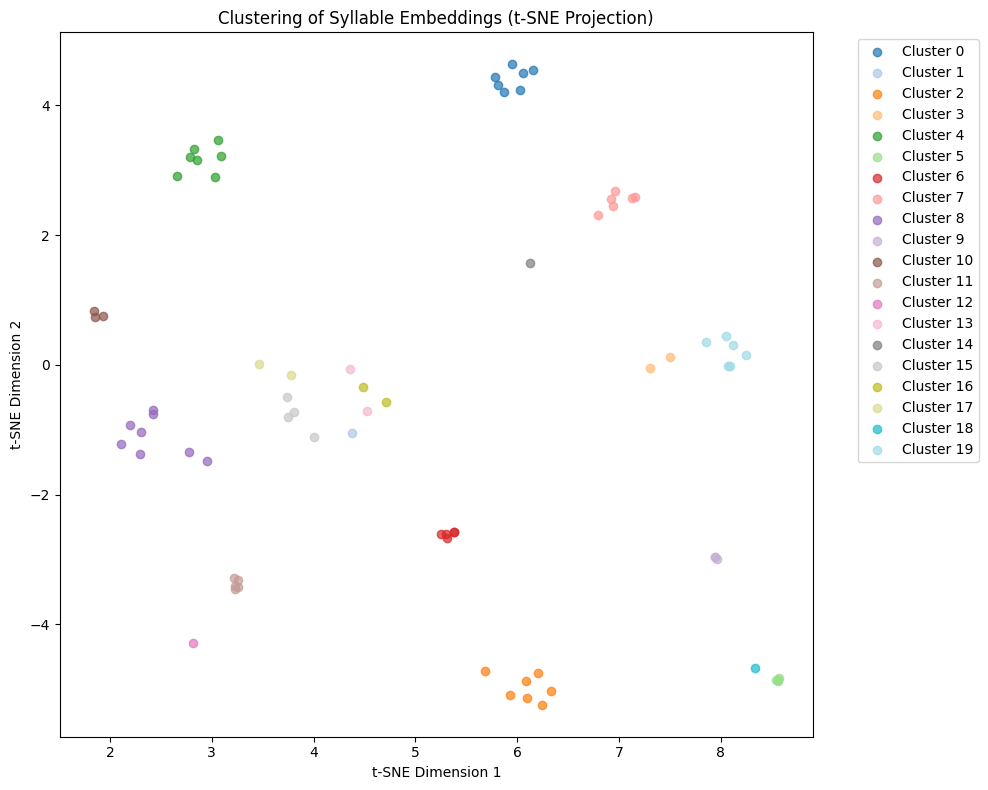

In [16]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

#PLOT CLUSTERS PRINTED IN PREVIOUS CELL
embedding_array = np.array(embedding_list)  #shape: (num_samples, embedding_dim)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embedding_2d = tsne.fit_transform(embedding_array)

colors = plt.cm.get_cmap("tab20", num_clusters)

plt.figure(figsize=(10, 8))
for cluster_id in range(num_clusters):
    indices = [i for i, c in enumerate(clusters) if c == cluster_id]
    plt.scatter(embedding_2d[indices, 0], embedding_2d[indices, 1],
                color=colors(cluster_id), label=f'Cluster {cluster_id}', alpha=0.7)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Clustering of Syllable Embeddings (t-SNE Projection)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.tight_layout()
plt.show()


In [17]:
#Save embeddings on file with one-hot-encoded mapping
syllable_autoencoder.save_embeddings(f"syllable_embeddings_one-hot-encoded_{EMBEDDINGS_DIM}.npy", syllables, tokenList=input_tokens)
syllable_autoencoder.save_embeddings(f"syllable_embeddings_{EMBEDDINGS_DIM}.npy", syllables)

In [18]:
#Load embeddings for further use
loaded_embeddings = syllable_autoencoder.load_embeddings(f"syllable_embeddings_one-hot-encoded_{EMBEDDINGS_DIM}.npy")

### Frequences and Tf-Idf

In [13]:
from collections import defaultdict

def compute_tf_idf(sequences):
    # Step 1: Initialize data structures
    eps = 1e-10
    words_tf_idf = defaultdict(lambda: {"tf": 0, "df": 0, "tf_idf": eps, "unigram_freq": eps})
    tokens_tf_idf = defaultdict(lambda: {"tf": 0, "df": 0, "tf_idf": eps, "unigram_freq": eps})

    total_sequences = len(sequences)  # Total number of sequences for IDF calculation
    total_words = 0  # Total word count across all sequences
    total_tokens = 0  # Total token count across all sequences

    # Step 2: Count TF and DF
    for sequence in sequences:
        words = sequence.split()
        seen_words = set()  # Track words seen in a single sequence
        seen_tokens = set()  # Track tokens seen in a single sequence

        for w in words:
            words_tf_idf[w]["tf"] += 1  # Increment term frequency
            total_words += 1  # Count total words

            if w not in seen_words:
                words_tf_idf[w]["df"] += 1  # Increment document frequency once per sequence
                seen_words.add(w)

            # Token-level processing
            tokens = w.split("-")
            for tok in tokens:
                tokens_tf_idf[tok]["tf"] += 1  # Increment token frequency
                total_tokens += 1  # Count total tokens

                if tok not in seen_tokens:
                    tokens_tf_idf[tok]["df"] += 1  # Increment token document frequency once per sequence
                    seen_tokens.add(tok)

    # Step 3: Compute TF-IDF and Unigram Frequency
    for w in words_tf_idf:
        df = words_tf_idf[w]["df"]
        idf = math.log((total_sequences + 1) / (df + 1))  # Smoothed IDF
        words_tf_idf[w]["tf_idf"] = words_tf_idf[w]["tf"] * idf  # Compute TF-IDF
        words_tf_idf[w]["unigram_freq"] = words_tf_idf[w]["tf"] / total_words  # Compute unigram probability

    for tok in tokens_tf_idf:
        df = tokens_tf_idf[tok]["df"]
        idf = math.log((total_sequences + 1) / (df + 1))  # Smoothed IDF
        tokens_tf_idf[tok]["tf_idf"] = tokens_tf_idf[tok]["tf"] * idf  # Compute TF-IDF
        tokens_tf_idf[tok]["unigram_freq"] = tokens_tf_idf[tok]["tf"] / total_tokens  # Compute unigram probability

    return words_tf_idf, tokens_tf_idf

In [14]:
sequences = train_y + test_y
word_results, token_results = compute_tf_idf(sequences)

# Print results
#print("Word TF-IDF Scores:")
#for word, values in word_results.items():
#    print(f"{word}: {values}")

#print("\nToken TF-IDF Scores:")
#for token, values in token_results.items():
#    print(f"{token}: {values}")

### Input tokenization

In [15]:
def inverse_mapping(tokens=output_tokens):
    inv_map = {}
    for i, t in enumerate(tokens):
        inv_map[i] = t
    return inv_map

inv_map = inverse_mapping(output_tokens)
inv_map_input = inverse_mapping(input_tokens)


In [16]:
k = 70
top_k_frequent = sorted(token_results.keys(), key=lambda x: token_results[x]["unigram_freq"], reverse=True)[:k]

def one_hot_encode_sequences(batch, vocab_size):
    #takes lists of integer tokens and outputs batches of shape: (batch_size, seq_len)
    tensor_batch = torch.tensor(batch, dtype=torch.long)
    return torch.nn.functional.one_hot(tensor_batch, num_classes=vocab_size).float()


# replace symbols with numerical labels to prepare one_hot_encoding
def tokenize_sequences(dataset, mapping=input_mapping, use_SOS=True, use_EOS=False, distortion_prob=1, top_k_frequent=top_k_frequent):
    assert distortion_prob >= 0 and distortion_prob <= 1, "Distortion probability must be between 0 and 1"
    result = []
    for i, subset in enumerate(dataset):
        res = []
        for seq in subset:
            distorted_sequence = random.random() < distortion_prob
            one_hot_encoded = [mapping["SOS"]] if use_SOS else []
            seq = seq.split(" ")
            for j, w in enumerate(seq):
                if "-" in w:
                    w = w.split("-")
                    for sign in w:
                        if distorted_sequence and sign not in top_k_frequent and sign != "?":
                            one_hot_encoded.append(mapping["SYL"])
                        else:
                            one_hot_encoded.append(mapping[sign])
                elif distorted_sequence and w not in top_k_frequent and w != "?":
                    if w == "1" or w == "2" or w == "NUM":
                        one_hot_encoded.append(mapping["NUMERAL"])
                    else:
                        one_hot_encoded.append(mapping["LOG"])
                else:
                    one_hot_encoded.append(mapping[w])

                if j != len(seq) - 1:
                    one_hot_encoded.append(mapping[" "])
                elif use_EOS:
                    one_hot_encoded.append(mapping["EOS"])
            res.append(one_hot_encoded)
        result.append(res)
    return result


#Get labelsfor each sequence to get encoded dataset
input_dim = len(input_tokens)
output_dim = len(output_tokens)

# lazy modification to avoid losing sequences
seq_train_x, seq_train_y, seq_test_x, seq_test_y= train_x, train_y, test_x, test_y
dataset = [seq_train_x, seq_test_x]
# For BRNN: src starts with SOS
train_x, test_x = tokenize_sequences(dataset, use_SOS=USE_SOS_IN_X, use_EOS=USE_EOS_IN_X, distortion_prob=0)
distorted_train_x, distorted_test_x = tokenize_sequences(dataset, use_SOS=USE_SOS_IN_X, use_EOS=USE_EOS_IN_X, distortion_prob=1)
dataset = [seq_train_y, seq_test_y]


train_y, test_y = tokenize_sequences(dataset, use_SOS=USE_SOS_IN_Y, use_EOS=USE_EOS_IN_Y, distortion_prob=0)

#Compute lengths before padding
train_lengths = torch.tensor([len(seq) for seq in train_x])
test_lengths = torch.tensor([len(seq) for seq in test_x])

#Pad the dataset for the RNN (Transformers need sequences padded to same length, GPT says)
train_x = pad_sequences(train_x)
train_y = pad_sequences(train_y)
test_x = pad_sequences(test_x)
test_y = pad_sequences(test_y)
distorted_train_x = pad_sequences(distorted_train_x)
distorted_test_x = pad_sequences(distorted_test_x)

if USE_ONE_HOT_ENCODING:
    #Convert to one-hot encoded sequences
    train_x = one_hot_encode_sequences(train_x, input_dim)
    test_x = one_hot_encode_sequences(test_x, input_dim)
    distorted_train_x = one_hot_encode_sequences(distorted_train_x, input_dim)
    distorted_test_x = one_hot_encode_sequences(distorted_test_x, input_dim)
    train_y = one_hot_encode_sequences(train_y, output_dim)
    test_y = one_hot_encode_sequences(test_y, output_dim)

p_unigram = np.zeros(len(output_tokens))
tf_idf = np.zeros(len(output_tokens))
for tok in token_results:
    p_unigram[output_mapping[tok]] = token_results[tok]["unigram_freq"]
    tf_idf[output_mapping[tok]] = token_results[tok]["tf_idf"]
p_unigram = torch.tensor(p_unigram)
tf_idf = torch.tensor(tf_idf)


In [17]:
#seq_train_x[1], train_x[1], train_y[1]

In [18]:
len(input_tokens)

354

### SentencePiece

In [ ]:
def preprocess_text(sentences, split_sequences=False, remove_hyphen=True):
    """
    Process Linear B text, handling numerals/logograms.

    :param sentences: List of Linear B sentences (e.g., ["we-we-si-jo OVISm 3 OVISf"])
    :return: Tokenized and normalized sentences
        """
    processed_sentences = []

    for sentence in sentences:
        # Tokenize by spaces (since Linear B syllabograms are typically space-separated)
        if split_sequences:
            tokens = sentence.split()
            if remove_hyphen:
                tokens = [token.replace("-", "") for token in tokens]
            processed_sentences.append(tokens)
        else:
            if remove_hyphen:
                processed_sentences.append(sentence.replace("-", ""))
            else:
                processed_sentences.append(sentence)
    return processed_sentences


sequences = preprocess_text(seq_train_y)
test_sequences = preprocess_text(seq_test_y)
sequences.extend(test_sequences)

#convert the list of sequences into a single string with spaces
text_data = "\n".join(sequences)

sp_file_name = os.path.join(prefix_path, "linear_b_spm.model")
sp_input_dim = 500 #vocab size of sentencepiece

In [ ]:
sequences[0]

In [ ]:
new_tokens = ["?", "▁?"]

train_spm = True
if train_spm:
    seq_temp_file = "temp_linear_b_text.txt"
    # Write the text data to a temporary file
    with open(seq_temp_file, "w") as f:
        f.write(text_data)

    # Now train the SentencePiece model using this temporary file
    spm.SentencePieceTrainer.train(
        input=seq_temp_file,  # Temporary file
        model_prefix=sp_file_name[:-6],         # Output model name
        vocab_size=sp_input_dim,   # Adjust based on your dataset size
        model_type='unigram',             # Use 'unigram' or 'bpe'
        pad_id=0,
        unk_id=2,
        bos_id=1, # we are forced to initialize this params
        eos_id=3, # we are forced to initialize this params
        pad_piece='<pad>',
        unk_piece='<unk>',
        bos_piece='<s>',
        eos_piece='</s>',
        user_defined_symbols=new_tokens
    )

    print("Model training complete!")


In [ ]:
def tokenize_sequences(sequences, sentence_piece_model):
    tokenized_sequences = []
    for seq in sequences:
        tokens = sp.encode(seq)
        tokenized_sequences.append(tokens)
    return tokenized_sequences

def tokenize_spaces(input):
    res = []
    for tok_list in input:
        our_tok_list = [1] # SOS
        for i, tok in enumerate(tok_list):
            tok_str = sp.id_to_piece(tok)
            if tok_str.startswith("▁") and i != 0:
                our_tok_list.append(3) # add spaces with unused token for eos!
            our_tok_list.append(tok)
        res.append(our_tok_list)
    return res
#load the trained SentencePiece model
sp = spm.SentencePieceProcessor(model_file=sp_file_name)

sequences = preprocess_text(seq_train_x)
test_sequences = preprocess_text(seq_test_x)

spm_train_x = tokenize_sequences(sequences, sp)
spm_test_x = tokenize_sequences(test_sequences, sp)

spm_train_x = tokenize_spaces(spm_train_x)
spm_test_x = tokenize_spaces(spm_test_x)
spm_lengths_train = torch.tensor([len(seq) for seq in spm_train_x])
spm_lengths_test = torch.tensor([len(seq) for seq in spm_test_x])
spm_train_x = pad_sequences(spm_train_x)
spm_test_x = pad_sequences(spm_test_x)


#### Test stuff

In [ ]:
idx = 0
tokens = [tok.item() for tok in spm_train_x[idx] if tok != 0]
tokens = [sp.id_to_piece(tok) for tok in tokens]
print(sp.encode("OVISf"))
print(tokens)

In [ ]:
print(sp.id_to_piece(6))  # Get token corresponding to ID 5
print(sp.id_to_piece(1))  # Get token corresponding to ID 0
# Decode token IDs back into text
decoded_text = sp.decode([286, 7, 4, 31, 4, 6, 1, 160, 10, 162, 38, 7, 9, 21, 7, 4])

print(decoded_text)


### What the hellish graph

In [ ]:

#Define the BRNN Model
class BRNNGraphEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout):
        super(BRNNGraphEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.brnn = nn.RNN(embed_size, hidden_size, num_layers, bidirectional=True, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size * 2, vocab_size-3)  # *2 for bidirectional
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed_embedded = pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        out, _ = self.brnn(packed_embedded)
        out, _ = pad_packed_sequence(out, batch_first=True, total_length=x.shape[1])

        out = self.fc(out)
        return self.softmax(out)

    def tok_embeddings(self, x):
        return self.embedding(x)

    def rnn_embeddings(self, x, lengths):
        embedded = self.embedding(x)
        packed_embedded = pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        out, _ = self.brnn(packed_embedded)
        out, _ = pad_packed_sequence(out, batch_first=True, total_length=x.shape[1])
        return out




In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_model(model, train_x, train_y, test_x, test_y, num_epochs=10, batch_size=32, lr=0.001, device=device):
    model.to(device)

    # Define loss and optimizer
    criterion = nn.NLLLoss(ignore_index=0)  # Ignore padding index
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Prepare DataLoader
    train_dataset = TensorDataset(train_x, train_y)
    test_dataset = TensorDataset(test_x, test_y)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            lengths = (x_batch != 0).sum(dim=1)  # Compute sequence lengths

            optimizer.zero_grad()
            output = model(x_batch, lengths)
            loss = criterion(output.view(-1, output.shape[-1]), y_batch.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Evaluate on test set
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                lengths = (x_batch != 0).sum(dim=1)

                output = model(x_batch, lengths)
                predictions = output.argmax(dim=-1)

                mask = y_batch != 0  # Ignore padding
                correct += (predictions[mask] == y_batch[mask]).sum().item()
                total += mask.sum().item()

        accuracy = correct / total if total > 0 else 0
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}, Test Accuracy: {accuracy:.4f}")

    print("Training complete!")


In [ ]:
def visualize_embeddings(embeddings, method='t-SNE'):
    """
    Visualizes the embeddings using either PCA or t-SNE, and optionally adds labels from `input_tokens`.

    Arguments:
        embeddings: The node embeddings to visualize.
        labels: The labels for coloring the embeddings (optional).
        method: The dimensionality reduction method ('PCA' or 't-SNE').
        input_tokens: A list of token labels (words) to display next to the points.
    """
    # Apply dimensionality reduction (PCA or t-SNE)
    if method == 'PCA':
        pca = PCA(n_components=2)
        reduced_embeddings = pca.fit_transform(embeddings)
    elif method == 't-SNE':
        tsne = TSNE(n_components=2)
        reduced_embeddings = tsne.fit_transform(embeddings)

    # Plot the reduced embeddings
    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=30)

    plt.title(f"Token Embeddings Visualization ({method})")
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()


In [ ]:
model = BRNNGraphEmbedding(len(input_tokens)-1, EMBEDDINGS_DIM, 2*EMBEDDINGS_DIM, 8, 0.2)
train_model(model, train_x, train_y, test_x, test_y, num_epochs=10)


In [ ]:
seq = 'a-e-i-o-u-da-de-di-do-du-ja-je-jo-ka-ke-ki-ko-ku-ma-me-mi-mo-mu-na-ne-ni-no-nu-pa-pe-pi-po-pu-qa-qe-qi-qo-ra-re-ri-ro-ru-sa-se-si-so-su-ta-te-ti-to-tu-wa-we-wi-wo-za-ze-zo-ha-ai-au-dwo-nwa-phu-pte-rya-rai-ryo-tya'
seq = (tokenize_sequences([[seq]], use_SOS=False, use_EOS=False))[0][0]
length = torch.tensor([len(seq)]).to(device)
seq += [0] * (train_x.shape[1] - len(seq))
seq = torch.tensor(seq).unsqueeze(0).to(device)


emb = model.tok_embeddings(seq).cpu().detach()
print(emb.shape)

rnn_emb = model.rnn_embeddings(seq, length).cpu().detach()
print(emb.shape)


In [ ]:
emb = emb.squeeze(0)
emb = emb[:length[0].item(), :]
emb = emb.numpy()

In [ ]:
rnn_emb = rnn_emb.squeeze(0)
rnn_emb = rnn_emb[:length[0].item(), :]
rnn_emb = rnn_emb.numpy()

In [ ]:
visualize_embeddings(emb)

In [ ]:
visualize_embeddings(rnn_emb)

In [ ]:
pip install torch_geometric

In [ ]:
import torch
from torch_geometric.data import Data

# Define node features (5 nodes, 3 features each)
x = torch.tensor([
    [1.0, 2.0, 3.0],
    [4.0, 5.0, 6.0],
    [7.0, 8.0, 9.0],
    [10.0, 11.0, 12.0],
    [13.0, 14.0, 15.0]
], dtype=torch.float)

# Define edge index (4 edges, where each column is a pair of (source, target) nodes)
edge_index = torch.tensor([
    [0, 1, 2, 3],  # source nodes
    [1, 2, 3, 4]   # target nodes
], dtype=torch.long)

# Define edge attributes (optional)
edge_attr = torch.tensor([
    [0.5],  # weight of edge (0 -> 1)
    [0.6],  # weight of edge (1 -> 2)
    [0.7],  # weight of edge (2 -> 3)
    [0.8]   # weight of edge (3 -> 4)
], dtype=torch.float)

# Define node labels (optional, for node classification)
y = torch.tensor([0, 1, 0, 1, 0], dtype=torch.long)

# Create Data object
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

print(data)


In [ ]:
input_dim

### Word Embedding


In [19]:
!pip install fasttext


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [20]:
import re
import fasttext
import os

class LinearBWordEmbedding:
    def __init__(self,
                 model_path=os.path.join(os.path.join(prefix_path, "fasttext/"), f"linearb_fasttext_model_{EMBEDDINGS_DIM}.bin"),
                 train_data_path="linearb_train.txt",
                 model='skipgram',
                 dim=EMBEDDINGS_DIM,
                 ws=3,
                 min_count=1,
                 epoch=500,
                 lr=0.1,
                 minn=1,
                 maxn=4,
                 neg=5,
                 loss='softmax',
                 bucket=2000000,
                 thread=4,
                 t=0.0001,
                 word_ngrams=1,
                 verbose=2
                ):
        self.model_path = model_path
        self.train_data_path = train_data_path
        self.model = None

        self.params = {
            'model': model,
            'dim': dim,
            'ws': ws,
            'minCount': min_count,
            'epoch': epoch,
            'lr': lr,
            'minn': minn,
            'maxn': maxn,
            'neg': neg,
            'loss': loss,
            'bucket': bucket,
            'thread': thread,
            't': t,
            'wordNgrams': word_ngrams,
            'verbose': verbose
        }

    def preprocess_text(self, sentences):
        processed = []
        uppercase_pattern = re.compile(r'[A-Z]')
        digits_only_pattern = re.compile(r'^\d+$')

        for sentence in sentences:
            tokens = sentence.split()
            filtered_tokens = []
            for token in tokens:
                token_no_hyphen = token.replace('-', '')
                if uppercase_pattern.search(token_no_hyphen):
                    continue
                if digits_only_pattern.match(token_no_hyphen):
                    continue
                filtered_tokens.append(token_no_hyphen)
            processed.append(filtered_tokens)
        return processed

    def _write_train_data(self, sentences):
        with open(self.train_data_path, 'w', encoding='utf-8') as f:
            for tokens in sentences:
                f.write(' '.join(tokens) + '\n')

    def train(self, sentences):
        tokenized = self.preprocess_text(sentences)
        self._write_train_data(tokenized)
        self.model = fasttext.train_unsupervised(
            input=self.train_data_path,
            model=self.params['model'],
            dim=self.params['dim'],
            ws=self.params['ws'],
            minCount=self.params['minCount'],
            epoch=self.params['epoch'],
            lr=self.params['lr'],
            minn=self.params['minn'],
            maxn=self.params['maxn'],
            neg=self.params['neg'],
            loss=self.params['loss'],
            bucket=self.params['bucket'],
            thread=self.params['thread'],
            t=self.params['t'],
            wordNgrams=self.params['wordNgrams'],
            verbose=self.params['verbose']
        )
        # Optional: remove training data file after training
        os.remove(self.train_data_path)

    def save_model(self, path=None):  #saves to default path 'linearb_fasttext_model.bin'
        if self.model:
            save_path = path if path else self.model_path
            self.model.save_model(save_path)
        else:
            print("No model trained yet.")

    def load_model(self, path=None):  #loads from default path 'linearb_fasttext_model.bin'
        load_path = path if path else self.model_path
        self.model = fasttext.load_model(load_path)

    def get_vector(self, word):
        if self.model:
            return self.model.get_word_vector(word)
        return None

    def find_nearest_neighbors(self, word, k=5):
        if self.model:
            return self.model.get_nearest_neighbors(word, k)
        return None

embedding_model = LinearBWordEmbedding()

#traininig the model
#embedding_model.train(sequences)
#embedding_model.save_model()
embedding_model.load_model() 

#get some nearest neighbors
neighbors = embedding_model.find_nearest_neighbors("konoso", k=10)
print(f"Nearest neighbors for 'konoso': {neighbors}")

neighbors = embedding_model.find_nearest_neighbors("potinija", k=10) #get words similar to "mistress"
print(f"Nearest neighbors for 'potinija': {neighbors}\n")


def nearest_neighbors_from_vector(model, vector, k=10):
    all_words = model.model.get_words()
    similarities = []
    for w in all_words:
        w_vec = model.get_vector(w)
        sim = np.dot(vector, w_vec) / (np.linalg.norm(vector) * np.linalg.norm(w_vec))
        similarities.append((sim, w))
    similarities.sort(reverse=True)
    return similarities[:k]

Nearest neighbors for 'konoso': [(0.6594921350479126, 'kumonoso'), (0.6537270545959473, 'konosode'), (0.6365762948989868, 'konosija'), (0.5780808329582214, 'konosijo'), (0.5686375498771667, 'kononipi'), (0.5430461764335632, 'nosiro'), (0.49234628677368164, 'kono'), (0.4802187979221344, 'diso'), (0.47665509581565857, 'konija'), (0.47106119990348816, 'koso')]
Nearest neighbors for 'potinija': [(0.7025516033172607, 'potinijawe'), (0.6799739003181458, 'potinijaweja'), (0.6756334900856018, 'potinijawijo'), (0.6643137335777283, 'sitopotinija'), (0.6455649137496948, 'upojopotinija'), (0.644006609916687, 'erewijopotinija'), (0.6003291010856628, 'potinijaweijo'), (0.5768953561782837, 'atanapotinija'), (0.5700084567070007, 'poti'), (0.5374864935874939, 'potinajo')]



In [15]:
v2 = embedding_model.get_vector("wanaka")
v3 = embedding_model.get_vector("woko")
v4 = embedding_model.get_vector("qasireu")
v5 = v2 + v3

def nearest_neighbors_from_vector(model, vector, k=10):
    all_words = model.model.get_words()
    similarities = []
    for w in all_words:
        w_vec = model.get_vector(w)
        sim = np.dot(vector, w_vec) / (np.linalg.norm(vector) * np.linalg.norm(w_vec))
        similarities.append((sim, w))
    similarities.sort(reverse=True)
    return similarities[:k]

print("\n Words nearest to this v5 are: ",nearest_neighbors_from_vector(embedding_model, v5, 10))


 Words nearest to this v5 are:  [(0.65686536, 'wanaka'), (0.6448369, 'pawoko'), (0.6283691, 'dekutuwoko'), (0.6058625, 'tokosowoko'), (0.5709508, 'damoko'), (0.5689939, 'watuoko'), (0.56247073, 'ijerowoko'), (0.55798674, 'wanakate'), (0.55643743, 'kowirowoko'), (0.5383182, 'wanakatera')]


In [16]:
class LinearB2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, pad_idx=0, max_seq_length=456):
        super(LinearB2Vec, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.max_seq_length = max_seq_length

        self.encoder = nn.RNN(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.decoder = nn.RNN(embedding_dim, hidden_dim, batch_first=True)  # decoder

        self.fc_enc = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, hidden = self.encoder(packed)
        hidden_cat = torch.cat([hidden[0], hidden[1]], dim=1)
        latent = self.fc_enc(hidden_cat)

        # decoder
        decoder_init = latent.unsqueeze(0)
        dec_out, _ = self.decoder(embedded, decoder_init)
        logits = self.fc_out(dec_out)

        # pad logits
        seq_len = logits.size(1)
        if seq_len < self.max_seq_length:
            pad_size = self.max_seq_length - seq_len
            padding = torch.zeros(logits.size(0), pad_size, logits.size(2), device=logits.device)
            logits = torch.cat([logits, padding], dim=1)
        else:
            logits = logits[:, :self.max_seq_length, :]

        return logits, latent

    def encode(self, x, lengths):
        embedded = self.embedding(x)
        packed = pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, hidden = self.encoder(packed)
        hidden_cat = torch.cat([hidden[0], hidden[1]], dim=1)
        latent = self.fc_enc(hidden_cat)
        return latent

    def top_k_similar(self, query_embedding, all_embeddings, k, emb2word, metric='cosine'):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        query_embedding = query_embedding.to(device)
        all_embeddings = all_embeddings.to(device)

        if metric == 'cosine':
            query_norm = query_embedding / query_embedding.norm(p=2)
            all_norm = all_embeddings / all_embeddings.norm(p=2, dim=1, keepdim=True)
            similarities = torch.matmul(all_norm, query_norm.t()).squeeze(1)
        elif metric == 'euclidean':
            diff = all_embeddings - query_embedding.unsqueeze(0)
            similarities = -torch.norm(diff, dim=1)
        else:
            raise ValueError("Unsupported metric")

        topk_scores, topk_indices = torch.topk(similarities, k)
        topk_indices = topk_indices.cpu()
        topk_words = [emb2word[i.item()] for i in topk_indices]

        return topk_words, topk_scores.tolist()

    def get_all_embeddings(self, word_list, max_seq_length):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        all_embeddings = []
        mapping = {}

        for i, word in enumerate(word_list):
            tokenized = fromWord2Vec(word, max_seq_length).to(device)
            length = (tokenized != 0).sum().item()
            tokenized = tokenized.unsqueeze(0)
            lengths = torch.tensor([length], dtype=torch.long)
            embedding = self.encode(tokenized, lengths).squeeze(0).cpu()
            all_embeddings.append(embedding)
            mapping[i] = word

        return torch.stack(all_embeddings, dim=0), mapping


In [17]:
#Prepare data for LB2VEC
def tokenize_sequences_LB2VEC(sequences, mapping=input_mapping, use_SOS=False, use_EOS=False):

    tokenized_dataset = []

    for seq in sequences:
        tokens = []
        if use_SOS:
            tokens.append(mapping["SOS"])

        words = seq.split(" ")
        for i, word in enumerate(words):
            if "-" in word:
                sub_words = word.split("-")
                for sub in sub_words:
                    if sub not in mapping:
                        raise KeyError(f"Token '{sub}' not found in mapping!")
                    tokens.append(mapping[sub])
            else:
                if word not in mapping:
                    raise KeyError(f"Token '{word}' not found in mapping!")
                tokens.append(mapping[word])

            # Add a space token between words (if not the last word)
            if i != len(words) - 1:
                tokens.append(mapping[" "])

        if use_EOS:
            tokens.append(mapping["EOS"])

        # Convert the list of token IDs to a PyTorch tensor.
        tokenized_dataset.append(torch.tensor(tokens, dtype=torch.long))

    return tokenized_dataset
class SequenceDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences  # This is your list of tokenized tensors.

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx]

# Custom collate_fn that pads sequences in a batch.
def collate_fn_LB2VEC(max_seq_length, pad_token=0):
    def collate_fn(batch):
        padded_batch = []
        lengths = []
        for seq in batch:
            lengths.append(seq.size(0))
            # If the sequence is shorter than max_seq_length, pad it on the right.
            pad_size = max_seq_length - seq.size(0)
            if pad_size > 0:
                padding = torch.full((pad_size,), pad_token, dtype=seq.dtype)
                padded_seq = torch.cat([seq, padding], dim=0)
            else:
                padded_seq = seq
            padded_batch.append(padded_seq)
            lengths_t = torch.tensor(lengths)
        return torch.stack(padded_batch, dim=0), lengths_t
    return collate_fn

def fromWord2Vec(word, max_seq_length):
    res = tokenize_sequences_LB2VEC([word])
    sequence = res[0]  # This is a tensor representing the tokenized word.

    seq_len = sequence.size(0)
    if seq_len < max_seq_length:
        pad_size = max_seq_length - seq_len
        padding = torch.zeros(pad_size, dtype=sequence.dtype)
        sequence = torch.cat([sequence, padding], dim=0)
    elif seq_len > max_seq_length:
        sequence = sequence[:max_seq_length]

    return sequence

def getAllWords(sequences):
    words = set()
    for seq in sequences:
        seq = seq.split(" ")
        for w in seq:
            words.add(w)
    return list(words)


tokenized = tokenize_sequences_LB2VEC(sequences)
max_seq_length = max(seq.size(0) for seq in tokenized)
dataset = SequenceDataset(tokenized)
collate_fn = collate_fn_LB2VEC(max_seq_length)
data_loader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
words = getAllWords(sequences)
print(words[:10])

['a-ko-ra-jo', 'ma-ra', 'au-to', 'pi-ri-ja-o', 'o-du-we', 'po-ki-ro-nu-ka', 'tu-we-ta', 'sa-zo', 'da-i-wo-wo', 'we-je-ke-ha']


In [18]:
LB2vec_model = LinearB2Vec(len(input_tokens), EMBEDDINGS_DIM, EMBEDDINGS_DIM)
optimizer = optim.Adam(LB2vec_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LB2vec_model.to(device)
epochs = 10
for epoch in range(epochs):
    total_loss = 0.0
    for batch, lengths in data_loader:
        # Move data to the GPU
        batch = batch.to(device)

        optimizer.zero_grad()
        logits, _ = LB2vec_model(batch, lengths)
        logits_flat = logits.view(-1, len(input_tokens))
        targets_flat = batch.view(-1)
        loss = criterion(logits_flat, targets_flat)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

Epoch 1/10, Loss: 0.5441
Epoch 2/10, Loss: 0.0320
Epoch 3/10, Loss: 0.0139
Epoch 4/10, Loss: 0.0061
Epoch 5/10, Loss: 0.0032
Epoch 6/10, Loss: 0.0017
Epoch 7/10, Loss: 0.0009
Epoch 8/10, Loss: 0.0006
Epoch 9/10, Loss: 0.0004
Epoch 10/10, Loss: 0.0003


In [28]:
# Use embeddings
all_embeddings, emb2word = LB2vec_model.get_all_embeddings(words, max_seq_length)

query = "po-ti-ni-ja"
query_seq = fromWord2Vec(query, max_seq_length).unsqueeze(0).to(device)  #vectorize the word through tokenization
query_len = torch.tensor([(query_seq != 0).sum().item()], dtype=torch.long).to(device)
query_embedding = LB2vec_model.encode(query_seq, query_len) 
neighbors, scores = LB2vec_model.top_k_similar(query_embedding, all_embeddings, k=11, emb2word=emb2word, metric="cosine")
for n, s in zip(neighbors, scores):
    print(n,s)

query = "ko-no-so"
query_seq = fromWord2Vec(query, max_seq_length).unsqueeze(0).to(device)  #vectorize the word through tokenization
query_len = torch.tensor([(query_seq != 0).sum().item()], dtype=torch.long).to(device)
query_embedding = LB2vec_model.encode(query_seq, query_len)
neighbors, scores = LB2vec_model.top_k_similar(query_embedding, all_embeddings, k=11, emb2word=emb2word, metric="cosine")
for n, s in zip(neighbors, scores):
    print(n,s)

po-ti-ni-ja 1.0000001192092896
po-ti-ni-ja-we-ja 0.9680911302566528
po-si-da-e-ja 0.9603016376495361
po-so-re-ja 0.9535226225852966
po-ni-ke-ja 0.9515949487686157
po-pu-re-ja 0.9459639191627502
po-re-no-zo-te-ri-ja 0.9432565569877625
po-ro-e-ke-te-ri-ja 0.9404106140136719
po-ni-ki-ja 0.9383034706115723
po-qe-wi-ja 0.9265150427818298
po-ni-ja-ja 0.916567862033844
ko-no-so 0.9999999403953552
ko-me-no 0.9324777126312256
ko-to-na-no-no 0.930557131767273
ko-to-no 0.9266769289970398
ko-ro-tu-no 0.9254539608955383
ko-i-no 0.9241381287574768
ko-tu-ryo 0.9233684539794922
ko-no-si-jo 0.9208793640136719
ko-no-so-de 0.9206832051277161
ko-to-i-na 0.9180614948272705
ko-ri-jo 0.9174559116363525


#### TESTS

In [26]:
sp = spm.SentencePieceProcessor(model_file='linear_b.model')
#TEST4LB2VEC
all_embeddings, emb2word = LB2vec_model.get_all_embeddings(words, 456)
aminisijo = fromWord2Vec("a-mi-ni-si-jo", 456).unsqueeze(0)
aminisija = fromWord2Vec("a-mi-ni-si-ja", 456).unsqueeze(0)
korisijo = fromWord2Vec("ko-ri-si-jo", 456).unsqueeze(0)
aminisijo = aminisijo.to(device)
aminisija = aminisija.to(device)
korisijo = korisijo.to(device)
length = torch.tensor([aminisijo.size(0)])

male_name = LB2vec_model.encode(aminisijo, length)
female_name = LB2vec_model.encode(aminisija, length)
king = LB2vec_model.encode(korisijo, length)

hopefully_queen = male_name + king - female_name
print(LB2vec_model.top_k_similar(king, all_embeddings, 150, emb2word))


TypeError: LinearB2Vec.get_all_embeddings() missing 1 required positional argument: 'max_seq_length'

In [ ]:
embedding_model.find_nearest_neighbors("a-ta-ra-?-jo", top_n=5)

In [27]:


aminisijo = np.sum(embedding_model.get_vector(sp.encode_as_pieces("aminisijo")))
aminisija = np.sum(embedding_model.get_vector(sp.encode_as_pieces("aminisija")))
korisijo = np.sum(embedding_model.get_vector(sp.encode_as_pieces("korisijo")))

print(korisijo, aminisijo.shape, aminisija.shape)

hopefully_korisija = korisijo + aminisijo - aminisija
embedding_model.find_nearest_neighbors_to_embedding(hopefully_queen, top_n=10)



OSError: Not found: "linear_b.model": No such file or directory Error #2

In [ ]:

embedding_model.check_meaningful_embeddings("_korisijo", "_aminisijo", "_aminisija", top_n=10)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

def analyze_embedding_clusters(embedding_model, num_clusters=5, method="pca"):
    """
    Cluster and visualize Linear B word embeddings.

    :param embedding_model: Trained Word2Vec/FastText model
    :param num_clusters: Number of clusters for K-Means
    :param method: "pca" or "tsne" for dimensionality reduction
    """
    # Extract words and corresponding vectors
    words = list(embedding_model.model.wv.index_to_key)
    vectors = np.array([embedding_model.get_vector(word) for word in words if embedding_model.get_vector(word) is not None])

    # Reduce dimensions (PCA or t-SNE)
    if method == "pca":
        reduced_vectors = PCA(n_components=2).fit_transform(vectors)
    elif method == "tsne":
        reduced_vectors = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(vectors)
    else:
        raise ValueError("Invalid method. Use 'pca' or 'tsne'.")

    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(vectors)

    # Use a color map with as many colors as clusters
    colors = plt.cm.get_cmap("tab20", num_clusters)

    # Plot results
    plt.figure(figsize=(10, 8))

    # Plot each cluster
    for cluster_id in range(num_clusters):
        indices = [i for i, c in enumerate(labels) if c == cluster_id]
        plt.scatter(reduced_vectors[indices, 0], reduced_vectors[indices, 1],
                    color=colors(cluster_id), label=f'Cluster {cluster_id}', alpha=0.7)

    # Move the legend outside of the plot and remove the colorbar
    plt.legend(title="Clusters", bbox_to_anchor=(1.05, 0.5), loc='center left', fontsize=9)

    # Annotate some points (adjust the number of labels)
    for i, word in enumerate(words):
        #if i % 10 == 0:  # Annotate every 10th word
            plt.annotate(word, (reduced_vectors[i, 0], reduced_vectors[i, 1]), fontsize=9)

    # Add title and show plot
    plt.title(f"Word Embedding Clusters using {method.upper()}")
    plt.tight_layout()  # Adjust layout to accommodate the legend
    plt.show()

    # Print the words in each cluster
    for cluster_id in range(num_clusters):
        print(f"\nCluster {cluster_id}:")
        indices = [i for i, c in enumerate(labels) if c == cluster_id]
        cluster_words = [words[i] for i in indices]
        print(cluster_words)

# Run the clustering visualization with desired number of clusters
analyze_embedding_clusters(embedding_model, num_clusters=15, method="tsne")


### Architecture

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SqueezeExcitationFusion(nn.Module):
    def __init__(self, d_model, reduction_ratio=16):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool1d(1)  #avg pooling (batch, d_model, 1)

        #connected layers to model interactions
        self.excitation = nn.Sequential(
            nn.Linear(d_model, d_model // reduction_ratio),  # Reduce dimensionality
            nn.ReLU(),
            nn.Linear(d_model // reduction_ratio, d_model),  # Restore dimensionality
            nn.Sigmoid()  # Normalize importance scores between 0 and 1
        )

    def forward(self, token_emb, word_emb, phon_emb):
        #Concatenate embeddings along the feature dimension
        fusion_emb = token_emb + phon_emb #(batch, seq, d_model)
        fusion_emb = fusion_emb + word_emb if USE_WORD_EMB else fusion_emb

        #Squeeze: Compute global context (reduce across sequence dimension)
        squeeze_emb = self.squeeze(fusion_emb.permute(0, 2, 1))  # (batch, d_model, 1)
        squeeze_emb = squeeze_emb.view(squeeze_emb.size(0), -1)  # Flatten to (batch, d_model)

        #Excitation: Generate importance weights
        attention_weights = self.excitation(squeeze_emb).unsqueeze(1)  # (batch, 1, d_model)

        #Scale embeddings by learned importance scores
        fused_emb = fusion_emb * attention_weights  # Adaptive weighting

        return fused_emb

class TFIDF_SequeezeExcitationFusion(SqueezeExcitationFusion): #change forward function to use tf-idf and unigrams
    def forward(self, token_emb, tfidf, unigram):
        fusion_emb = token_emb + tfidf + unigram
        squeeze_emb = self.squeeze(fusion_emb.permute(0, 2, 1)) 
        squeeze_emb = squeeze_emb.view(squeeze_emb.size(0), -1)  
        attention_weights = self.excitation(squeeze_emb).unsqueeze(1)  
        fused_emb = fusion_emb * attention_weights  
        return fused_emb
        


In [22]:
#BRNN Allowing also for one-hot encoding
class BRNNTextInfiller(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, num_heads, dropout):
        super(BRNNTextInfiller, self).__init__()
        self.use_one_hot = USE_ONE_HOT_ENCODING

        input_size = vocab_size if self.use_one_hot else embed_size

        if not self.use_one_hot:
            self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)

        self.brnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout
        )

        self.fc = nn.Linear(hidden_size * 2, vocab_size - 4)  # output layer
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x, lengths, word_emb=None, phon_emb=None):
        if not self.use_one_hot:
            x = self.embedding(x)  # Shape: (batch, seq_len, embed_size)
        # else: x is already one-hot: shape (batch, seq_len, vocab_size)

        packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        out, _ = self.brnn(packed)
        out, _ = pad_packed_sequence(out, batch_first=True, total_length=x.shape[1])

        out = self.fc(out)
        return self.softmax(out)


In [49]:

#Define the BRNN Model
class BRNNTextInfiller(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout):
        super(BRNNTextInfiller, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.brnn = nn.RNN(embed_size, hidden_size, num_layers, bidirectional=True, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size * 2, vocab_size-4)  # *2 for bidirectional
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x, lengths, word_emb, phon_emb):
        embedded = self.embedding(x)
        packed_embedded = pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        out, _ = self.brnn(packed_embedded)
        out, _ = pad_packed_sequence(out, batch_first=True, total_length=x.shape[1])
        out = self.fc(out)
        return self.softmax(out)


In [50]:
#SE FUSION
class BRNNTextInfiller(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout):
        super(BRNNTextInfiller, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.se_fusion = SqueezeExcitationFusion(embed_size)
        self.brnn = nn.RNN(embed_size, hidden_size, num_layers, bidirectional=True, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size * 2, vocab_size-4)  # *2 for bidirectional
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x, lengths, word_emb, phon_emb):
        embedded = self.embedding(x)
        fused = self.se_fusion(embedded, word_emb, phon_emb)
        packed_embedded = pack_padded_sequence(fused, lengths.cpu(), batch_first=True, enforce_sorted=False)
        out, _ = self.brnn(packed_embedded)
        out, _ = pad_packed_sequence(out, batch_first=True, total_length=x.shape[1])
        out = self.fc(out)
        return self.softmax(out)        

In [51]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_len=5000):
        """
        Sinusoidal positional encoding.

        Args:
            d_model: Hidden dimension of the embeddings.
            max_seq_len: Maximum sequence length supported.
        """
        super(PositionalEncoding, self).__init__()

        # Create a matrix (max_seq_len, d_model) with sinusoidal values
        position = torch.arange(max_seq_len).unsqueeze(1)  # Shape: (max_seq_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))

        # Compute sinusoidal values
        pe = torch.zeros(max_seq_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)  # Apply sin to even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # Apply cos to odd indices

        # Register buffer so it's not a model parameter (no gradient updates needed)
        self.register_buffer("pe", pe.unsqueeze(0))  # Shape: (1, max_seq_len, d_model)

    def forward(self, x):
        """
        Args:
            x: Input tensor of shape (batch, seq_len, d_model)

        Returns:
            Tensor with positional encodings added.
        """
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :]


class TransformerTextInfiller(nn.Module):
    def __init__(self, vocab_size, d_model=512, num_heads=8, num_layers=6, dim_feedforward=2048, dropout=0.1, max_seq_len=100, eos_token=2):
        super(TransformerTextInfiller, self).__init__()
        self.eos_token = eos_token  # EOS token value

        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_len)

        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True  # Important! Now input shape is (batch, seq, features)
        )

        self.fc = nn.Linear(d_model, vocab_size - 4)  # Output layer
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, src, src_lengths, tgt, tgt_lengths, word_emb, phon_emb):
        """
        Forward pass of the Transformer model.
        - src: The input sequence with missing tokens (batch, seq_len).
        - tgt: The sequence to decode (batch, seq_len).
        - src_lengths: Lengths of the source sequences (for padding mask).
        - tgt_lengths: Lengths of the target sequences (for padding mask).
        """

        src_key_padding_mask = self.create_padding_mask(src, mask_unknown=True)
        tgt_key_padding_mask = self.create_padding_mask(tgt)
        tgt_mask = self.create_causal_mask(tgt, self.transformer.nhead)

        src_embedded = self.positional_encoding(self.embedding(src))
        tgt_embedded = self.positional_encoding(self.embedding(tgt))

        out = self.transformer(
            src_embedded,
            tgt_embedded,
            tgt_mask=tgt_mask,
            src_key_padding_mask=src_key_padding_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            tgt_is_causal=True
        )

        return self.softmax(self.fc(out))

    def generate(self, src, src_lengths, word_emb, phon_emb):
        """
        Autoregressive generation for inference.

        Args:
            src (Tensor): Source sequence, shape: [batch_size, seq_len]

        Returns:
            Tensor: Generated sequence, shape: [batch_size, seq_len]
        """
        batch_size, seq_length = src.size()
        src_key_padding_mask = self.create_padding_mask(src)
        tgt_key_padding_mask = self.tgt_key_padding_mask_from_src(src_key_padding_mask)
        src_key_padding_mask = self.create_padding_mask(src, mask_unknown=True)
        pos_indices = torch.arange(seq_length + 1, device=src.device).unsqueeze(0).expand(batch_size, -1)

        tgt = torch.full((batch_size, 1), 1, dtype=torch.long, device=src.device)  # [SOS]
        temp = torch.cat([src.clone(), torch.zeros((src.shape[0], 1), dtype=torch.int, device=src.device)], dim=1)
        tgt_mask = self.create_causal_mask(temp)

        src_embedded = self.positional_encoding(self.embedding(src))
        memory = self.transformer.encoder(src_embedded, src_key_padding_mask=src_key_padding_mask)
        result = []

        for i in range(seq_length + 1):  # Generate up to input length
            tgt_embedded = self.positional_encoding(self.embedding(tgt))
            tgt_mask_cur = tgt_mask[:, :i + 1, :i + 1]  # Shape: [batch_size*num_heads, i+1, i+1]
            tgt_key_padding_mask_cur = tgt_key_padding_mask[:, :i + 1]  # Shape: [batch_size, i+1]

            out = self.transformer.decoder(
                tgt_embedded,
                memory,
                tgt_mask=tgt_mask_cur,
                tgt_key_padding_mask=tgt_key_padding_mask_cur,
                tgt_is_causal=True
            )

            out = self.softmax(self.fc(out))[:, -1, :]
            result.append(out)
            next_token = out.argmax(dim=-1, keepdim=True)
            tgt = torch.cat([tgt, next_token], dim=1)

        result = torch.stack(result, dim=1)
        return result

    # masks padding
    def create_padding_mask(self, src, padding_token=0, unknown_token=None, mask_unknown=False):
        """
        Create a key padding mask that masks both padding and unknown tokens.

        Args:
            src (torch.Tensor): Input tensor of shape (batch_size, seq_len).
            unknown_token (int, optional): Token value to be masked as "ignored".
            padding_token (int, optional): Padding token value (default: 0).

        Returns:
            torch.Tensor: Boolean mask of shape (batch_size, seq_len), where
                          True = "ignore this token", False = "keep it".
        """
        if unknown_token is None and mask_unknown:
            unknown_token = src.max()  # Default: assume max value is the unknown token

        return (src == padding_token) | (src == unknown_token) if mask_unknown else (src == padding_token)# Mask both padding & unknowns

    # causal mask
    def create_causal_mask(self, tgt, num_heads=1):
        """
        Create a causal mask (upper triangular) for the target sequence.
        - seq_len: The length of the target sequence.
        - batch_size: The batch size (to repeat the mask for each instance in the batch).
        - num_heads: The number of attention heads (to repeat the mask for each attention head).
        """
        batch_size, seq_len = tgt.shape
        # Create the upper triangular mask (causal mask)
        mask = torch.triu(torch.ones(seq_len, seq_len, device=tgt.device), diagonal=1)

        # Expand the mask for batch size and number of heads
        mask = mask.unsqueeze(0).unsqueeze(1)  # Add batch and heads dimensions
        mask = mask.expand(batch_size, num_heads, seq_len, seq_len)  # Repeat for batch and heads
        mask = mask.reshape(batch_size * num_heads, seq_len, seq_len)
        return mask.bool()

    def tgt_key_padding_mask_from_src(self, src_key_padding_mask):
        # Step 1: Find first True and change it to False
        modified_mask = src_key_padding_mask.clone()
        for i in range(modified_mask.shape[0]):
            first_true = (modified_mask[i] == True).nonzero(as_tuple=True)[0]
            if first_true.numel() > 0:  # If there is at least one True
                modified_mask[i, first_true[0]] = False

        # Step 2: Append False at the end of each sequence
        modified_mask = torch.cat([modified_mask, torch.full((modified_mask.shape[0], 1), True, dtype=torch.bool, device=modified_mask.device)], dim=1)
        return modified_mask



In [52]:
# SQUEEZE EXCITATION FUSION
class TransformerTextInfiller(nn.Module):
    def __init__(self, vocab_size, d_model=512, num_heads=8, num_layers=6, dim_feedforward=2048, dropout=0.1, max_seq_len=100, eos_token=2):
        super(TransformerTextInfiller, self).__init__()
        self.eos_token = eos_token  # EOS token value

        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_len)

        self.se_fusion = SqueezeExcitationFusion(d_model)

        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True  # Important! Now input shape is (batch, seq, features)
        )

        self.fc = nn.Linear(d_model, vocab_size - 1)  # Output layer
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, src, src_lengths, tgt, tgt_lengths, word_emb, phon_emb):
        """
        Forward pass of the Transformer model.
        - src: The input sequence with missing tokens (batch, seq_len).
        - tgt: The sequence to decode (batch, seq_len).
        - src_lengths: Lengths of the source sequences (for padding mask).
        - tgt_lengths: Lengths of the target sequences (for padding mask).
        """

        src_key_padding_mask = self.create_padding_mask(src, mask_unknown=True)
        tgt_key_padding_mask = self.create_padding_mask(tgt)
        tgt_mask = self.create_causal_mask(tgt, self.transformer.nhead)

        src_embedded = self.positional_encoding(self.embedding(src))
        tgt_embedded = self.positional_encoding(self.embedding(tgt))

        src_embedded = self.se_fusion(src_embedded, word_emb, phon_emb)
        tgt_word_emb = torch.cat([torch.zeros((word_emb.size(0), 1, word_emb.size(2)), device=word_emb.device), word_emb], dim=1)
        tgt_phon_emb = torch.cat([torch.zeros((phon_emb.size(0), 1, phon_emb.size(2)), device=phon_emb.device), phon_emb], dim=1)
        tgt_embedded = self.se_fusion(tgt_embedded, tgt_word_emb, tgt_phon_emb)


        out = self.transformer(
            src_embedded,
            tgt_embedded,
            tgt_mask=tgt_mask,
            src_key_padding_mask=src_key_padding_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            tgt_is_causal=True
        )

        return self.softmax(self.fc(out))

    def generate(self, src, src_lengths, word_emb, phon_emb):
        """
        Autoregressive generation for inference.

        Args:
            src (Tensor): Source sequence, shape: [batch_size, seq_len]

        Returns:
            Tensor: Generated sequence, shape: [batch_size, seq_len]
        """
        batch_size, seq_length = src.size()
        src_key_padding_mask = self.create_padding_mask(src)
        tgt_key_padding_mask = self.tgt_key_padding_mask_from_src(src_key_padding_mask)
        src_key_padding_mask = self.create_padding_mask(src, mask_unknown=True)
        pos_indices = torch.arange(seq_length + 1, device=src.device).unsqueeze(0).expand(batch_size, -1)

        tgt = torch.full((batch_size, 1), 1, dtype=torch.long, device=src.device)  # [SOS]
        temp = torch.cat([src.clone(), torch.zeros((src.shape[0], 1), dtype=torch.int, device=src.device)], dim=1)
        tgt_mask = self.create_causal_mask(temp)

        src_embedded = self.positional_encoding(self.embedding(src))
        memory = self.transformer.encoder(src_embedded, src_key_padding_mask=src_key_padding_mask)
        result = []

        src_embedded = self.se_fusion(src_embedded, word_emb, phon_emb)
        tgt_word_emb = torch.cat([torch.zeros((word_emb.size(0), 1, word_emb.size(2)), device=word_emb.device), word_emb], dim=1)
        tgt_phon_emb = torch.cat([torch.zeros((phon_emb.size(0), 1, phon_emb.size(2)), device=phon_emb.device), phon_emb], dim=1)


        for i in range(seq_length + 1):  # Generate up to input length
            tgt_embedded = self.positional_encoding(self.embedding(tgt))

            tgt_word_emb_cur = tgt_word_emb[:, :i+1, :]
            tgt_phon_emb_cur = tgt_phon_emb[:, :i+1, :]
            tgt_embedded = self.se_fusion(tgt_embedded, tgt_word_emb_cur, tgt_phon_emb_cur)

            tgt_mask_cur = tgt_mask[:, :i + 1, :i + 1]  # Shape: [batch_size*num_heads, i+1, i+1]
            tgt_key_padding_mask_cur = tgt_key_padding_mask[:, :i + 1]  # Shape: [batch_size, i+1]

            out = self.transformer.decoder(
                tgt_embedded,
                memory,
                tgt_mask=tgt_mask_cur,
                tgt_key_padding_mask=tgt_key_padding_mask_cur,
                tgt_is_causal=True
            )

            out = self.softmax(self.fc(out))[:, -1, :]
            result.append(out)
            next_token = out.argmax(dim=-1, keepdim=True)
            tgt = torch.cat([tgt, next_token], dim=1)

        result = torch.stack(result, dim=1)
        return result

    # masks padding
    def create_padding_mask(self, src, padding_token=0, unknown_token=None, mask_unknown=False):
        """
        Create a key padding mask that masks both padding and unknown tokens.

        Args:
            src (torch.Tensor): Input tensor of shape (batch_size, seq_len).
            unknown_token (int, optional): Token value to be masked as "ignored".
            padding_token (int, optional): Padding token value (default: 0).

        Returns:
            torch.Tensor: Boolean mask of shape (batch_size, seq_len), where
                          True = "ignore this token", False = "keep it".
        """
        if unknown_token is None and mask_unknown:
            unknown_token = src.max()  # Default: assume max value is the unknown token

        return (src == padding_token) | (src == unknown_token) if mask_unknown else (src == padding_token)# Mask both padding & unknowns

    # causal mask
    def create_causal_mask(self, tgt, num_heads=1):
        """
        Create a causal mask (upper triangular) for the target sequence.
        - seq_len: The length of the target sequence.
        - batch_size: The batch size (to repeat the mask for each instance in the batch).
        - num_heads: The number of attention heads (to repeat the mask for each attention head).
        """
        batch_size, seq_len = tgt.shape
        # Create the upper triangular mask (causal mask)
        mask = torch.triu(torch.ones(seq_len, seq_len, device=tgt.device), diagonal=1)

        # Expand the mask for batch size and number of heads
        mask = mask.unsqueeze(0).unsqueeze(1)  # Add batch and heads dimensions
        mask = mask.expand(batch_size, num_heads, seq_len, seq_len)  # Repeat for batch and heads
        mask = mask.reshape(batch_size * num_heads, seq_len, seq_len)
        return mask.bool()

    def tgt_key_padding_mask_from_src(self, src_key_padding_mask):
        # Step 1: Find first True and change it to False
        modified_mask = src_key_padding_mask.clone()
        for i in range(modified_mask.shape[0]):
            first_true = (modified_mask[i] == True).nonzero(as_tuple=True)[0]
            if first_true.numel() > 0:  # If there is at least one True
                modified_mask[i, first_true[0]] = False

        # Step 2: Append False at the end of each sequence
        modified_mask = torch.cat([modified_mask, torch.full((modified_mask.shape[0], 1), True, dtype=torch.bool, device=modified_mask.device)], dim=1)
        return modified_mask



In [ ]:
#ALTRI TEXTINFILLER 
class BRNNTextInfiller(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, num_heads, dropout):
        super(BRNNTextInfiller, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.se_fusion = SqueezeExcitationFusion(embed_size)
        self.brnn = nn.RNN(embed_size, hidden_size, num_layers, bidirectional=True, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size * 2, vocab_size-1)  # *2 for bidirectional
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x, lengths, word_emb, phon_emb):
        embedded = self.embedding(x)
        fused = self.se_fusion(embedded, word_emb, phon_emb)
        packed_embedded = pack_padded_sequence(fused, lengths.cpu(), batch_first=True, enforce_sorted=False)
        out, _ = self.brnn(packed_embedded)
        out, _ = pad_packed_sequence(out, batch_first=True, total_length=x.shape[1])

        out = self.fc(out)
        return self.softmax(out)

#### MASK DEBUG

In [53]:

#POSSIBILI INCUSIONI NEL CODICE: formalizzato un po' meglio il discorso delle maschere
def compute_src_mask(src, unknown_token=None):
    """
    Compute a boolean mask for the source sequence.
    Masks positions where the token equals the unknown token (default: max value in src).

    Args:
        src (torch.Tensor): The input tensor of shape (batch_size, seq_len).
        unknown_token (int, optional): Token value to be masked. Defaults to max value in src.

    Returns:
        torch.Tensor: Boolean mask of shape (batch_size, seq_len).
    """
    if unknown_token is None:
        unknown_token = src.max()  # Default: assume max value is the unknown token

    return src == unknown_token  # True where src equals unknown token

# masks unknown token
def create_attention_mask(src, unknown_token=None):
    """
    Create a seq_len x seq_len mask for attention while ignoring unknown tokens.

    Args:
        src (torch.Tensor): Input tensor of shape (batch_size, seq_len).
        unknown_token (int, optional): Token value to be ignored.

    Returns:
        torch.Tensor: Boolean mask of shape (batch_size, seq_len, seq_len).
                      True means "ignore", False means "attend".
    """
    batch_size, seq_len = src.shape

    # Compute unknown token mask
    src_mask = compute_src_mask(src, unknown_token)  # Shape: (batch_size, seq_len)

    # Create base attention mask (1s in upper triangle to mask future tokens in causal models)
    attention_mask = torch.ones((seq_len, seq_len), dtype=torch.bool).triu(1)

    # Expand unknown token mask to (batch_size, seq_len, seq_len)
    src_mask = src_mask.unsqueeze(1).expand(-1, seq_len, -1)  # Broadcast across seq_len

    # Combine masks: ignore future tokens and unknown tokens
    final_mask = attention_mask.unsqueeze(0).expand(batch_size, -1, -1) | src_mask

    return final_mask


# masks padding
def create_padding_mask(sequence, pad_token=0):
    """
    Create a padding mask for the given sequence and lengths.
    - sequence: The sequence of input tokens (batch_size, seq_len).
    - lengths: The lengths of the sequences (batch_size).
    """
    mask = sequence == pad_token
    return mask

# causal mask
def create_causal_mask(tgt, num_heads=1):
    """
    Create a causal mask (upper triangular) for the target sequence.
    - seq_len: The length of the target sequence.
    - batch_size: The batch size (to repeat the mask for each instance in the batch).
    - num_heads: The number of attention heads (to repeat the mask for each attention head).
    """
    batch_size, seq_len = tgt.shape
    # Create the upper triangular mask (causal mask)
    mask = torch.triu(torch.ones(seq_len, seq_len, device=tgt.device), diagonal=1)

    # Expand the mask for batch size and number of heads
    mask = mask.unsqueeze(0).unsqueeze(1)  # Add batch and heads dimensions
    mask = mask.expand(batch_size, num_heads, seq_len, seq_len)  # Repeat for batch and heads
    mask = mask.reshape(batch_size * num_heads, seq_len, seq_len)
    return mask.bool()
import torch

def create_padding_mask(self, src, padding_token=0, unknown_token=None, mask_unknown=False):
    """
    Create a key padding mask that masks both padding and unknown tokens.

    Args:
        src (torch.Tensor): Input tensor of shape (batch_size, seq_len).
        unknown_token (int, optional): Token value to be masked as "ignored".
        padding_token (int, optional): Padding token value (default: 0).

    Returns:
        torch.Tensor: Boolean mask of shape (batch_size, seq_len), where
                      True = "ignore this token", False = "keep it".
    """
    if unknown_token is None and mask_unknown:
        unknown_token = src.max()  # Default: assume max value is the unknown token

    return (src == padding_token) | (src == unknown_token) if mask_unknown else (src == padding_token)# Mask both padding & unknowns

# Example input
src = torch.tensor([
    [1, 2, 99, 0, 0],  # 99 and 0 should be ignored
    [4, 99, 5, 6, 0]   # 99 and 0 should be ignored
])

# Example usage
src = torch.tensor([[1, 2, 99, 0, 0], [4, 99, 5, 6, 0]])  # Assume 99 is the unknown token
#mask = create_src_key_padding_mask(src, mask_unknown=True)
#print(mask)


### Simple Architectures

In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FCBlock(nn.Module):
    """A single fully connected block with activation, dropout, and optional normalization."""
    def __init__(self, in_features, out_features, dropout, normalize):
        super(FCBlock, self).__init__()
        self.fc = nn.Linear(in_features, out_features)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.normalize = normalize
        if self.normalize:
            self.layer_norm = nn.LayerNorm(out_features)

    def forward(self, x):
        x = self.fc(x)
        if self.normalize:
            x = self.layer_norm(x)
        x = self.activation(x)
        return self.dropout(x)


class FCNTextInfiller(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout, normalize=False):
        super(FCNTextInfiller, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)

        self.fc_layers = nn.ModuleList()
        self.fc_layers.append(FCBlock(embed_size, hidden_size, dropout, normalize))  # First layer

        for _ in range(num_layers - 1):
            self.fc_layers.append(FCBlock(hidden_size, hidden_size, dropout, normalize))  # Hidden layers

        self.output_layer = nn.Linear(hidden_size, vocab_size - 4)  # Output layer
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x, lengths, word_emb=None, phon_emb=None):
        embedded = self.embedding(x)  # (batch_size, seq_len, embed_size)

        out = embedded
        for layer in self.fc_layers:
            out = layer(out)

        out = self.output_layer(out)  # (batch_size, seq_len, vocab_size - 1)
        return self.softmax(out)


In [55]:

class Conv1dLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(Conv1dLayer, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.activation = nn.ReLU()

    def forward(self, x):
        return self.activation(self.conv(x))


class ConvTextInfiller(nn.Module):
    def __init__(self, vocab_size, embed_size, num_filters, kernel_sizes, num_layers, dropout, normalize=False):
        super(ConvTextInfiller, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)

        # Convolutional layers: each kernel size gets its own Conv1D layer
        self.convs = nn.ModuleList([Conv1dLayer(embed_size, num_filters, k) for k in kernel_sizes])

        # Fully connected layers
        self.fc_layers = [FCBlock(num_filters * len(kernel_sizes), num_filters * len(kernel_sizes), dropout, normalize) for _ in range(num_layers-1)]
        self.fc_layers.append(FCBlock(num_filters * len(kernel_sizes), num_filters, dropout, normalize))
        self.fc_layers = nn.ModuleList(self.fc_layers)

        # Final output layer
        self.fc_out = nn.Linear(num_filters, vocab_size - 4)

        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x, lengths, word_emb=None, phon_emb=None):
        # Embedding lookup
        embedded = self.embedding(x)  # (B, L, E)
        embedded = embedded.permute(0, 2, 1)  # (B, E, L) for Conv1D

        # Apply convolutions
        conv_features = [conv(embedded) for conv in self.convs]
        conv_out = torch.cat(conv_features, dim=1)  # (B, C*k, L)

        conv_out = conv_out.permute(0, 2, 1)  # (B, L, C*k)

        # Fully connected layers with normalization
        for fc in self.fc_layers:
            conv_out = fc(conv_out)

        # Final output projection
        logits = self.fc_out(conv_out)
        return self.softmax(logits)


In [56]:
class ConvTextInfillerRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_filters, kernel_sizes, hidden_size, num_layers, dropout):
        super(ConvTextInfillerRNN, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)

        # Convolutional layers
        self.convs = nn.ModuleList([Conv1dLayer(embed_size, num_filters, k) for k in kernel_sizes])

        # RNN Layer (replaces FC layers)
        self.rnn = nn.RNN(
            input_size=num_filters * len(kernel_sizes),
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            bidirectional=True,
            batch_first=True
        )

        # Final output layer
        self.fc_out = nn.Linear(hidden_size * 2, vocab_size - 4)  # *2 for bidirectional

        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x, lengths, word_emb=None, phon_emb=None):
        # Embedding lookup
        embedded = self.embedding(x)  # (B, L, E)
        embedded = embedded.permute(0, 2, 1)  # (B, E, L) for Conv1D

        # Apply convolutions
        conv_features = [conv(embedded) for conv in self.convs]
        conv_out = torch.cat(conv_features, dim=1)  # (B, C*k, L)
        conv_out = conv_out.permute(0, 2, 1)  # (B, L, C*k)

        # Pack the sequence to ignore padding in RNN
        packed_input = pack_padded_sequence(conv_out, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, _ = self.rnn(packed_input)
        rnn_out, _ = pad_packed_sequence(packed_out, batch_first=True, total_length=x.shape[1])

        # Final output projection
        logits = self.fc_out(rnn_out)
        return self.softmax(logits)


In [31]:
class ConvTextInfillerRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_filters, kernel_sizes, hidden_size, num_layers, dropout):
        super(ConvTextInfillerRNN, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)

        # Convolutional layers (after RNN)
        self.convs = nn.ModuleList([Conv1dLayer(hidden_size * 2, num_filters, k) for k in kernel_sizes])  # Hidden size * 2 for bidirectional RNN

        # RNN Layer (before convolutional layers)
        self.rnn = nn.RNN(
            input_size=embed_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            bidirectional=True,
            batch_first=True
        )

        # Final output layer
        self.fc_out = nn.Linear(num_filters * len(kernel_sizes), vocab_size - 4)  # *2 for bidirectional

        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x, lengths, word_emb=None, phon_emb=None):
        # Embedding lookup
        embedded = self.embedding(x)  # (B, L, E)

        # Pack the sequence to ignore padding in RNN
        packed_input = pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, _ = self.rnn(packed_input)
        rnn_out, _ = pad_packed_sequence(packed_out, batch_first=True, total_length=x.shape[1])

        # Now apply convolutions after RNN
        rnn_out = rnn_out.permute(0, 2, 1)  # (B, H, L) -> (B, H, L) for Conv1D (H=hidden size)

        # Apply convolutions
        conv_features = [conv(rnn_out) for conv in self.convs]
        conv_out = torch.cat(conv_features, dim=1)  # (B, C*k, L)
        conv_out = conv_out.permute(0, 2, 1)  # (B, L, C*k)

        # Final output projection
        logits = self.fc_out(conv_out)
        return self.softmax(logits)


In [32]:
class BiConvTextInfiller(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, kernel_sizes=[1, 3, 5, 7], dropout=0.3):
        super(BiConvTextInfiller, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)

        #multiple forward and backward conv layers (one per kernel size)
        self.conv_fwd = nn.ModuleList([
            nn.Conv1d(embed_size, hidden_size, k, padding=k // 2) for k in kernel_sizes
        ])
        self.conv_bwd = nn.ModuleList([
            nn.Conv1d(embed_size, hidden_size, k, padding=k // 2) for k in kernel_sizes
        ])

        total_hidden = hidden_size * len(kernel_sizes) * 2  # *2 for bidirectional
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(total_hidden, vocab_size - 4)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x, lengths, word_emb=None, phon_emb=None):
        embedded = self.embedding(x).permute(0, 2, 1)  # (B, E, L)

        # Forward convolutions
        out_fwd = [F.relu(conv(embedded)) for conv in self.conv_fwd]

        # Backward convolutions (flip input)
        reversed_emb = torch.flip(embedded, dims=[2])
        out_bwd = [F.relu(conv(reversed_emb)) for conv in self.conv_bwd]
        out_bwd = [torch.flip(o, dims=[2]) for o in out_bwd]

        # Concatenate all outputs
        conv_outputs = out_fwd + out_bwd  # list of tensors: (B, H, L)
        out = torch.cat(conv_outputs, dim=1)  # (B, H * 2 * K, L)

        # Project back to vocabulary
        out = self.dropout(out.permute(0, 2, 1))  # (B, L, H')
        return self.softmax(self.fc(out))  # (B, L, V)


### Architectures for composition

In [33]:
#Define the BRNN Model for both our tokenized input and for the distorted input
class BRNNTokenizedInput(nn.Module):
    def __init__(self, input_dim, output_dim, embed_size, hidden_size, num_layers, dropout):
        super(BRNNTokenizedInput, self).__init__()
        self.embedding = nn.Embedding(input_dim, embed_size, padding_idx=0)

        self.brnn = nn.RNN(embed_size, hidden_size, num_layers, bidirectional=True, batch_first=True, dropout=dropout)


        self.fc = nn.Linear(hidden_size * 2, output_dim)  # *2 for bidirectional
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x, lengths):
        embedded = self.embedding(x)

        packed_embedded = pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)

        out, _ = self.brnn(packed_embedded)
        out, _ = pad_packed_sequence(out, batch_first=True, total_length=x.shape[1])

        out = self.fc(out)
        return self.softmax(out)


In [34]:
#Define the BRNN Model for spm
class BRNNSentencePiece(nn.Module):
    def __init__(self, input_dim, output_dim, embed_size, hidden_size, num_layers, dropout):
        super(BRNNSentencePiece, self).__init__()
        self.embedding = nn.Embedding(input_dim, embed_size, padding_idx=0)

        self.brnn = nn.RNN(embed_size, hidden_size, num_layers, bidirectional=True, batch_first=True, dropout=dropout)


        self.fc = nn.Linear(hidden_size * 2, output_dim)  # *2 for bidirectional
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x, lengths, y):
        embedded = self.embedding(x)

        packed_embedded = pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)

        out, _ = self.brnn(packed_embedded)
        out, _ = pad_packed_sequence(out, batch_first=True, total_length=y.shape[1])

        out = self.fc(out)
        return self.softmax(out)


In [35]:
import torch
import torch.nn as nn

class Composition(nn.Module):
    def __init__(self, hyperparams, device):
        super(Composition, self).__init__()

        hyperparams["model"] = "BRNNTokenizedInput"
        self.original = initialize_model(hyperparams, device)
        self.distorted = initialize_model(hyperparams, device)

        hyperparams["model"] = "BRNNSentencePiece"
        self.sentence_piece = initialize_model(hyperparams, device)

        #make weights learnable by converting them to torch.nn.Parameter
        self.w_original = nn.Parameter(torch.tensor(0.8))  #learnable weight for original model
        self.w_distorted = nn.Parameter(torch.tensor(0.1))  #learnable weight for distorted model
        self.w_sentence_piece = nn.Parameter(torch.tensor(0.1))  #learnable weight for sentence piece model

        #ensure that the weights sum up to 1 manually (soft constraint)
        assert abs(self.w_original.item() + self.w_distorted.item() + self.w_sentence_piece.item() - 1.0) < 1e-5, "Weights should sum to 1 initially."


    def forward(self, x, y, lengths, x_distorted, x_sp, x_sp_length):
        # Normalize weights (soft constraint)
        with torch.no_grad():
            total_weight = self.w_original + self.w_distorted + self.w_sentence_piece
            self.w_original.data /= total_weight
            self.w_distorted.data /= total_weight
            self.w_sentence_piece.data /= total_weight
    
        #debugging
        #print(self.w_original.item(), self.w_distorted.item(), self.w_sentence_piece.item())
    
        #get predictions (log-probabilities from each model)
        orig_logp = self.original(x, lengths)  #[batch, seq, vocab]
        distorted_logp = self.distorted(x_distorted, lengths)
        sp_logp = self.sentence_piece(x_sp, x_sp_length, y)
    
        #exponentiate to convert to probs and use the weights
        orig_p = torch.exp(orig_logp)
        distorted_p = torch.exp(distorted_logp)
        sp_p = torch.exp(sp_logp)
    
        #weighted sum in probability space
        combined_p = (
            self.w_original * orig_p +
            self.w_distorted * distorted_p +
            self.w_sentence_piece * sp_p
        )
    
        #convert back to log-probabilities for the loss
        combined_logp = torch.log(combined_p + 1e-12)  #use an epsilon to avoid log(0)
    
        return combined_logp


### Recover Word and Phonetic Embeddings

In [36]:
file_name = f"./fasttext/linearb_fasttext_model_{EMBEDDINGS_DIM}.bin"

embedding_model = LinearBWordEmbedding()
embedding_model.load_model(os.path.join(prefix_path, file_name))


In [37]:
def recover_word_embeddings(embedding_model, dataset, final_length, use_sos_in_x=USE_SOS_IN_X):
    all_embeddings = [] 

    for seq in dataset:
        seq = seq.split()  #split the sequence into words
        seq_embeddings = []  #to store embeddings for the current sequence

        for i, word in enumerate(seq):
            word_len = word.count("-") + 1  #compute the length of the word (based on '-' count)
            emb = torch.tensor(embedding_model.get_vector(word))  #get the word embedding
            # Unsqueeze the embedding to match (word_len, embedding_dim)
            emb_unsqueezed = emb.unsqueeze(0)

            emb_expanded = emb_unsqueezed.expand(word_len, -1)  # Unsqueeze and expand
            if i != len(seq) - 1:
                space_embed = torch.zeros_like(emb_unsqueezed)
                seq_embeddings.extend([emb_expanded, space_embed])  # Add to the sequence's embeddings
            else:
                seq_embeddings.append(emb_expanded)  # Add to the sequence's embeddings

        # adding zeros for SOS at the beginning of the sequence
        if use_sos_in_x:
            seq_embeddings = [torch.zeros_like(emb_unsqueezed)] + seq_embeddings

        # Concatenate embeddings along the first axis (to form the final sequence embedding) and add padding
        seq_embedding = torch.cat(seq_embeddings, dim=0)
        padding = torch.zeros((final_length - seq_embedding.shape[0], seq_embedding.shape[1]))
        seq_embedding = torch.cat([seq_embedding, padding], dim=0)  # Add padding to the end

        all_embeddings.append(seq_embedding)  # Add to the overall embeddings list

    # Convert list of sequences to a tensor
    return torch.stack(all_embeddings)  # Stacks along a new dimension (batch dimension)

## Example usage:
word_embeddings_train_x = recover_word_embeddings(embedding_model, seq_train_x, train_x.shape[1])
word_embeddings_test_x = recover_word_embeddings(embedding_model, seq_test_x, test_x.shape[1])

# Free my ram please
del embedding_model

In [38]:
syllable_autoencoder = SyllableAutoencoder()
loaded_embeddings = syllable_autoencoder.load_embeddings(f"syllable_embeddings_{EMBEDDINGS_DIM}.npy")

In [39]:
def recover_phonetic_embeddings(embedding_dict, dataset, final_length, use_sos_in_x=USE_SOS_IN_X):
    all_embeddings = []  # To store all sequence embeddings
    embed_size = len(list(embedding_dict.values())[0])  # Assuming all embeddings have the same size

    for seq in dataset:
        seq = seq.split()  # Split the sequence into words
        seq_embeddings = []  # To store embeddings for the current sequence

        for i, word in enumerate(seq):
            for syllable in word.split("-"):
                if syllable in embedding_dict:
                    emb = torch.from_numpy(embedding_dict[syllable])  # Get the word embedding
                    seq_embeddings.append(emb)  # Add to the sequence's embeddings
                else:
                    seq_embeddings.append(torch.zeros(embed_size))
            if i != len(seq) - 1:
                space_embed = torch.zeros(embed_size)
                seq_embeddings.append(space_embed)  # Add to the sequence's embeddings

        #adding zeros for SOS at the beginning of the sequence
        if use_sos_in_x:
            seq_embeddings = [torch.zeros_like(seq_embeddings[0])] + seq_embeddings

        #concatenate embeddings along the first axis (to form the final sequence embedding) and add padding
        seq_embedding = torch.stack(seq_embeddings)
        if seq_embedding.shape[0] > 400:
            print(seq_embedding.shape)
            print(len(seq_embeddings))
        padding = torch.zeros((final_length - seq_embedding.shape[0], seq_embedding.shape[1]))
        seq_embedding = torch.cat([seq_embedding, padding], dim=0)  # Add padding to the end

        all_embeddings.append(seq_embedding)  # Add to the overall embeddings list

    # Convert list of sequences to a tensor
    return torch.stack(all_embeddings)  # Stacks along a new dimension (batch dimension)

phonetic_embeddings_train_x = recover_phonetic_embeddings(loaded_embeddings, seq_train_x, train_x.shape[1])
phonetic_embeddings_test_x = recover_phonetic_embeddings(loaded_embeddings, seq_test_x, test_x.shape[1])

torch.Size([419, 256])
419
torch.Size([457, 256])
457


In [40]:
word_embeddings_train_x.shape, phonetic_embeddings_train_x.shape

(torch.Size([3318, 419, 256]), torch.Size([3318, 419, 256]))

### Recover Tf-idf and Unigram features

In [41]:
def recover_words_features(word_info, dataset, final_length, use_sos_in_x=USE_SOS_IN_X):
    all_tf_idf= []  # To store all sequence embeddings
    all_unigram= []
    lookup = word_info.copy()
    for seq in dataset:
        seq = seq.split()  # Split the sequence into words
        seq_tf_idf = [-2] if use_sos_in_x else []  # To store embeddings for the current sequence
        seq_unigram = [-2] if use_sos_in_x else []
        for i, word in enumerate(seq):
            seq_tf_idf.extend([lookup[word]["tf_idf"]]*(word.count("-") + 1))
            seq_unigram.extend([lookup[word]["unigram_freq"]]*(word.count("-") + 1))
            if i != len(seq) - 1:
                seq_tf_idf.append(-1)  # Add to the sequence's embeddings
                seq_unigram.append(-1)
        seq_tf_idf.extend([0]*(final_length - len(seq_tf_idf)))
        seq_unigram.extend([0]*(final_length - len(seq_unigram)))

        all_tf_idf.append(seq_tf_idf)  # Add to the overall embeddings list
        all_unigram.append(seq_unigram)

    # Convert list of sequences to a tensor
    return torch.tensor(all_tf_idf), torch.tensor(all_unigram),  # Stacks along a new dimension (batch dimension)

tf_idf_words_train_x, unigram_words_train_x = recover_words_features(word_results, seq_train_x, train_x.shape[1])
tf_idf_words_test_x, unigram_words_test_x = recover_words_features(word_results, seq_test_x, test_x.shape[1])



In [42]:
def recover_tokens_features(tokens_info, dataset, final_length, use_sos_in_x=USE_SOS_IN_X):
    all_tf_idf= []  # To store all sequence embeddings
    all_unigram= []
    lookup = tokens_info.copy()

    for seq in dataset:
        seq = seq.split()  # Split the sequence into words
        seq_tf_idf = [-2] if use_sos_in_x else []  # To store embeddings for the current sequence
        seq_unigram = [-2] if use_sos_in_x else []
        for i, word in enumerate(seq):
            for tok in word.split("-"):
                seq_tf_idf.append(lookup[tok]["tf_idf"])
                seq_unigram.append(lookup[tok]["unigram_freq"])
            if i != len(seq) - 1:
                seq_tf_idf.append(-1)  # Add to the sequence's embeddings
                seq_unigram.append(-1)
        seq_tf_idf.extend([0]*(final_length - len(seq_tf_idf)))
        seq_unigram.extend([0]*(final_length - len(seq_unigram)))

        all_tf_idf.append(seq_tf_idf)  # Add to the overall embeddings list
        all_unigram.append(seq_unigram)

    # Convert list of sequences to a tensor
    return torch.tensor(all_tf_idf), torch.tensor(all_unigram),  # Stacks along a new dimension (batch dimension)

tf_idf_tokens_train_x, unigram_tokens_train_x = recover_tokens_features(token_results, seq_train_x, train_x.shape[1])
tf_idf_tokens_test_x, unigram_tokens_test_x = recover_tokens_features(token_results, seq_test_x, test_x.shape[1])



In [43]:
#Tf-Idf BRNN
if USE_TFIDF:
    print("Chaning to tf-idf BRNNTextInfiller")
    class BRNNTextInfiller(nn.Module):
        def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout, unigram_probs, tfidf_scores):
            super(BRNNTextInfiller, self).__init__()
            self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
            self.brnn = nn.RNN(embed_size, hidden_size, num_layers, bidirectional=True, batch_first=True, dropout=dropout)
            self.fc = nn.Linear(hidden_size * 2, vocab_size - 4)  # *2 for bidirectional
            self.softmax = nn.LogSoftmax(dim=-1)
            self.se_fusion = SqueezeExcitationFusion(embed_size)
    
            #convert unigram and TF-IDF scores to log-space
            self.unigram_log_probs = torch.log(unigram_probs + 1e-10)
            self.tfidf_scores = tfidf_scores
    
            self.mask = torch.ones(vocab_size-4)
            self.mask[0:4] = 0  #zero out first 4 tokens
            self.mask = self.mask
            self.se_out = TFIDF_SequeezeExcitationFusion(vocab_size-4)
    
        def forward(self, x, lengths, word_emb, phon_emb):
            embedded = self.embedding(x)
            fused = self.se_fusion(embedded, word_emb, phon_emb)
            packed_embedded = pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
            out, _ = self.brnn(packed_embedded)
            out, _ = pad_packed_sequence(out, batch_first=True, total_length=x.shape[1])
            out = self.fc(out)
    
            # Integrate unigram bias + TF-IDF weighting
            #print(out.shape, self.unigram_log_probs.shape, self.tfidf_scores.shape, (self.unigram_log_probs.to(x.device) * self.mask.to(x.device)).unsqueeze(0).unsqueeze(1).expand_as(out).shape)
            out = self.se_out(out, self.tfidf_scores.to(x.device).float(), (self.unigram_log_probs.to(x.device).float() * self.mask.to(x.device)).unsqueeze(0).unsqueeze(1).expand_as(out).float())
            #out = out + self.unigram_log_probs.to(x.device) * self.mask.to(x.device)
            return self.softmax(out)


### Helper functions to reconstruct sequences, create DataLoaders and collect metrics

In [44]:
class NLLWithKL(nn.Module):
    def __init__(self, unigram_probs, kl_excluded_tokens=[i for i in range(4)], pad_idx=0, lambda_kld=1):
        """
        Computes Negative Log-Likelihood (NLL) loss + KL-Divergence regularization.

        Parameters:
        - unigram_probs: Tensor of shape (vocab_size,) with unigram probabilities
        - kl_excluded_tokens: List of token indices to exclude from KL-divergence computation
        - lambda_kld: Weight for KL-divergence term
        """
        super(NLLWithKL, self).__init__()
        self.register_buffer("unigram_probs", unigram_probs)
        self.excluded_tokens = kl_excluded_tokens
        self.lambda_kld = lambda_kld

        #define loss functions
        self.nll_loss = nn.NLLLoss(ignore_index=0, reduction="mean")
        self.kl_div_loss = nn.KLDivLoss(reduction="none")

    def forward(self, predictions, targets, lengths):
        """
        Compute the combined NLL + KL loss.

        Parameters:
        - predictions: Log-softmax outputs (batch_size, seq_len, vocab_size)
        - targets: Ground-truth token indices (batch_size, seq_len)
        - lengths: Sequence lengths for each batch element (batch_size,)

        Returns:
        - Total loss (scalar)
        """
        batch_size, seq_len, vocab_size = predictions.shape

        # Compute Negative Log-Likelihood (NLL) Loss
        ce_loss = self.nll_loss(predictions.view(-1, vocab_size), targets.view(-1))

        # Expand ungram probabilities to match batch size and sequence length
        p_unigram = self.unigram_probs.unsqueeze(0).unsqueeze(0).expand_as(predictions).to(predictions.device)  # (batch_size, seq_len, vocab_size)

        # Compute KL-divergence (token-wise)
        kl_div = self.kl_div_loss(predictions, p_unigram)  # KL divergence loss

        # Mask out special tokens in KL computation
        mask = torch.ones(vocab_size, dtype=torch.bool, device=predictions.device)
        mask[self.excluded_tokens] = False

        # Normalize by sequence length
        kl_div = (kl_div * mask.float().unsqueeze(0).unsqueeze(1)).sum(dim=1) / lengths.float().unsqueeze(1)
        kl_div = kl_div.sum(dim=-1)
        kl_div = kl_div.mean()  # Mean over batch

        # Final loss
        return ce_loss + self.lambda_kld * kl_div


In [45]:
def extract_label(t):
    if t.ndim == 0:
        return t.item()
    elif t.ndim == 1:
        return t.argmax().item()
    else:
        raise ValueError("Invalid label shape: expected scalar or 1D vector")

#def reconstruct_sequences(model_output, test_y, test_x, inv_map=inv_map, inv_map_input=inv_map_input):
#    input_seq = []
#    gt_seq = []
#    out_seq = []

#    for i in range(test_y.shape[0]):
#        test_seq = []
  #      sequence = []
#        result = []
#        for j in range(test_y.shape[1]):
#            if test_y[i][j] == 0:
#                break
#            sequence.append(inv_map[test_y[i][j].item()])
#            result.append(inv_map[model_output[i][j].argmax().item()])

            # src is one character shorter!
#            if j != test_y.shape[1] - 1:
#                test_seq.append(inv_map_input[test_x[i][j].item()])
#
#        input_seq.append(" ".join(test_seq))
#        gt_seq.append(" ".join(sequence))
#        out_seq.append(" ".join(result))
#    return input_seq, gt_seq, out_seq

def reconstruct_sequences(model_output, test_y, test_x, inv_map=inv_map, inv_map_input=inv_map_input):
    input_seq = []
    gt_seq = []
    out_seq = []

    for i in range(test_y.shape[0]):
        test_seq = []
        sequence = []
        result = []
        for j in range(test_y.shape[1]):
            y_idx = extract_label(test_y[i][j])
            if y_idx == 0: 
                break

            sequence.append(inv_map[y_idx])
            result.append(inv_map[model_output[i][j].argmax().item()])

            # src is one character shorter!
            if j != test_y.shape[1] - 1:
                test_seq.append(inv_map_input[extract_label(test_x[i][j])])

        input_seq.append(" ".join(test_seq))
        gt_seq.append(" ".join(sequence))
        out_seq.append(" ".join(result))

    return input_seq, gt_seq, out_seq

def collect_batch_metrics(model_output, test_y, test_x, top_k=(20, 15, 10, 5, 1), use_sos_in_x=USE_SOS_IN_X):
    """
    Collects batch-level metrics without computing final scores.
    This allows aggregation over multiple batches.

    Args:
        model_output (Tensor): Model's output log probabilities (batch_size, seq_len, num_classes).
        test_x (Tensor): Input sequence (batch_size, seq_len), contains '?' locations.
        test_y (Tensor): Ground truth labels (batch_size, seq_len).
        top_k (tuple): List of top-k values to evaluate.

    Returns:
        dict: Dictionary with raw counts for aggregation.
    """

    batch_size, seq_len, num_classes = model_output.shape
    question_mark_id = input_mapping["?"] #test_x.max().item()  # '?' is the highest label in test_x

    batch_metrics = {
        "correct_sequences": 0,
        "total_sequences": batch_size,
        "total_question_marks": 0,
        "top_k_correct": {k: 0 for k in top_k},
        "mrr_sum": 0.0,  # Mean Reciprocal Rank numerator
    }

    for i in range(batch_size):
        correct_sequence = True

        for j in range(1 if use_sos_in_x else 0, seq_len if use_sos_in_x else seq_len-1):  # Start from 1 to check i-1
            index_to_check = j - 1 if use_sos_in_x else j

            # Check full sequence accuracy
            
            true_label = extract_label(test_y[i, index_to_check])
            predicted_label = model_output[i, index_to_check].argmax().item()

            if true_label == 0:  # Padding reached
                break

            if (use_sos_in_x or j != seq_len - 1) and extract_label(test_x[i, j]) == question_mark_id:  # '?' in input
                batch_metrics["total_question_marks"] += 1

                sorted_indices = model_output[i, index_to_check].argsort(descending=True)

                # Rank of the correct answer (1-based index)
                rank = (sorted_indices == true_label).nonzero(as_tuple=True)[0].item() + 1
                batch_metrics["mrr_sum"] += 1 / rank  # Add reciprocal rank

                # Check top-K
                for k in top_k:
                    if rank <= k:
                        batch_metrics["top_k_correct"][k] += 1

            if predicted_label != true_label:
                correct_sequence = False

        if correct_sequence:
            batch_metrics["correct_sequences"] += 1

    return batch_metrics

def aggregate_metrics(metrics, batch):
    if metrics is None:
        return batch
    for key, value in batch.items():
        if key != "top_k_correct":
            metrics[key] += value
        else:
            for k, v in metrics["top_k_correct"].items():
                metrics["top_k_correct"][k] += value[k]
    return metrics

def compute_final_metrics(aggregated):
    """
    Computes final metrics from aggregated batch metrics.

    Args:
        aggregated (dict): Aggregated counts from all batches.

    Returns:
        dict: Final computed metric values.
    """
    final_metrics = {}

    # Sequence accuracy
    final_metrics["sequence_accuracy"] = (
        aggregated["correct_sequences"] / aggregated["total_sequences"]
        if aggregated["total_sequences"] > 0 else 0
    )

    # Mean Reciprocal Rank (MRR)
    final_metrics["mrr"] = (
        aggregated["mrr_sum"] / aggregated["total_question_marks"]
        if aggregated["total_question_marks"] > 0 else 0
    )

    # Top-k accuracies
    final_metrics["top_k_accuracy"] = {
        k: (aggregated["top_k_correct"][k] / aggregated["total_question_marks"])
        if aggregated["total_question_marks"] > 0 else 0
        for k in aggregated["top_k_correct"]
    }

    return final_metrics


#Takes self.history with is < k_numfold : (avg_loss, test_metrics) > dictionary, every tuple is an epoch
#Returns couple [avg_metric_epoch_1, avg_metric_epoch_2, ...] [num_folds_epoch_1, num_folds_epoch_2, ...]
def aggregate_k_fold_metrics(history):
    """
    Aggregates the metrics from k-fold cross-validation, accounting for different early stopping points.
    """
    max_epochs = max(len(history[k]) for k in range(len(history)))  # Longest training
    avg_metrics_per_epoch = []
    num_folds_used = []

    for epoch in range(max_epochs): #for each epoch get averages of parameters between the different folds
        losses = []
        seq_accs = []
        mrrs = []
        top_k_accs = {20: [], 15: [], 10: [], 5: [], 1: []}
        folds_used = 0

        for k in range(len(history)): #iterate through every fold
            if epoch < len(history[k]):  # If fold has this epoch
                loss, metrics = history[k][epoch] #extract avg loss and val metrics
                losses.append(loss)
                seq_accs.append(metrics["sequence_accuracy"])
                mrrs.append(metrics["mrr"])
                for k_top in top_k_accs.keys():
                    top_k_accs[k_top].append(metrics["top_k_accuracy"][k_top]) #populate also top_k parameters
                folds_used += 1

        if folds_used > 0: #compute final avg metrics
            # same format as the input: i.e. a tuple with loss as first element and metrics dict as the second
            # this ensures compatibility of the unpack function with this format as well
            avg_metrics = (
                np.mean(losses),
                {
                    "sequence_accuracy": np.mean(seq_accs),
                    "mrr": np.mean(mrrs),
                    "top_k_accuracy": {k: np.mean(v) for k, v in top_k_accs.items()}
                }
            )
            avg_metrics_per_epoch.append(avg_metrics)
            num_folds_used.append(folds_used)

    return avg_metrics_per_epoch, num_folds_used

#Takes input [avg_metrics_across_folds_epoch1, avg_metrics_across_folds_epoch2...]
def unpack_history(history):
    epochs = []
    losses = []
    top_k_accuracies = defaultdict(lambda: [])
    sequence_accuracies = []
    mrrs = []
    #Unpacks for every epoch its aggregated metrics and returns them as sorted lists
    for i, (loss, metrics) in enumerate(history):
       epoch = i + 1
       epochs.append(epoch)
       losses.append(loss)

       sequence_accuracies.append(metrics["sequence_accuracy"])
       mrrs.append(metrics["mrr"])

       for k in metrics["top_k_accuracy"].keys():
           top_k_accuracies[k].append(metrics["top_k_accuracy"][k])

    return epochs, losses, sequence_accuracies, mrrs, top_k_accuracies

def create_loader(x, y, lengths, word_emb, phon_emb, batch_size):
    g = torch.Generator()
    g.manual_seed(SEED)
    dataset = TensorDataset(x, y, lengths, word_emb, phon_emb)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=g)
    return loader

def create_loader_with_sp(x, y, lengths, x_distorted, x_sp, lengths_sp, batch_size):
    g = torch.Generator()
    g.manual_seed(SEED)
    dataset = TensorDataset(x, y, lengths, x_distorted, x_sp, lengths_sp)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=g)
    return loader

#
def replace_eos_with_sos(batch_y, sos_token = 1, eos_token = 2, pad_token = 0):
    inp = batch_y.clone()
    for i in range(inp.shape[0]):
        for j in range(inp.shape[1]):
            if inp[i][j] == eos_token and (j == inp.shape[1] - 1 or inp[i][j+1] == pad_token):
                inp[i][j] = pad_token # replace EOS with padding
                break
    return torch.cat([torch.ones((inp.shape[0], 1), dtype=torch.long, device=batch_y.device) * sos_token, inp[:, :-1]], dim=1)

def convert_keys(d):
    """Recursively converts numeric string keys to integers in a dictionary."""
    if isinstance(d, dict):
        return {int(k) if k.isdigit() else k: convert_keys(v) for k, v in d.items()}
    elif isinstance(d, list):
        return [convert_keys(i) for i in d]
    else:
        return d


### Initialization of Model, Optimizer, Criterion

In [57]:
CLASS_REGISTRY = {
    "Adam": optim.Adam,
    "SGD": optim.SGD,
    "NLLLoss": nn.NLLLoss,
    "BRNNTextInfiller": BRNNTextInfiller,
    "TransformerTextInfiller": TransformerTextInfiller,
    "FCNTextInfiller": FCNTextInfiller,
    "ConvTextInfiller": ConvTextInfiller,
    "ConvTextInfillerRNN": ConvTextInfillerRNN,
    "BRNNTokenizedInput": BRNNTokenizedInput,
    "BRNNSentencePiece": BRNNSentencePiece,
    "BiConvTextInfiller": BiConvTextInfiller,
    "NLLWithKL": NLLWithKL,
    "KLDivLoss" : nn.KLDivLoss,  
}

def get_class(class_name):
    return CLASS_REGISTRY.get(class_name, None)

# General hyperparameters (shared across models)
general_hyperparams = {
    # general
    "batch_size": 64,
    "num_epochs": 200,
    "num_folds": 7,

    # optimizer
    "optimizer": "Adam",
    "lr": 0.0001,

    # criterion
    "criterion": "NLLWithKL" if USE_NLLWithKL else "NLLLoss",
    "pad_idx": 0,

    "ranked_based_loss_contribution": USE_RANKED_LOSS_CONTRIB,
    "ranked_based_loss_contribution_weight": 100,
    "kl_loss_contribution_weight": 0.1

}

# Model-specific hyperparameters
if USE_COMPOSITION:
    hyperparams = {
        **general_hyperparams,
        "model": "Composition",
        "input_dim": input_dim,
        "sp_input_dim": sp_input_dim,
        "embed_size": EMBEDDINGS_DIM,
        "hidden_size": 2*EMBEDDINGS_DIM,
        "output_dim": output_dim,
        "num_layers": 8,
        "dropout": 0.2,
    }
elif USE_BRNN and USE_CONV:
    hyperparams = {
        **general_hyperparams,
        "model": "ConvTextInfillerRNN",
        "vocab_size": input_dim,
        "embed_size": EMBEDDINGS_DIM,
        "num_filters": EMBEDDINGS_DIM,
        "kernel_sizes": [1, 3, 5, 7],  # Example kernel sizes
        "hidden_size": 2 * EMBEDDINGS_DIM,
        "num_layers": 8,
        "dropout": 0.2,
    }
elif USE_BRNN:
    hyperparams = {
        **general_hyperparams,
        "model": "BRNNTextInfiller",
        "vocab_size": input_dim,
        "embed_size": EMBEDDINGS_DIM,
        "hidden_size": 2*EMBEDDINGS_DIM,
        #"norms_or_ratios":  [1.0, 0.8],
        "num_layers": 8,
        "dropout": 0.2,
    }
elif USE_TRANSFORMER:
    hyperparams = {
        **general_hyperparams,
        "model": "TransformerTextInfiller",
        "vocab_size": input_dim,
        "d_model": EMBEDDINGS_DIM,
        "num_heads": 8,
        "num_layers": 5,
        "dim_feedforward": 512,
        "max_seq_len": max([train_lengths.max().item(), test_lengths.max().item()]) + 1,
        "dropout": 0.1
    }
elif USE_FCN:
    hyperparams = {
        **general_hyperparams,
        "model": "FCNTextInfiller",
        "vocab_size": input_dim,
        "embed_size": EMBEDDINGS_DIM,
        "hidden_size": 2*EMBEDDINGS_DIM,
        "num_layers": 8,
        "dropout": 0.2,
        "normalize": False
    }
elif USE_CONV:
    hyperparams = {
        **general_hyperparams,
        "model": "ConvTextInfiller",
        "vocab_size": input_dim,
        "embed_size": EMBEDDINGS_DIM,
        "num_filters": 2*EMBEDDINGS_DIM,
        "kernel_sizes": [1, 3, 5, 7], 
        "num_layers": 8,
        "dropout": 0.2,
        "normalize": False
    }
elif USE_BICONV:
    hyperparams = {
        **general_hyperparams,
        "model": "BiConvTextInfiller",
        "vocab_size": input_dim,
        "embed_size": EMBEDDINGS_DIM,
        "kernel_sizes": [1,3,5,7],
        "hidden_size": 2*EMBEDDINGS_DIM,
        "dropout": 0.2,
    }
else:
    raise ValueError("Unknown model type")

def initialize_model(hyperparams, device):
    model_name = hyperparams["model"]

    # Initialize the BRNNTextInfiller model
    if model_name == "BRNNTextInfiller":
        model = get_class(model_name)(
            vocab_size=hyperparams["vocab_size"],
            embed_size=hyperparams["embed_size"],
            hidden_size=hyperparams["hidden_size"],
            num_layers=hyperparams["num_layers"],
            dropout=hyperparams["dropout"],
            #norms_or_ratios=hyperparams["norms_or_ratios"], #if SE
            # DEBUG
            #unigram_probs=p_unigram,
            #tfidf_scores=tf_idf
        )

    elif model_name == "BRNNTokenizedInput":
        model = get_class(model_name)(
            input_dim=hyperparams["input_dim"],
            output_dim=hyperparams["output_dim"],
            embed_size=hyperparams["embed_size"],
            hidden_size=hyperparams["hidden_size"],
            num_layers=hyperparams["num_layers"],
            dropout=hyperparams["dropout"],
        )

    elif model_name == "BRNNSentencePiece":
        model = get_class(model_name)(
            input_dim=hyperparams["sp_input_dim"],
            output_dim=hyperparams["output_dim"],
            embed_size=hyperparams["embed_size"],
            hidden_size=hyperparams["hidden_size"],
            num_layers=hyperparams["num_layers"],
            dropout=hyperparams["dropout"],
        )

    # Initialize the TransformerTextInfiller model
    elif model_name == "TransformerTextInfiller":
        model = get_class(model_name)(
            vocab_size=hyperparams["vocab_size"],
            d_model=hyperparams["d_model"],
            num_heads=hyperparams["num_heads"],
            num_layers=hyperparams["num_layers"],
            dim_feedforward=hyperparams["dim_feedforward"],
            dropout=hyperparams["dropout"],
            max_seq_len=hyperparams["max_seq_len"],
        )

    # Initialize the FCNTextInfiller model
    elif model_name == "FCNTextInfiller":
        model = get_class(model_name)(
            vocab_size=hyperparams["vocab_size"],
            embed_size=hyperparams["embed_size"],
            hidden_size=hyperparams["hidden_size"],
            num_layers=hyperparams["num_layers"],
            dropout=hyperparams["dropout"],
            normalize=hyperparams["normalize"],
        )

    # Initialize the ConvTextInfiller model
    elif model_name == "ConvTextInfiller":
        model = get_class(model_name)(
            vocab_size=hyperparams["vocab_size"],
            embed_size=hyperparams["embed_size"],
            num_filters=hyperparams["num_filters"],
            kernel_sizes=hyperparams["kernel_sizes"],
            num_layers=hyperparams["num_layers"],
            dropout=hyperparams["dropout"],
            normalize=hyperparams["normalize"],
        )
    elif model_name == "ConvTextInfillerRNN":
        model = get_class(model_name)(
            vocab_size=hyperparams["vocab_size"],
            embed_size=hyperparams["embed_size"],
            num_filters=hyperparams["num_filters"],
            kernel_sizes=hyperparams["kernel_sizes"],
            hidden_size=hyperparams["hidden_size"],
            num_layers=hyperparams["num_layers"],
            dropout=hyperparams["dropout"],
        )
    elif model_name == "BiConvTextInfiller":
        model = get_class(model_name)(
            vocab_size=hyperparams["vocab_size"],
            embed_size=hyperparams["embed_size"],
            kernel_sizes=hyperparams["kernel_sizes"],
            hidden_size=hyperparams["hidden_size"],
            dropout=hyperparams["dropout"],
        )
    else:
        raise ValueError(f"Unknown model type: {model_name}")

    return model.to(device)

def initialize_optimizer(hyperparams, model):
    optimizer = get_class(hyperparams["optimizer"])(model.parameters(), lr=hyperparams["lr"])
    return optimizer

def initialize_criterion(hyperparams):
    if hyperparams["criterion"] == "NLLWithKL":
        criterion = get_class(hyperparams["criterion"])(p_unigram, kl_excluded_tokens=[0,1,2,3], pad_idx=hyperparams["pad_idx"], lambda_kld=hyperparams["kl_loss_contribution_weight"])
    elif hyperparams["criterion"] == "NLLLoss":
        criterion = get_class(hyperparams["criterion"])(ignore_index=hyperparams["pad_idx"])
    elif hyperparams["criterion"] == "KLDivLoss":
        criterion = get_class(hyperparams["criterion"])(reduction='batchmean')
    return criterion


In [58]:
class Experiment:
    def __init__(self, hyperparams, save_dir=prefix_path, experiment_name=None, verbose=True, use_gpu=True):

        self.device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")

        self.hyperparams = hyperparams
        if not self.hyperparams is None:
            self.initialize_from_hyperparams()

        if not experiment_name:
            self.experiment_name = "experiment"
        else:
            self.experiment_name = experiment_name

        results_dir = os.path.join(save_dir, "Models Results")
        #create directory if it doesn't exist
        os.makedirs(results_dir, exist_ok=True)
        self.save_dir = os.path.join(results_dir, self.experiment_name)
        os.makedirs(self.save_dir, exist_ok=True)

        self.model_path = os.path.join(self.save_dir, "model.pt")
        self.optimizer_path = os.path.join(self.save_dir, "optimizer.pt")
        self.hypers_path = os.path.join(self.save_dir, "hypers.json")

        self.history = []

    def log_specifics(self):

        with open(os.path.join(self.save_dir, "model_specifics.txt"), 'w') as f:

            f.write("\n=== Initialized Model ===")
            f.write(f"{self.model}")
            f.write("\n")
        
            f.write("\n=== Optimizer ===")
            f.write(f"{self.optimizer}")
            f.write("\n")
        
            f.write("\n=== Loss Function (Criterion) ===")
            f.write(f"{self.criterion}")
            f.write("\n")

    def ping(self, epoch):
        with open(os.path.join(self.save_dir, "HeartBeat.txt"), 'a') as f:
            f.write(f"PING: Current hour = {datetime.now()}, epoch {epoch}\n")
            

    def initialize_from_hyperparams(self):
        self.batch_size = self.hyperparams["batch_size"]
        self.model = initialize_model(self.hyperparams, self.device)
        self.optimizer = initialize_optimizer(self.hyperparams, self.model)
        self.criterion = initialize_criterion(self.hyperparams)

    #If validating, it saves all aggregated validation metrics and loss per epoch, else it saves only testing metrics
    def save_experiment(self, history, folds_involved=None):

        is_validation = folds_involved is not None
        metadata_path = os.path.join(self.save_dir, f"metadata_{'val' if is_validation else 'test'}.json")
        metadata = {}

        # create dictionary to save JSON file
        for epoch, (loss, metrics_dictionary) in enumerate(history):
            metadata[f"epoch_{epoch+1}"] = {
                "loss": loss,
                "extra_info": metrics_dictionary
            }
            # add also number of folds from which the information derives
            if is_validation:
                metadata[f"epoch_{epoch+1}"]["folds aggregated"] = folds_involved[epoch]


        if is_validation:
            # this code has been put here to avoid saving the metadata twice
            with open(self.hypers_path, "w") as f:
                json.dump(self.hyperparams, f, indent=4)

        else:
            #save model only when training on whole dataset and testing on test set
            torch.save(self.model.state_dict(), self.model_path)
            torch.save(self.optimizer.state_dict(), self.optimizer_path)

        #Dump metadata (test metrics or validation aggregated data)
        with open(metadata_path, "w") as f:
                json.dump(metadata, f, indent=4)



    def plot_metrics(self, epochs, losses, sequence_accuracies, mrrs, top_k_accuracies, folds_involved=None, verbose=False):
        """
        Plots and saves loss, sequence accuracy, MRR, and Top-K accuracy metrics.
        Ensures points are connected by a default-colored line, while points themselves
        are color-coded based on the number of folds involved in training (if available).
        """
        is_validation = folds_involved is not None

        if is_validation:
            # If folds are provided, create a colormap
            unique_folds = sorted(set(folds_involved))
            colormap = plt.colormaps["tab20"]  # Switch to 'tab10' for distinct colors
            fold_color_map = {fold: colormap(i+2) for i, fold in enumerate(unique_folds)} # i+2 skips too bluish colors for better visualization


        def plot_metric(metric_values, ylabel, title, filename):
            plt.figure(figsize=(8, 5))


            # Plot a continuous gray line through all points
            plt.plot(epochs, metric_values, zorder=1)

            # Overlay scatter points: Use fold colors if available, otherwise default color
            if is_validation:
                for fold in unique_folds[::-1]:
                    fold_epochs = [e for e, f in zip(epochs, folds_involved) if f == fold]
                    fold_values = [v for v, f in zip(metric_values, folds_involved) if f == fold]
                    plt.scatter(fold_epochs, fold_values, color=fold_color_map[fold], label=f"{fold} Folds", s=50, zorder=2)
            else:
                plt.scatter(epochs, metric_values, s=50, zorder=2)

            plt.xlabel("Epoch")
            plt.ylabel(ylabel)
            plt.title(f"{title} ({'Validation' if is_validation else 'Test'})")
            if is_validation:
                plt.legend(title="Folds Used", loc="best")
            plt.grid()
            plt.savefig(os.path.join(self.save_dir, filename))
            if verbose:
                plt.show()
            else:
                plt.close()

        # Plot Loss
        plot_metric(losses, "Loss", "Loss Over Epochs", f"loss_plot_{'val' if is_validation else 'test'}.png")

        # Plot Sequence Accuracy
        plot_metric(sequence_accuracies, "Sequence Accuracy", "Sequence Accuracy Over Epochs",
                    f"sequence_accuracy_plot_{'val' if is_validation else 'test'}.png")

        # Plot MRR
        plot_metric(mrrs, "MRR", "Mean Reciprocal Rank Over Epochs",
                    f"mrr_plot_{'val' if is_validation else 'test'}.png")

        # Plot Top-K Accuracy
        for k, values in top_k_accuracies.items():
            plot_metric(values, "Accuracy", f"Top-{k} Accuracy Over Epochs",
                        f"top_{k}_accuracy_plot_{'val' if is_validation else 'test'}.png")

    def load_experiment(self):
        metadata_path = os.path.join(self.save_dir, f"metadata_test.json")
        assert os.path.exists(self.hypers_path) and os.path.exists(self.model_path) and os.path.exists(self.optimizer_path) and os.path.exists(metadata_path), "🚨 No saved experiment found!"

        with open(self.hypers_path, "r") as f:
            self.hyperparams = json.load(f)

        #load model with hyperparams and optimizer
        self.initialize_from_hyperparams()
        self.model.load_state_dict(torch.load(self.model_path, map_location=self.device, weights_only=True))
        self.optimizer.load_state_dict(torch.load(self.optimizer_path, map_location=self.device, weights_only=True))

        with open(metadata_path, "r") as f:
            metadata = json.load(f)

        i = 0
        # recover history of past iterations
        while f"epoch_{i+1}" in metadata:
            loss = metadata[f"epoch_{i+1}"]["loss"]
            extra_info = metadata[f"epoch_{i+1}"]["extra_info"]
            # converts integers key of top_k accuracies back to int (by default they become strings once in the JSON file)
            extra_info = convert_keys(extra_info)
            self.history.append((loss, extra_info))
            i += 1

    def test(self, test_x, test_y, test_lengths, word_emb_test_x, phon_emb_test_x, verbose=True):
        if verbose:
            print("TESTING MODEL!")
            num_sequences = 0

        self.model.eval()
        test_loader = create_loader(test_x, test_y, test_lengths, word_emb_test_x, phon_emb_test_x, self.batch_size)

        with torch.no_grad():
            total_corrects = 0
            metrics = None

            for batch_x, batch_y, batch_lengths, word_emb, phon_emb in test_loader:
                batch_x, batch_y, batch_lengths, word_emb, phon_emb = batch_x.to(self.device), batch_y.to(self.device), batch_lengths.to(self.device), word_emb.to(self.device), phon_emb.to(self.device)

                if self.hyperparams["model"] == "BRNNTextInfiller" or self.hyperparams["model"] == "FCNTextInfiller" or self.hyperparams["model"] == "ConvTextInfiller" or self.hyperparams["model"] == "ConvTextInfillerRNN" or self.hyperparams["model"] == "BiConvTextInfiller":
                    # For BRNNTextInfiller, use the model's forward pass
                    model_output = self.model(batch_x, batch_lengths, word_emb, phon_emb)

                elif self.hyperparams["model"] == "TransformerTextInfiller":
                    # Generate the sequence autoregressively using the model's generate function
                    model_output = self.model.generate(batch_x, batch_lengths, word_emb, phon_emb)

                if verbose:
                    # Reconstruct sequences (input, ground truth, generated output)
                    inp, gt, out = reconstruct_sequences(model_output, batch_y, batch_x)

                    for (input, gt_seq, out_seq) in zip(inp, gt, out):
                        print(f"TEST n. {num_sequences + 1}")
                        print(f"Input: {input}")
                        print(f"Ground Truth: {gt_seq}")
                        print(f"Output: {out_seq}")
                        num_sequences += 1

                # Collect batch metrics (e.g., accuracy, loss, etc.)
                batch_metrics = collect_batch_metrics(model_output, batch_y, batch_x)
                metrics = aggregate_metrics(metrics, batch_metrics)

            # Compute final metrics
            metrics = compute_final_metrics(metrics)

        if verbose:
            print("TEST FINISHED")
        return metrics



    #Train model, returns history if early stopping is true, else it returns empty tuple
    def train(self, train_x, train_y, train_lengths, word_emb_train_x, phon_emb_train_x, val_x, val_y, val_lengths, word_emb_val_x, phon_emb_val_x,
              num_epochs=10, verbose=False, early_stop=False, max_mrr_init=None, max_top1_init=None, max_seq_acc_init=None, best_epoch_init=None):

        train_loader = create_loader(train_x, train_y, train_lengths, word_emb_train_x, phon_emb_train_x, self.batch_size)

        if early_stop:
            max_mrr = max_mrr_init
            max_top1 = max_top1_init
            max_seq_acc = max_seq_acc_init
            best_epoch = best_epoch_init
            patience = 50
            counter = 0

        # Training loop
        history = []
        for epoch in range(num_epochs):
            total_loss = 0
            self.model.train()
            self.ping(epoch)

            for batch_x, batch_y, batch_lengths, word_emb, phon_emb in train_loader:  # batch processing to not have RAM usage explode
                batch_x, batch_y, batch_lengths, word_emb, phon_emb = batch_x.to(self.device), batch_y.to(self.device), batch_lengths.to(self.device), word_emb.to(self.device), phon_emb.to(self.device)
                self.optimizer.zero_grad()

                if self.hyperparams["model"] == "BRNNTextInfiller" or self.hyperparams["model"] == "FCNTextInfiller" or self.hyperparams["model"] == "ConvTextInfiller" or self.hyperparams["model"] == "ConvTextInfillerRNN" or self.hyperparams["model"] == "BiConvTextInfiller":
                    # accounts for SOS beggining the sequence
                    model_output = self.model(batch_x, batch_lengths, word_emb, phon_emb)
                    #reshape for loss calculation
                    output = model_output.view(-1, model_output.shape[-1])
                    batch_y_reshaped = batch_y.view(-1)
                    if USE_ONE_HOT_ENCODING:
                        output = output.view(-1)
                        
                elif self.hyperparams["model"] == "TransformerTextInfiller":
                    tgt_input = replace_eos_with_sos(batch_y)
                    #accounting for the fact that target sequence is always one token longer (SOS)
                    tgt_lengths = batch_lengths + torch.ones_like(batch_lengths, device=batch_lengths.device)
                    model_output = self.model(batch_x, batch_lengths, tgt_input, tgt_lengths, word_emb, phon_emb)
                    output = model_output.view(-1, model_output.shape[-1])
                    batch_y_reshaped = batch_y.view(-1)

                if self.hyperparams["criterion"] == "NLLLoss":
                    loss = self.criterion(output, batch_y_reshaped)
                elif self.hyperparams["criterion"] == "NLLWithKL":
                    loss = self.criterion(model_output, batch_y, batch_lengths)
                elif self.hyperparams["criterion"] == "KLDivLoss":
                    loss = self.criterion(output, batch_y_reshaped)

                if self.hyperparams["ranked_based_loss_contribution"]:
                    # Step 1: Find the maximum indices along the sequence dimension for each batch (along axis 1)
                    max_indices = batch_x.argmax(dim=1)  # Shape: (batch_size,)
                    # Step 2: Compute the previous index for the comparison (i, j-1)
                    # Ensure that j-1 is not less than 0 (i.e., for the first token in the sequence)
                    prev_indices = max_indices - 1  if (self.hyperparams["model"] == "BRNNTextInfiller" or self.hyperparams["model"] == "FCNTextInfiller" or self.hyperparams["model"] == "ConvTextInfiller") else max_indices #clamp to ensure no negative indices
                    # Step 3: Select the corresponding predictions and ground truth for the prev indices (i, j-1)
                    # Get the log probabilities from model_output at (i, j-1)
                    predictions_at_prev_idx = model_output[torch.arange(model_output.size(0)), prev_indices, :]  # (batch_size, vocab_size)
                    # Turn log probabilities into probabilities
                    predictions_at_prev_idx = torch.exp(predictions_at_prev_idx)
                    # gt values
                    target_at_prev_idx = batch_y[torch.arange(batch_y.size(0)), prev_indices] # (batch_size)
                    # Step 2: Extract log probability of the correct token
                    correct_probs = predictions_at_prev_idx.gather(dim=-1, index=target_at_prev_idx.unsqueeze(-1)).squeeze(-1)  # (batch_size,)
                    # Step 3: Find the max predicted token probability
                    max_predicted_probs, _ = predictions_at_prev_idx.max(dim=-1)  # (batch_size,)
                    # Step 4: Compute the loss term comparing max-predicted probability vs ground-truth probability
                    prob_diff_loss = (max_predicted_probs - correct_probs).mean()  # Penalize if gt prob is lower than max prob
                    loss_contrib = prob_diff_loss * self.hyperparams["ranked_based_loss_contribution_weight"]
                    loss += loss_contrib

                # Compute loss
                total_loss += loss.item()

                # Backward pass
                loss.backward()
                self.optimizer.step()

            avg_loss = total_loss / len(train_loader)
            metrics = self.test(val_x, val_y, val_lengths, word_emb_val_x, phon_emb_val_x, verbose=False)  # validation
            history.append((avg_loss, metrics))

            if verbose:
                print(f"Epoch [{len(self.history) + epoch+1}/{len(self.history) + num_epochs}], Loss: {avg_loss:.4f}")
                print("Validation metrics are: ", metrics)

            # Save validation after each epoch
            if early_stop:
                if not max_mrr or metrics["mrr"] > max_mrr or (metrics["mrr"] == max_mrr and metrics["top_k_accuracy"][1] > max_top1) or (metrics["mrr"] == max_mrr and metrics["top_k_accuracy"][1] == max_top1 and max_seq_acc > metrics["sequence_accuracy"]):
                    max_mrr = metrics["mrr"]
                    max_top1 = metrics["top_k_accuracy"][1]
                    max_seq_acc = metrics["sequence_accuracy"]
                    best_epoch = epoch
                    counter = 0
                else:
                    counter += 1
                    if counter >= patience and epoch >= 150: #avoids "too" early stopping
                        if verbose:
                            print(f"Early stopping triggered at epoch {epoch+1}")
                        break
        if early_stop:
            return history, best_epoch
        else:
            # when training on the whole dataset, or when continuing train after loading the model, I want to store the new updated history always
            self.history.extend(history)
            self.save_experiment(self.history)
            epochs, losses, sequence_accuracies, mrrs, top_k_accuracies = unpack_history(self.history)

            self.plot_metrics(epochs, losses, sequence_accuracies, mrrs, top_k_accuracies)

            return

    def k_fold_cross_validation(self, train_x, train_y, train_lengths, word_emb_train_x, phon_emb_train_x,
                                test_x, test_y, test_lengths, word_emb_test_x, phon_emb_test_x, num_epochs, num_folds=2, verbose=True):
        assert num_folds >= 2, "Cannot use less than 2 folds"

        self.log_specifics()
        folds_history = []
        best_epochs = []
        if verbose:
            print(f"Performing {num_folds}-fold cross validation")

        for k in range(num_folds):
            # define validation set indices
            val_start = int(k * (train_x.shape[0] // num_folds))
            val_end = min(int((k+1) * (train_x.shape[0] // num_folds)), train_x.shape[0])

            # validation set
            val_x = train_x[val_start:val_end]
            val_y = train_y[val_start:val_end]
            val_lengths = train_lengths[val_start:val_end]
            word_emb_val_x = word_emb_train_x[val_start:val_end]
            phon_emb_val_x = phon_emb_train_x[val_start:val_end]

            # train set
            train_x_fold = torch.cat([train_x[:val_start], train_x[val_end:]])
            train_y_fold = torch.cat([train_y[:val_start], train_y[val_end:]])
            train_lengths_fold = torch.cat([train_lengths[:val_start], train_lengths[val_end:]])
            word_emb_train_x_fold = torch.cat([word_emb_train_x[:val_start], word_emb_train_x[val_end:]])
            phon_emb_train_x_fold = torch.cat([phon_emb_train_x[:val_start], phon_emb_train_x[val_end:]])

            # reinitialize the model, criterion, optimizer
            self.initialize_from_hyperparams()

            # training returns history as (avg_loss, val_metrics) pair
            history, best_epoch = self.train(train_x_fold, train_y_fold, train_lengths_fold, word_emb_train_x_fold, phon_emb_train_x_fold,
                                             val_x, val_y, val_lengths, word_emb_val_x, phon_emb_val_x, num_epochs=num_epochs, early_stop=True)

            folds_history.append(history) #self.history is dictioanry < num_kfold : (avg_loss, val_metrics) >
            best_epochs.append(best_epoch)
            if verbose:
                print(f"Trained fold {k+1} for {len(history)} epochs")
                print(f"Best results at epoch {best_epoch+1}: {history[best_epoch]}")

        aggregated_history, folds_considered = aggregate_k_fold_metrics(folds_history) #aggregated history is [avg_metrics_across_folds_epoch1, avg_metrics_across_folds_epoch2, ...]
        epochs, losses, sequence_accuracies, mrrs, top_k_accuracies = unpack_history(aggregated_history) #sorted lists of different aggregated metrics per epoch

        self.save_experiment(aggregated_history, folds_involved=folds_considered)
        self.plot_metrics(epochs, losses, sequence_accuracies, mrrs, top_k_accuracies, folds_involved=folds_considered)

        avg_epochs = int(round(np.mean(best_epochs))) + 1 #get average best number of epochs to train the model on the whole dataset
        if verbose:
            print(f"Average best number of epochs: {avg_epochs} (max: {np.max(best_epochs) + 1}, min: {np.min(best_epochs) + 1})")

        self.initialize_from_hyperparams()
        #We do training on the whole training set and test data directly on the test set
        self.train(train_x, train_y, train_lengths, word_emb_train_x, phon_emb_train_x,
                   test_x, test_y, test_lengths, word_emb_test_x, phon_emb_test_x, num_epochs=avg_epochs, early_stop=False, verbose=True)



### Experiment class for composition

In [104]:
class Experiment:
    def __init__(self, hyperparams, save_dir=prefix_path, experiment_name=None, verbose=True, use_gpu=True):

        self.device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")

        self.hyperparams = hyperparams
        if not self.hyperparams is None:
            self.initialize_from_hyperparams()

        if not experiment_name:
            self.experiment_name = "experiment"
        else:
            self.experiment_name = experiment_name

        results_dir = os.path.join(save_dir, "Models Results")
        #create directory if it doesn't exist
        os.makedirs(results_dir, exist_ok=True)
        self.save_dir = os.path.join(results_dir, self.experiment_name)
        os.makedirs(self.save_dir, exist_ok=True)

        self.model_path = os.path.join(self.save_dir, "model.pt")
        self.optimizer_path = os.path.join(self.save_dir, "optimizer.pt")
        self.hypers_path = os.path.join(self.save_dir, "hypers.json")

        self.history = []

    def initialize_from_hyperparams(self):
        self.batch_size = self.hyperparams["batch_size"]
        self.model = Composition(self.hyperparams, self.device)
        self.optimizer = initialize_optimizer(self.hyperparams, self.model)
        self.criterion = initialize_criterion(self.hyperparams)

    #If validating, it saves all aggregated validation metrics and loss per epoch, else it saves only testing metrics
    def save_experiment(self, history, folds_involved=None):

        is_validation = folds_involved is not None
        metadata_path = os.path.join(self.save_dir, f"metadata_{'val' if is_validation else 'test'}.json")
        metadata = {}

        # create dictionary to save JSON file
        for epoch, (loss, metrics_dictionary) in enumerate(history):
            metadata[f"epoch_{epoch+1}"] = {
                "loss": loss,
                "extra_info": metrics_dictionary
            }
            # add also number of folds from which the information derives
            if is_validation:
                metadata[f"epoch_{epoch+1}"]["folds aggregated"] = folds_involved[epoch]


        if is_validation:
            # this code has been put here to avoid saving the metadata twice
            with open(self.hypers_path, "w") as f:
                json.dump(self.hyperparams, f, indent=4)

        else:
            #save model only when training on whole dataset and testing on test set
            torch.save(self.model.state_dict(), self.model_path)
            torch.save(self.optimizer.state_dict(), self.optimizer_path)

        #Dump metadata (test metrics or validation aggregated data)
        with open(metadata_path, "w") as f:
                json.dump(metadata, f, indent=4)



    def plot_metrics(self, epochs, losses, sequence_accuracies, mrrs, top_k_accuracies, folds_involved=None, verbose=False):
        """
        Plots and saves loss, sequence accuracy, MRR, and Top-K accuracy metrics.
        Ensures points are connected by a default-colored line, while points themselves
        are color-coded based on the number of folds involved in training (if available).
        """
        is_validation = folds_involved is not None

        if is_validation:
            # If folds are provided, create a colormap
            unique_folds = sorted(set(folds_involved))
            colormap = plt.colormaps["tab20"]  # Switch to 'tab10' for distinct colors
            fold_color_map = {fold: colormap(i+2) for i, fold in enumerate(unique_folds)} # i+2 skips too bluish colors for better visualization


        def plot_metric(metric_values, ylabel, title, filename):
            plt.figure(figsize=(8, 5))


            # Plot a continuous gray line through all points
            plt.plot(epochs, metric_values, zorder=1)

            # Overlay scatter points: Use fold colors if available, otherwise default color
            if is_validation:
                for fold in unique_folds[::-1]:
                    fold_epochs = [e for e, f in zip(epochs, folds_involved) if f == fold]
                    fold_values = [v for v, f in zip(metric_values, folds_involved) if f == fold]
                    plt.scatter(fold_epochs, fold_values, color=fold_color_map[fold], label=f"{fold} Folds", s=50, zorder=2)
            else:
                plt.scatter(epochs, metric_values, s=50, zorder=2)

            plt.xlabel("Epoch")
            plt.ylabel(ylabel)
            plt.title(f"{title} ({'Validation' if is_validation else 'Test'})")
            if is_validation:
                plt.legend(title="Folds Used", loc="best")
            plt.grid()
            plt.savefig(os.path.join(self.save_dir, filename))
            if verbose:
                plt.show()
            else:
                plt.close()

        # Plot Loss
        plot_metric(losses, "Loss", "Loss Over Epochs", f"loss_plot_{'val' if is_validation else 'test'}.png")

        # Plot Sequence Accuracy
        plot_metric(sequence_accuracies, "Sequence Accuracy", "Sequence Accuracy Over Epochs",
                    f"sequence_accuracy_plot_{'val' if is_validation else 'test'}.png")

        # Plot MRR
        plot_metric(mrrs, "MRR", "Mean Reciprocal Rank Over Epochs",
                    f"mrr_plot_{'val' if is_validation else 'test'}.png")

        # Plot Top-K Accuracy
        for k, values in top_k_accuracies.items():
            plot_metric(values, "Accuracy", f"Top-{k} Accuracy Over Epochs",
                        f"top_{k}_accuracy_plot_{'val' if is_validation else 'test'}.png")

    def load_experiment(self):
        metadata_path = os.path.join(self.save_dir, f"metadata_test.json")
        assert os.path.exists(self.hypers_path) and os.path.exists(self.model_path) and os.path.exists(self.optimizer_path) and os.path.exists(metadata_path), "🚨 No saved experiment found!"

        with open(self.hypers_path, "r") as f:
            self.hyperparams = json.load(f)

        #load model with hyperparams and optimizer
        self.initialize_from_hyperparams()
        self.model.load_state_dict(torch.load(self.model_path, map_location=self.device, weights_only=True))
        self.optimizer.load_state_dict(torch.load(self.optimizer_path, map_location=self.device, weights_only=True))

        with open(metadata_path, "r") as f:
            metadata = json.load(f)

        i = 0
        # recover history of past iterations
        while f"epoch_{i+1}" in metadata:
            loss = metadata[f"epoch_{i+1}"]["loss"]
            extra_info = metadata[f"epoch_{i+1}"]["extra_info"]
            # converts integers key of top_k accuracies back to int (by default they become strings once in the JSON file)
            extra_info = convert_keys(extra_info)
            self.history.append((loss, extra_info))
            i += 1

    def test(self, test_x, test_y, test_lengths, test_x_distorted, test_x_sp, test_lengths_sp, verbose=True):
        if verbose:
            print("TESTING MODEL!")
            num_sequences = 0

        self.model.eval()
        test_loader = create_loader_with_sp(test_x, test_y, test_lengths, test_x_distorted, test_x_sp, test_lengths_sp, self.batch_size)

        with torch.no_grad():
            total_corrects = 0
            metrics = None

            for batch_x, batch_y, batch_lengths, batch_x_distorted, batch_x_sp, batch_lengths_sp in test_loader:
                batch_x, batch_y, batch_lengths, batch_x_distorted, batch_x_sp, batch_lengths_sp = \
                batch_x.to(self.device), batch_y.to(self.device), batch_lengths.to(self.device), batch_x_distorted.to(self.device), \
                batch_x_sp.to(self.device), batch_lengths_sp.to(self.device)

                model_output = self.model(batch_x, batch_y, batch_lengths, batch_x_distorted, batch_x_sp, batch_lengths_sp)

                if verbose:
                    # Reconstruct sequences (input, ground truth, generated output)
                    inp, gt, out = reconstruct_sequences(model_output, batch_y, batch_x)

                    for (input, gt_seq, out_seq) in zip(inp, gt, out):
                        print(f"TEST n. {num_sequences + 1}")
                        print(f"Input: {input}")
                        print(f"Ground Truth: {gt_seq}")
                        print(f"Output: {out_seq}")
                        num_sequences += 1

                # Collect batch metrics (e.g., accuracy, loss, etc.)
                batch_metrics = collect_batch_metrics(model_output, batch_y, batch_x)
                metrics = aggregate_metrics(metrics, batch_metrics)

            # Compute final metrics
            metrics = compute_final_metrics(metrics)

        if verbose:
            print("TEST FINISHED")
        return metrics



    #Train model, returns history if early stopping is true, else it returns empty tuple
    def train(self, train_x, train_y, train_lengths, x_distorted_train_x, x_sp_train_x, lengths_sp_train_x,
              val_x, val_y, val_lengths, x_distorted_val_x, x_sp_val_x, batch_lengths_sp_val_x,
              num_epochs=10, verbose=False, early_stop=False, max_mrr_init=None, max_top1_init=None, max_seq_acc_init=None, best_epoch_init=None):

        train_loader = create_loader_with_sp(train_x, train_y, train_lengths, x_distorted_train_x, x_sp_train_x, lengths_sp_train_x, self.batch_size)

        if early_stop:
            max_mrr = max_mrr_init
            max_top1 = max_top1_init
            max_seq_acc = max_seq_acc_init
            best_epoch = best_epoch_init
            patience = 50
            counter = 0

        # Training loop
        history = []
        for epoch in range(num_epochs):
            total_loss = 0
            self.model.train()


            for batch_x, batch_y, batch_lengths, batch_x_distorted, batch_x_sp, batch_lengths_sp in train_loader:
                batch_x, batch_y, batch_lengths, batch_x_distorted, batch_x_sp, batch_lengths_sp = \
                batch_x.to(self.device), batch_y.to(self.device), batch_lengths.to(self.device), batch_x_distorted.to(self.device), \
                batch_x_sp.to(self.device), batch_lengths_sp.to(self.device)

                self.optimizer.zero_grad()

                model_output = self.model(batch_x, batch_y, batch_lengths, batch_x_distorted, batch_x_sp, batch_lengths_sp)
                output = model_output.view(-1, model_output.shape[-1])
                batch_y_reshaped = batch_y.view(-1)


                if self.hyperparams["criterion"] == "NLLLoss":
                    loss = self.criterion(output, batch_y_reshaped)

                elif self.hyperparams["criterion"] == "NLLWithKL":
                    loss = self.criterion(model_output, batch_y, batch_lengths)

                if self.hyperparams["ranked_based_loss_contribution"]:
                    # Step 1: Find the maximum indices along the sequence dimension for each batch (along axis 1)
                    max_indices = batch_x.argmax(dim=1)  # Shape: (batch_size,)
                    # Step 2: Compute the previous index for the comparison (i, j-1)
                    # Ensure that j-1 is not less than 0 (i.e., for the first token in the sequence)
                    prev_indices = max_indices - 1  if (self.hyperparams["model"] == "BRNNTextInfiller" or self.hyperparams["model"] == "FCNTextInfiller" or self.hyperparams["model"] == "ConvTextInfiller") else max_indices # Clamp to ensure no negative indices
                    # Step 3: Select the corresponding predictions and ground truth for the prev indices (i, j-1)
                    # Get the log probabilities from model_output at (i, j-1)
                    predictions_at_prev_idx = model_output[torch.arange(model_output.size(0)), prev_indices, :]  # (batch_size, vocab_size)
                    # Turn log probabilities into probabilities
                    predictions_at_prev_idx = torch.exp(predictions_at_prev_idx)
                    # gt values
                    target_at_prev_idx = batch_y[torch.arange(batch_y.size(0)), prev_indices] # (batch_size)
                    # Step 2: Extract log probability of the correct token
                    correct_probs = predictions_at_prev_idx.gather(dim=-1, index=target_at_prev_idx.unsqueeze(-1)).squeeze(-1)  # (batch_size,)
                    # Step 3: Find the max predicted token probability
                    max_predicted_probs, _ = predictions_at_prev_idx.max(dim=-1)  # (batch_size,)

                    # Step 4: Compute the loss term comparing max-predicted probability vs ground-truth probability
                    prob_diff_loss = (max_predicted_probs - correct_probs).mean()  # Penalize if gt prob is lower than max prob

                    loss_contrib = prob_diff_loss * self.hyperparams["ranked_based_loss_contribution_weight"]

                    loss += loss_contrib

                # Compute loss
                total_loss += loss.item()

                # Backward pass
                loss.backward()
                self.optimizer.step()

            avg_loss = total_loss / len(train_loader)
            metrics = self.test(val_x, val_y, val_lengths, x_distorted_val_x, x_sp_val_x, batch_lengths_sp_val_x, verbose=False)  # validation
            history.append((avg_loss, metrics))

            if verbose:
                print(f"Epoch [{len(self.history) + epoch+1}/{len(self.history) + num_epochs}], Loss: {avg_loss:.4f}")
                print("Validation metrics are: ", metrics)

            # Save validation after each epoch
            if early_stop:
                if not max_mrr or metrics["mrr"] > max_mrr or (metrics["mrr"] == max_mrr and metrics["top_k_accuracy"][1] > max_top1) or (metrics["mrr"] == max_mrr and metrics["top_k_accuracy"][1] == max_top1 and max_seq_acc > metrics["sequence_accuracy"]):
                    max_mrr = metrics["mrr"]
                    max_top1 = metrics["top_k_accuracy"][1]
                    max_seq_acc = metrics["sequence_accuracy"]
                    best_epoch = epoch
                    counter = 0
                else:
                    counter += 1
                    if counter >= patience and epoch >= 150: #avoids "too" early stopping
                        if verbose:
                            print(f"Early stopping triggered at epoch {epoch+1}")
                        break
        if early_stop:
            return history, best_epoch
        else:
            # when training on the whole dataset, or when continuing train after loading the model, I want to store the new updated history always
            self.history.extend(history)
            self.save_experiment(self.history)
            epochs, losses, sequence_accuracies, mrrs, top_k_accuracies = unpack_history(self.history)

            self.plot_metrics(epochs, losses, sequence_accuracies, mrrs, top_k_accuracies)

            return

    def k_fold_cross_validation(self, train_x, train_y, train_lengths, x_distorted_train_x, x_sp_train_x, lengths_sp_train_x,
                                test_x, test_y, test_lengths, test_x_distorted, test_x_sp, test_lengths_sp, num_epochs, num_folds=2, verbose=True):
        assert num_folds >= 2, "Cannot use less than 2 folds"

        folds_history = []
        best_epochs = []
        if verbose:
            print(f"Performing {num_folds}-fold cross validation")

        for k in range(num_folds):
            # define validation set indices
            val_start = int(k * (train_x.shape[0] // num_folds))
            val_end = min(int((k+1) * (train_x.shape[0] // num_folds)), train_x.shape[0])

            # validation set
            val_x = train_x[val_start:val_end]
            val_y = train_y[val_start:val_end]
            val_lengths = train_lengths[val_start:val_end]
            val_x_distorted = x_distorted_train_x[val_start:val_end]
            val_x_sp = x_sp_train_x[val_start:val_end]
            val_lengths_sp = lengths_sp_train_x[val_start:val_end]

            # train set
            train_x_fold = torch.cat([train_x[:val_start], train_x[val_end:]])
            train_y_fold = torch.cat([train_y[:val_start], train_y[val_end:]])
            train_lengths_fold = torch.cat([train_lengths[:val_start], train_lengths[val_end:]])
            x_distorted_train_x_fold = torch.cat([x_distorted_train_x[:val_start], x_distorted_train_x[val_end:]])
            x_sp_train_x_fold = torch.cat([x_sp_train_x[:val_start], x_sp_train_x[val_end:]])
            lengths_sp_train_x_fold = torch.cat([lengths_sp_train_x[:val_start], lengths_sp_train_x[val_end:]])

            # reinitialize the model, criterion, optimizer
            self.initialize_from_hyperparams()

            # training returns history as (avg_loss, val_metrics) pair
            history, best_epoch = self.train(train_x_fold, train_y_fold, train_lengths_fold, x_distorted_train_x_fold, x_sp_train_x_fold, lengths_sp_train_x_fold,
                                             val_x, val_y, val_lengths, val_x_distorted, val_x_sp, val_lengths_sp, num_epochs=num_epochs, early_stop=True)

            folds_history.append(history) #self.history is dictioanry < num_kfold : (avg_loss, val_metrics) >
            best_epochs.append(best_epoch)
            if verbose:
                print(f"Trained fold {k+1} for {len(history)} epochs")
                print(f"Best results at epoch {best_epoch+1}: {history[best_epoch]}")

        aggregated_history, folds_considered = aggregate_k_fold_metrics(folds_history) #aggregated history is [avg_metrics_across_folds_epoch1, avg_metrics_across_folds_epoch2, ...]
        epochs, losses, sequence_accuracies, mrrs, top_k_accuracies = unpack_history(aggregated_history) #sorted lists of different aggregated metrics per epoch

        self.save_experiment(aggregated_history, folds_involved=folds_considered)
        self.plot_metrics(epochs, losses, sequence_accuracies, mrrs, top_k_accuracies, folds_involved=folds_considered)

        avg_epochs = int(round(np.mean(best_epochs))) + 1 #get average best number of epochs to train the model on the whole dataset
        if verbose:
            print(f"Average best number of epochs: {avg_epochs} (max: {np.max(best_epochs) + 1}, min: {np.min(best_epochs) + 1})")

        self.initialize_from_hyperparams()
        #We do training on the whole training set and test data directly on the test set
        self.train(train_x, train_y, train_lengths, x_distorted_train_x, x_sp_train_x, lengths_sp_train_x,
                   test_x, test_y, test_lengths, test_x_distorted, test_x_sp, test_lengths_sp, num_epochs=avg_epochs, early_stop=False, verbose=True)



### Run tests

In [ ]:
experiment_name = f"BRNNTextInfillerSE_batchsize64_{EMBEDDINGS_DIM}" + ("withKLLoss" if hyperparams["criterion"] == 'NLLWithKL' else "")
experiment = Experiment(hyperparams, experiment_name=experiment_name)
#experiment.k_fold_cross_validation(train_x, train_y, train_lengths, word_embeddings_train_x, phonetic_embeddings_train_x,
#                                   test_x, test_y, test_lengths, word_embeddings_test_x, phonetic_embeddings_test_x,
#                                   #num_epochs=2, num_folds=2) # debug
#                                   num_epochs=hyperparams["num_epochs"], num_folds=hyperparams["num_folds"])
experiment.train(train_x, train_y, train_lengths, word_embeddings_train_x, phonetic_embeddings_train_x,
                   test_x, test_y, test_lengths, word_embeddings_test_x, phonetic_embeddings_test_x, num_epochs=200, early_stop=False, verbose=True)



Epoch [1/200], Loss: 3.0989
Validation metrics are:  {'sequence_accuracy': 0.0, 'mrr': 0.22803581962258992, 'top_k_accuracy': {20: 0.6856368563685636, 15: 0.5772357723577236, 10: 0.4444444444444444, 5: 0.3062330623306233, 1: 0.12466124661246612}}
Epoch [2/200], Loss: 1.5737
Validation metrics are:  {'sequence_accuracy': 0.04065040650406504, 'mrr': 0.282040369578462, 'top_k_accuracy': {20: 0.6964769647696477, 15: 0.6287262872628726, 10: 0.5040650406504065, 5: 0.37398373983739835, 1: 0.16260162601626016}}
Epoch [3/200], Loss: 0.7199
Validation metrics are:  {'sequence_accuracy': 0.13550135501355012, 'mrr': 0.34395015144253915, 'top_k_accuracy': {20: 0.7262872628726287, 15: 0.6504065040650406, 10: 0.5799457994579946, 5: 0.4742547425474255, 1: 0.2222222222222222}}


In [57]:
experiment_name = f"CompositionTextInfiller_{EMBEDDINGS_DIM}"
experiment = Experiment(hyperparams, experiment_name=experiment_name)
#experiment.k_fold_cross_validation(train_x, train_y, train_lengths, distorted_train_x, spm_train_x, spm_lengths_train,
#                                   test_x, test_y, test_lengths, distorted_test_x, spm_test_x, spm_lengths_test,
                                   #num_epochs=2, num_folds=2) # debug
#                                   num_epochs=hyperparams["num_epochs"], num_folds=hyperparams["num_folds"])
experiment.train(train_x, train_y, train_lengths, distorted_train_x, spm_train_x, spm_lengths_train,
                   test_x, test_y, test_lengths, distorted_test_x, spm_test_x, spm_lengths_test, num_epochs=200, early_stop=False, verbose=True)


Epoch [1/200], Loss: 2.2501
Validation metrics are:  {'sequence_accuracy': 0.08672086720867209, 'mrr': 0.31904275837959123, 'top_k_accuracy': {20: 0.7046070460704607, 15: 0.6422764227642277, 10: 0.5311653116531165, 5: 0.41192411924119243, 1: 0.2140921409214092}}
Epoch [2/200], Loss: 0.7124
Validation metrics are:  {'sequence_accuracy': 0.2222222222222222, 'mrr': 0.4020212776449771, 'top_k_accuracy': {20: 0.7452574525745257, 15: 0.6883468834688347, 10: 0.6233062330623306, 5: 0.5040650406504065, 1: 0.28184281842818426}}
Epoch [3/200], Loss: 0.4714
Validation metrics are:  {'sequence_accuracy': 0.23577235772357724, 'mrr': 0.38481559260073317, 'top_k_accuracy': {20: 0.7696476964769647, 15: 0.6964769647696477, 10: 0.6043360433604336, 5: 0.4905149051490515, 1: 0.27371273712737126}}
Epoch [4/200], Loss: 0.3641
Validation metrics are:  {'sequence_accuracy': 0.2899728997289973, 'mrr': 0.4231922749361374, 'top_k_accuracy': {20: 0.7804878048780488, 15: 0.7371273712737128, 10: 0.6531165311653117, 

In [ ]:
experiment_name = f"test_learnable_composition"
experiment = Experiment(hyperparams, experiment_name=experiment_name)
experiment.test(test_x, test_y, test_lengths, word_embeddings_test_x, phonetic_embeddings_test_x)

In [ ]:
train_x.shape, test_x.shape, len(seq_train_x), len(seq_test_x)

In [ ]:
experiment_name = f"brnn_se_with_kl"

experiment = Experiment(None, experiment_name=experiment_name)
experiment.load_experiment()

# train additional epochs
experiment.train(train_x, train_y, train_lengths, word_embeddings_train_x, phonetic_embeddings_train_x,
                 test_x, test_y, test_lengths, word_embeddings_test_x, phonetic_embeddings_test_x, num_epochs=1, verbose=True)

# test the model
experiment.test(test_x, test_y, test_lengths, word_embeddings_test_x, phonetic_embeddings_test_x)

In [ ]:
experiment_name = f"test_gemini"
experiment = Experiment(hyperparams, experiment_name=experiment_name)
experiment.train(train_x, train_y, train_lengths, word_embeddings_train_x, phonetic_embeddings_train_x,
                 test_x, test_y, test_lengths, word_embeddings_test_x, phonetic_embeddings_test_x, num_epochs=50, verbose=True)


In [ ]:
def predict_linear_b_token(input_sequence, token_predictions):
    """
    Creates a prompt for an LLM to predict the next token in a Linear B sequence.

    Args:
        input_sequence (str): The partial Linear B sequence
        token_predictions (list): List of tuples (token, probability) of possible next tokens

    Returns:
        str: XML-formatted prompt for an LLM
    """
    # Extract the context (everything before the missing token)
    context = input_sequence.split("?")[0].strip()

    # Extract the top 20 token predictions
    top_predictions = token_predictions[:20]

    # Create the XML-formatted prompt
    prompt = f"""<linear_b_prediction>
  <context>{context}</context>
  <possible_tokens>
"""

    # Add each candidate token with its probability
    for token, probability in top_predictions:
        prompt += f"    <token probability=\"{probability:.4f}\">{token}</token>\n"

    prompt += """  </possible_tokens>
  <instructions>
    You are helping to predict the next token in a Linear B sequence. Linear B was used to write Mycenaean Greek around 1400-1200 BCE.

    Based ONLY on:
    1. The context provided above
    2. Your understanding of Linear B syllabic patterns
    3. Transliterate input into ancient greek to get more context information from the incomplete tokens sequence
    4. Only select a syllabogram, do not choose logograms or numbers
    5. Space is both word separator and token separator

    Do not choose simply the most probable next token from the list of possible tokens: consider all possible options as possible replacements.
    Compare all possible options, also using Chain of Thoughts.

    IMPORTANT:
    - Do NOT use knowledge of actual Linear B texts or fragments
    - Do NOT access or reference any external sources
    - Do NOT explain your reasoning
    - Respond ONLY with the single token you predict, nothing else
  </instructions>
</linear_b_prediction>"""

    return prompt

# Sample data from the example
input_sequence = "SOS a ja me no   e re pa te ja pi   ka ru ?   *220   1   ta ra nu   a ja me no   e re pa te ja pi   ka ru pi   *220   1"
token_predictions = [('ro', 0.14198297262191772), ('no', 0.12454625219106674), ('si', 0.09385930001735687), ('te', 0.08285455405712128), ('tya', 0.04424416646361351), ('mo', 0.03839782625436783), ('wo', 0.029186910018324852), ('de', 0.027668841183185577), ('qo', 0.027635548263788223), ('jo', 0.02637413516640663), ('i', 0.025987736880779266), ('ko', 0.01489566545933485), ('NUM', 0.013128552585840225), ('se', 0.010486927814781666), ('ta', 0.010461430996656418), ('we', 0.010421977378427982), ('o', 0.01035719271749258), ('qe', 0.010198087431490421), ('sa', 0.010087325237691402), ('na', 0.009956919588148594)]
prompt = predict_linear_b_token(input_sequence, token_predictions)
print(prompt)
GOOGLE_API_KEY="[redacted]"

genai.configure(api_key=GOOGLE_API_KEY)
gemini_model = genai.GenerativeModel('models/gemini-2.0-flash')
response = gemini_model.generate_content(prompt)
pred = response.text.strip()
print(output_mapping[pred], inv_map[output_mapping[pred]], pred)

In [ ]:
import time
def evaluate_model(model, test_x, test_y, test_lengths, word_embeddings_test_x, phonetic_embeddings_test_x, batch_size, hyperparams, verbose=False):
    model.eval()
    test_loader = create_loader(test_x, test_y, test_lengths, word_embeddings_test_x, phonetic_embeddings_test_x, batch_size)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        total_corrects = 0
        gemini_correct = 0
        metrics = None
        num_sequences = 0

        for batch_x, batch_y, batch_lengths, word_emb, phon_emb in test_loader:
            batch_x, batch_y, batch_lengths, word_emb, phon_emb = (
                batch_x.to(device), batch_y.to(device), batch_lengths.to(device),
                word_emb.to(device), phon_emb.to(device)
            )

            if hyperparams["model"] in {"BRNNTextInfiller", "FCNTextInfiller", "ConvTextInfiller", "ConvTextInfillerRNN", "BiConvTextInfiller"}:
                model_output = model(batch_x, batch_lengths, word_emb, phon_emb)
            elif hyperparams["model"] == "TransformerTextInfiller":
                model_output = model.generate(batch_x, batch_lengths, word_emb, phon_emb)

            if verbose:
                inp, gt, out = reconstruct_sequences(model_output, batch_y, batch_x)
                for i, (input_seq, gt_seq, out_seq) in enumerate(zip(inp, gt, out)):
                    print(f"TEST n. {num_sequences + 1}")
                    print(f"Input: {input_seq}")
                    print(f"Ground Truth: {gt_seq}")
                    print(f"Output: {out_seq}")

                    # Find the index j where batch_x has the max value
                    j = torch.argmax(batch_x[i]).item()
                    if j > 0:
                        top_preds = torch.topk(model_output[i, j-1], 20)
                        indices = top_preds.indices.tolist()
                        tokens = [inv_map[i] for i in indices]
                        probabilities = torch.exp(top_preds.values).tolist()  # Convert log probabilities to actual probabilities
                        print(f"Top 20 predictions for token index {j-1}: {list(zip(tokens, probabilities))}")
                        prompt = predict_linear_b_token(input_seq, list(zip(tokens, probabilities)))
                        gemini_model = genai.GenerativeModel('models/gemini-2.0-flash')
                        response = gemini_model.generate_content(prompt)
                        pred = response.text.strip()
                        print(pred, inv_map[batch_y[i, j-1].item()])
                        if output_mapping[pred] ==  batch_y[i, j-1]:
                            gemini_correct += 1
                        time.sleep(5) # Avoid Gemini blocking
                    num_sequences += 1

            batch_metrics = collect_batch_metrics(model_output, batch_y, batch_x)
            metrics = aggregate_metrics(metrics, batch_metrics)

        metrics = compute_final_metrics(metrics)

    if verbose:
        print("TEST FINISHED")
        print(f"GEMINI CORRECT: {gemini_correct} / {num_sequences}")
    return metrics


evaluate_model(experiment.model, test_x, test_y, test_lengths, word_embeddings_test_x, phonetic_embeddings_test_x, experiment.batch_size, experiment.hyperparams, verbose=True)

